# Intro

<p>Al hablar de var95, estamos hablando de una distribución normal y como se distribuye, con una media y una varianza características.
<p>Pretendo que mediante sencillos ejemplos podamos comprender la influencia que tiene sobre nuestros análisis y sobretodo a la hora de realizar nuestras predicciones.

In [97]:
from __future__ import print_function

import pandas as pd # Importamos Pandas y para simplificar le asignamos el nombre pd

# pd.core.common.is_list_like = pd.api.types.is_list_like
import fix_yahoo_finance as yf

import numpy as np # Importamos Numpy y le asociamos el nombre np
import datetime # Importamos datetime pero en este caso no vamos a asignarle ningún nombre

# Para graficar correctamente en el notebook hacemos lo siguiente
%matplotlib inline   
# esto hace que los gráficos se visualicen en el notebook
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 8 # Definimos el tamaño de los gráficos para que se ajusten bien al notebook
plt.style.use('ggplot')

import matplotlib.mlab as mlab
import math
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<h1> Comprendiendo el Riesgo</h1>
<p>El valor en riesgo ( VaR ) es una medida del riesgo de pérdida para las inversiones. Calcula cuánto podría perder un conjunto de inversiones (con una probabilidad dada), dadas las condiciones normales del mercado, en un período de tiempo establecido, como un día, un mes o un año</p>
<p><a href="https://en.wikipedia.org/wiki/Value_at_risk">value at risk</a>
<p>Por tanto, necesitamos un periodo de tiempo ( lo aceptado es un periodo mensual ), una probabilidad dada ( en este caso el 5% de las veces ) y una pérdida máxima que será del 10% o perder 1 de cada 20 meses un 10%
<p>

![imagen](https://raw.githubusercontent.com/Python-para-Trading/Webinars-Docs/master/Webinar%203/ejemplo-var95.png)

<h1> Buscamos un Proceso estacionario</h1> 
<p>Un proceso estacionario es una distribución que es constante tanto en media como en varianza.</p>

<p>Aquí puedes ver su definición en inglés, utiliza la posibilidad de traduccion </p>
<p><a href="https://en.wikipedia.org/wiki/Stationary_process">proceso estacionario</a>
<p>Siempre nos interesa realizar cualquier análisis a varianza constante, pues sino, los resultados obtenidos pueden variar en funciona de la varianza.

<h1> Vamos a ver si nuestras series cargadas son un proceso estacionario</h1>
<p>Vamos a ver como se comportaría un proceso de media y varianza constante
<p>Podemos ver debajo una serie de media cte y desviación estadísitica cte

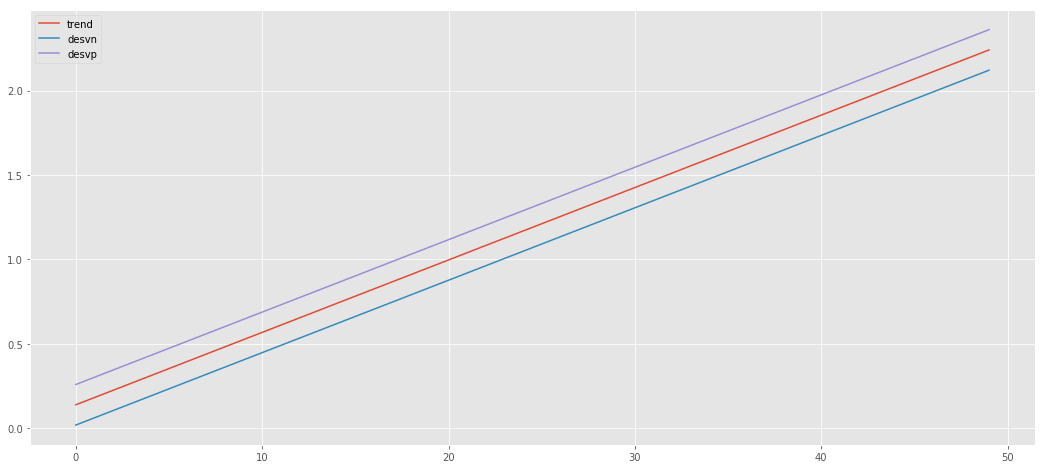

In [98]:
years=np.linspace(1,16)
df=pd.DataFrame(years)
df['trend']= years*.14
df['desvp']=df.trend+(.06*2)
df['desvn']=df.trend-(.06*2)
df[['trend','desvn','desvp']].plot()


<p>Podemos ver que la tendencia es positiva pues el proceso tiene una media positiva, y al ser una cte nuestra desviación tipica, nuestros valores estarían entre las rectas azules

---

<h1>Utilidad:</h1>
<p>Podemos ultilizarlo para:
<p>
<li>Limitar las pérdidas de nuestra inversión a un %</li>
<p>
<li>Poder comparar diferentes estrategias a igual riesgo
</li>

In [99]:
tickers = ['san', 'itx','tef']
tickers_name = {'san': 'SANTANDER', 'itx' : 'INDITEX', 'tef' : 'TELEFONICA'}
tickers_mc = [ticker + '.mc' for ticker in tickers]


<h1>Carga de Datos de San, Tef, Itx</h1>

<p>Vamos a calcular los diferentes datos para estas tres series

In [100]:
data = yf.download(tickers_mc, start='2008-01-01', end='2018-08-01', as_panel=False)
col_ticker = [col[:-3].lower() for  col in data.columns.levels[1]]
data.columns.set_levels(col_ticker, level=1, inplace=True)


[*********************100%***********************]  3 of 3 downloaded


In [101]:
# data2 = yf.download('san.mc', start='2008-01-01', end='2018-08-01', as_panel=False)

#  ESTA LINEA SE PUEDE BORRAR

In [102]:
def ajustado(df):
    df=df.copy()
    lista=['Open','High','Low']   
    for f in lista:
        df[f]=df[f]*df['Adj Close']/df['Close']
    df=df.drop('Close', axis=1)
    df=df.rename(columns = {'Adj Close': 'Close'} )
    return df


In [103]:
data = ajustado(data)
data = data.swaplevel(axis=1).sort_index(level=0, axis=1)

In [104]:
data['itx'].tail()

Close       High        Low       Open   Volume
Date                                                           
2018-07-26  28.639999  28.700001  28.340000  28.500000  1869408
2018-07-27  28.430000  28.700001  28.290001  28.530001  2051177
2018-07-30  28.200001  28.540001  28.129999  28.299999  1462561
2018-07-31  28.049999  28.280001  27.969999  28.090000  2537625
2018-08-01  27.980000  28.170000  27.879999  28.049999  2163168

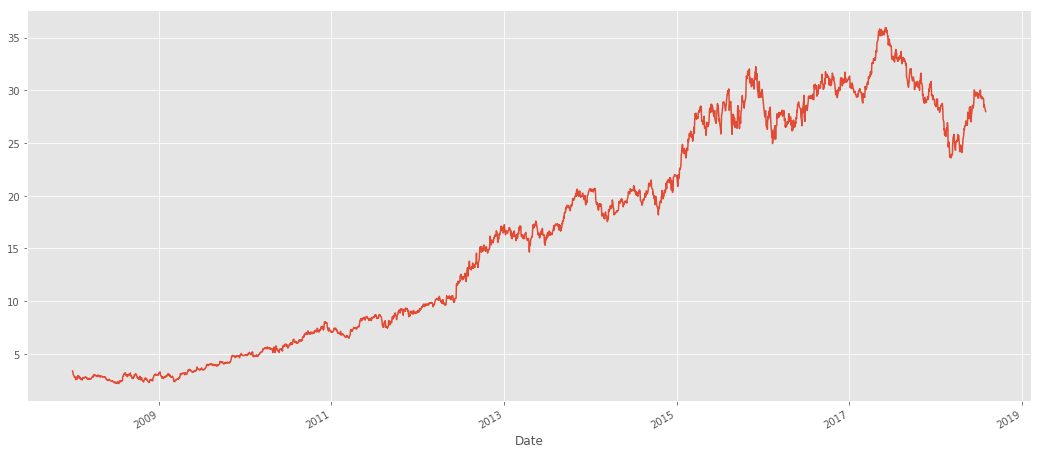

In [191]:
data['itx']['Close'].plot()

# Media y varianza constante ?

<H2>Propiedades de la media y de la varianza</h2>

<p>Tanto la media como la varianza tienen unas propiedades que debemos saber.
<p>
<li> La media se ve afectada tanto por cambios en el origen como en la escala de la serie.</li>
<p><a href="https://es.wikipedia.org/wiki/Media_aritm%C3%A9tica#Propiedades"> - Propiedades de la media</a>

<p>
<li> La varianza sólo se ve afectada por los cambios de escala.
<p>
<p><a href="https://es.wikipedia.org/wiki/Varianza#Propiedades_de_la_varianza"> - Propiedades de la varianza</a>




In [105]:
f = data.swaplevel(axis=1)['Close']

In [106]:
f.head()

itx       san        tef
Date                                     
2008-01-02  3.379318  6.007310  10.720781
2008-01-03  3.300785  5.949684  10.506130
2008-01-04  3.077207  5.863199  10.442735
2008-01-07  2.975435  5.826179  10.828082
2008-01-08  2.938572  5.735590  11.008546

<H3>Gráficos de volatilidad corrida de las series</h3>

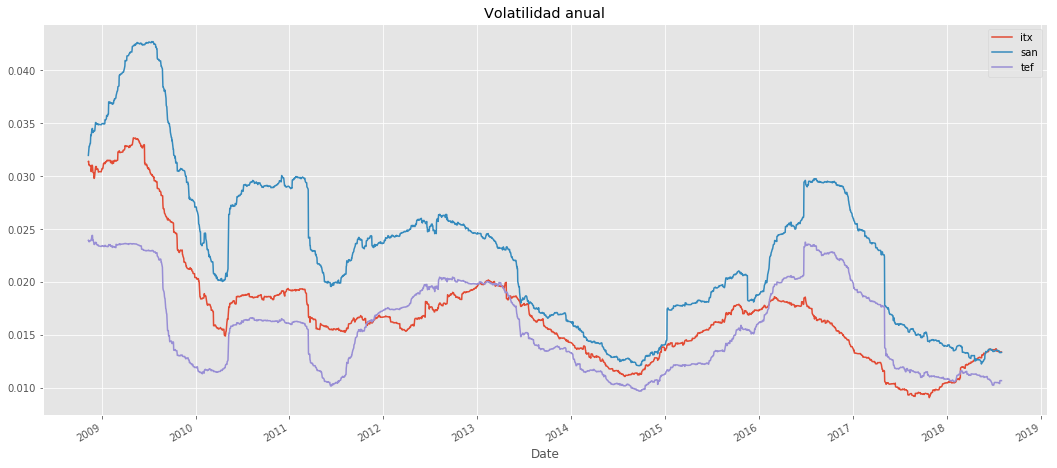

In [107]:
retornos = f.pct_change()
volatidad_anualizada = retornos.rolling(220).std()
volatidad_anualizada.plot(title='Volatilidad anual')

<p>Observamos en las tres series periodos de alta variación en la volatilidad combiandos con otros de volatilidad mas estable.

<H3>Gráficos de rendimiento anual de las series</h3>

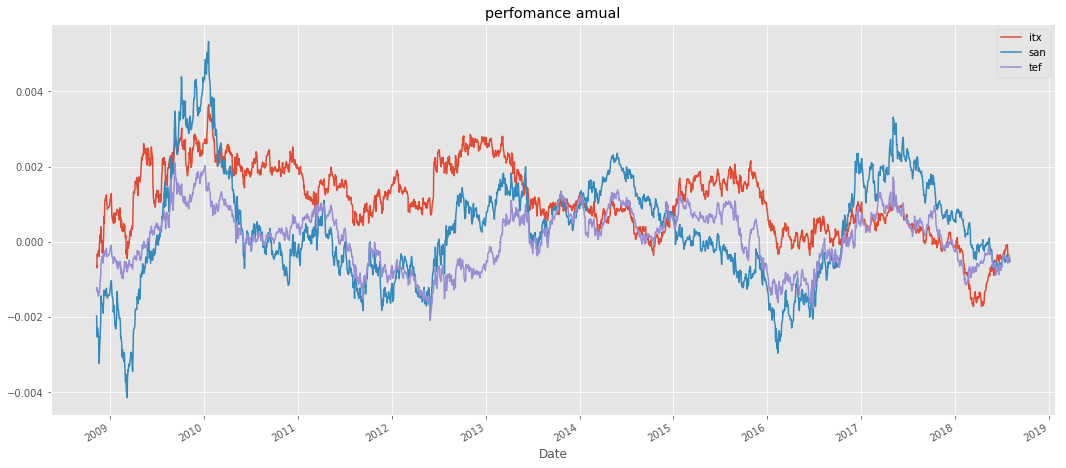

In [108]:
retornos_anulizados = retornos.rolling(220).mean()
retornos_anulizados.plot(title='perfomance amual')

<p>Aquí tb veo ciertos tramos de variabilidad y tramos mas tranquilos

<h3>Gráficos del Ratio Rentabilidad Anual / Volatilidad Anual de las series</h3>

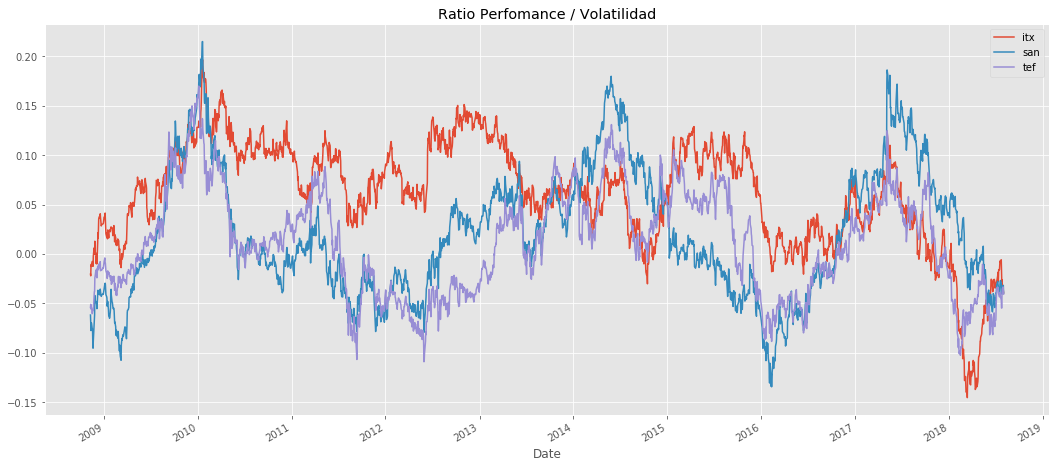

In [109]:
(retornos_anulizados/volatidad_anualizada).plot(title='Ratio Perfomance / Volatilidad')

<H3>Gráficos de la Matriz rendimiento - volatilidad</h3>

<p>Esto lo puedo convertir en una matriz rendimiento volatilidad</p>
<li>Baja volatilidad y buen rendiemiento ( vaca lechera - ordeñar)</li>
<li>Baja volatilidad y mal rendimiento  (Crecer en rendimiento)</li>
<li>Alta volatilidad y buen rendimiento  (Atento a la volatilidad)</li>
<li>Alta volatilidad y mal rendiemiento  ( No Operar )</li>


In [110]:
pepe = retornos_anulizados['itx']
#pepe3 = 

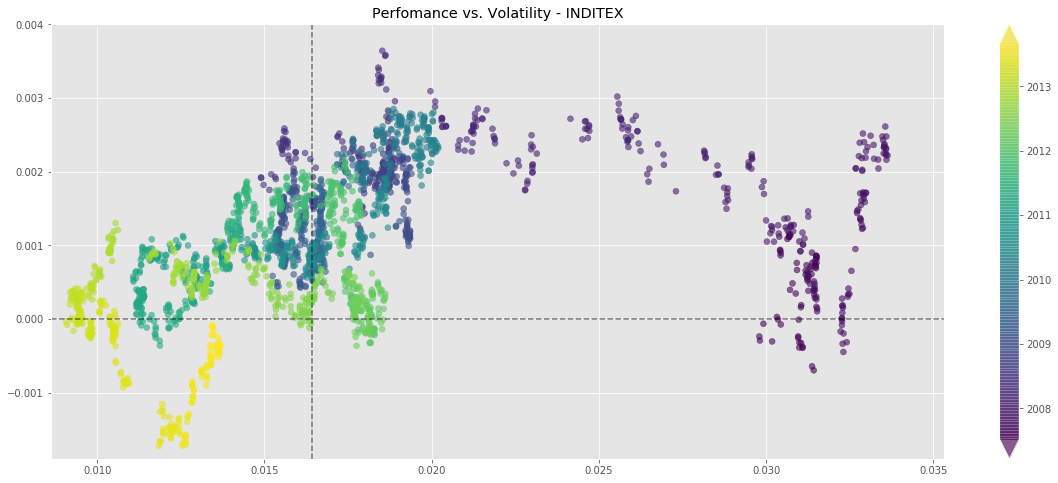

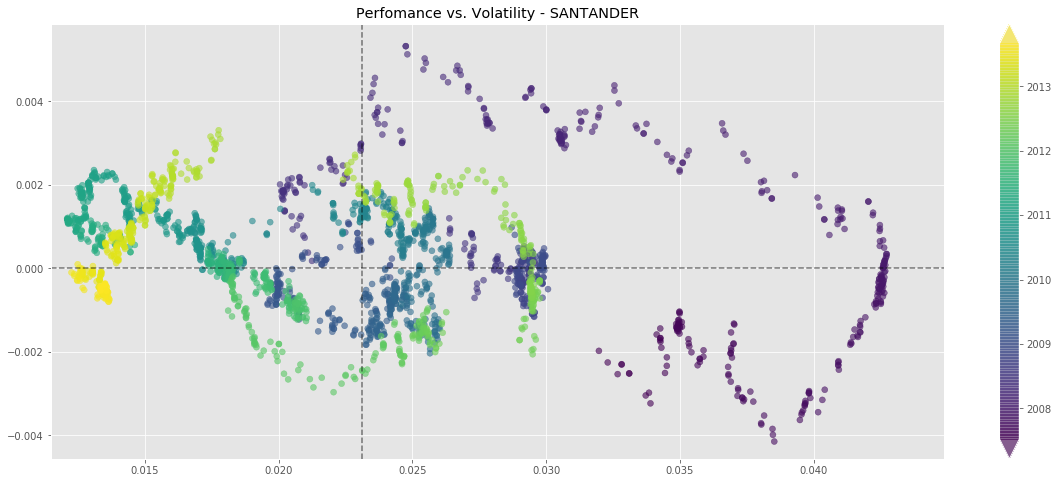

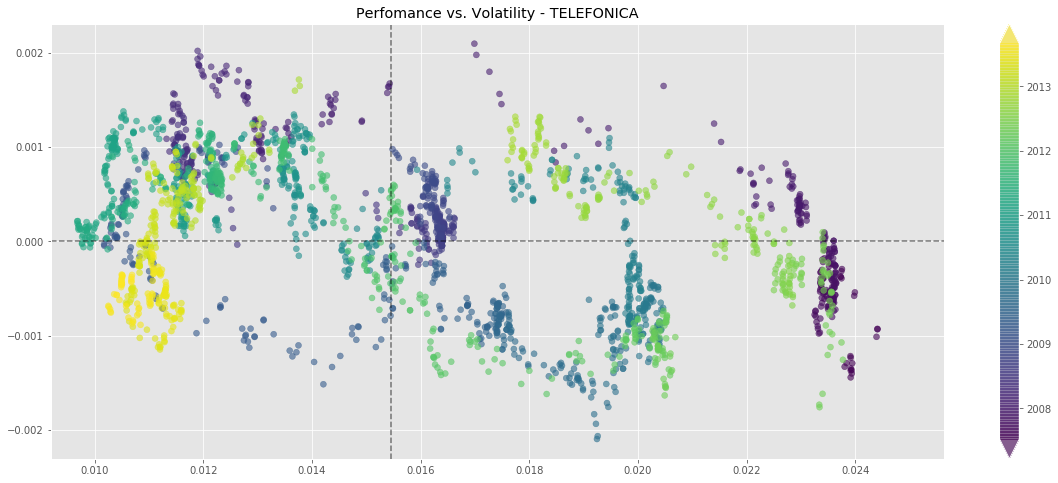

In [111]:
for valor in f.columns:
    vol = volatidad_anualizada[valor]
    ret = retornos_anulizados[valor]
    years=f.index.year.unique()
    fig = plt.figure(figsize=(20,8))
    scatter=plt.scatter(vol, ret, alpha = .6, c = pepe.index, cmap = 'viridis')
    
    plt.ylim(ret.min()*1.10,ret.max()*1.10)
    plt.xlim(vol.min()*0.95,vol.max()*1.05)
    plt.hlines(0,vol.min()*0.95,vol.max()*1.05,linestyle='dashed', alpha=0.5)
    plt.vlines(vol.median(),ret.min()*1.10,ret.max()*1.10,linestyle='dashed', alpha=0.5)
    
    cb = plt.colorbar(extend='both')
    cb.ax.set_yticklabels(years)
    plt.title('Perfomance vs. Volatility - {}'.format(tickers_name[valor]))
    plt.show()
    print('\n  \n')

---


## t -test

<p>Vemos un primer test para ver como de constante es nuestra media.
<p>Es el t-test y nos sirve para ver si una media es distinta de cero para una distribución dada.
<p>Si nuestra media es distinta de cero, al menos, podremos decir que ganamos dinero
<p>Enlazamos una definicion de 
<a href="https://en.wikipedia.org/wiki/Student%27s_t-test">t test</a>
<p> El cálculo es bastante sencillo:
<p> es el cociente entre la media del proceso y su desviación típica corregida por la raiz cuadrada del numero de sucesos


In [112]:
mean=f.pct_change().mean()
std=f.pct_change().std()
lon=len(f)
t_test=( mean - 0 )/(std/math.sqrt(lon))
t_test = pd.DataFrame(t_test, columns=['t-test'])
t_test

t-test
itx  2.689952
san  0.424977
tef  0.023325

## k - ratio


<p>Proviene de la Econometría. Nos permite validar si una media la podemos asmimilar a una constante.
<p>Es en realidad el ratio t-student del coeficiente de una regresión. 
<p>Nos indica a la vez que tenemos una media distinta de cero y que es de alguna manera constante a lo largo del experiemento.
<p>Cuanto mayor sea mucho mejor

In [113]:
g=f.resample('M').last()
g['time']=np.arange(1,len(g)+1)

In [114]:
import statsmodels.formula.api as smf
for valor in tickers:
    results = smf.ols('{} ~ time '.format(valor), data=g).fit()
    pendiente = results.params[1]
    error = results.bse[1]
    k_ratio = results.tvalues[1]
    rango = results.conf_int().iloc[1].values
    print ('\n{}: \n\n Pendiente = {:.3f} \n Error típico = {:.5f} \n K-ratio = {:.3f} \n Rango = {:.3f} - {:.3f}\n'
           .format(tickers_name[valor], pendiente, error, k_ratio, rango[0],rango[1]))




SANTANDER: 

 Pendiente = 0.004 
 Error típico = 0.00211 
 K-ratio = 2.029 
 Rango = 0.000 - 0.008


INDITEX: 

 Pendiente = 0.275 
 Error típico = 0.00654 
 K-ratio = 42.084 
 Rango = 0.262 - 0.288


TELEFONICA: 

 Pendiente = -0.007 
 Error típico = 0.00262 
 K-ratio = -2.698 
 Rango = -0.012 - -0.002



<p>Podemos ver que para cada regresión los valores del k-ratio varían notablemente.
<p>Por ejemplo en itx su valor es de 42 y nos indica que la media ha sido bastante constante en el tiempo, podemos decir que varia entre 0.262 y 0.288
<p>En este caso, al ser una constante el valor de la media de itx, podemos hacer predicciones sobre la volatilidad de la acción y ajustar bastante bien la prediccion del valor de la accion.
<p>Recuedo el gráfico rendimiento / volatilidad

# alpha y beta

<p>A la hora de construir distribuciones que puedan tener una media y varianza mas o menos constante, podemos sumar diferentes estrategias y obtener mejores resultados en nuestros test.
    
<p>Podemos definir una estrategia en funcion de otra

<p>Y_rdto = alpha + beta*X_rdto

<p>En función de ello podemos escoger diferentes estrategias, no voy a meterme en ello.
    
<p>En base a las propiedades de la media y de la varianza.
<p>La nueva Y_media = Y_media + alpha + beta*X
<p>La nueva varianza = Y_varianza * (beta * varianza X)
    
<p>El término "beta" es simplemente una medida de la sensibilidad de una acción al movimiento del mercado de valores en general o de una acción en particular. Si X gana un 5% y mi beta es de 2 el valor ganara un 10%
    
<p>El término alpha mide la capacidad de una accion para superar el índice de mercado o de una accion en particular.
    
<p>Si tengo un alpha de 0.02 quiere decir q todos los meses la estrategia Y gana un 2% mas que la X

In [115]:
g['itx_pct'] = g.itx.pct_change()
g['san_pct'] = g.san.pct_change()
g['tef_pct'] = g.tef.pct_change()

results = smf.ols('itx_pct ~ tef_pct ', data=g).fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                itx_pct   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     22.78
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           4.97e-06
Time:                        17:47:31   Log-Likelihood:                 183.28
No. Observations:                 127   AIC:                            -362.6
Df Residuals:                     125   BIC:                            -356.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0203      0.005      3.977      0.0

<p>Itx gana un 2% todos los meses, y solo se le suma un 37.28% de lo que gane o pierda tef.
<p>Si tef ganó un 5% es de esperar que en el mismo mes itx gane .02 + (.05 * .3728) = 0.03864
<p>Fijarse lo que supone ganar un 0.02 mensual

In [116]:
results = smf.ols('tef_pct ~ itx_pct ', data=g).fit()
print (results.summary())

                            OLS Regression Results                            
Dep. Variable:                tef_pct   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     22.78
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           4.97e-06
Time:                        17:47:31   Log-Likelihood:                 176.68
No. Observations:                 127   AIC:                            -349.4
Df Residuals:                     125   BIC:                            -343.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0080      0.006     -1.418      0.1

<p>Este seria el ejemplo contrario. Telefónica pierde un -0,008 todos los meses y solo se le suma un .4136 de la variación de itx

# Riesgo de Cola

<p>En toda estrategia tenemos un cierto riesgo de eventos que sean mayor que tres veces la desviación tipica. Esto es lo que se llama Riesgo de Cola.

<p><a href="https://www.investopedia.com/terms/t/tailrisk.asp">Riesgo de Cola</a>

<p>Las estrategias suelen tener un exceso de "Kurtosis". Este esceso de Kurtosis implica riesgo de colas amplias y por tanto hay riesgo de que estas estrategias tengan rendimientos negativos superiores a los esperados


## kurtosis


<p>Es un momento de orden 4 que trata de ver si produce muchos valores extremos. Una distribución normal tiene un valor de 3.

<p>Si tiene un valor menor de 3 se la llama platicúrtica y cuanto menor sea tiende a convertir la distribución normal en una distribución Uniforme.

<p>Si tiene un valor mayor de 3 se llama leptocurtica y tendra un riesgo de cola alto
<p>Hay implementaciones que se les resta 3 para situar lo mismo en 0. Como es el gráfico de abajo, que son distintos valores de kurtosis para una misma varianza

![image](https://upload.wikimedia.org/wikipedia/commons/e/e6/Standard_symmetric_pdfs.png)

## Asimetría o Skewness

![image](https://www.kullabs.com/uploads/skewness1.jpg)

<p>Es un momento de orden 3 que trata de ver la distribución se concentra mas a la derecha o a la izquierda. Una distribución normal tiene un valor de 0 y está igualmente distribuida a la derecha y a la izquierda

<p>Si tiene un valor menor de 0 tiene inclinación negativa y suele tener cola negativa larga.
<p>Si tiene un valor mayor de 0 tiene una inclinación positiva y tendra un riesgo de cola negativa baja.

In [117]:
#retornos = g[].dropna()

In [118]:
g.columns

Index([u'itx', u'san', u'tef', u'time', u'itx_pct', u'san_pct', u'tef_pct'], dtype='object')

<P>Una de las formas que podemos observar la kurtosis y la asimetría es con un boxplot o gráfico de caja.
<p>Un boxplot o gráfico de caja es un grafico que delimita los cuartiles Q1 y Q3 y tambien delimita la mediana dentro de la caja. 
<p>Nos muestra unos outliers que nos indican la posibilidad de kurtosis dentro de la distribución 

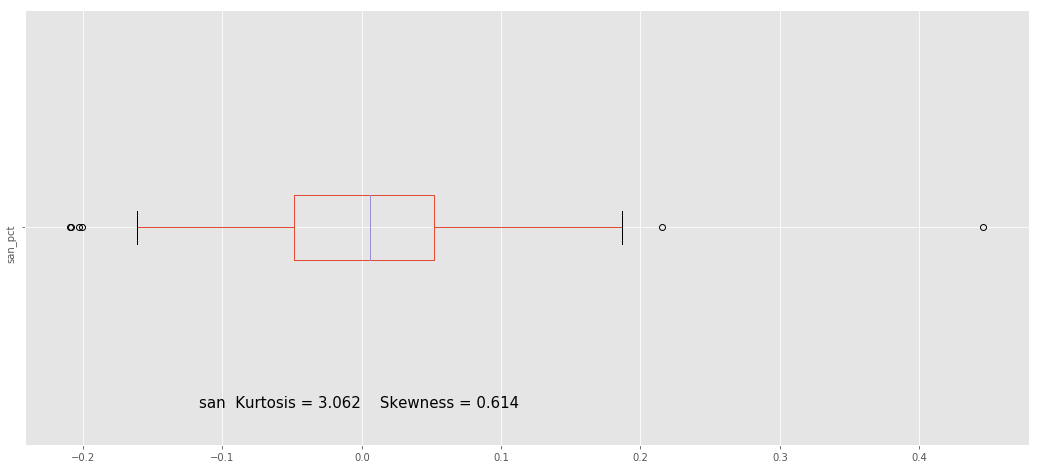

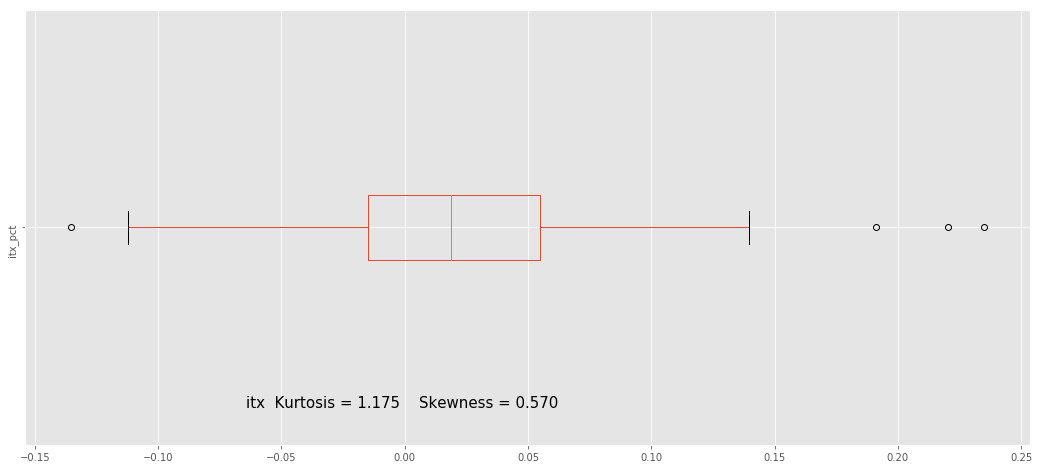

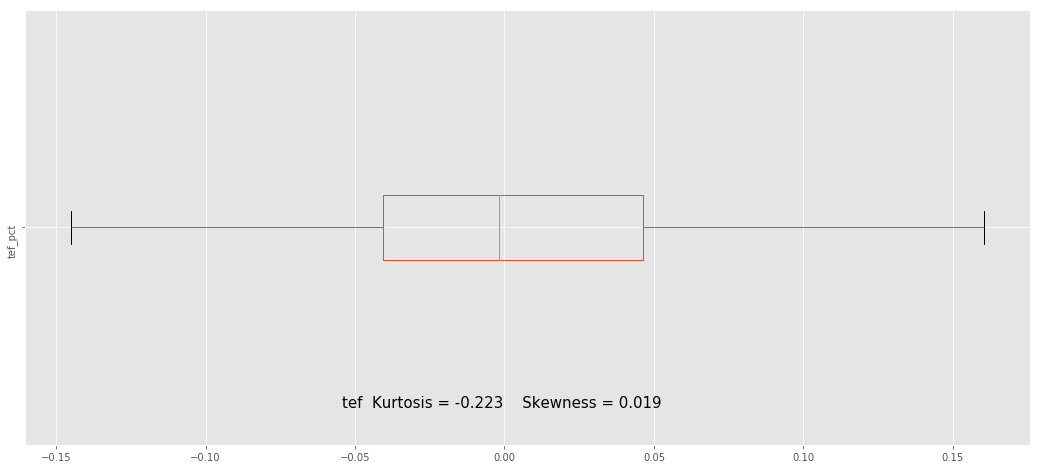

In [119]:
for n in tickers:
    values=g['{}_pct'.format(n)]
    
    values2=pd.DataFrame(values)
    values2.boxplot(vert=False,rot=90)
    plt.text(0, 0.5,'{}  Kurtosis = {:.3f}    Skewness = {:.3f} \n\n'.format(n,values2.kurt()[0],values2.skew()[0]),
            verticalalignment='bottom', horizontalalignment='center',color='k',fontsize=15)
    plt.show()
    del values2

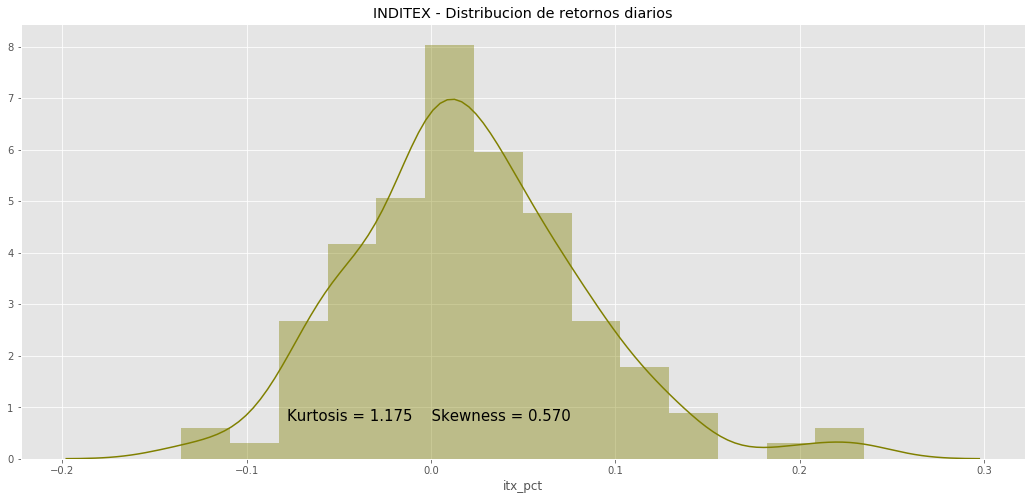

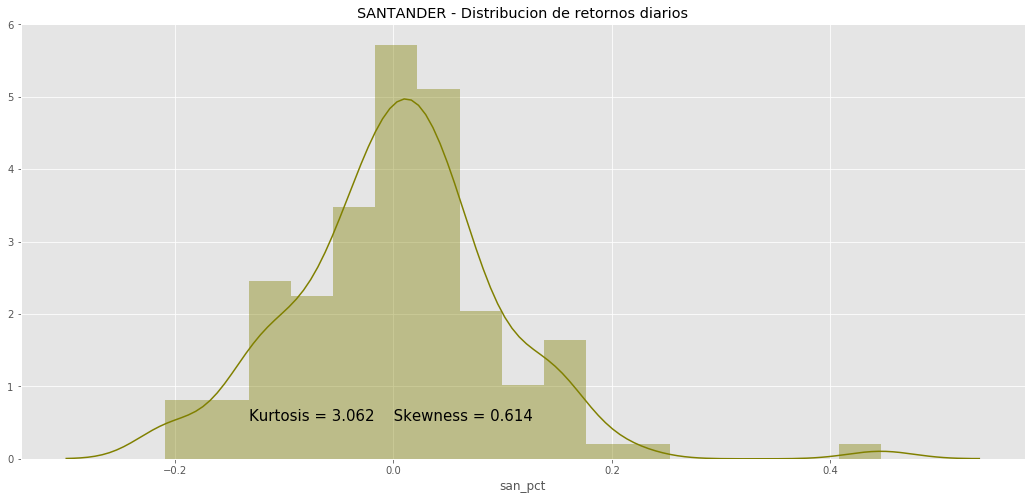

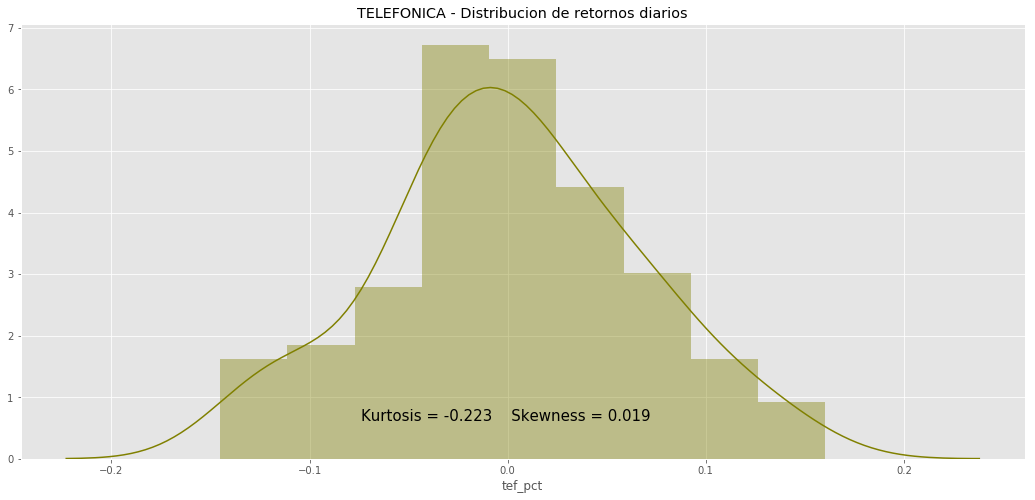

In [120]:
for col in [col for col in g.columns if col[-3:]=='pct']:
    rets = g[col].dropna()
    sns.distplot(rets, color='olive')
    ticker_name = tickers_name[col[:3]]
    plt.title('{} - Distribucion de retornos diarios'.format(ticker_name))
    
    kurtosis = rets.kurt()
    skew = rets.skew()
    plt.text(0, 0,'Kurtosis = {:.3f}    Skewness = {:.3f} \n\n'.format(kurtosis, skew),
            verticalalignment='bottom', horizontalalignment='center',         color='k', fontsize=15)
    plt.show()

<p><b>objetivo tener una kurtosis negativa y skewness leve positiva</b></h2>

# cálculo del var95

<p>Si el trading fuese la F1 tendríamos un riesgo de romper un motor y no acabar la carrera. Lo que hacen los diferentes equipos es testar dichos motores para que alcancen una total fiabilidad en 7 carreras. Es decir que no se rompan a un 99% de posibilidades.
<p>Aún así, parece que algunos motores se rompen.
<p>El trading tiene el mismo problema, si nos cargamos una cuenta, ya no podemos tradear más y por tanto hacemos game over. La forma de no caer en controlando el riesgo de las operaciones. Por lo general se establece como la posibilidad de no perder mas de un 10% en un mes al 95% de posibilidad. Pues hay un riesgo llamado de cola o de encontrarnos con el peor de los sucesos.
<p>Por tanto, vamos a intentar maximizar el valor del var95 y evitar todos los riesgos derivados de un posible cisne negro.
<p>Hay varias maneras de poder calcular el var95 de una serie

In [121]:
#calculamos los pct

for n in tickers:

    f['{}_pct_diario'.format(n)]=f['{}'.format(n)].pct_change()
    f['{}_pct_20dias'.format(n)]=f['{}'.format(n)].pct_change(20)
    f['{}_pct_60dias'.format(n)]=f['{}'.format(n)].pct_change(60)
    f['{}_pct_120dias'.format(n)]=f['{}'.format(n)].pct_change(120)
    f['{}_pct_220dias'.format(n)]=f['{}'.format(n)].pct_change(220)

    
    f['{}_pct_diario'.format(n)]=f['{}_pct_diario'.format(n)].dropna()
    f['{}_pct_20dias'.format(n)]=f['{}_pct_20dias'.format(n)].dropna()
    f['{}_pct_60dias'.format(n)]=f['{}_pct_60dias'.format(n)].dropna()
    f['{}_pct_120dias'.format(n)]=f['{}_pct_120dias'.format(n)].dropna()
    f['{}_pct_220dias'.format(n)]=f['{}_pct_220dias'.format(n)].dropna()

    
f.tail()

itx       san    tef  san_pct_diario  san_pct_20dias  \
Date                                                                     
2018-07-26  28.639999  4.699728  7.629        0.009964        0.041539   
2018-07-27  28.430000  4.753000  7.666        0.011335        0.049216   
2018-07-30  28.200001  4.765500  7.710        0.002630        0.058777   
2018-07-31  28.049999  4.819500  7.691        0.011331        0.059167   
2018-08-01  27.980000  4.753000  7.661       -0.013798        0.037468   

            san_pct_60dias  san_pct_120dias  san_pct_220dias  itx_pct_diario  \
Date                                                                           
2018-07-26       -0.107196        -0.166296        -0.123869        0.008806   
2018-07-27       -0.103795        -0.131447        -0.123960       -0.007332   
2018-07-30       -0.102106        -0.147549        -0.110494       -0.008090   
2018-07-31       -0.092606        -0.114560        -0.106651       -0.005319   
2018-08-01       -0.113523        -0.111329        -0.126738       -0.002496   

            itx_pct_20dias  itx_pct_60dias  itx_pct_120dias  itx_pct_220dias  \
Date                                                                           
2018-07-26       -0.028164        0.090217         0.061988        -0.092095   
2018-07-27       -0.028366        0.068797         0.083496        -0.103489   
2018-07-30       -0.036556        0.059354         0.069909        -0.118914   
2018-07-31       -0.051724        0.047815         0.088220        -0.120638   
2018-08-01       -0.057278        0.032472         0.087583        -0.126858   

            tef_pct_diario  tef_pct_20dias  tef_pct_60dias  tef_pct_120dias  \
Date                                                                          
2018-07-26        0.035002        0.047077       -0.063827        -0.007859   
2018-07-27        0.004850        0.053167       -0.052378         0.023131   
2018-07-30        0.005740        0.063889       -0.044293         0.003947   
2018-07-31       -0.002464        0.038623       -0.051686         0.031428   
2018-08-01       -0.003901        0.009620       -0.056404         0.045708   

            tef_pct_220dias  
Date                         
2018-07-26        -0.099887  
2018-07-27        -0.091340  
2018-07-30        -0.086828  
2018-07-31        -0.095742  
2018-08-01        -0.102112

In [122]:
f.head()

itx       san        tef  san_pct_diario  san_pct_20dias  \
Date                                                                        
2008-01-02  3.379318  6.007310  10.720781             NaN             NaN   
2008-01-03  3.300785  5.949684  10.506130       -0.009593             NaN   
2008-01-04  3.077207  5.863199  10.442735       -0.014536             NaN   
2008-01-07  2.975435  5.826179  10.828082       -0.006314             NaN   
2008-01-08  2.938572  5.735590  11.008546       -0.015549             NaN   

            san_pct_60dias  san_pct_120dias  san_pct_220dias  itx_pct_diario  \
Date                                                                           
2008-01-02             NaN              NaN              NaN             NaN   
2008-01-03             NaN              NaN              NaN       -0.023239   
2008-01-04             NaN              NaN              NaN       -0.067735   
2008-01-07             NaN              NaN              NaN       -0.033073   
2008-01-08             NaN              NaN              NaN       -0.012389   

            itx_pct_20dias  itx_pct_60dias  itx_pct_120dias  itx_pct_220dias  \
Date                                                                           
2008-01-02             NaN             NaN              NaN              NaN   
2008-01-03             NaN             NaN              NaN              NaN   
2008-01-04             NaN             NaN              NaN              NaN   
2008-01-07             NaN             NaN              NaN              NaN   
2008-01-08             NaN             NaN              NaN              NaN   

            tef_pct_diario  tef_pct_20dias  tef_pct_60dias  tef_pct_120dias  \
Date                                                                          
2008-01-02             NaN             NaN             NaN              NaN   
2008-01-03       -0.020022             NaN             NaN              NaN   
2008-01-04       -0.006034             NaN             NaN              NaN   
2008-01-07        0.036901             NaN             NaN              NaN   
2008-01-08        0.016666             NaN             NaN              NaN   

            tef_pct_220dias  
Date                         
2008-01-02              NaN  
2008-01-03              NaN  
2008-01-04              NaN  
2008-01-07              NaN  
2008-01-08              NaN

## Cálculo estadístico del VaR

<p>Es cuando tenemos una fotografía de nuestra dstribución, como el desempeño mensual de nuestros rendimientos. El principal problema es el número de datos, mientras que su cálculo es muy sencillo.
<p>Para ello sólo necesitamos saber el nivel de confianza. Pues de la serie obtenemos los datos para el cáculo del var.
<p>Hay que tener en cuenta un número mínimo de observaciones para dar una buena validez a los datos obtenidos.
<p>Una data posible es en formato anual:
    

In [123]:
def var_estadistico(price_serie, ci=0.95, time=None, verbose=True):
    '''
    Calcula el var para una serie de precios a un coefiente de confianza dado,
    pudiendo remuestrear la serie a una periodicidad superior.
    '''
    from scipy.stats import norm
    from numpy import mean, std
    if  time!=None:
        price_serie = price_serie.resample(time).last()
    retornos = price_serie.pct_change().dropna()
    
    var = -norm.ppf(1 - ci,mean(retornos), std(retornos)) #asume la normalidad de la distribución
    if verbose:
        print ('El VaR {} para los retornos analizados con un frequencia {} es del {}%'.format(int(ci*100), time, round(var*100,2)))
    return var

<p>Estos son los datos semestrales de Santander

In [124]:
print (f.san.resample('2Q').last().T)

Date
2008-03-31    5.256694
2008-09-30    4.528827
2009-03-31    2.494785
2009-09-30    5.534525
2010-03-31    5.071308
2010-09-30    4.989617
2011-03-31    4.575982
2011-09-30    3.641414
2012-03-31    3.520754
2012-09-30    3.817415
2013-03-31    3.626944
2013-09-30    4.422968
2014-03-31    5.319297
2014-09-30    6.073534
2015-03-31    5.867334
2015-09-30    4.086824
2016-03-31    3.414733
2016-09-30    3.571179
2017-03-31    5.313003
2017-09-30    5.664324
2018-03-31    5.165048
2018-09-30    4.753000
Name: san, dtype: float64


In [125]:
var = var_estadistico(f.san, ci=0.95, time='2Q')

El VaR 95 para los retornos analizados con un frequencia 2Q es del 50.13%


In [126]:
print (f.san.resample('A').last().T)

Date
2008-12-31    3.179504
2009-12-31    5.879280
2010-12-31    4.301230
2011-12-31    3.506402
2012-12-31    4.122066
2013-12-31    4.886912
2014-12-31    5.708584
2015-12-31    3.965737
2016-12-31    4.538229
2017-12-31    5.291502
2018-12-31    4.753000
Freq: A-DEC, Name: san, dtype: float64


In [127]:
ci = 0.95
var = var_estadistico(f.san, ci=ci, time='Y', verbose=False)
print ('El VaR{} anual para los retornos analizados es del {}%'.format(int(ci*100), round(var*100,2)))

El VaR95 anual para los retornos analizados es del 43.84%


In [128]:
def var95m(valuados,graph=True,box=True,imp=True,time='M'):
    #pasamos las cotizaciones a mensual
    memo=valuados.resample(time).last()
    #ploteamos
    #calculamos el % cambio
    mempct=memo.pct_change()
    #calculamos el t_test
    #print "t test mensual\n\n",mempct.mean()/(mempct.std()/math.sqrt(len(mempct)))
    #calculamos el var95
    #print "var95 \n\n",mempct.quantile(.05)
    #mempct.plot()
    t_test=(mempct.mean().values[0]/(mempct.std().values[0]/math.sqrt(len(mempct))))
    
    agg_measures = {
        'avg': mempct.mean().values[0],
        'std': mempct.std().values[0],
        'var': mempct.var().values[0],
        'med': mempct.median().values[0],
        '01p': mempct.quantile(.01).values[0],
        '05p': mempct.quantile(.05).values[0],
        '50p': mempct.quantile(.50).values[0],
        '95p': mempct.quantile(.95).values[0],
        'val': mempct.quantile(.95).values[0] / mempct.quantile(.05).values[0],
        'skw': mempct.skew().values[0],
        'kur': mempct.kurtosis().values[0],
        'T-test': t_test
    }
    
    if graph==True :
        plt.close()
        memo.plot();
        mempct.plot()
        #mempct.hist(bins=40,normed=True,alpha=0.7)
        #x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        #plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        mempct2=pd.DataFrame(mempct)
        mempct2.boxplot(vert=False,rot=90)
        plt.show()
        del mempct2
    if imp==True:
        for n in sorted(agg_measures.keys()):
            koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
            print (koko)
       
    
    return agg_measures 

In [129]:
def var95m2(valuados,graph=True,box=True,imp=True,time='M'):
    #pasamos las cotizaciones a mensual
    memo=valuados.resample(time).last()
    #ploteamos
    #calculamos el % cambio
    mempct=memo.pct_change()
    #calculamos el t_test
    #print "t test mensual\n\n",mempct.mean()/(mempct.std()/math.sqrt(len(mempct)))
    #calculamos el var95
    #print "var95 \n\n",mempct.quantile(.05)
    #mempct.plot()
    t_test=(mempct.mean()/(mempct.std()/math.sqrt(len(mempct))))
    
    agg_measures = {
        'avg': mempct.mean(),
        'std': mempct.std(),
        'var': mempct.var(),
        'med': mempct.median(),
        '01p': mempct.quantile(.01),
        '05p': mempct.quantile(.05),
        '50p': mempct.quantile(.50),
        '95p': mempct.quantile(.95),
        'val': mempct.quantile(.95)/mempct.quantile(.05),
        'skw': mempct.skew(),
        'kur': mempct.kurtosis(),
        'T-test': t_test
    }
    
    if graph==True :
        plt.close()
        memo.plot()
        plt.show()
        mempct.plot()
        #mempct.hist(bins=40,normed=True,alpha=0.7)
        #x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        #plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        mempct2=pd.DataFrame(mempct)
        mempct2.boxplot(vert=False,rot=90)
        plt.show()
        del mempct2
    if imp==True:
        for n in sorted(agg_measures.keys()):
            koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
            print (koko)
       
    
    return agg_measures 

<p>Quiero resaltar la importancia que tiene que al aumentar el periodo se reduzca el var.
<p>Por ejemplo, que el var95 semestral sea mayor que cero implica que nuestro sistema o serie no tiene drawdon mayor de seis meses. Nos indicaría una gran performace.

<P><b>Var95 de ITX mensual</b>

<p>Podemos ver diferentes ejemplos de cálculo del var estadístico

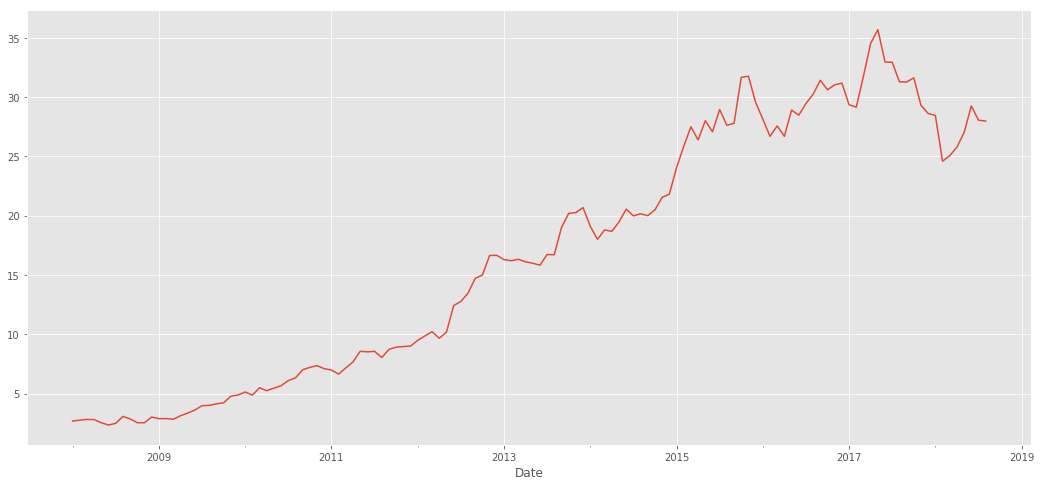

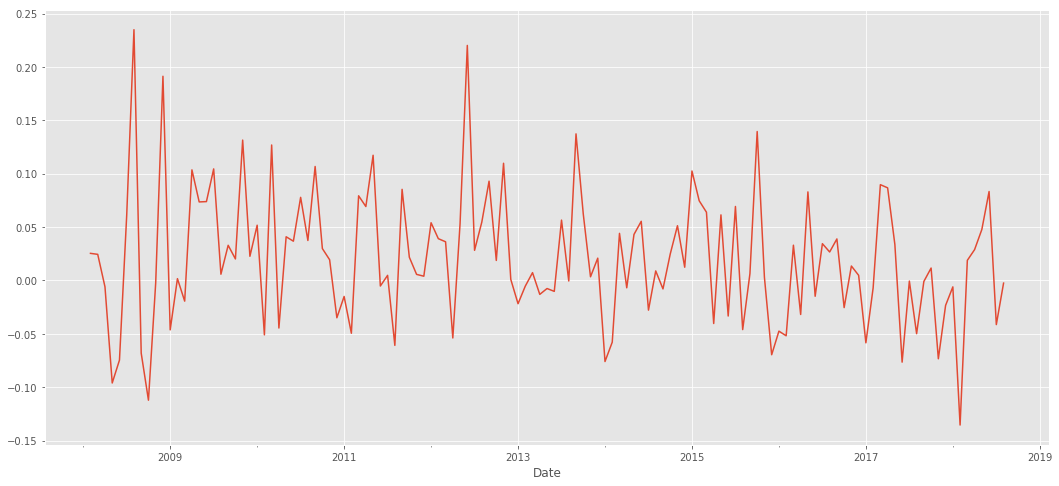

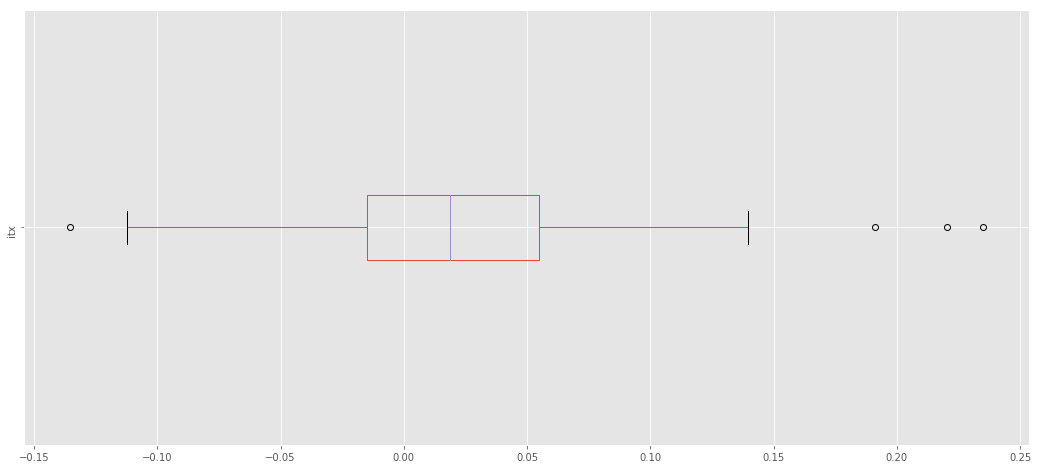

 el valor de 01p es : -0.10797 
 el valor de 05p es : -0.072238 
 el valor de 50p es : 0.018731 
 el valor de 95p es : 0.12399 
 el valor de T-test es : 3.7155 
 el valor de avg es : 0.020488 
 el valor de kur es : 1.175 
 el valor de med es : 0.018731 
 el valor de skw es : 0.57005 
 el valor de std es : 0.062387 
 el valor de val es : -1.7164 
 el valor de var es : 0.0038921 


In [130]:
nada=var95m2(f['itx'])

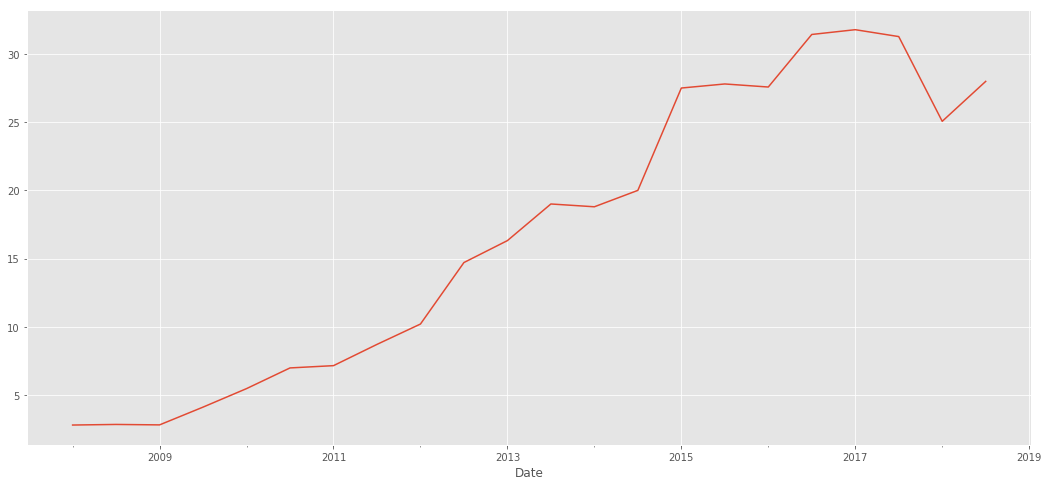

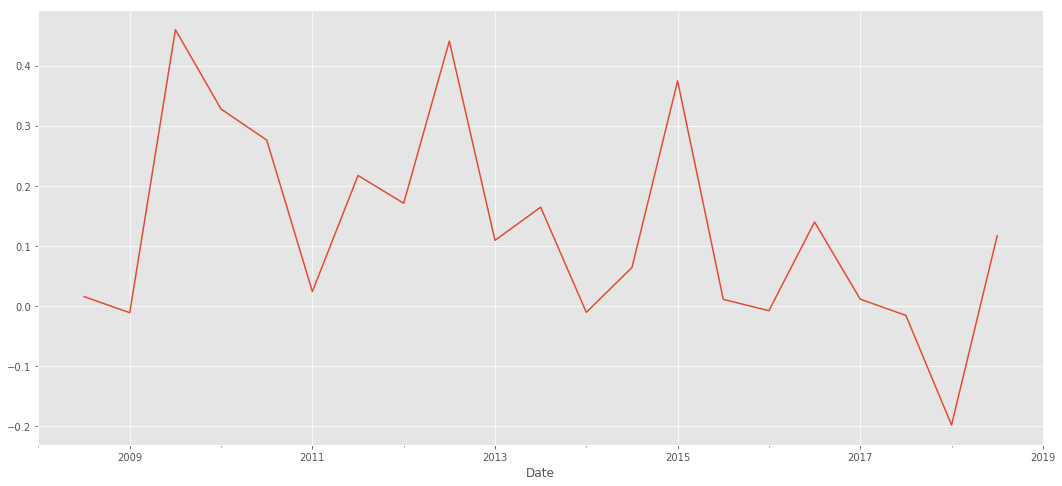

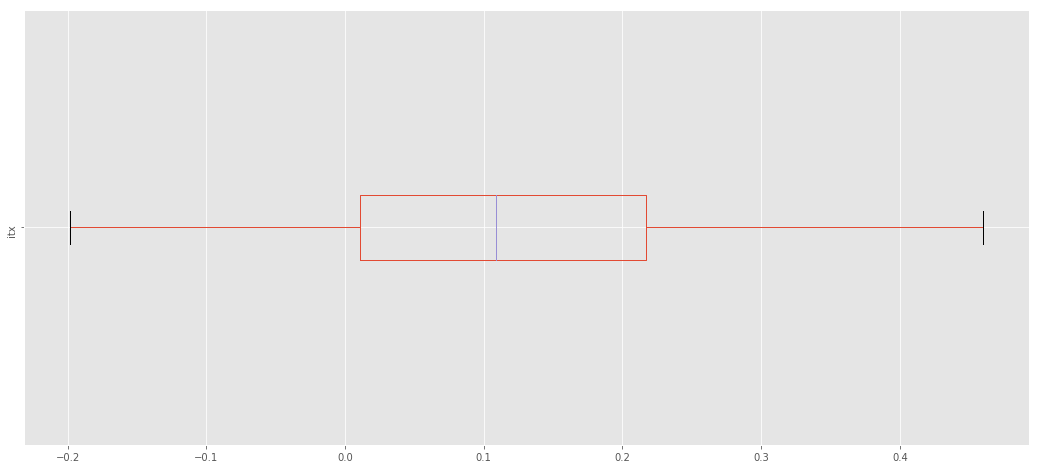

 el valor de 01p es : -0.16194 
 el valor de 05p es : -0.015873 
 el valor de 50p es : 0.10909 
 el valor de 95p es : 0.44087 
 el valor de T-test es : 3.5055 
 el valor de avg es : 0.12748 
 el valor de kur es : -0.22201 
 el valor de med es : 0.10909 
 el valor de skw es : 0.48354 
 el valor de std es : 0.17057 
 el valor de val es : -27.774 
 el valor de var es : 0.029096 


In [131]:
nada=var95m2(f['itx'],time='2Q')

<p>Está claro que el tiempo en drawdown es mayor que un semestre. Deberemos valorar esto a la hora de poder seleccionar los diferentes sistemas o series.

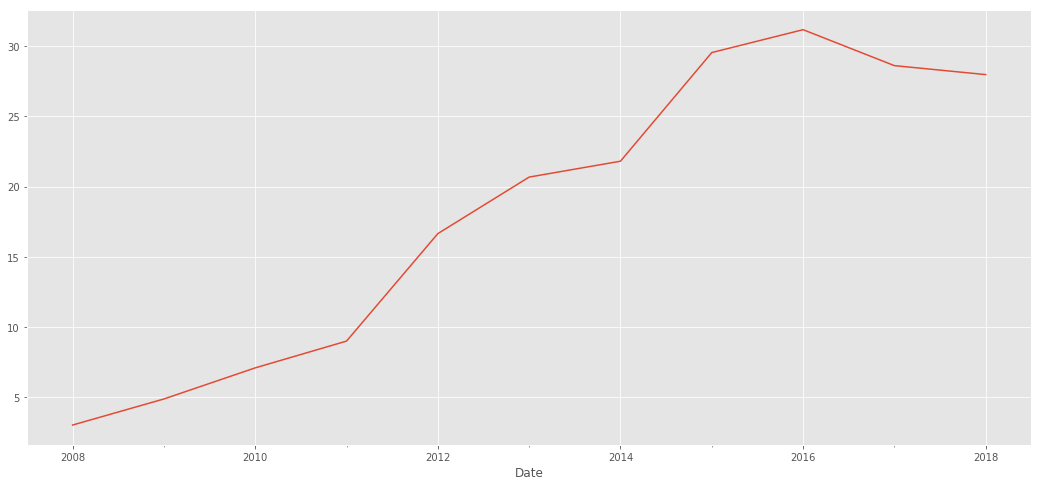

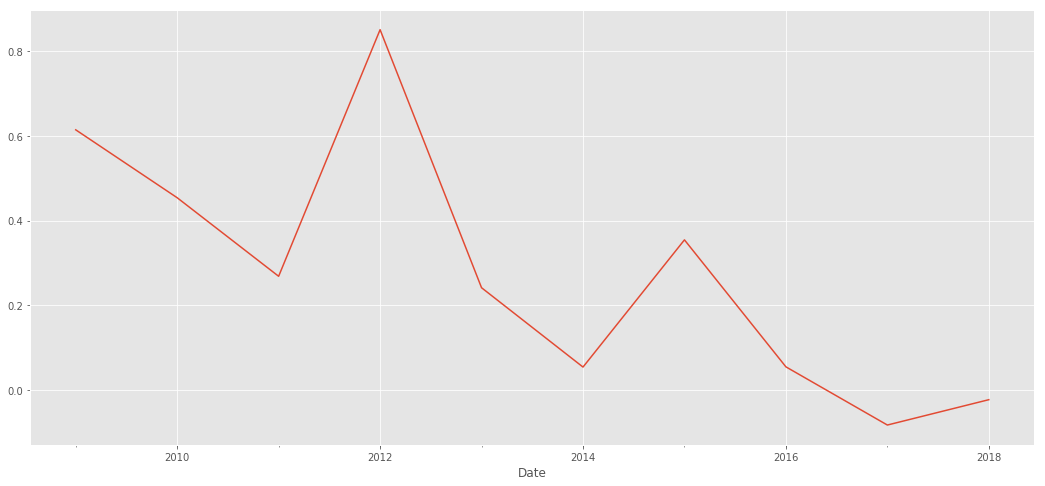

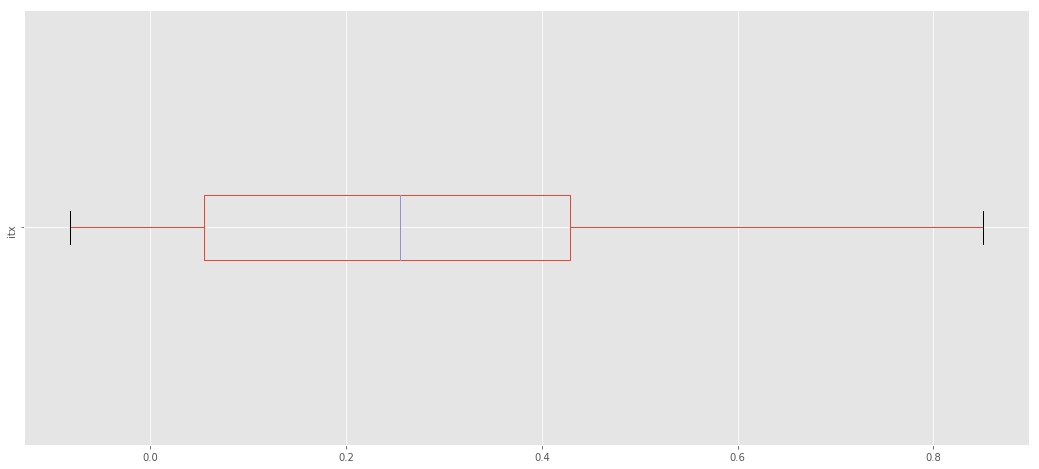

 el valor de 01p es : -0.076723 
 el valor de 05p es : -0.0552 
 el valor de 50p es : 0.25531 
 el valor de 95p es : 0.74426 
 el valor de T-test es : 3.1061 
 el valor de avg es : 0.27898 
 el valor de kur es : -0.16384 
 el valor de med es : 0.25531 
 el valor de skw es : 0.70032 
 el valor de std es : 0.29789 
 el valor de val es : -13.483 
 el valor de var es : 0.088737 


In [132]:
nada=var95m2(f['itx'],time='A')

<p>Está claro que el tiempo en drawdown es mayor que un semestre. Deberemos valorar esto a la hora de poder seleccionar los diferentes sistemas o series.

## calcula los diferentes var

In [133]:
#borrar
#f['itx'].tail()

<p>Podemos calcular los diferentes var estadisticos y ver como evoluciona

<h3>Tabla del var estadisitico por serie y frecuencia</h3>

In [134]:
var95a={}
tiempo=['M','2M','Q','2Q','A']
for n in tickers:
    for j in tiempo:
        clave="{}".format(n)
        tempo="{}".format(j)
        clatempo=clave+tempo
        var95a[clatempo]=dict(var95m(f[[clave]],time=tempo,graph=False,box=False,imp=False))

#var95est
var95esa=pd.DataFrame(var95a)
np.round(var95esa.T,3)


01p    05p    50p    95p  T-test    avg    kur    med    skw    std  \
itx2M -0.116 -0.098  0.035  0.180   3.926  0.041 -0.357  0.035  0.236  0.083   
itx2Q -0.162 -0.016  0.109  0.441   3.505  0.127 -0.222  0.109  0.484  0.171   
itxA  -0.077 -0.055  0.255  0.744   3.106  0.279 -0.164  0.255  0.700  0.298   
itxM  -0.108 -0.072  0.019  0.124   3.715  0.020  1.175  0.019  0.570  0.062   
itxQ  -0.150 -0.091  0.035  0.237   3.666  0.062 -0.756  0.035  0.116  0.111   
san2M -0.273 -0.220  0.016  0.205   0.538  0.010  1.350  0.016  0.443  0.143   
san2Q -0.420 -0.303 -0.034  0.488   0.494  0.035  7.745 -0.034  2.330  0.334   
sanA  -0.302 -0.289  0.155  0.551   0.823  0.083  2.487  0.155  1.215  0.334   
sanM  -0.207 -0.142  0.006  0.149   0.496  0.004  3.062  0.006  0.614  0.095   
sanQ  -0.273 -0.215 -0.012  0.271   0.404  0.011  5.058 -0.012  1.555  0.174   
tef2M -0.227 -0.118  0.004  0.124   0.004  0.000  0.635  0.004 -0.416  0.082   
tef2Q -0.157 -0.147 -0.020  0.212  -0.027 -0.001  0.688 -0.020  0.966  0.118   
tefA  -0.192 -0.168 -0.026  0.257   0.072  0.003  0.666 -0.026  0.965  0.151   
tefM  -0.141 -0.114 -0.002  0.115   0.074  0.000 -0.223 -0.002  0.019  0.066   
tefQ  -0.148 -0.120 -0.015  0.170   0.013  0.000 -0.124 -0.015  0.597  0.088   

          val    var  
itx2M  -1.842  0.007  
itx2Q -27.774  0.029  
itxA  -13.483  0.089  
itxM   -1.716  0.004  
itxQ   -2.611  0.012  
san2M  -0.932  0.021  
san2Q  -1.607  0.112  
sanA   -1.907  0.112  
sanM   -1.052  0.009  
sanQ   -1.260  0.030  
tef2M  -1.045  0.007  
tef2Q  -1.444  0.014  
tefA   -1.531  0.023  
tefM   -1.002  0.004  
tefQ   -1.414  0.008

<p>En la tabla anterior podemos ver para itx encontramos t-test positivos. También podemos ver que en ningun timeframe encontramos un var95 p0sitivo, por tanto tenemos drawdown de mas de 1 año en los tres acciones.

## Calculo del var histórico
        

<p>Nos permite calcular el var de manera mucho más precisa, pues tenemos muchos más datos, pero tambien los necesitamos.
<p>Permite tambien un mejor cálculo de la asimetría y de la kurtosis de la distribución, en el cálculo estadísitico nos faltaría datos para poder dar validez a estos cáĺculos

<h3>Gráficos de las diferentes series y frecuencias</h3>

In [135]:
def calculate_aggregate(values, graph=True,box=True):
    t_test=(values.mean()/(values.std()/math.sqrt(len(values))))
    agg_measures = {
        'avg': np.round(values.mean(),3),
        'std': values.std(),
        'var': values.var(),
        'val': values.quantile(.95)/values.quantile(.05),
        '05p': values.quantile(.05),
        '50p': values.quantile(.50),
        '95p': values.quantile(.95),
        '01p': values.quantile(.01),
        'skw': values.skew(),
        'kur': values.kurtosis(),
        'T-test': t_test
    }
    if graph==True :
        values.hist(bins=40,normed=True,alpha=0.7)
        x=np.linspace(agg_measures['avg']-3*agg_measures['std'],agg_measures['avg']+3*agg_measures['std'],100)
        plt.plot(x,mlab.normpdf(x,agg_measures['avg'],agg_measures['std']),'b')
        plt.show()
    if box==True:   
        values2=pd.DataFrame(values)
        values2.boxplot(vert=False,rot=90)
        plt.show()
        del values2
    
    for n in sorted(agg_measures.keys()):
        koko=" el valor de {} es : {:2.5} ".format(n,agg_measures[n])
        print (koko)
       
    
    return agg_measures 

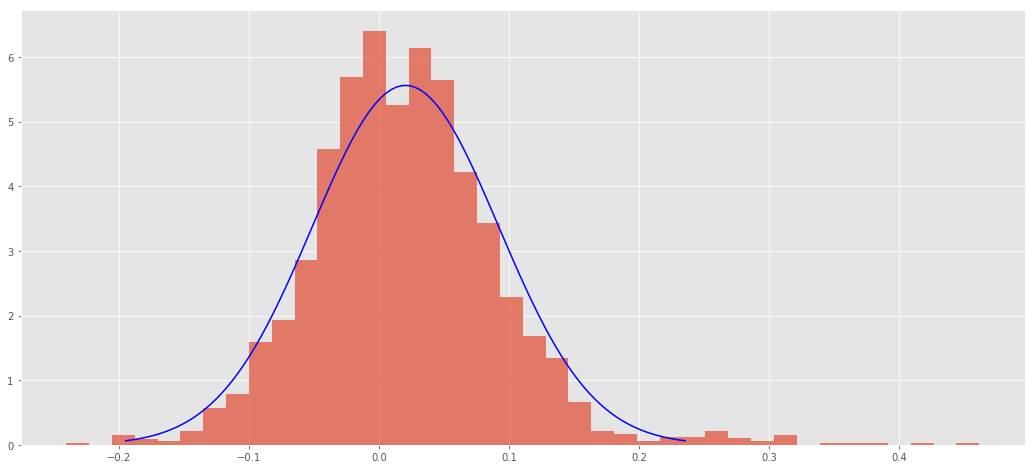

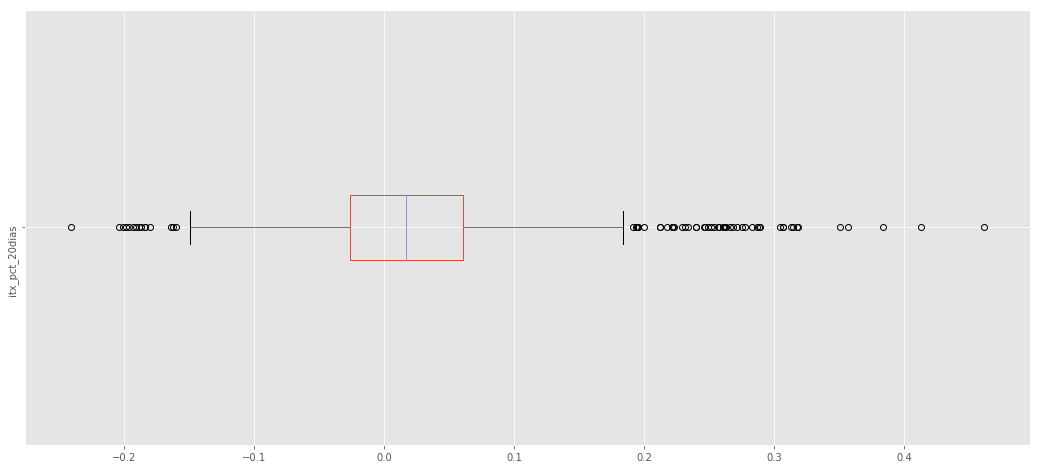

 el valor de 01p es : -0.13201 
 el valor de 05p es : -0.088743 
 el valor de 50p es : 0.016995 
 el valor de 95p es : 0.13449 
 el valor de T-test es : 14.418 
 el valor de avg es : 0.02 
 el valor de kur es : 2.4948 
 el valor de skw es : 0.67182 
 el valor de std es : 0.071742 
 el valor de val es : -1.5155 
 el valor de var es : 0.005147 


In [136]:
pepe=calculate_aggregate(f['itx_pct_20dias'])

<P>Podemos obtener para cada serie los distintos perfiles de cada serie y frecuencia, de manera gráfica

serie = san_pct_diario


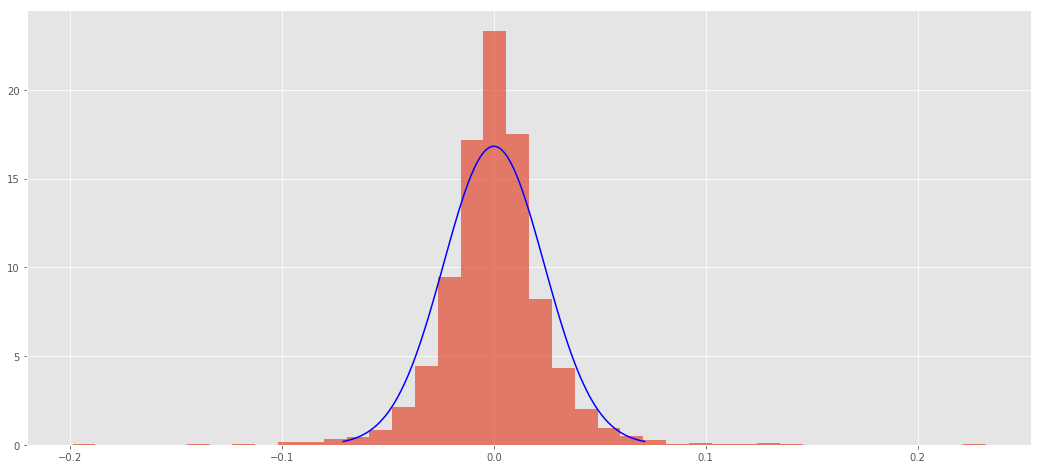

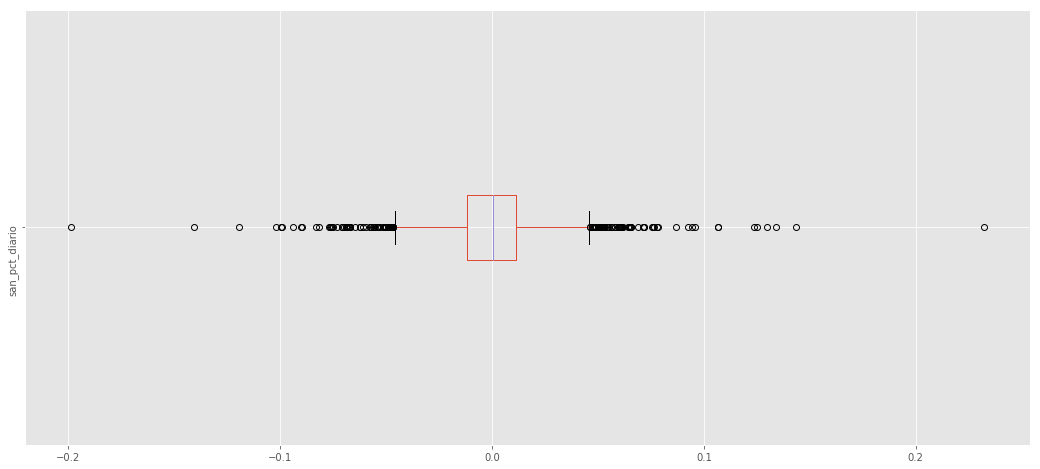

 el valor de 01p es : -0.066831 
 el valor de 05p es : -0.035149 
 el valor de 50p es : 0.00032929 
 el valor de 95p es : 0.036545 
 el valor de T-test es : 0.42498 
 el valor de avg es : 0.0 
 el valor de kur es : 8.66 
 el valor de skw es : 0.28607 
 el valor de std es : 0.023704 
 el valor de val es : -1.0397 
 el valor de var es : 0.00056186 
serie = san_pct_20dias


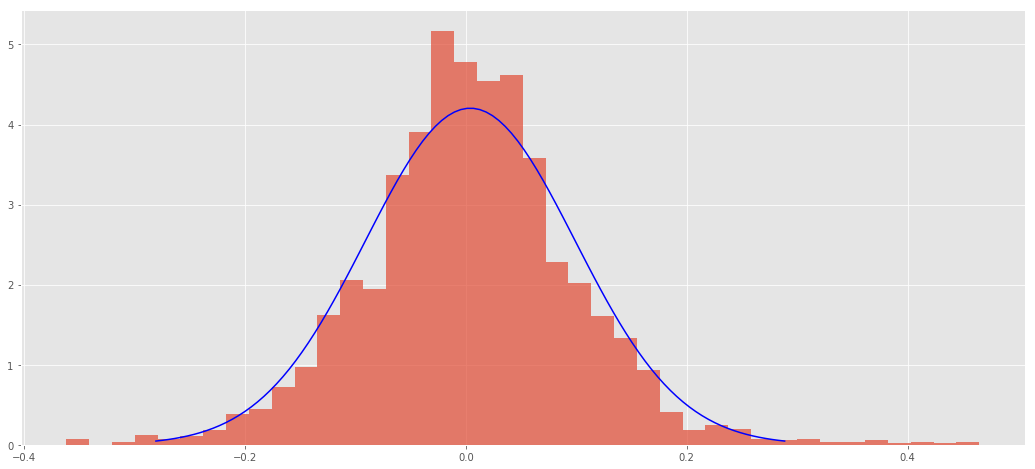

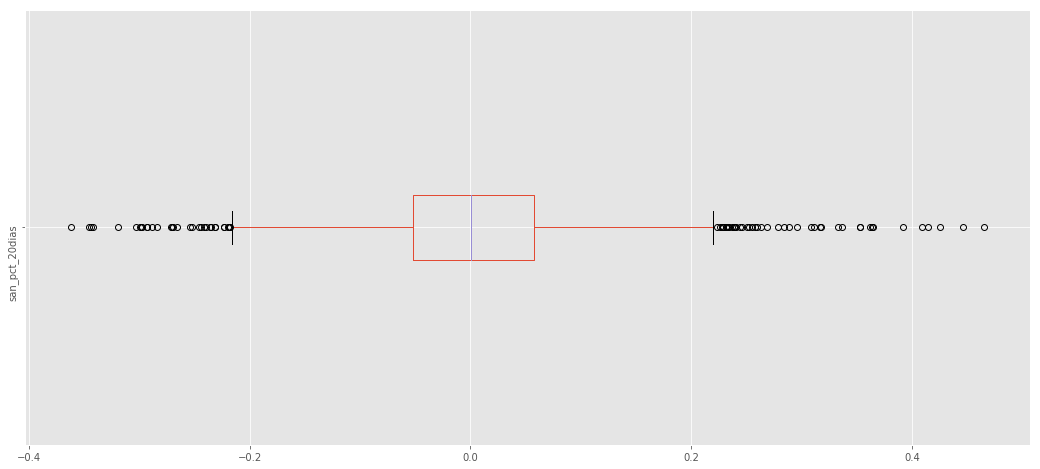

 el valor de 01p es : -0.22457 
 el valor de 05p es : -0.14813 
 el valor de 50p es : 0.00073482 
 el valor de 95p es : 0.15462 
 el valor de T-test es : 1.9241 
 el valor de avg es : 0.004 
 el valor de kur es : 1.5236 
 el valor de skw es : 0.19173 
 el valor de std es : 0.0949 
 el valor de val es : -1.0438 
 el valor de var es : 0.0090061 
serie = san_pct_60dias


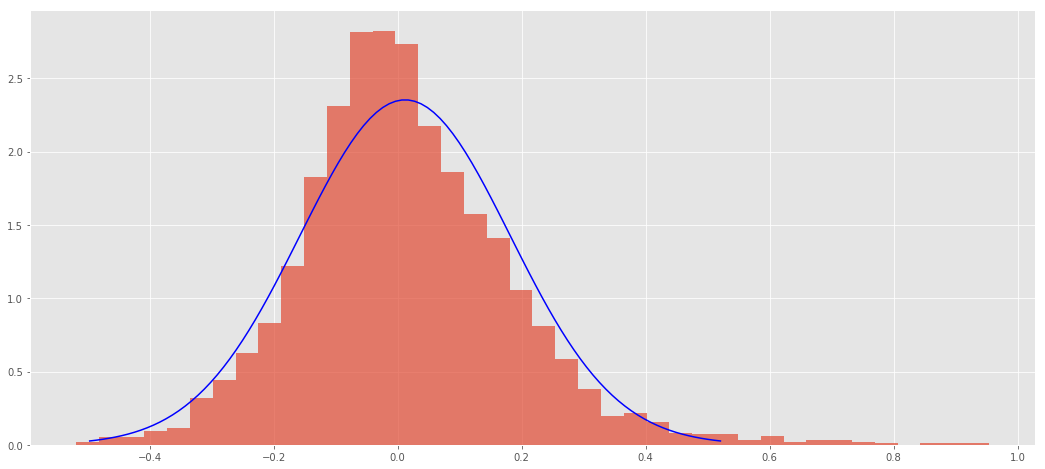

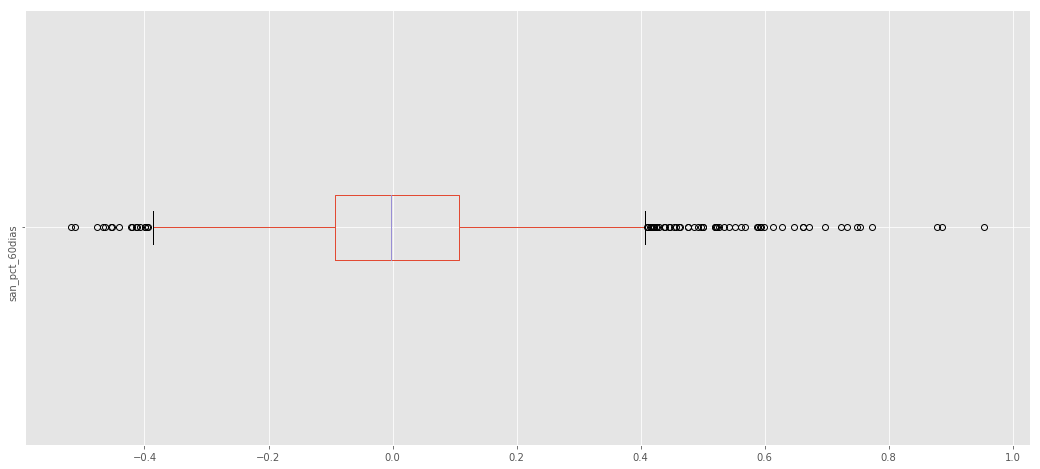

 el valor de 01p es : -0.34897 
 el valor de 05p es : -0.2427 
 el valor de 50p es : -0.0031884 
 el valor de 95p es : 0.29358 
 el valor de T-test es : 3.8265 
 el valor de avg es : 0.012 
 el valor de kur es : 2.0067 
 el valor de skw es : 0.68873 
 el valor de std es : 0.16953 
 el valor de val es : -1.2096 
 el valor de var es : 0.028742 
serie = san_pct_120dias


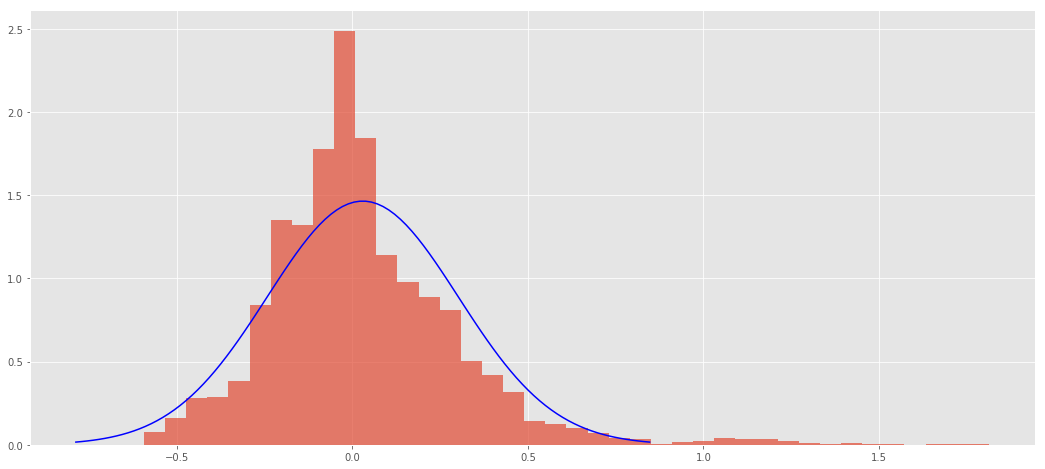

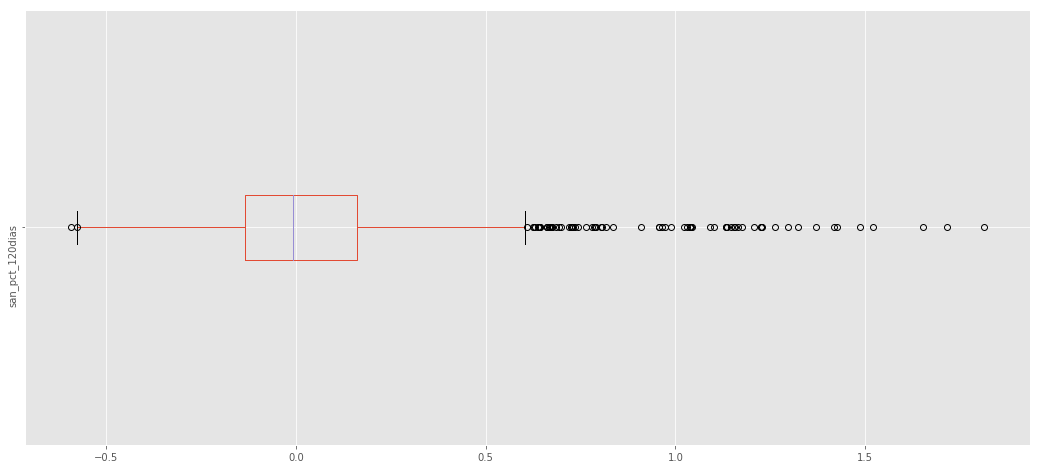

 el valor de 01p es : -0.49299 
 el valor de 05p es : -0.35039 
 el valor de 50p es : -0.0074795 
 el valor de 95p es : 0.4684 
 el valor de T-test es : 5.724 
 el valor de avg es : 0.03 
 el valor de kur es : 4.9666 
 el valor de skw es : 1.4195 
 el valor de std es : 0.27231 
 el valor de val es : -1.3368 
 el valor de var es : 0.074154 
serie = san_pct_220dias


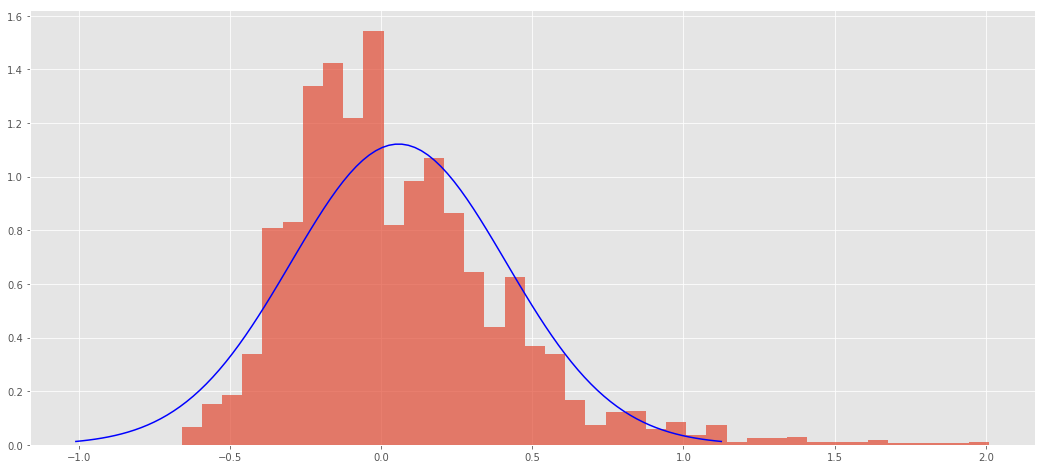

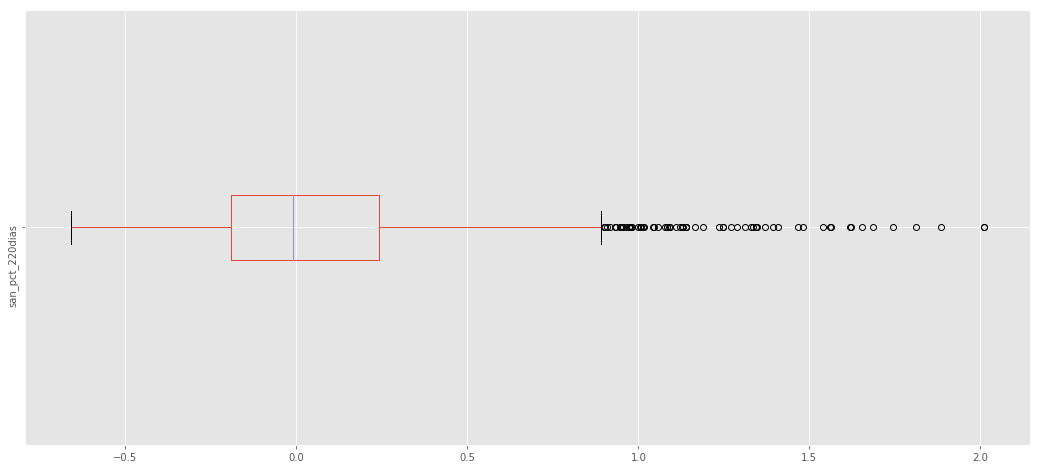

 el valor de 01p es : -0.56429 
 el valor de 05p es : -0.39158 
 el valor de 50p es : -0.010199 
 el valor de 95p es : 0.68057 
 el valor de T-test es : 8.4885 
 el valor de avg es : 0.058 
 el valor de kur es : 2.7713 
 el valor de skw es : 1.2229 
 el valor de std es : 0.35571 
 el valor de val es : -1.738 
 el valor de var es : 0.12653 
serie = itx_pct_diario


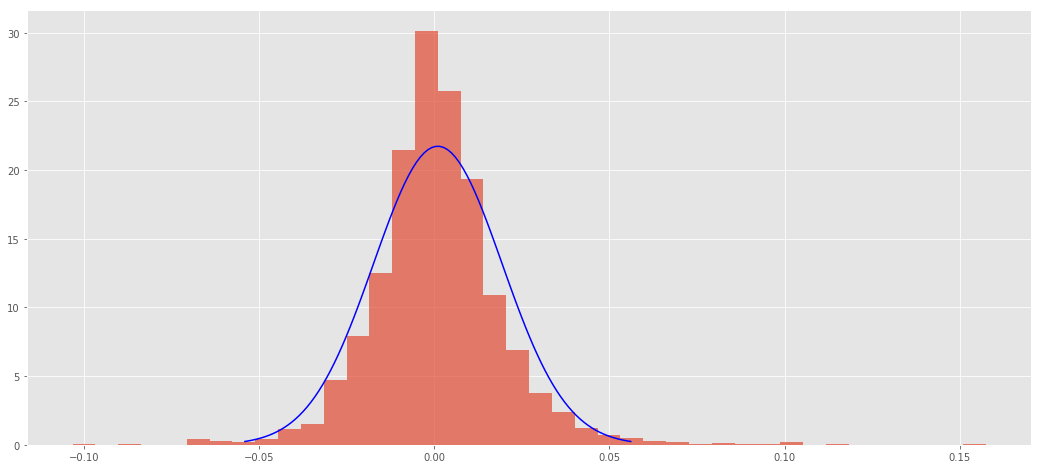

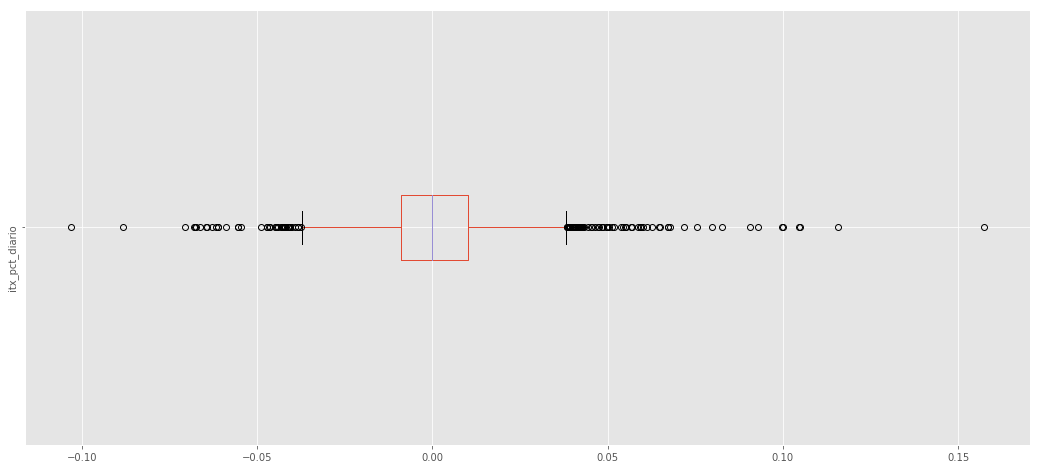

 el valor de 01p es : -0.043054 
 el valor de 05p es : -0.026111 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.029278 
 el valor de T-test es : 2.69 
 el valor de avg es : 0.001 
 el valor de kur es : 5.7752 
 el valor de skw es : 0.67499 
 el valor de std es : 0.018352 
 el valor de val es : -1.1213 
 el valor de var es : 0.00033679 
serie = itx_pct_20dias


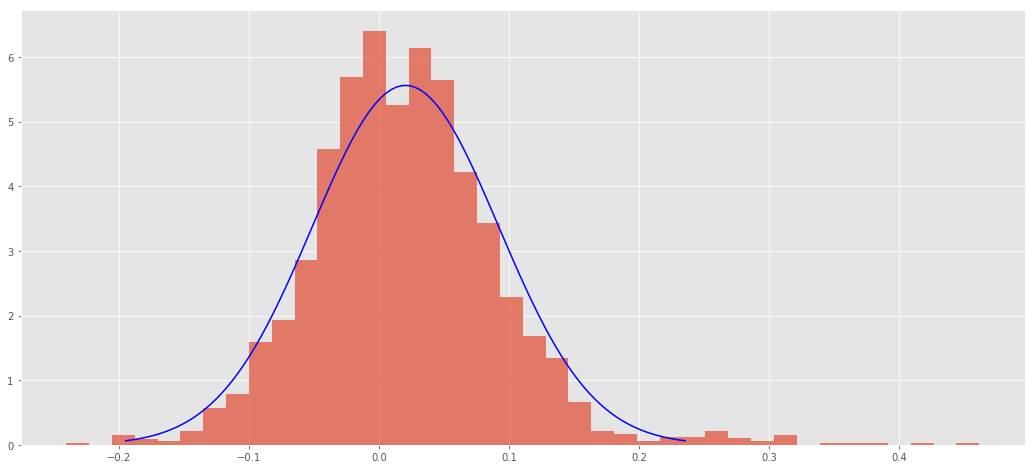

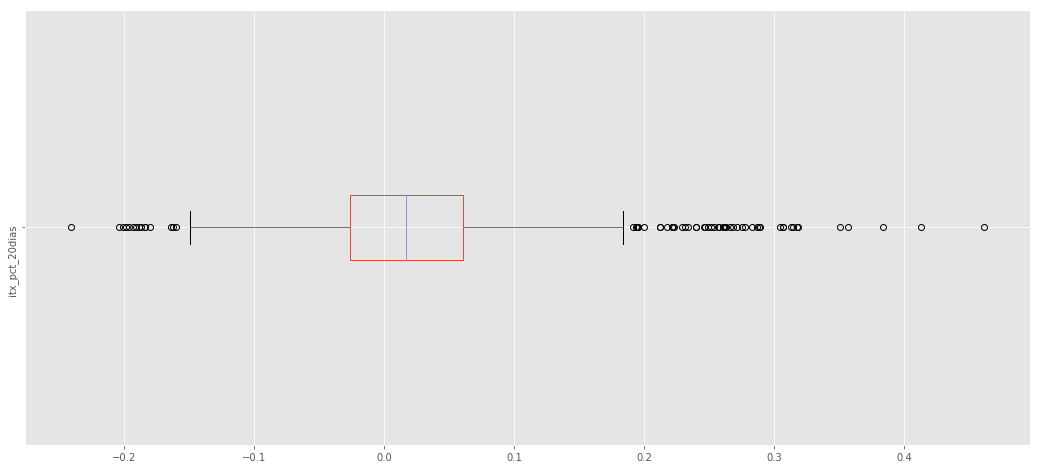

 el valor de 01p es : -0.13201 
 el valor de 05p es : -0.088743 
 el valor de 50p es : 0.016995 
 el valor de 95p es : 0.13449 
 el valor de T-test es : 14.418 
 el valor de avg es : 0.02 
 el valor de kur es : 2.4948 
 el valor de skw es : 0.67182 
 el valor de std es : 0.071742 
 el valor de val es : -1.5155 
 el valor de var es : 0.005147 
serie = itx_pct_60dias


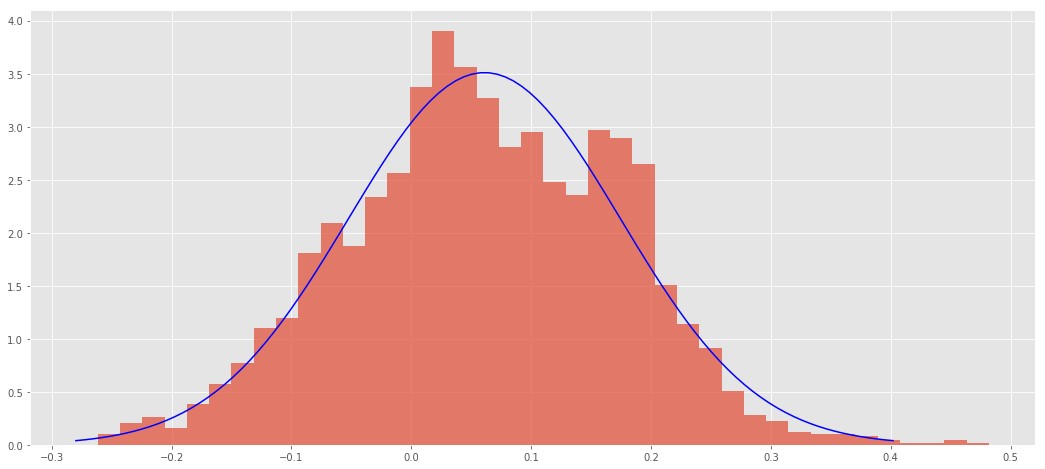

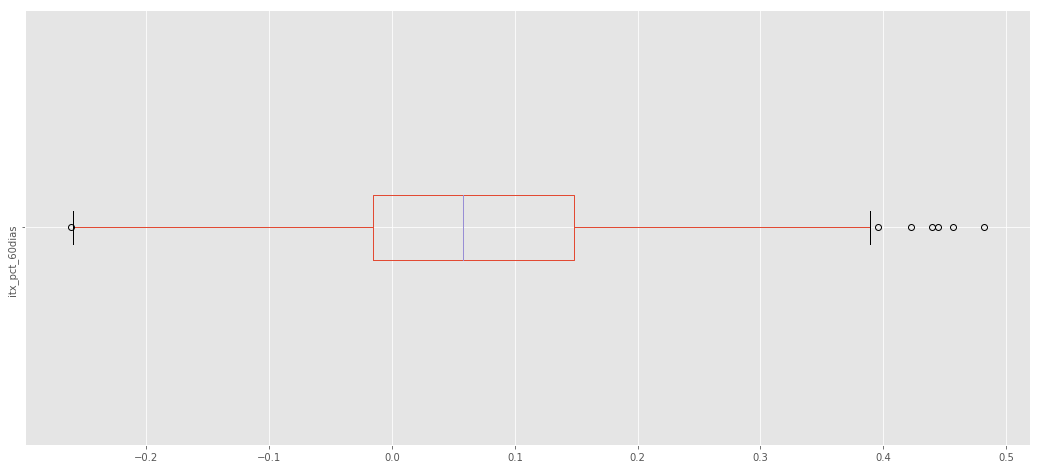

 el valor de 01p es : -0.20855 
 el valor de 05p es : -0.12564 
 el valor de 50p es : 0.057688 
 el valor de 95p es : 0.23461 
 el valor de T-test es : 27.81 
 el valor de avg es : 0.061 
 el valor de kur es : -0.15414 
 el valor de skw es : -0.016551 
 el valor de std es : 0.11364 
 el valor de val es : -1.8673 
 el valor de var es : 0.012913 
serie = itx_pct_120dias


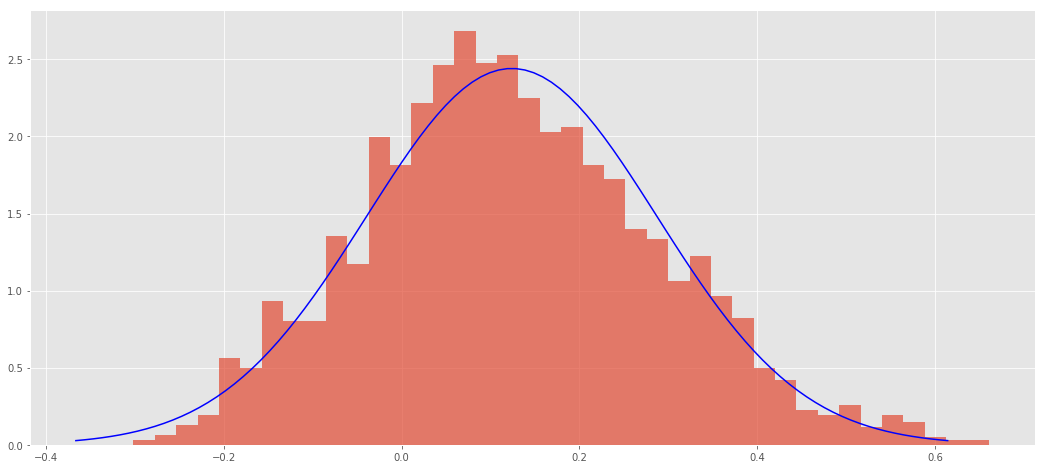

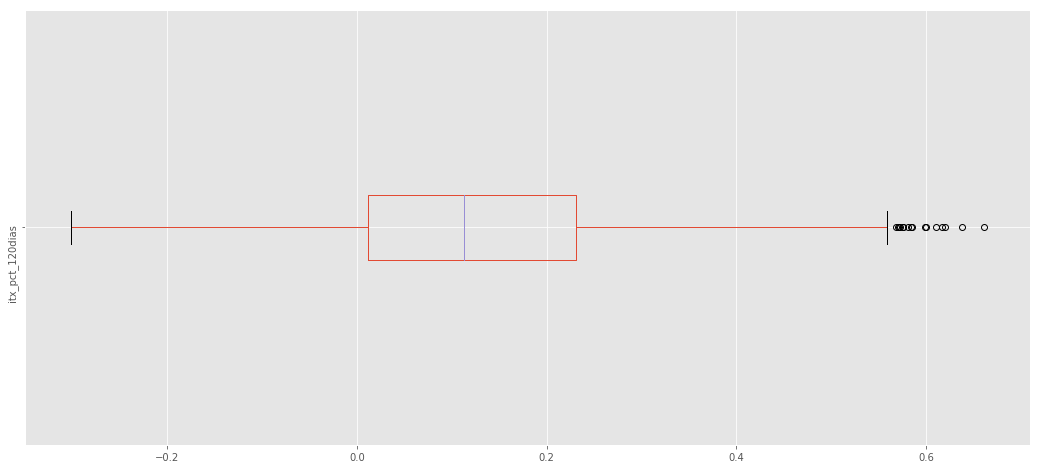

 el valor de 01p es : -0.20431 
 el valor de 05p es : -0.14056 
 el valor de 50p es : 0.113 
 el valor de 95p es : 0.39937 
 el valor de T-test es : 39.312 
 el valor de avg es : 0.124 
 el valor de kur es : -0.14483 
 el valor de skw es : 0.26422 
 el valor de std es : 0.16345 
 el valor de val es : -2.8412 
 el valor de var es : 0.026717 
serie = itx_pct_220dias


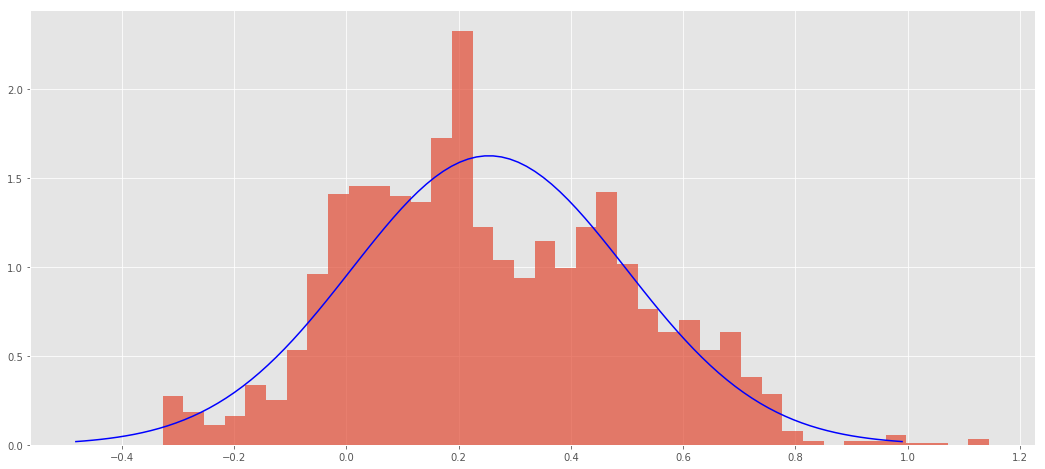

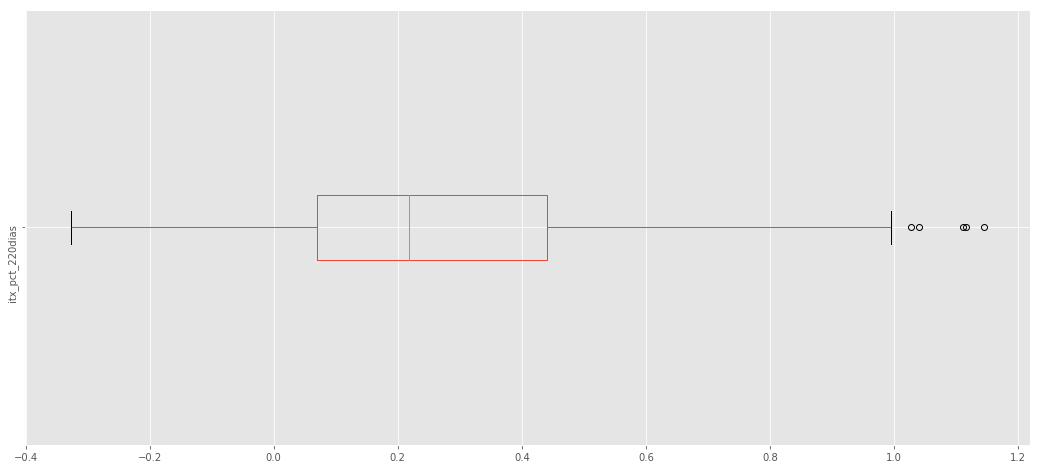

 el valor de 01p es : -0.29007 
 el valor de 05p es : -0.1033 
 el valor de 50p es : 0.21802 
 el valor de 95p es : 0.67891 
 el valor de T-test es : 53.841 
 el valor de avg es : 0.254 
 el valor de kur es : -0.31878 
 el valor de skw es : 0.24048 
 el valor de std es : 0.24527 
 el valor de val es : -6.5724 
 el valor de var es : 0.06016 
serie = tef_pct_diario


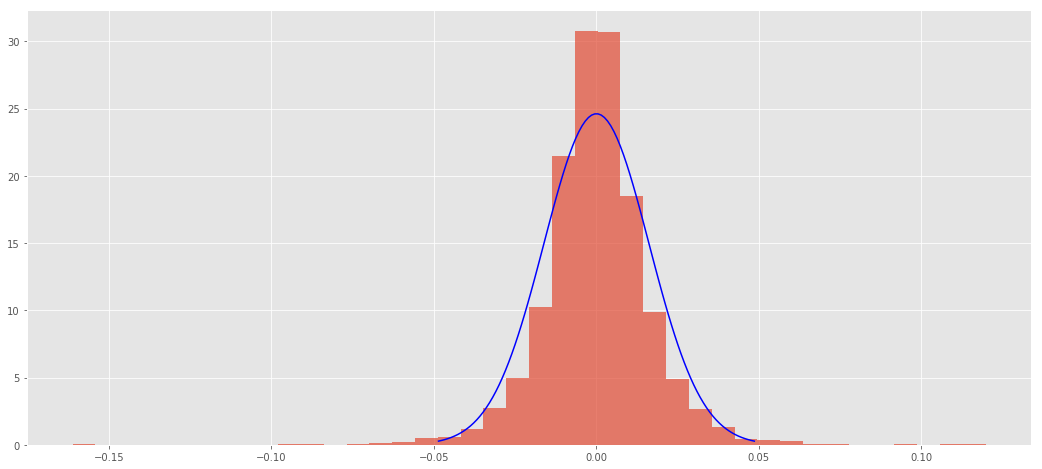

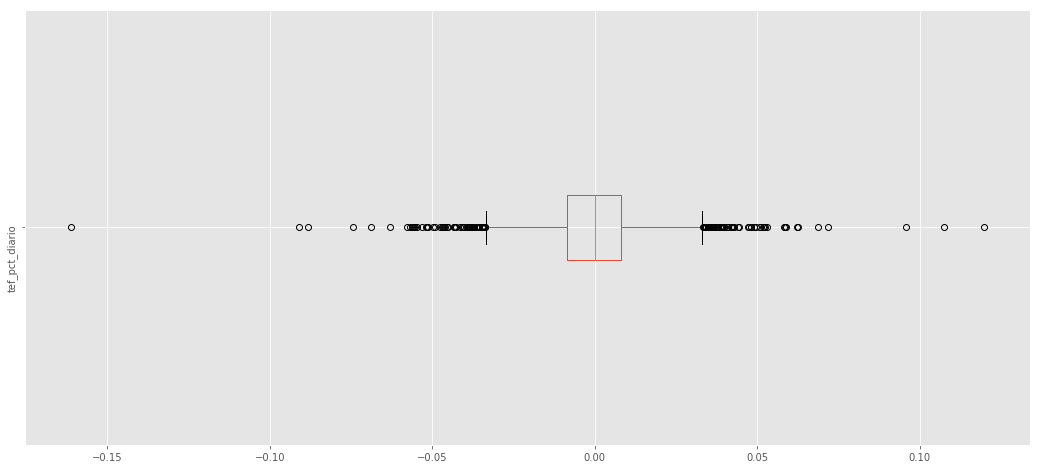

 el valor de 01p es : -0.043169 
 el valor de 05p es : -0.024528 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.025116 
 el valor de T-test es : 0.023325 
 el valor de avg es : 0.0 
 el valor de kur es : 7.6242 
 el valor de skw es : -0.16625 
 el valor de std es : 0.0162 
 el valor de val es : -1.024 
 el valor de var es : 0.00026243 
serie = tef_pct_20dias


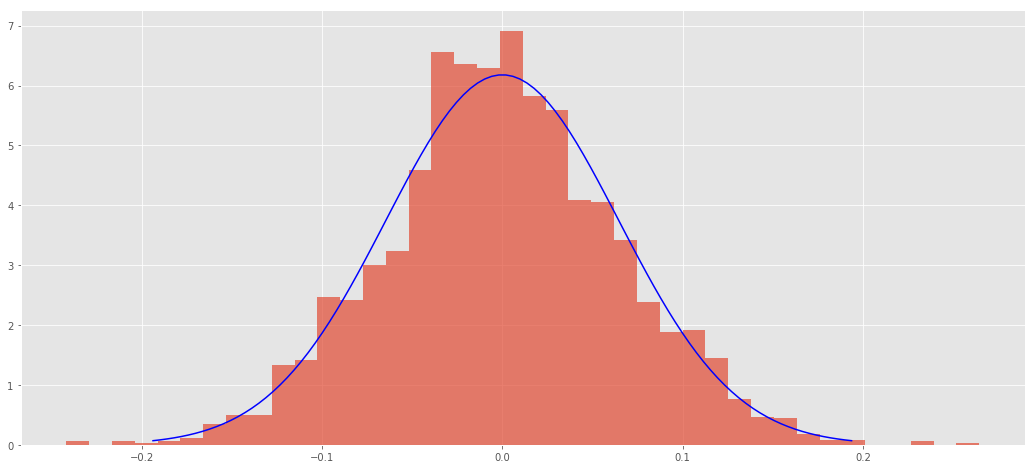

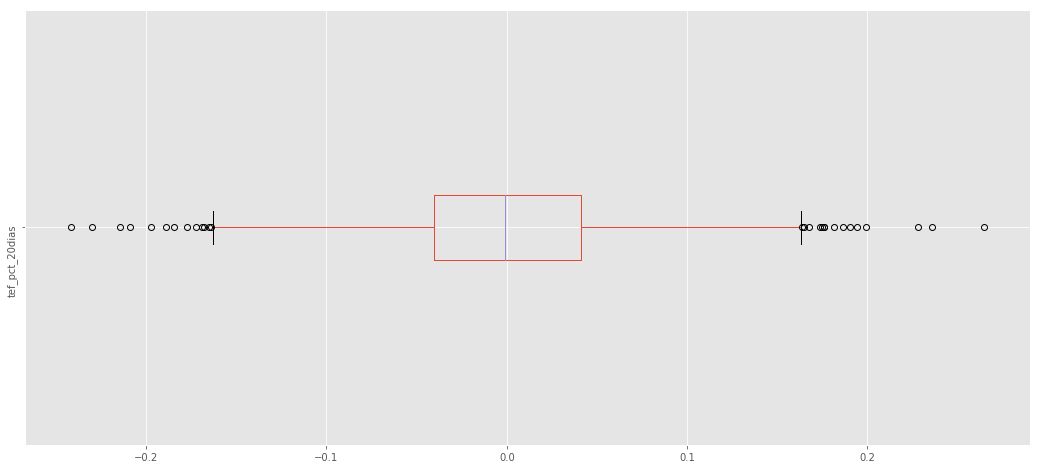

 el valor de 01p es : -0.14687 
 el valor de 05p es : -0.10622 
 el valor de 50p es : -0.0012074 
 el valor de 95p es : 0.10831 
 el valor de T-test es : -0.1853 
 el valor de avg es : -0.0 
 el valor de kur es : 0.19022 
 el valor de skw es : 0.05301 
 el valor de std es : 0.064564 
 el valor de val es : -1.0197 
 el valor de var es : 0.0041685 
serie = tef_pct_60dias


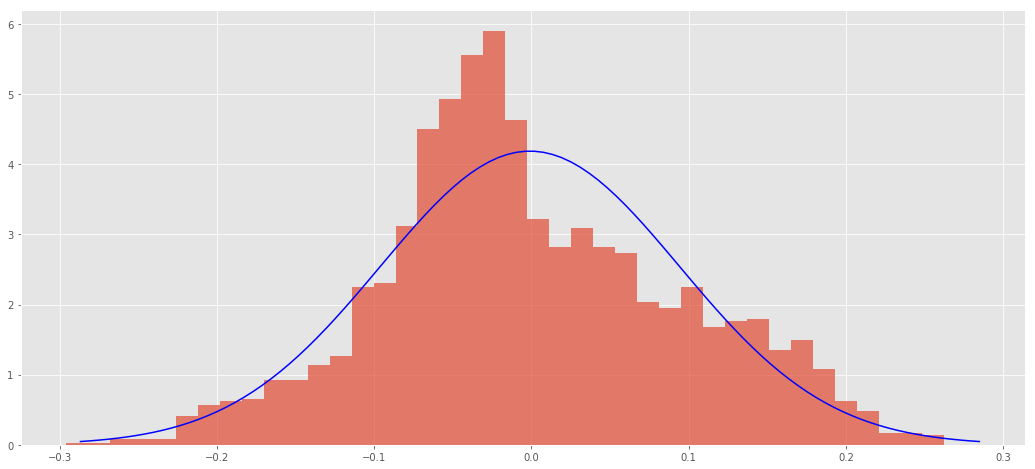

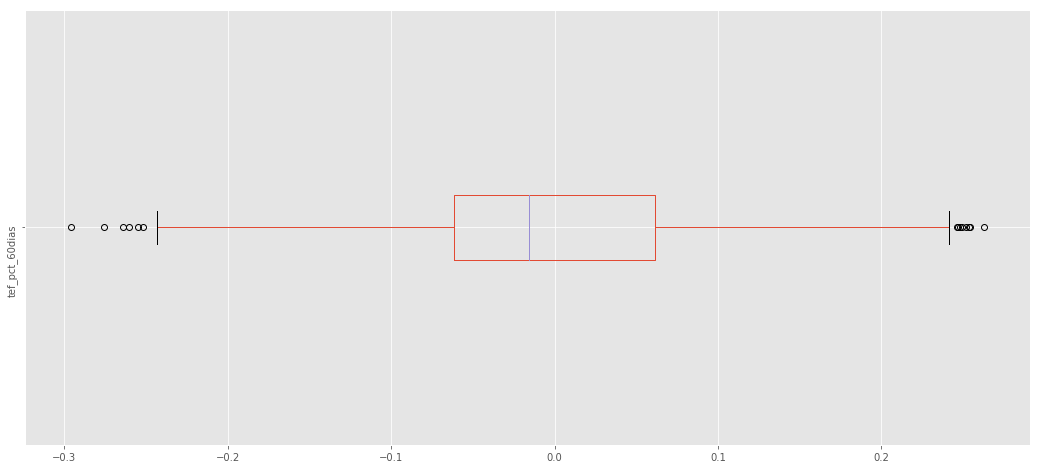

 el valor de 01p es : -0.21069 
 el valor de 05p es : -0.152 
 el valor de 50p es : -0.015401 
 el valor de 95p es : 0.16953 
 el valor de T-test es : -0.46154 
 el valor de avg es : -0.001 
 el valor de kur es : -0.22059 
 el valor de skw es : 0.19999 
 el valor de std es : 0.095287 
 el valor de val es : -1.1153 
 el valor de var es : 0.0090797 
serie = tef_pct_120dias


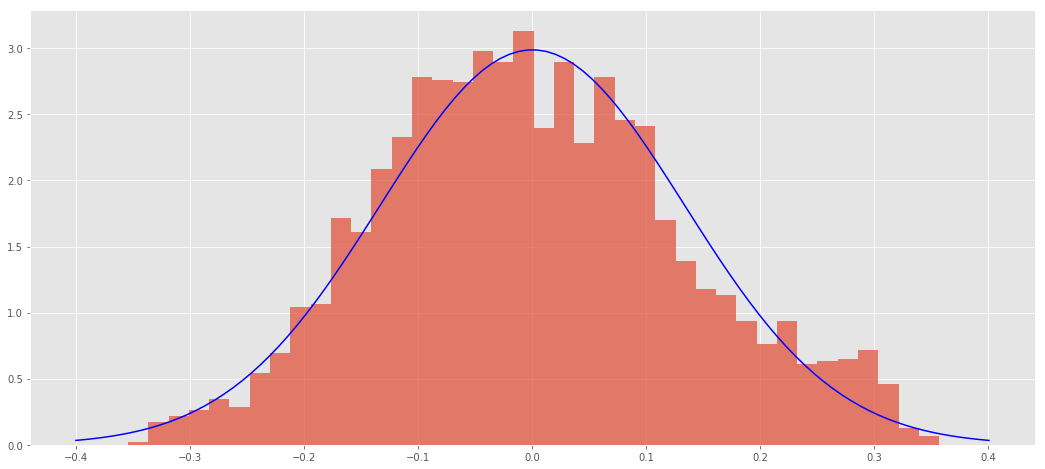

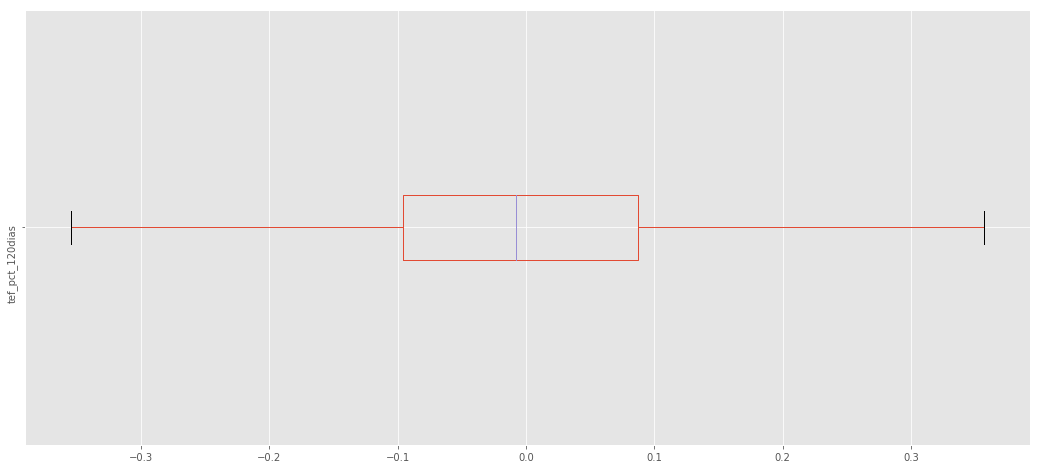

 el valor de 01p es : -0.29463 
 el valor de 05p es : -0.20597 
 el valor de 50p es : -0.0079816 
 el valor de 95p es : 0.24393 
 el valor de T-test es : -0.033749 
 el valor de avg es : -0.0 
 el valor de kur es : -0.30262 
 el valor de skw es : 0.2021 
 el valor de std es : 0.1335 
 el valor de val es : -1.1843 
 el valor de var es : 0.017823 
serie = tef_pct_220dias


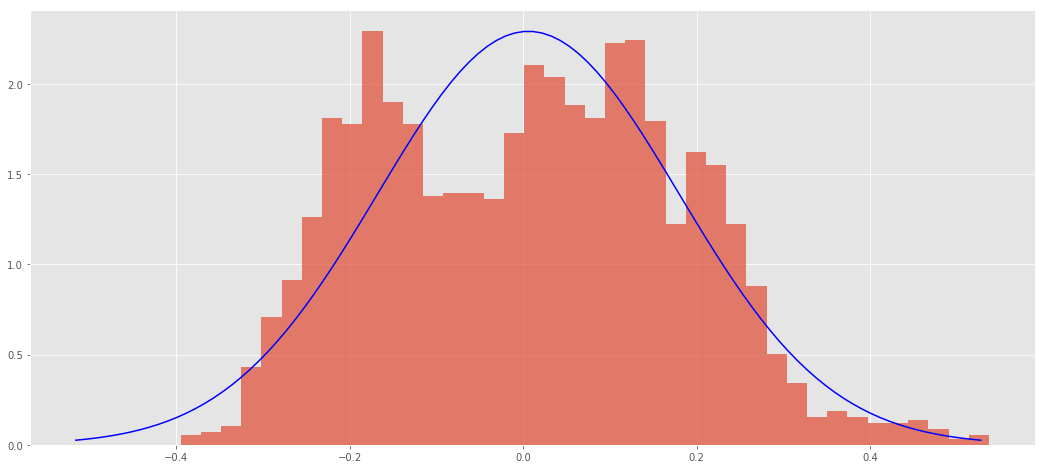

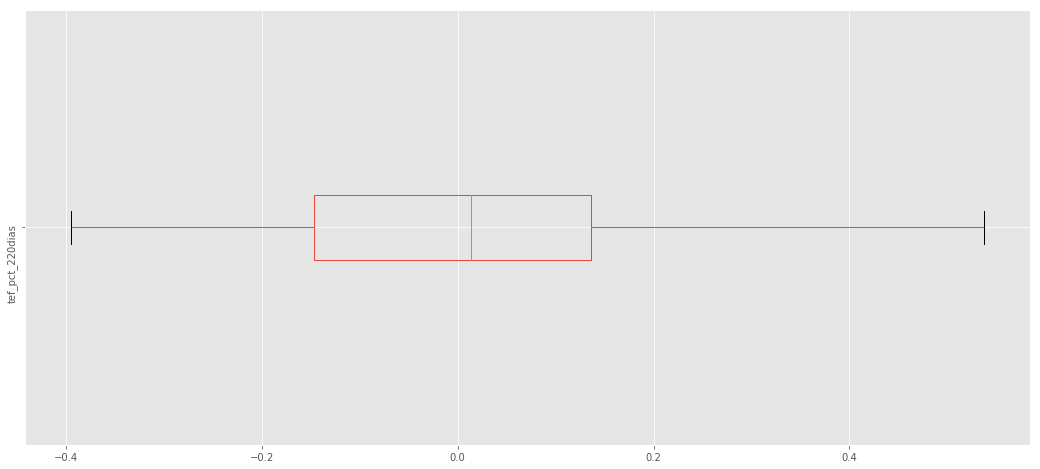

 el valor de 01p es : -0.31054 
 el valor de 05p es : -0.25824 
 el valor de 50p es : 0.013958 
 el valor de 95p es : 0.27302 
 el valor de T-test es : 1.698 
 el valor de avg es : 0.006 
 el valor de kur es : -0.70178 
 el valor de skw es : 0.13989 
 el valor de std es : 0.17399 
 el valor de val es : -1.0572 
 el valor de var es : 0.030274 


In [137]:
ccoco=f.filter(like='_pct',axis=1).columns.values
var95hist={}
for n in ccoco:
    soso="{}".format(n)
    #soso.append(n)
    #printsoso
    print ('serie =',soso)
    var95hist[soso]=calculate_aggregate(f[soso])


<h3>Tabla del var95 al 10%</h3>

In [138]:
#var95hist['05p']
for n in sorted(var95hist.keys()):
    print (n,'      ',var95hist[n]['05p'])

itx_pct_120dias        -0.140564007944
itx_pct_20dias        -0.0887432705505
itx_pct_220dias        -0.103295708275
itx_pct_60dias        -0.125641269509
itx_pct_diario        -0.0261107417136
san_pct_120dias        -0.350389112217
san_pct_20dias        -0.148129046161
san_pct_220dias        -0.391582188065
san_pct_60dias        -0.242701839515
san_pct_diario        -0.0351487249825
tef_pct_120dias        -0.205972400249
tef_pct_20dias        -0.106216242294
tef_pct_220dias        -0.258244960466
tef_pct_60dias        -0.151999473558
tef_pct_diario        -0.0245280323676


<h3>Tabla de cada serie y su respectiva frecuencia</h3>

In [139]:
histvar95=pd.DataFrame(var95hist)
np.round(histvar95.T,3)

01p    05p    50p    95p  T-test    avg    kur    skw  \
itx_pct_120dias -0.204 -0.141  0.113  0.399  39.312  0.124 -0.145  0.264   
itx_pct_20dias  -0.132 -0.089  0.017  0.134  14.418  0.020  2.495  0.672   
itx_pct_220dias -0.290 -0.103  0.218  0.679  53.841  0.254 -0.319  0.240   
itx_pct_60dias  -0.209 -0.126  0.058  0.235  27.810  0.061 -0.154 -0.017   
itx_pct_diario  -0.043 -0.026  0.000  0.029   2.690  0.001  5.775  0.675   
san_pct_120dias -0.493 -0.350 -0.007  0.468   5.724  0.030  4.967  1.420   
san_pct_20dias  -0.225 -0.148  0.001  0.155   1.924  0.004  1.524  0.192   
san_pct_220dias -0.564 -0.392 -0.010  0.681   8.489  0.058  2.771  1.223   
san_pct_60dias  -0.349 -0.243 -0.003  0.294   3.827  0.012  2.007  0.689   
san_pct_diario  -0.067 -0.035  0.000  0.037   0.425  0.000  8.660  0.286   
tef_pct_120dias -0.295 -0.206 -0.008  0.244  -0.034 -0.000 -0.303  0.202   
tef_pct_20dias  -0.147 -0.106 -0.001  0.108  -0.185 -0.000  0.190  0.053   
tef_pct_220dias -0.311 -0.258  0.014  0.273   1.698  0.006 -0.702  0.140   
tef_pct_60dias  -0.211 -0.152 -0.015  0.170  -0.462 -0.001 -0.221  0.200   
tef_pct_diario  -0.043 -0.025  0.000  0.025   0.023  0.000  7.624 -0.166   

                   std    val    var  
itx_pct_120dias  0.163 -2.841  0.027  
itx_pct_20dias   0.072 -1.515  0.005  
itx_pct_220dias  0.245 -6.572  0.060  
itx_pct_60dias   0.114 -1.867  0.013  
itx_pct_diario   0.018 -1.121  0.000  
san_pct_120dias  0.272 -1.337  0.074  
san_pct_20dias   0.095 -1.044  0.009  
san_pct_220dias  0.356 -1.738  0.127  
san_pct_60dias   0.170 -1.210  0.029  
san_pct_diario   0.024 -1.040  0.001  
tef_pct_120dias  0.134 -1.184  0.018  
tef_pct_20dias   0.065 -1.020  0.004  
tef_pct_220dias  0.174 -1.057  0.030  
tef_pct_60dias   0.095 -1.115  0.009  
tef_pct_diario   0.016 -1.024  0.000

---

<p>También podemos ver límites en los que sabemos que esta roto el comportamiento de nuestra serie. Por ejemplo, en todas las series anteriores con kurtosis negativa, tenemos un mínimo donde dejamos de operar la serie.

<p>En este caso podemos decir, que si perdemos mas de un 30% en itx dejaremos de operar la serie, en cambio no asi con san o tef

<h4>Gráfico kurtosis anual de santander</h4>

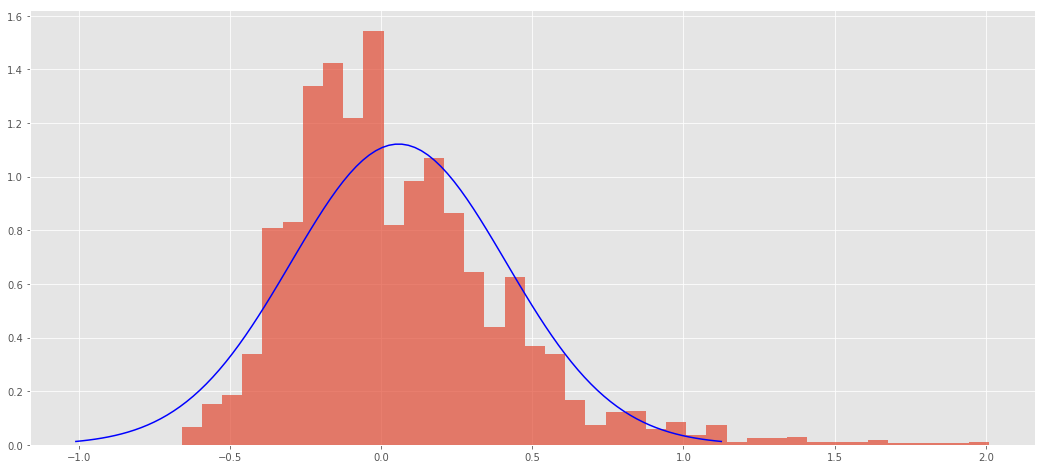

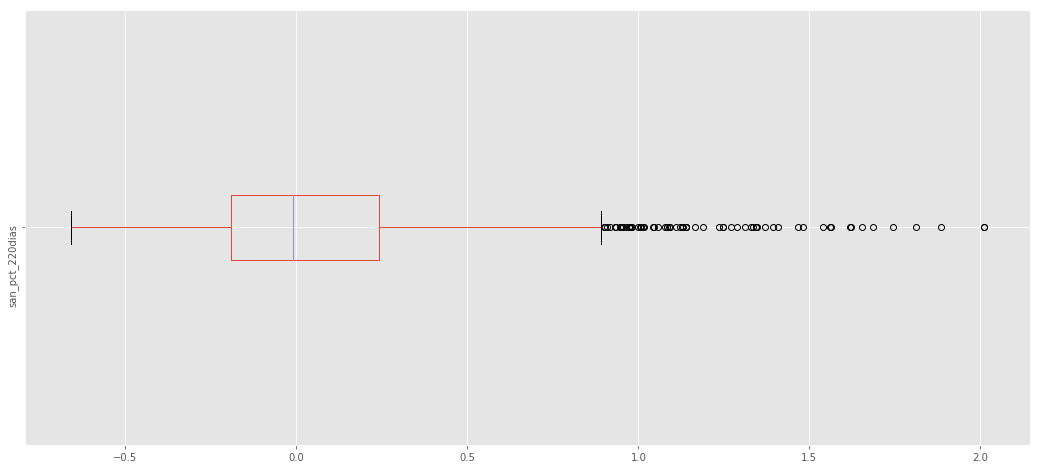

 el valor de 01p es : -0.56429 
 el valor de 05p es : -0.39158 
 el valor de 50p es : -0.010199 
 el valor de 95p es : 0.68057 
 el valor de T-test es : 8.4885 
 el valor de avg es : 0.058 
 el valor de kur es : 2.7713 
 el valor de skw es : 1.2229 
 el valor de std es : 0.35571 
 el valor de val es : -1.738 
 el valor de var es : 0.12653 


In [140]:
pepe=calculate_aggregate(f['san_pct_220dias'])

<h4>Gráfico de itx de kurtosis anual </h4>

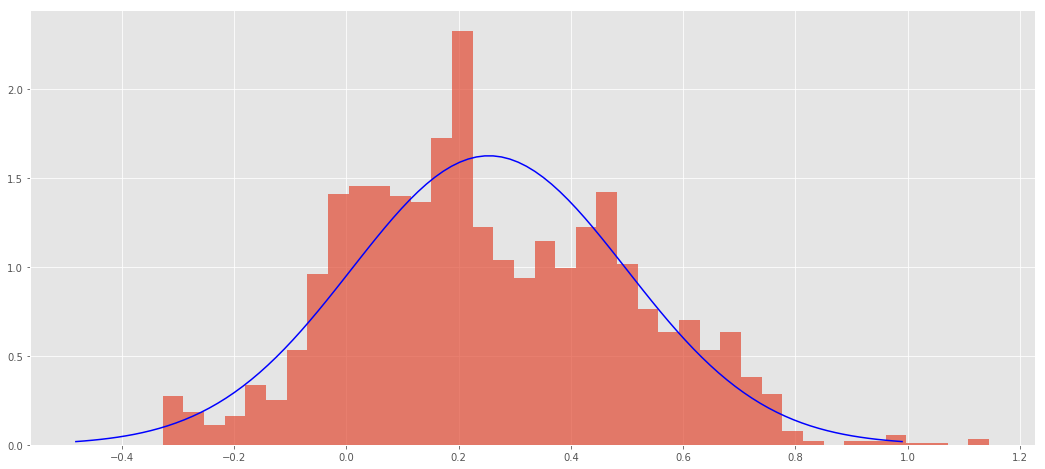

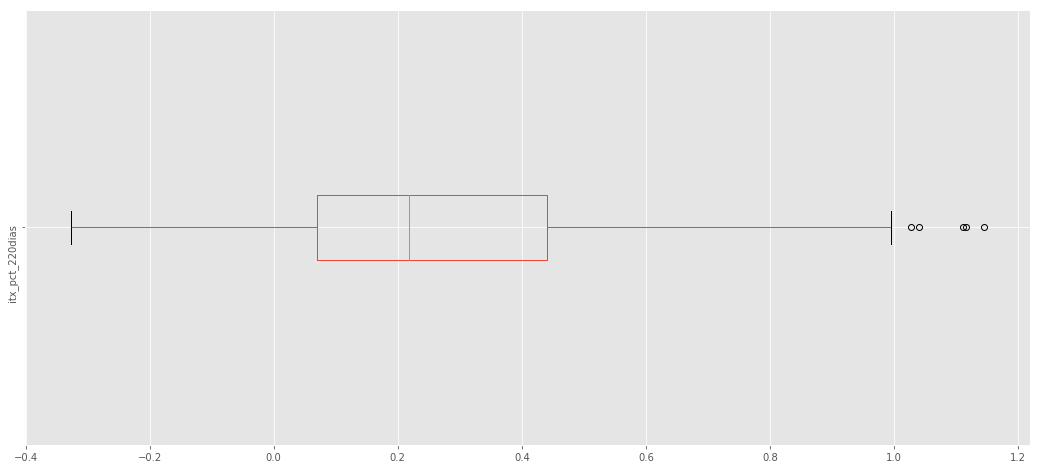

 el valor de 01p es : -0.29007 
 el valor de 05p es : -0.1033 
 el valor de 50p es : 0.21802 
 el valor de 95p es : 0.67891 
 el valor de T-test es : 53.841 
 el valor de avg es : 0.254 
 el valor de kur es : -0.31878 
 el valor de skw es : 0.24048 
 el valor de std es : 0.24527 
 el valor de val es : -6.5724 
 el valor de var es : 0.06016 


In [141]:
pepe=calculate_aggregate(f['itx_pct_220dias'])

<h4>Gráfico de la kurtosis de telefónica</h4>

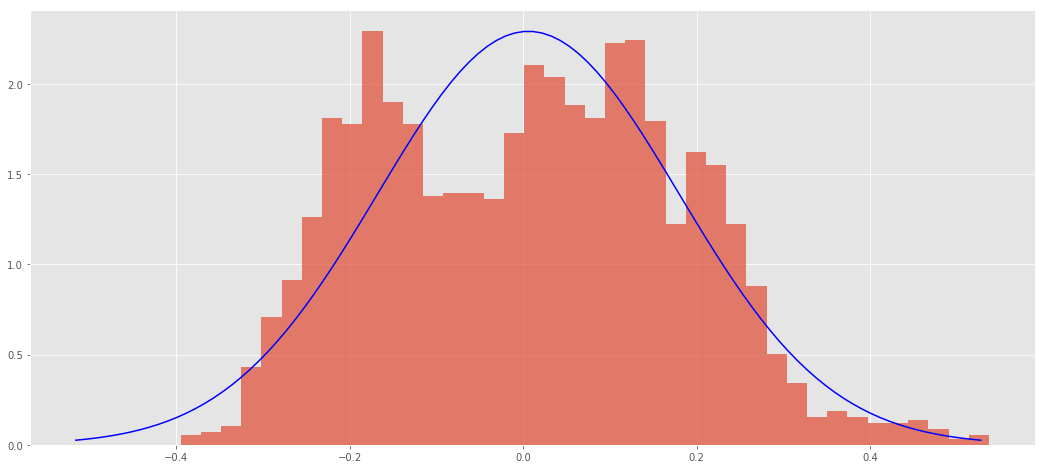

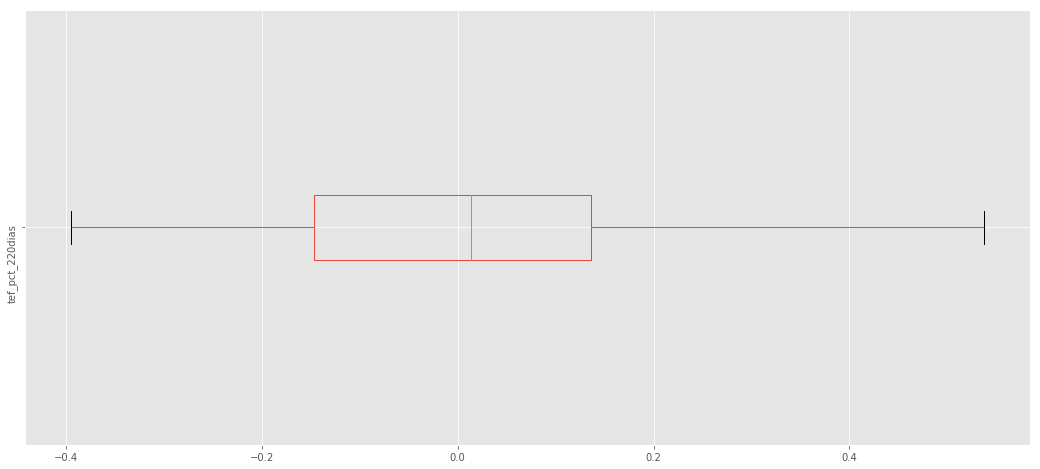

 el valor de 01p es : -0.31054 
 el valor de 05p es : -0.25824 
 el valor de 50p es : 0.013958 
 el valor de 95p es : 0.27302 
 el valor de T-test es : 1.698 
 el valor de avg es : 0.006 
 el valor de kur es : -0.70178 
 el valor de skw es : 0.13989 
 el valor de std es : 0.17399 
 el valor de val es : -1.0572 
 el valor de var es : 0.030274 


In [142]:
pepe=calculate_aggregate(f['tef_pct_220dias'])

# Calulo del VaR con el método Monte Carlo

El método estadístico o paramétrico de calculo del Value at Risk, suele asumir la normalidad de los rendimientos. Pero la distribución normal no siempre es un buen ajuste para la distribución de los retornos.

Podemos conseguir un mejor ajuste usando una distribución Johnson SU, debido a que esta distribución, con sus 4 parametros, puede ajustarse a cualquier combinación de kurtosis y skewness, que se encuentre por debajo de una distribución lognormal.

Podemos verlo mas claramente con unas gráficas.

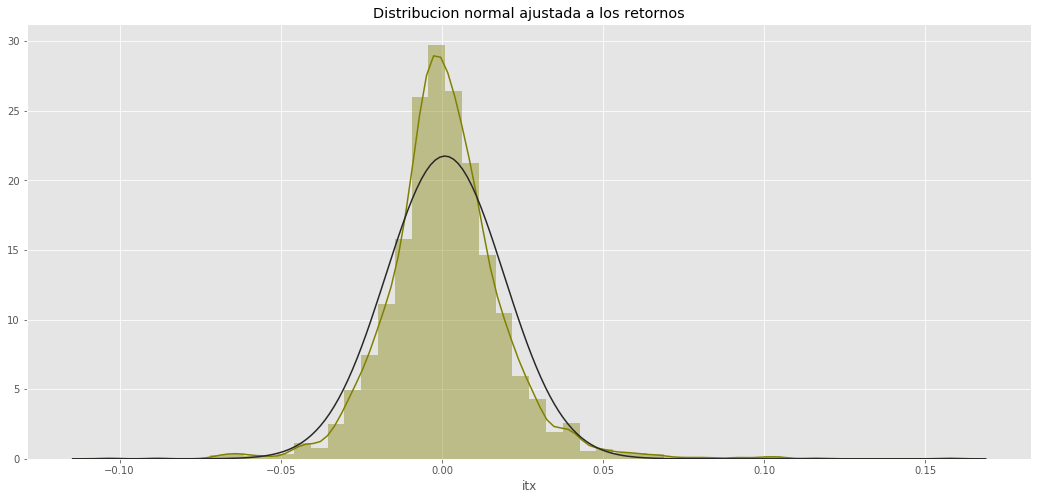

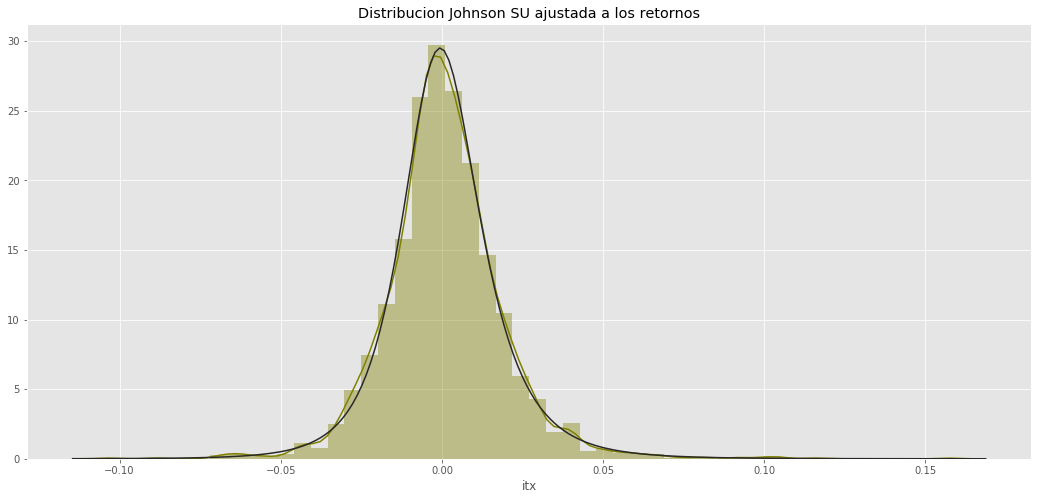

In [143]:
# import analisis
# import seaborn as sns
from scipy import stats
rets = f.itx.pct_change().dropna()
sns.distplot(rets, fit=stats.norm, kde=True, color='olive')
plt.title('Distribucion normal ajustada a los retornos')
plt.show()
sns.distplot(rets, fit=stats.johnsonsu, kde=True, color='olive')
plt.title('Distribucion Johnson SU ajustada a los retornos')
plt.show()

Una vez calculados los parametros de la distribución Johnson SU que ajusta nuestra distribución de retornos históricos, podemos simular una serie aleatoria futura que cumpla con esta distribución. 

Si hacemos un número suficientemente grande de simulaciones y tomamos los retornos relativos que arrojan al final del periodo propuesto, podemos obtener un VaR estimado futuro para un indice de confianza dado. 

Esto no es otra cosa que usar el método Monte Carlo para el calculo del VaR. 

Veamoslo en funcionamiento, para lo cual definimos una función que realiza el proceso explicado.

In [144]:
def var_montecarlo (prices, n_sims = 2000, ci=0.95, steps = 22, plot=False, ret_sims=False):
    
    # Calcula los parametros para ajustar la distribución a la serie de retornos históricos
    params = stats.johnsonsu.fit(prices.pct_change().dropna())
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Simulamos los retornos futuros según la distribución ajustada y calcula los precios futuros.
    simulations = pd.DataFrame()
    for sim in range(n_sims):
        jrets = stats.johnsonsu.rvs(loc=loc, scale=scale, *arg, size=steps)
        mc_price =  np.cumprod(jrets + 1) * prices.iloc[-1]
        mc_price = np.insert(mc_price,0, prices.iloc[-1])
        simulations[sim] = mc_price
    
    # Obtenemos los retornos relativos finales, y tomamos el cuantil que se ajusta al indice de confianza dado.
    ret_mes = (simulations.iloc[-1] / simulations.iloc[0]) - 1 
    var_mc = -round(ret_mes.quantile(1 - ci),6)
    
    # Grafica los precios futuros en caso de que se solicite.
    if plot:
        simulations.plot(legend=False, alpha=0.5)
        plt.title('Simulaciones de precios futuros'.upper(), fontsize=18, color='brown')
        plt.text(0, 21, 'El VaR 95 mensual por el metodo Monte Carlo es de {}%'.format(round(var_mc*100,2)), 
                 fontsize=16, color='navy')
        plt.show()
        
        sns.distplot((simulations.iloc[-1]/simulations.iloc[0])-1 , kde=True, color='darkolivegreen')
        plt.title('Distribucion de los retornos finales simulados'.upper(), fontsize=18, color='brown')
        plt.vlines(-var_mc, 0,2, linestyle='dashed', color='crimson')
        plt.text(-var_mc-0.1,2.2,'VaR 95 = {:.2f}%'.format(var_mc*100), fontsize=15, color='navy' )
        plt.show()
    
    # Retorna el VaR calculado, y opcionalmente el dataframe con las simulaciones.
    if ret_sims:
        return var_mc, simulations
    else:
        return var_mc

Simularemos los retornos de Inditex para el mes a partir del último precio de la seríe histórica que estamos estudiando, y obtendremos el VaR 95 mensual.

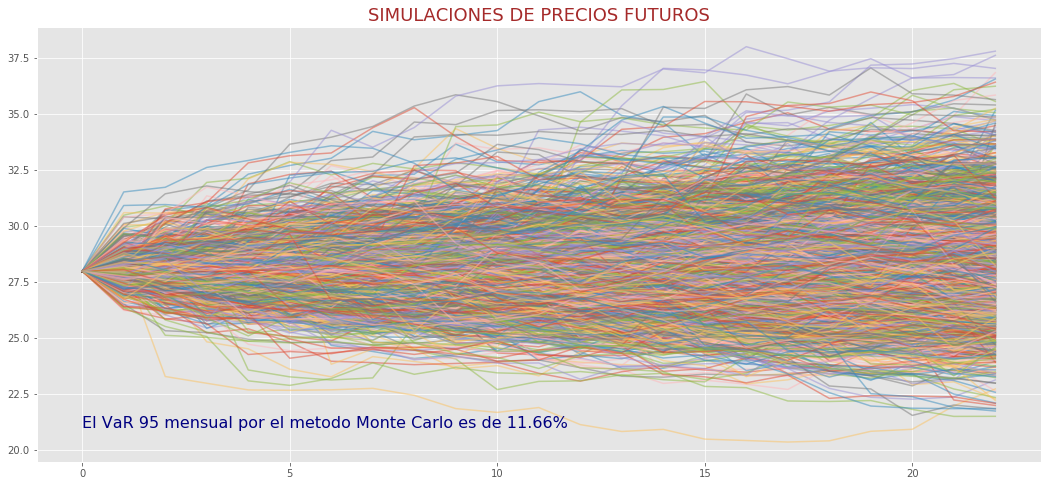

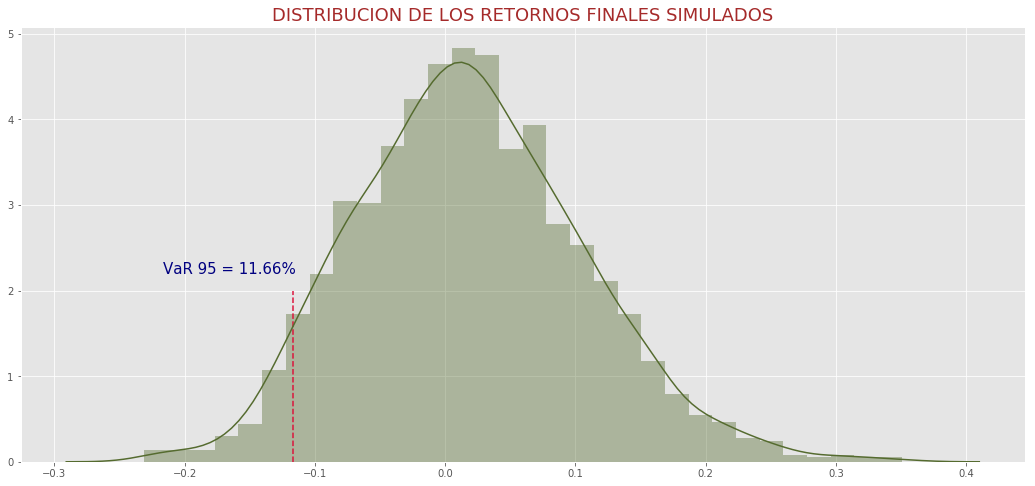

In [145]:
var, sims = var_montecarlo (f.itx, ret_sims=True, plot=True, n_sims=2000)

Vamos a calcular el VaR 95 mensual por el metódo paramétrico para compararlo.

In [146]:
var_e = var_estadistico(f.itx, time='M')

El VaR 95 para los retornos analizados con un frequencia M es del 8.17%


Podemos comprobar como el VaR calculado por el método Monte Carlo ofrece una perdida superior a la calculada por el paramétrico. 

Esto es debido al diferente ajuste de la distribución Johnson SU.

---

<H1>Conclusión</h1>

<li>Nos permite ver que distribución se está comportando mejor</li>
<li>Nos permite dibujar cual es el periodo en drawdown o por debajo de cero, de las diferentes distribuciones en funcion de su frecuencia</li>
<li>Podemos tener un mínimo de la distribución en el que podemos considerar que nuestra distribución se comporta de manera diferente.

# Cruce de medias

In [147]:
def ma_crossover(values,larga=20,corta=10):
#     import talib as ta
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['mediacorta']=df.base.rolling(corta).mean()
#     df['mediacorta']=ta.MA(df.base.values,corta,0)
    #print df.mediacorta.tail(20)
    df['medialarga']=df.base.rolling(larga).mean()
#     df['medialarga']=ta.MA(df.base.values,larga,0)
    #print df.medialarga.tail(20)
    #df[['base','medialarga','mediacorta']].plot(figsize=(16,9))
    df['senal']=np.where(df.mediacorta>df.medialarga,1,-1)
    df['senal']=df['senal'].fillna(0)
    #df.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

<p>Calculamos todo lo anterior para unas estrategias simples.
<p>Vamos a calcular el var en función de unas estrategias simples de cruce de medias. En este caso vamos a combinar las medias cortas de 10,20,50,100 con las medias largas de 20,50, 100 y 220.

In [148]:
estrategias={}
corta = [10,20,50,100]
larga = [20,50,100,220]
for n in tickers:
    for j in larga:
        for m in corta:
            if m < j:
                f['{}_c_m_{}_{}'.format(n,m,j)]=ma_crossover(f['{}'.format(n)],j,m)


In [149]:
f.columns
seleccion=f.filter(like='_c_m',axis=1).columns.values
g=f[seleccion]
g.columns

Index([u'san_c_m_10_20', u'san_c_m_10_50', u'san_c_m_20_50', u'san_c_m_10_100',
       u'san_c_m_20_100', u'san_c_m_50_100', u'san_c_m_10_220',
       u'san_c_m_20_220', u'san_c_m_50_220', u'san_c_m_100_220',
       u'itx_c_m_10_20', u'itx_c_m_10_50', u'itx_c_m_20_50', u'itx_c_m_10_100',
       u'itx_c_m_20_100', u'itx_c_m_50_100', u'itx_c_m_10_220',
       u'itx_c_m_20_220', u'itx_c_m_50_220', u'itx_c_m_100_220',
       u'tef_c_m_10_20', u'tef_c_m_10_50', u'tef_c_m_20_50', u'tef_c_m_10_100',
       u'tef_c_m_20_100', u'tef_c_m_50_100', u'tef_c_m_10_220',
       u'tef_c_m_20_220', u'tef_c_m_50_220', u'tef_c_m_100_220'],
      dtype='object')

<h4>Cálculo del var historico para cada sistema en grafico</h4>

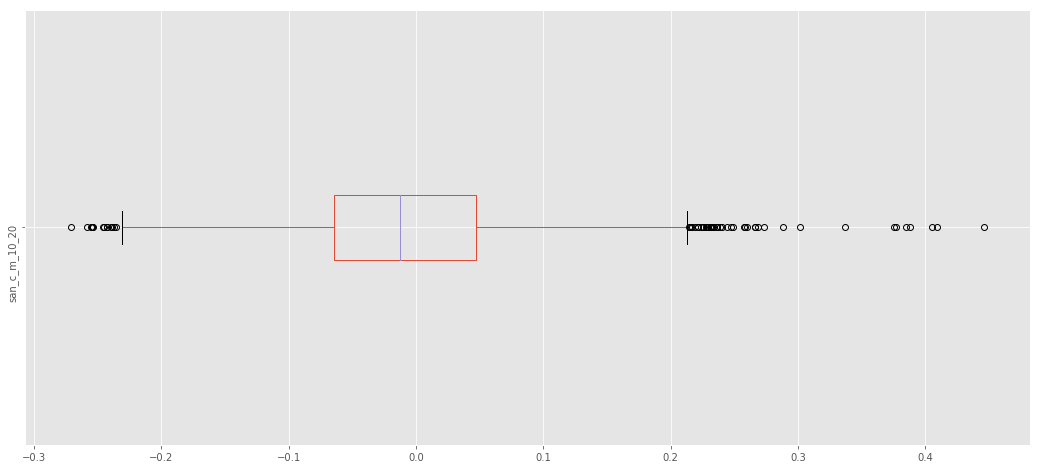

 el valor de 01p es : -0.20369 
 el valor de 05p es : -0.13761 
 el valor de 50p es : -0.012363 
 el valor de 95p es : 0.1525 
 el valor de T-test es : -2.3774 
 el valor de avg es : -0.004 
 el valor de kur es : 1.1199 
 el valor de skw es : 0.48245 
 el valor de std es : 0.089634 
 el valor de val es : -1.1082 
 el valor de var es : 0.0080343 


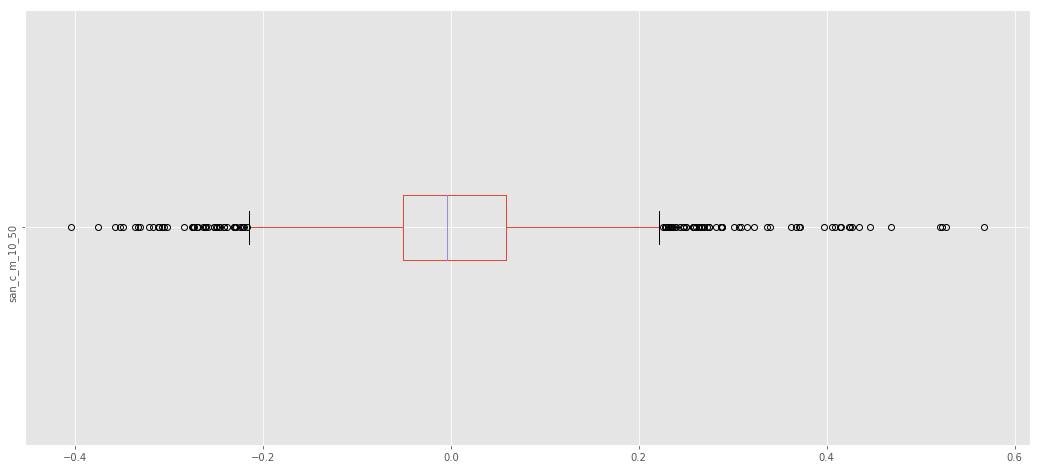

 el valor de 01p es : -0.25292 
 el valor de 05p es : -0.12848 
 el valor de 50p es : -0.003722 
 el valor de 95p es : 0.17013 
 el valor de T-test es : 3.2791 
 el valor de avg es : 0.006 
 el valor de kur es : 2.9232 
 el valor de skw es : 0.57592 
 el valor de std es : 0.099727 
 el valor de val es : -1.3241 
 el valor de var es : 0.0099455 


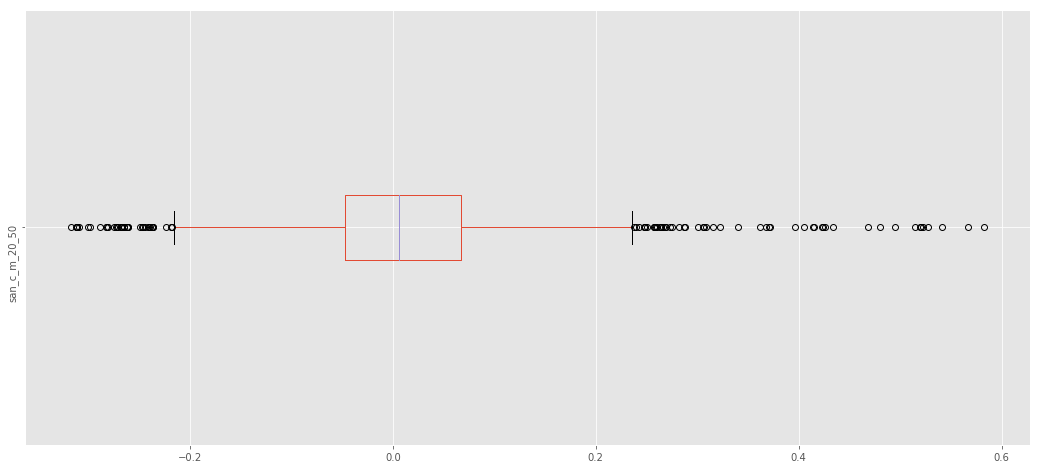

 el valor de 01p es : -0.24757 
 el valor de 05p es : -0.12792 
 el valor de 50p es : 0.0063841 
 el valor de 95p es : 0.17303 
 el valor de T-test es : 7.2336 
 el valor de avg es : 0.014 
 el valor de kur es : 3.4587 
 el valor de skw es : 0.72284 
 el valor de std es : 0.10036 
 el valor de val es : -1.3526 
 el valor de var es : 0.010072 


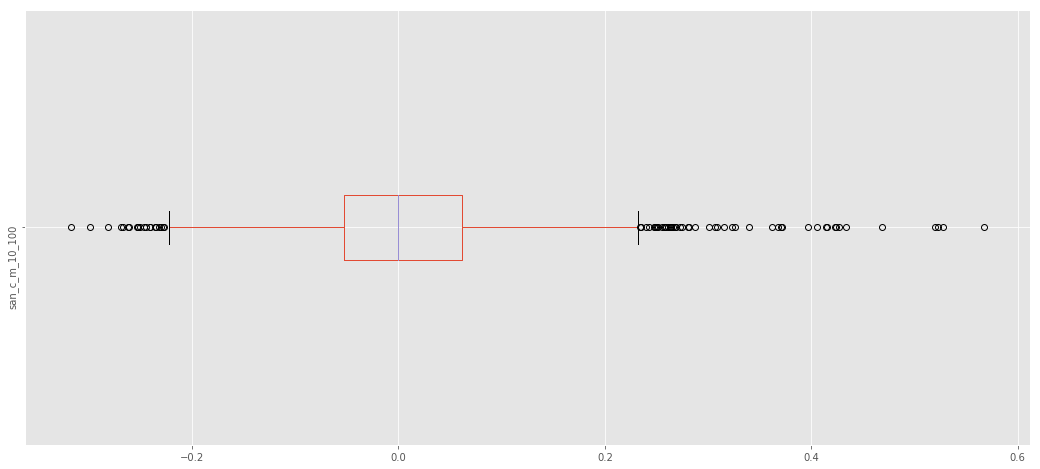

 el valor de 01p es : -0.21286 
 el valor de 05p es : -0.14101 
 el valor de 50p es : 4.4409e-16 
 el valor de 95p es : 0.16563 
 el valor de T-test es : 4.0537 
 el valor de avg es : 0.008 
 el valor de kur es : 2.2943 
 el valor de skw es : 0.6552 
 el valor de std es : 0.097793 
 el valor de val es : -1.1746 
 el valor de var es : 0.0095635 


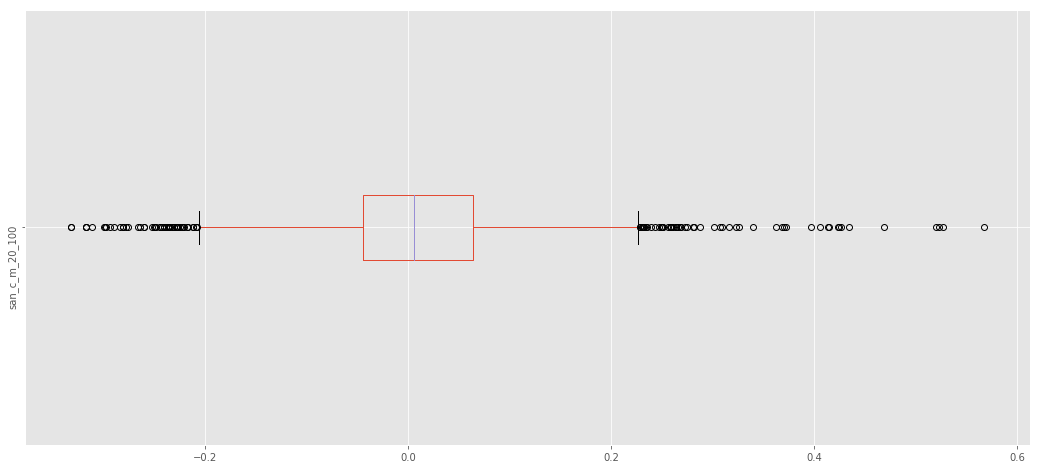

 el valor de 01p es : -0.24122 
 el valor de 05p es : -0.12929 
 el valor de 50p es : 0.0056788 
 el valor de 95p es : 0.16747 
 el valor de T-test es : 6.6088 
 el valor de avg es : 0.012 
 el valor de kur es : 2.637 
 el valor de skw es : 0.46818 
 el valor de std es : 0.097816 
 el valor de val es : -1.2953 
 el valor de var es : 0.009568 


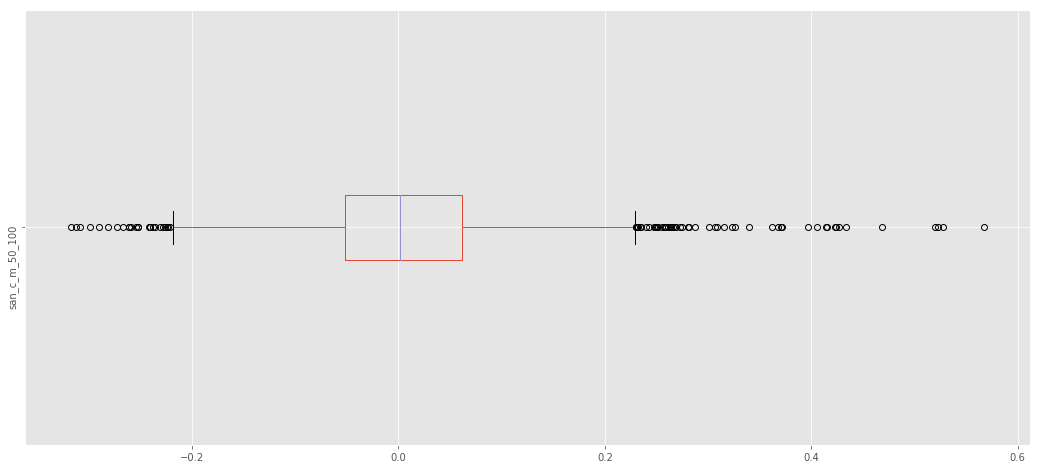

 el valor de 01p es : -0.21751 
 el valor de 05p es : -0.14158 
 el valor de 50p es : 0.0011224 
 el valor de 95p es : 0.16636 
 el valor de T-test es : 4.1343 
 el valor de avg es : 0.008 
 el valor de kur es : 2.213 
 el valor de skw es : 0.59424 
 el valor de std es : 0.098943 
 el valor de val es : -1.175 
 el valor de var es : 0.0097897 


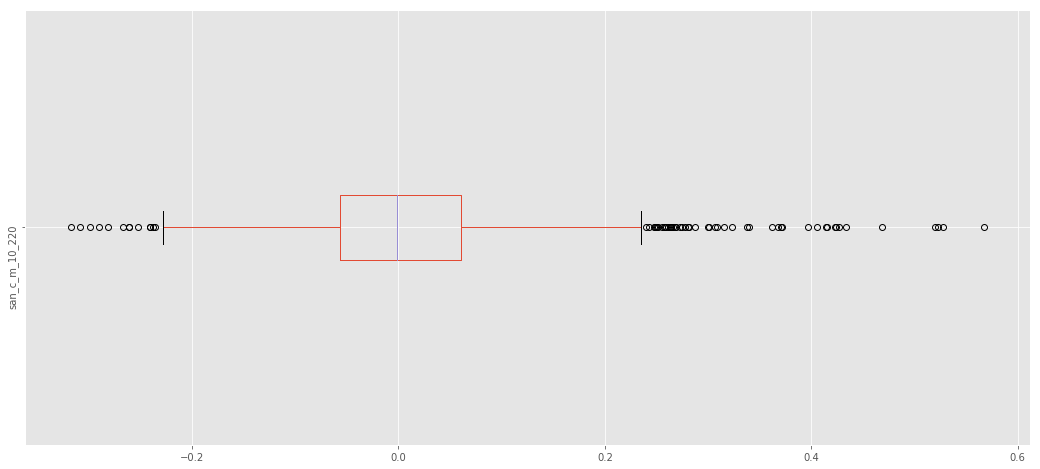

 el valor de 01p es : -0.20064 
 el valor de 05p es : -0.13359 
 el valor de 50p es : -0.0016406 
 el valor de 95p es : 0.1662 
 el valor de T-test es : 3.5453 
 el valor de avg es : 0.007 
 el valor de kur es : 2.3259 
 el valor de skw es : 0.73778 
 el valor de std es : 0.097547 
 el valor de val es : -1.2441 
 el valor de var es : 0.0095153 


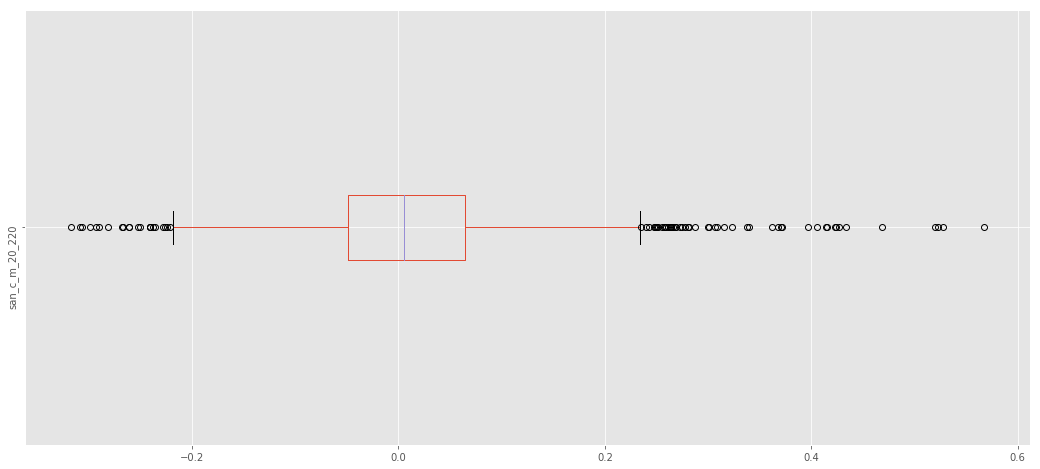

 el valor de 01p es : -0.20511 
 el valor de 05p es : -0.13853 
 el valor de 50p es : 0.0056788 
 el valor de 95p es : 0.16747 
 el valor de T-test es : 5.925 
 el valor de avg es : 0.011 
 el valor de kur es : 2.2741 
 el valor de skw es : 0.59203 
 el valor de std es : 0.097994 
 el valor de val es : -1.209 
 el valor de var es : 0.0096027 


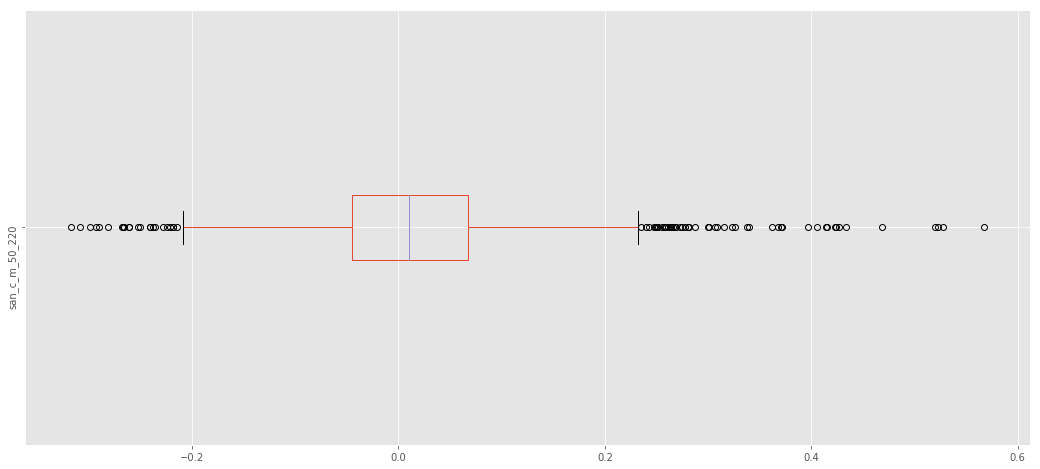

 el valor de 01p es : -0.20354 
 el valor de 05p es : -0.13056 
 el valor de 50p es : 0.010245 
 el valor de 95p es : 0.16682 
 el valor de T-test es : 7.984 
 el valor de avg es : 0.015 
 el valor de kur es : 2.4682 
 el valor de skw es : 0.60506 
 el valor de std es : 0.096119 
 el valor de val es : -1.2777 
 el valor de var es : 0.0092388 


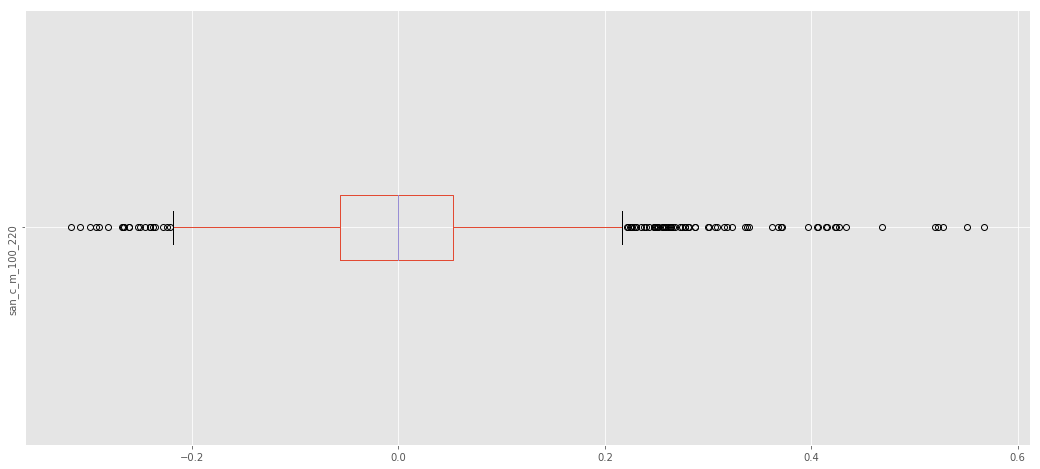

 el valor de 01p es : -0.20448 
 el valor de 05p es : -0.13632 
 el valor de 50p es : -2.2031e-05 
 el valor de 95p es : 0.16003 
 el valor de T-test es : 1.9487 
 el valor de avg es : 0.004 
 el valor de kur es : 3.1315 
 el valor de skw es : 0.82514 
 el valor de std es : 0.097007 
 el valor de val es : -1.1739 
 el valor de var es : 0.0094103 


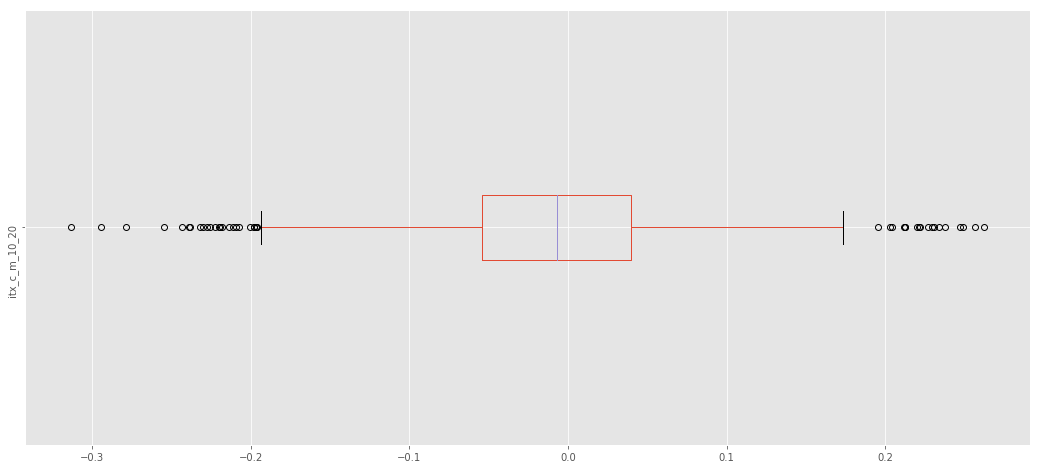

 el valor de 01p es : -0.19052 
 el valor de 05p es : -0.12303 
 el valor de 50p es : -0.0067361 
 el valor de 95p es : 0.11424 
 el valor de T-test es : -4.5365 
 el valor de avg es : -0.006 
 el valor de kur es : 0.59543 
 el valor de skw es : -0.015249 
 el valor de std es : 0.073572 
 el valor de val es : -0.92854 
 el valor de var es : 0.0054128 


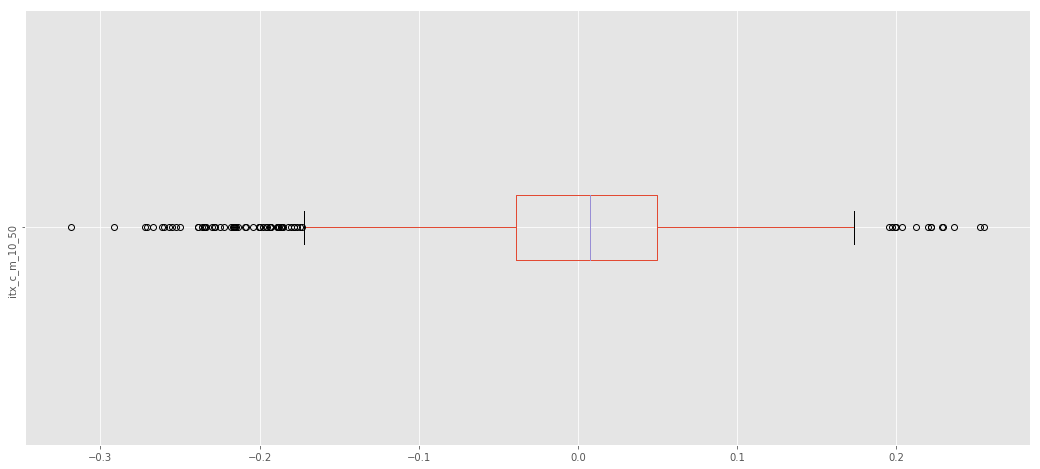

 el valor de 01p es : -0.21549 
 el valor de 05p es : -0.11873 
 el valor de 50p es : 0.0075141 
 el valor de 95p es : 0.11541 
 el valor de T-test es : 2.4815 
 el valor de avg es : 0.003 
 el valor de kur es : 1.0395 
 el valor de skw es : -0.44716 
 el valor de std es : 0.073119 
 el valor de val es : -0.97198 
 el valor de var es : 0.0053465 


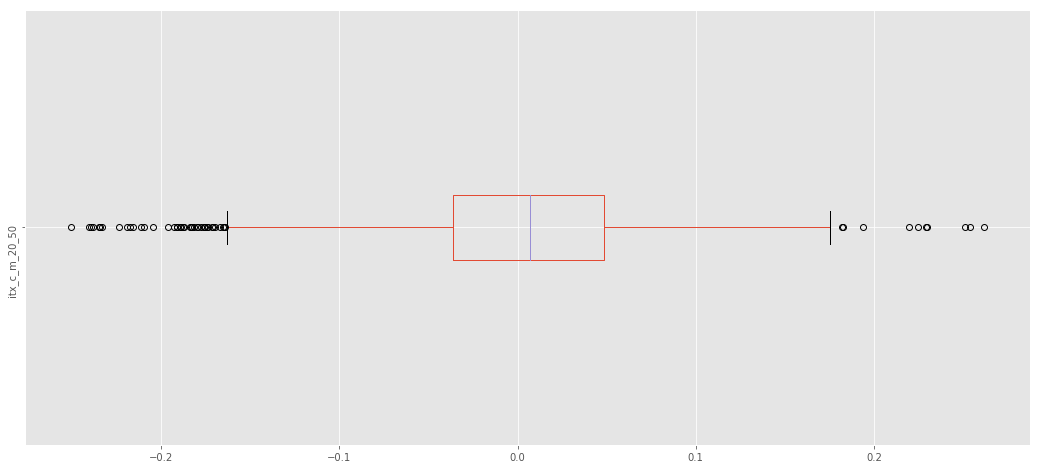

 el valor de 01p es : -0.1794 
 el valor de 05p es : -0.10802 
 el valor de 50p es : 0.0071159 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 3.7057 
 el valor de avg es : 0.005 
 el valor de kur es : 0.61312 
 el valor de skw es : -0.24011 
 el valor de std es : 0.068181 
 el valor de val es : -1.0558 
 el valor de var es : 0.0046486 


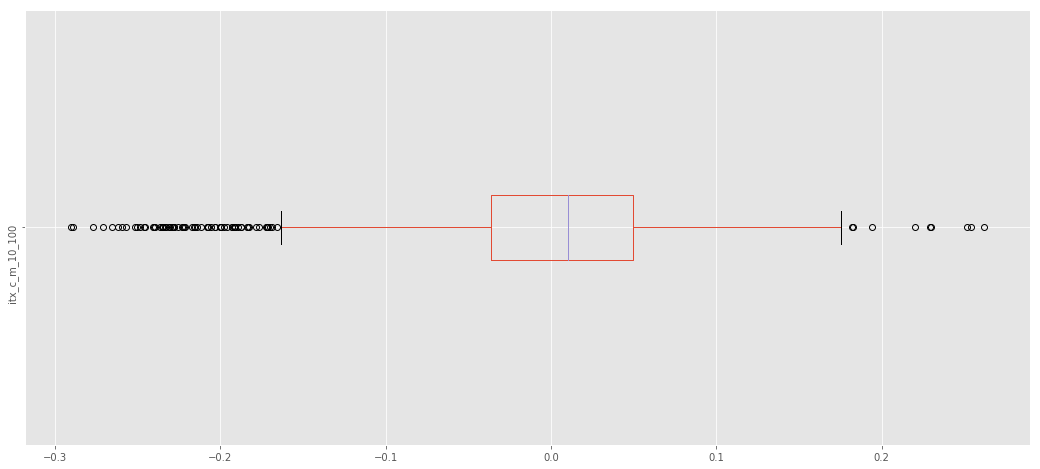

 el valor de 01p es : -0.228 
 el valor de 05p es : -0.1191 
 el valor de 50p es : 0.010159 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 3.3833 
 el valor de avg es : 0.005 
 el valor de kur es : 1.2534 
 el valor de skw es : -0.58662 
 el valor de std es : 0.073291 
 el valor de val es : -0.97934 
 el valor de var es : 0.0053716 


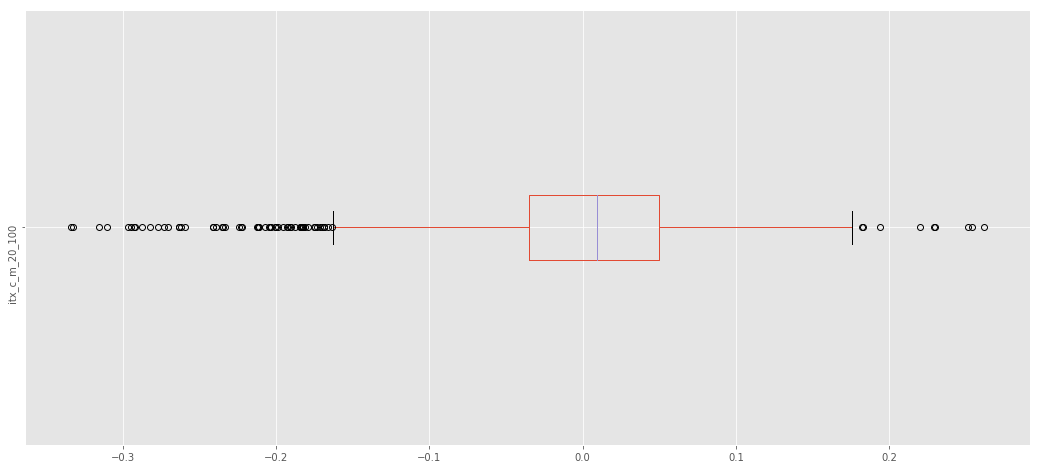

 el valor de 01p es : -0.2119 
 el valor de 05p es : -0.11657 
 el valor de 50p es : 0.009584 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.8461 
 el valor de avg es : 0.005 
 el valor de kur es : 1.6859 
 el valor de skw es : -0.63731 
 el valor de std es : 0.072765 
 el valor de val es : -1.0019 
 el valor de var es : 0.0052947 


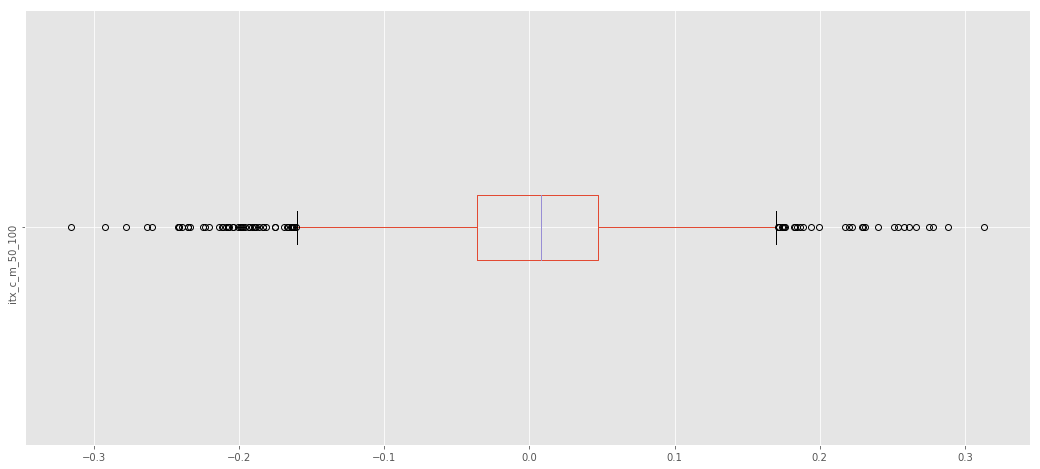

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


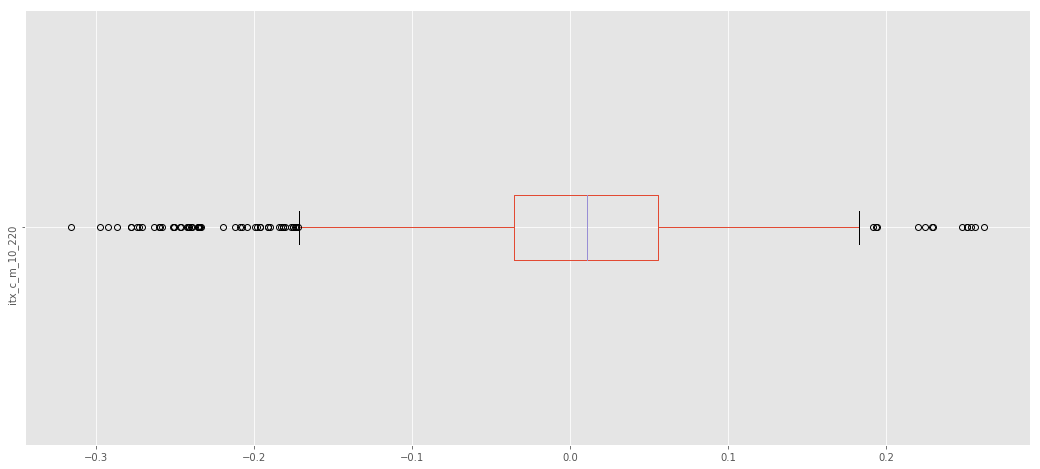

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


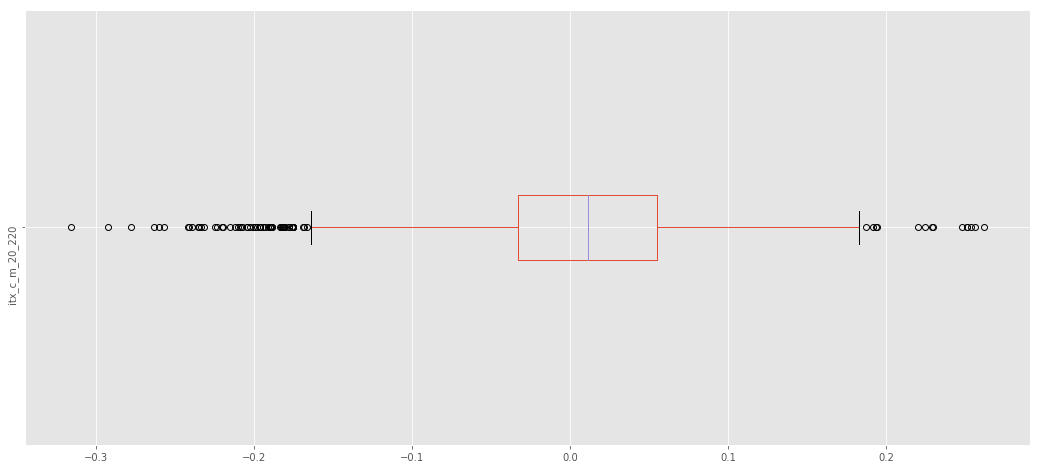

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


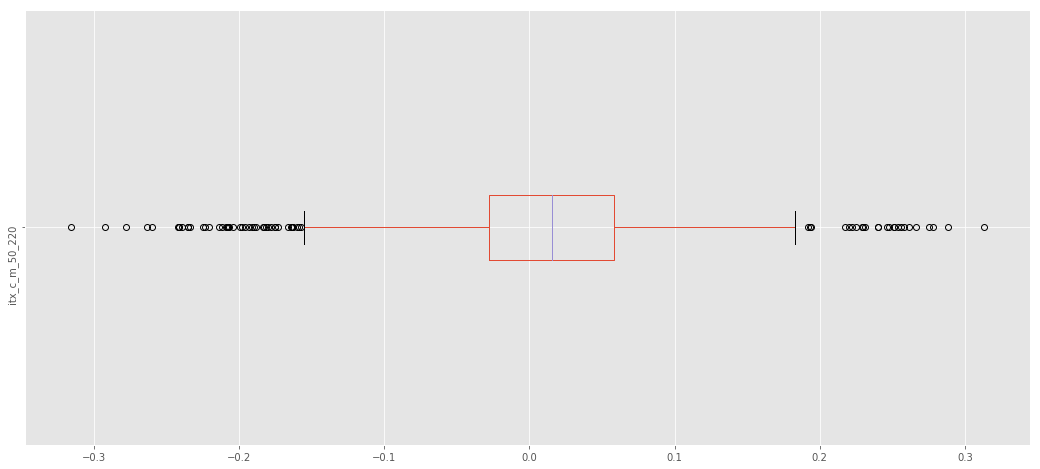

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


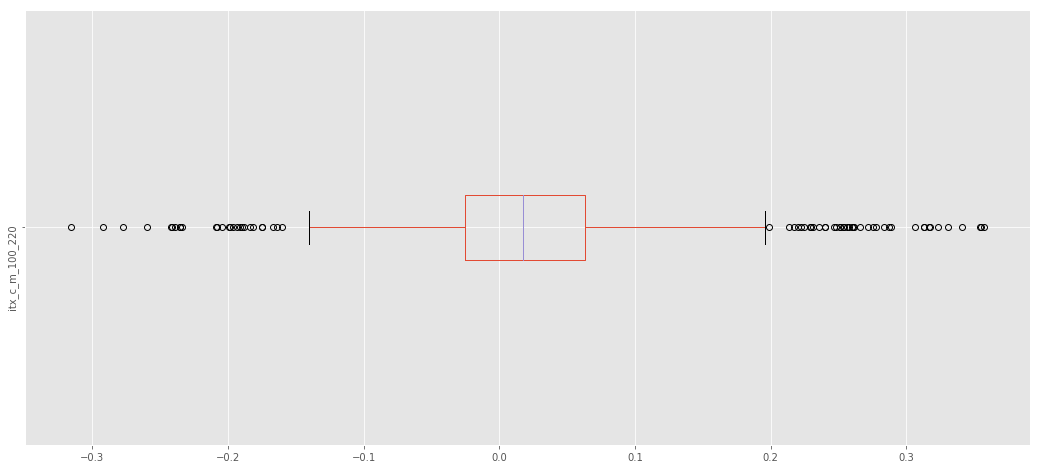

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


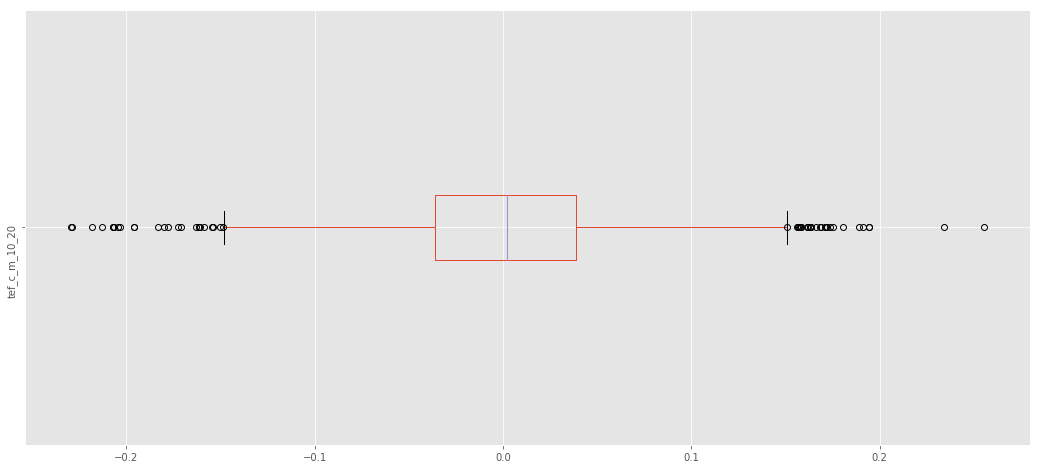

 el valor de 01p es : -0.14743 
 el valor de 05p es : -0.099688 
 el valor de 50p es : 0.001998 
 el valor de 95p es : 0.10821 
 el valor de T-test es : 1.6021 
 el valor de avg es : 0.002 
 el valor de kur es : 0.58486 
 el valor de skw es : -0.0080743 
 el valor de std es : 0.061911 
 el valor de val es : -1.0855 
 el valor de var es : 0.003833 


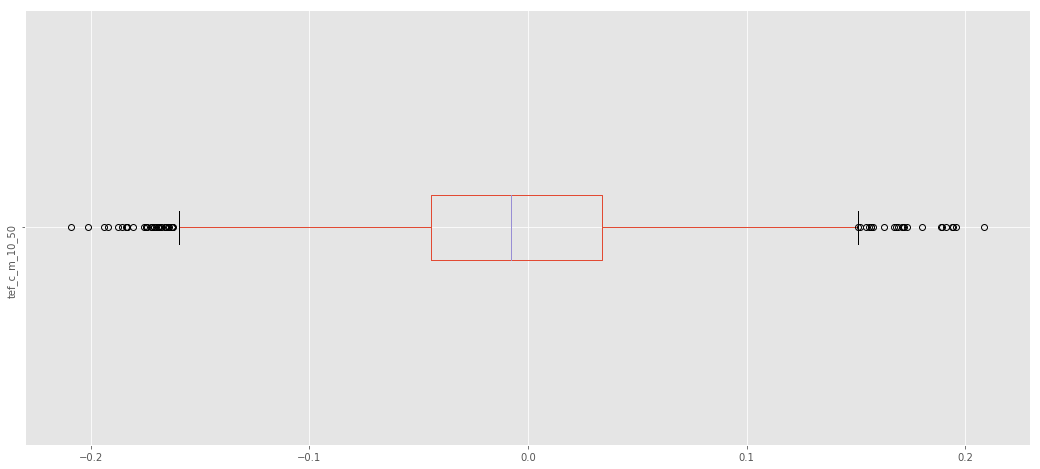

 el valor de 01p es : -0.16548 
 el valor de 05p es : -0.11873 
 el valor de 50p es : -0.0079517 
 el valor de 95p es : 0.10039 
 el valor de T-test es : -5.77 
 el valor de avg es : -0.007 
 el valor de kur es : 0.30933 
 el valor de skw es : -0.035293 
 el valor de std es : 0.063663 
 el valor de val es : -0.84554 
 el valor de var es : 0.004053 


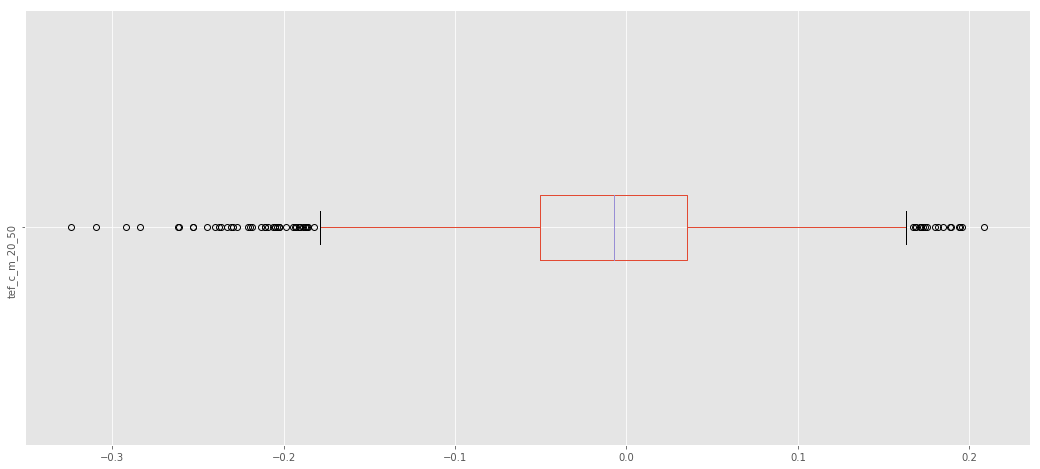

 el valor de 01p es : -0.20319 
 el valor de 05p es : -0.13345 
 el valor de 50p es : -0.0072427 
 el valor de 95p es : 0.10535 
 el valor de T-test es : -7.0584 
 el valor de avg es : -0.01 
 el valor de kur es : 0.78774 
 el valor de skw es : -0.30409 
 el valor de std es : 0.071061 
 el valor de val es : -0.78938 
 el valor de var es : 0.0050497 


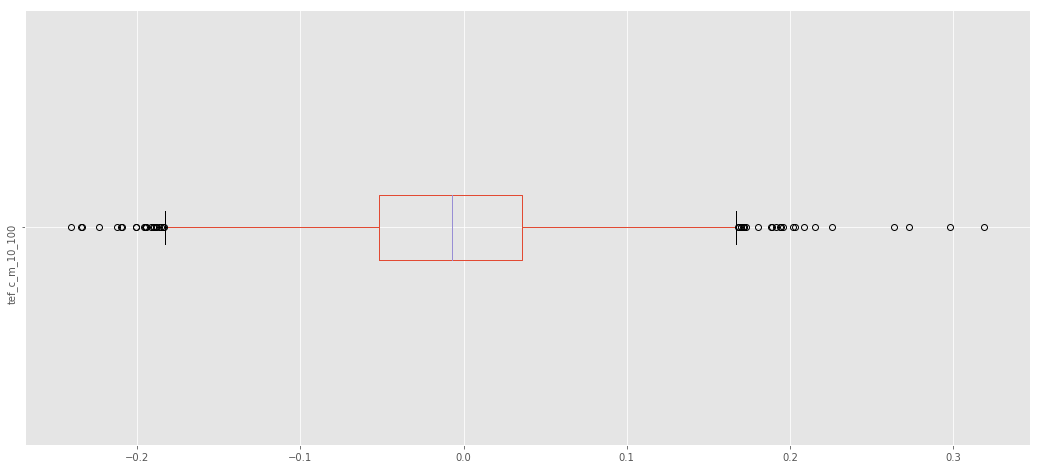

 el valor de 01p es : -0.17423 
 el valor de 05p es : -0.11981 
 el valor de 50p es : -0.0072708 
 el valor de 95p es : 0.10763 
 el valor de T-test es : -5.5398 
 el valor de avg es : -0.007 
 el valor de kur es : 0.60183 
 el valor de skw es : 0.093362 
 el valor de std es : 0.06924 
 el valor de val es : -0.89839 
 el valor de var es : 0.0047942 


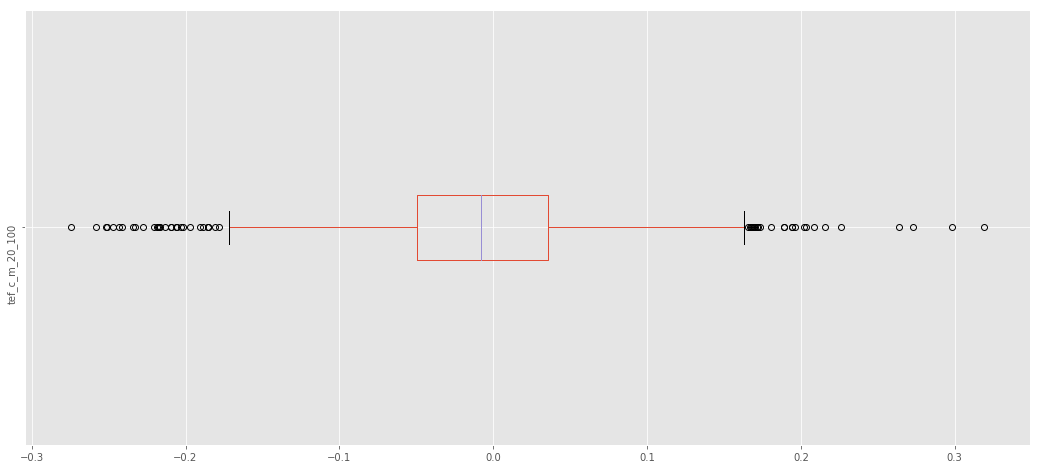

 el valor de 01p es : -0.18528 
 el valor de 05p es : -0.11564 
 el valor de 50p es : -0.007622 
 el valor de 95p es : 0.10852 
 el valor de T-test es : -4.9409 
 el valor de avg es : -0.007 
 el valor de kur es : 0.9846 
 el valor de skw es : 0.024296 
 el valor de std es : 0.068466 
 el valor de val es : -0.93842 
 el valor de var es : 0.0046877 


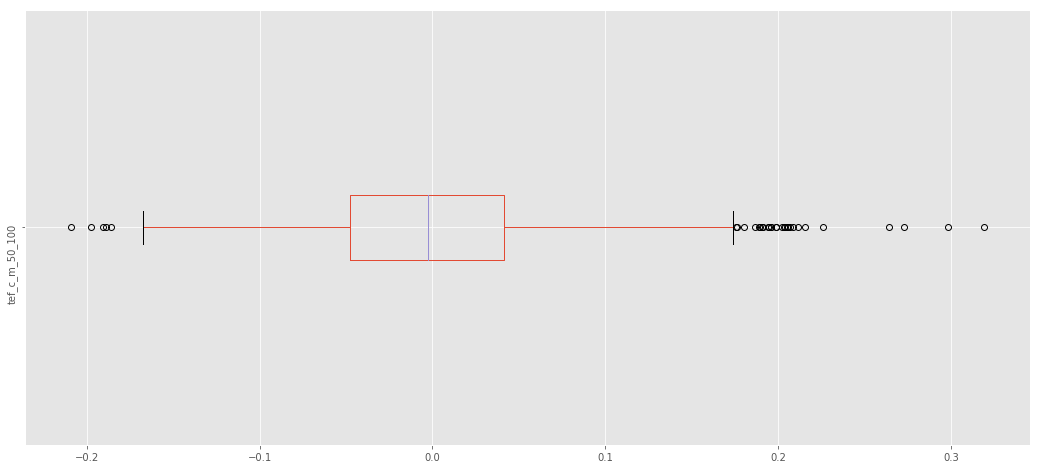

 el valor de 01p es : -0.1473 
 el valor de 05p es : -0.1045 
 el valor de 50p es : -0.0022869 
 el valor de 95p es : 0.11816 
 el valor de T-test es : -0.15149 
 el valor de avg es : -0.0 
 el valor de kur es : 0.46945 
 el valor de skw es : 0.35855 
 el valor de std es : 0.067824 
 el valor de val es : -1.1307 
 el valor de var es : 0.0046001 


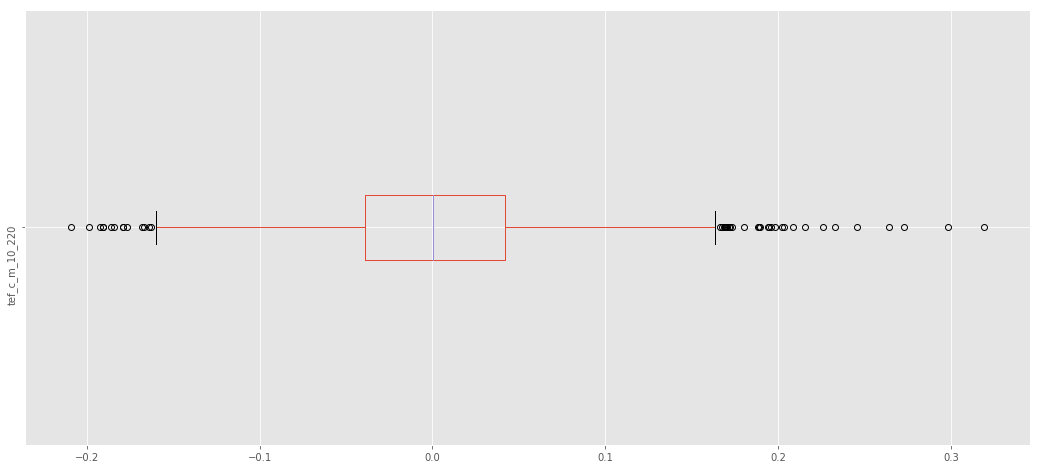

 el valor de 01p es : -0.14215 
 el valor de 05p es : -0.10624 
 el valor de 50p es : 0.00051036 
 el valor de 95p es : 0.1113 
 el valor de T-test es : 0.87414 
 el valor de avg es : 0.001 
 el valor de kur es : 0.58021 
 el valor de skw es : 0.21477 
 el valor de std es : 0.066034 
 el valor de val es : -1.0476 
 el valor de var es : 0.0043605 


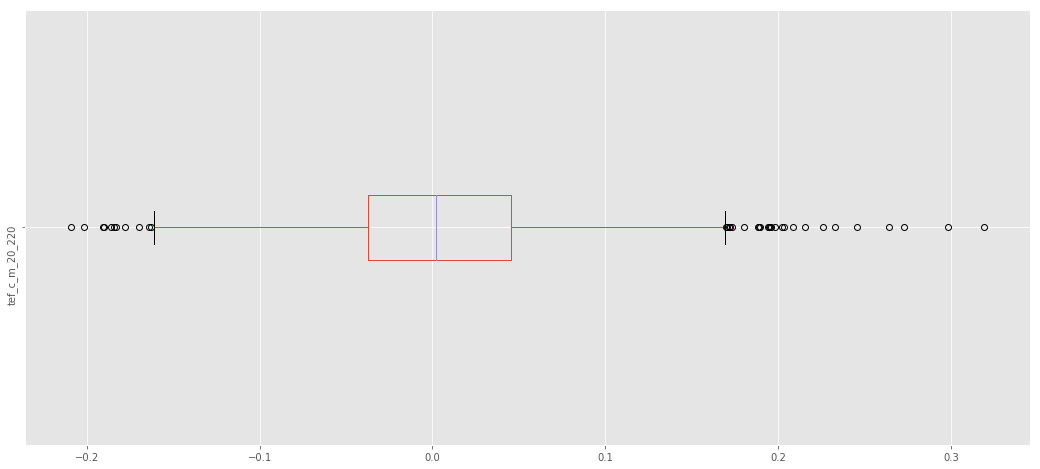

 el valor de 01p es : -0.14816 
 el valor de 05p es : -0.10045 
 el valor de 50p es : 0.0021677 
 el valor de 95p es : 0.11569 
 el valor de T-test es : 2.9608 
 el valor de avg es : 0.004 
 el valor de kur es : 0.52929 
 el valor de skw es : 0.22024 
 el valor de std es : 0.066285 
 el valor de val es : -1.1517 
 el valor de var es : 0.0043937 


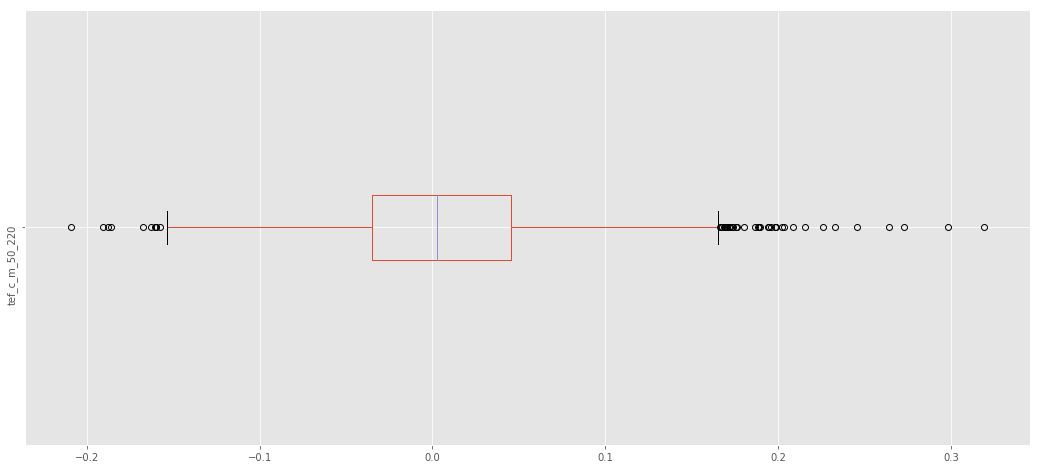

 el valor de 01p es : -0.14007 
 el valor de 05p es : -0.1027 
 el valor de 50p es : 0.0029015 
 el valor de 95p es : 0.12001 
 el valor de T-test es : 3.9493 
 el valor de avg es : 0.005 
 el valor de kur es : 0.48686 
 el valor de skw es : 0.25901 
 el valor de std es : 0.066449 
 el valor de val es : -1.1686 
 el valor de var es : 0.0044154 


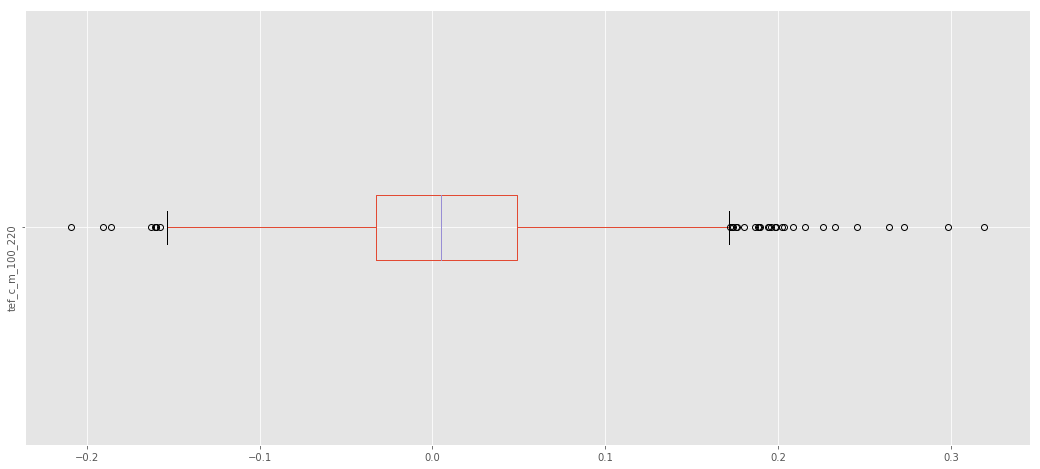

 el valor de 01p es : -0.13447 
 el valor de 05p es : -0.092981 
 el valor de 50p es : 0.004898 
 el valor de 95p es : 0.12087 
 el valor de T-test es : 7.1681 
 el valor de avg es : 0.009 
 el valor de kur es : 0.44074 
 el valor de skw es : 0.31984 
 el valor de std es : 0.065336 
 el valor de val es : -1.3 
 el valor de var es : 0.0042687 


In [150]:
#ccoco=f.filter(like='_cruce_medias',axis=1).columns.values
var95histmedias={}
for n in seleccion:
    valor="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmedias[valor]=calculate_aggregate(g[valor].pct_change(20),False)

<h4>Tabla de comportamiento var95 de cada sistema</h4>

In [151]:
fofo=pd.DataFrame(var95histmedias)
np.round(fofo.T,3)

01p    05p    50p    95p  T-test    avg    kur    skw  \
itx_c_m_100_220 -0.144 -0.084  0.018  0.136  15.157  0.021  2.178  0.365   
itx_c_m_10_100  -0.228 -0.119  0.010  0.117   3.383  0.005  1.253 -0.587   
itx_c_m_10_20   -0.191 -0.123 -0.007  0.114  -4.536 -0.006  0.595 -0.015   
itx_c_m_10_220  -0.235 -0.102  0.011  0.125   6.792  0.010  1.540 -0.461   
itx_c_m_10_50   -0.215 -0.119  0.008  0.115   2.481  0.003  1.039 -0.447   
itx_c_m_20_100  -0.212 -0.117  0.010  0.117   3.846  0.005  1.686 -0.637   
itx_c_m_20_220  -0.200 -0.114  0.011  0.126   6.707  0.009  1.047 -0.377   
itx_c_m_20_50   -0.179 -0.108  0.007  0.114   3.706  0.005  0.613 -0.240   
itx_c_m_50_100  -0.198 -0.111  0.008  0.117   4.258  0.006  1.459 -0.197   
itx_c_m_50_220  -0.191 -0.091  0.016  0.130  11.414  0.016  1.466 -0.143   
san_c_m_100_220 -0.204 -0.136 -0.000  0.160   1.949  0.004  3.131  0.825   
san_c_m_10_100  -0.213 -0.141  0.000  0.166   4.054  0.008  2.294  0.655   
san_c_m_10_20   -0.204 -0.138 -0.012  0.153  -2.377 -0.004  1.120  0.482   
san_c_m_10_220  -0.201 -0.134 -0.002  0.166   3.545  0.007  2.326  0.738   
san_c_m_10_50   -0.253 -0.128 -0.004  0.170   3.279  0.006  2.923  0.576   
san_c_m_20_100  -0.241 -0.129  0.006  0.167   6.609  0.012  2.637  0.468   
san_c_m_20_220  -0.205 -0.139  0.006  0.167   5.925  0.011  2.274  0.592   
san_c_m_20_50   -0.248 -0.128  0.006  0.173   7.234  0.014  3.459  0.723   
san_c_m_50_100  -0.218 -0.142  0.001  0.166   4.134  0.008  2.213  0.594   
san_c_m_50_220  -0.204 -0.131  0.010  0.167   7.984  0.015  2.468  0.605   
tef_c_m_100_220 -0.134 -0.093  0.005  0.121   7.168  0.009  0.441  0.320   
tef_c_m_10_100  -0.174 -0.120 -0.007  0.108  -5.540 -0.007  0.602  0.093   
tef_c_m_10_20   -0.147 -0.100  0.002  0.108   1.602  0.002  0.585 -0.008   
tef_c_m_10_220  -0.142 -0.106  0.001  0.111   0.874  0.001  0.580  0.215   
tef_c_m_10_50   -0.165 -0.119 -0.008  0.100  -5.770 -0.007  0.309 -0.035   
tef_c_m_20_100  -0.185 -0.116 -0.008  0.109  -4.941 -0.007  0.985  0.024   
tef_c_m_20_220  -0.148 -0.100  0.002  0.116   2.961  0.004  0.529  0.220   
tef_c_m_20_50   -0.203 -0.133 -0.007  0.105  -7.058 -0.010  0.788 -0.304   
tef_c_m_50_100  -0.147 -0.105 -0.002  0.118  -0.151 -0.000  0.469  0.359   
tef_c_m_50_220  -0.140 -0.103  0.003  0.120   3.949  0.005  0.487  0.259   

                   std    val    var  
itx_c_m_100_220  0.073 -1.625  0.005  
itx_c_m_10_100   0.073 -0.979  0.005  
itx_c_m_10_20    0.074 -0.929  0.005  
itx_c_m_10_220   0.073 -1.218  0.005  
itx_c_m_10_50    0.073 -0.972  0.005  
itx_c_m_20_100   0.073 -1.002  0.005  
itx_c_m_20_220   0.073 -1.100  0.005  
itx_c_m_20_50    0.068 -1.056  0.005  
itx_c_m_50_100   0.071 -1.062  0.005  
itx_c_m_50_220   0.071 -1.428  0.005  
san_c_m_100_220  0.097 -1.174  0.009  
san_c_m_10_100   0.098 -1.175  0.010  
san_c_m_10_20    0.090 -1.108  0.008  
san_c_m_10_220   0.098 -1.244  0.010  
san_c_m_10_50    0.100 -1.324  0.010  
san_c_m_20_100   0.098 -1.295  0.010  
san_c_m_20_220   0.098 -1.209  0.010  
san_c_m_20_50    0.100 -1.353  0.010  
san_c_m_50_100   0.099 -1.175  0.010  
san_c_m_50_220   0.096 -1.278  0.009  
tef_c_m_100_220  0.065 -1.300  0.004  
tef_c_m_10_100   0.069 -0.898  0.005  
tef_c_m_10_20    0.062 -1.086  0.004  
tef_c_m_10_220   0.066 -1.048  0.004  
tef_c_m_10_50    0.064 -0.846  0.004  
tef_c_m_20_100   0.068 -0.938  0.005  
tef_c_m_20_220   0.066 -1.152  0.004  
tef_c_m_20_50    0.071 -0.789  0.005  
tef_c_m_50_100   0.068 -1.131  0.005  
tef_c_m_50_220   0.066 -1.169  0.004

<p>Si ordenamos las series por el t-test, podemos ver que la confluencia de itx y de las medias mas largas, obtiene los mejores resultados. No obtenemos, ningún var95 > 0, ni menor del -0,05%

<p>Obtenemos las series con t-Test > 4, para ver como se comportan con un límite de pérdida mensual del 10%.

<h4>Gráficos de los sistemas con t-Student > 4</h4>

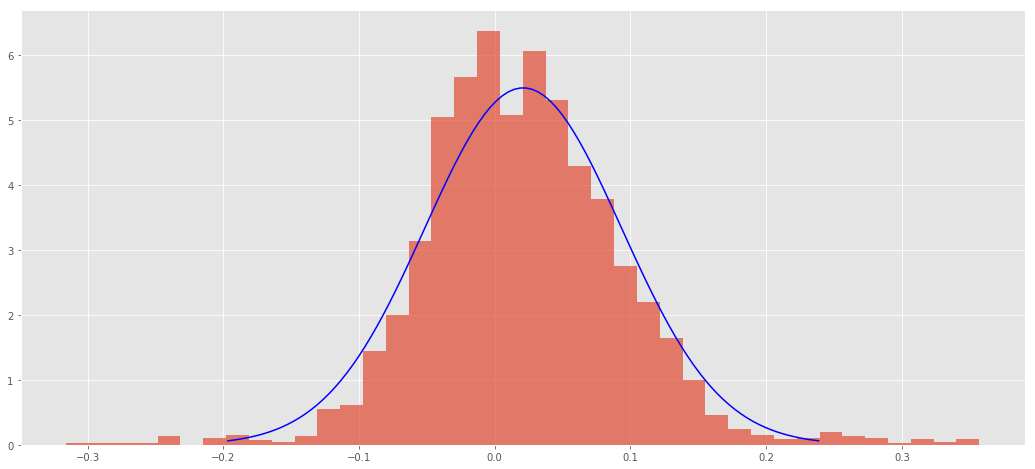

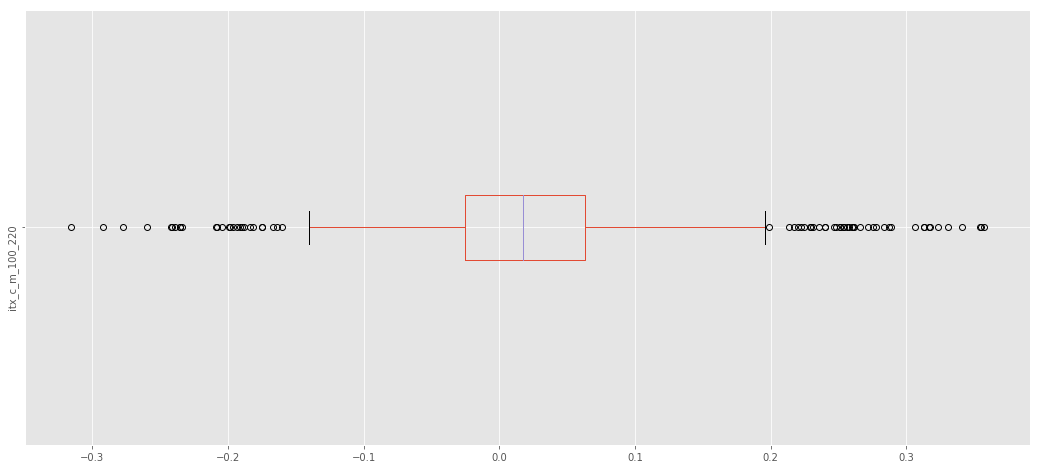

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


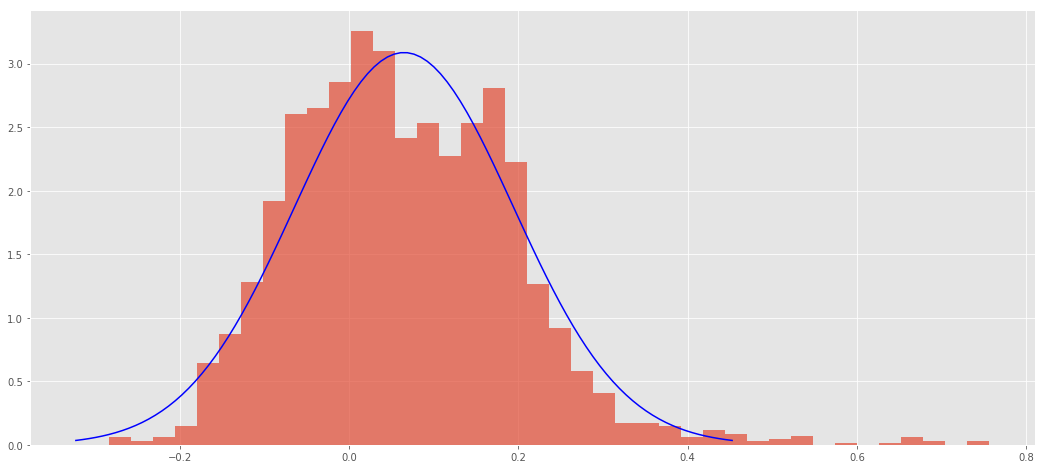

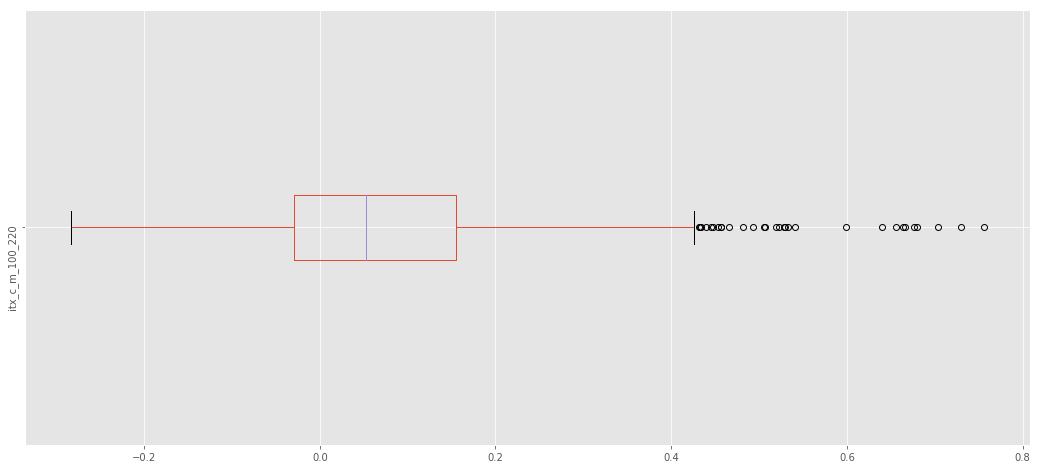

 el valor de 01p es : -0.17363 
 el valor de 05p es : -0.12378 
 el valor de 50p es : 0.052395 
 el valor de 95p es : 0.26621 
 el valor de T-test es : 26.036 
 el valor de avg es : 0.065 
 el valor de kur es : 1.6336 
 el valor de skw es : 0.69438 
 el valor de std es : 0.1292 
 el valor de val es : -2.1507 
 el valor de var es : 0.016691 


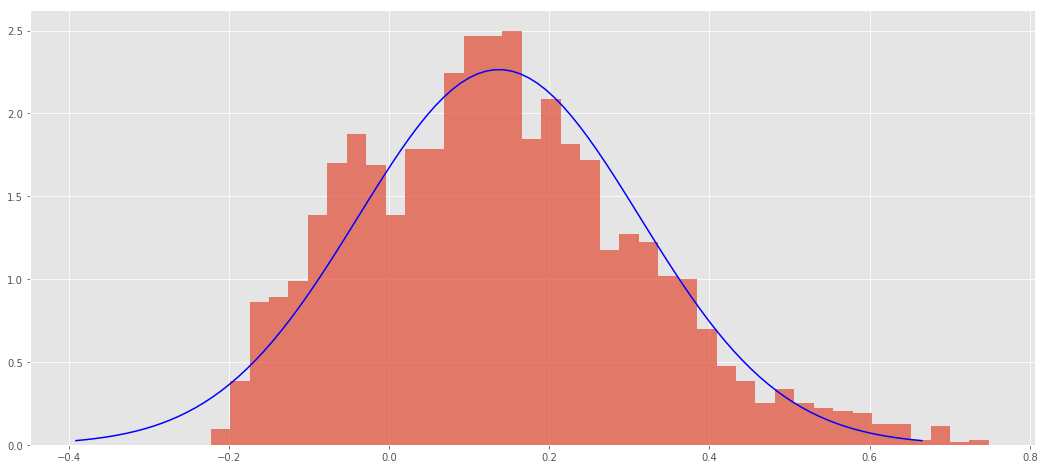

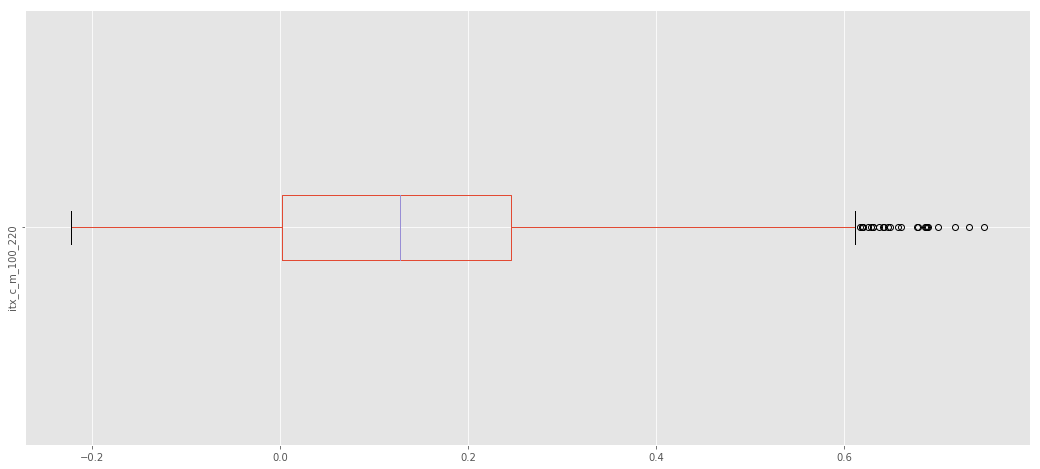

 el valor de 01p es : -0.17737 
 el valor de 05p es : -0.12895 
 el valor de 50p es : 0.12702 
 el valor de 95p es : 0.44391 
 el valor de T-test es : 40.431 
 el valor de avg es : 0.137 
 el valor de kur es : -0.0036466 
 el valor de skw es : 0.45485 
 el valor de std es : 0.17613 
 el valor de val es : -3.4425 
 el valor de var es : 0.03102 


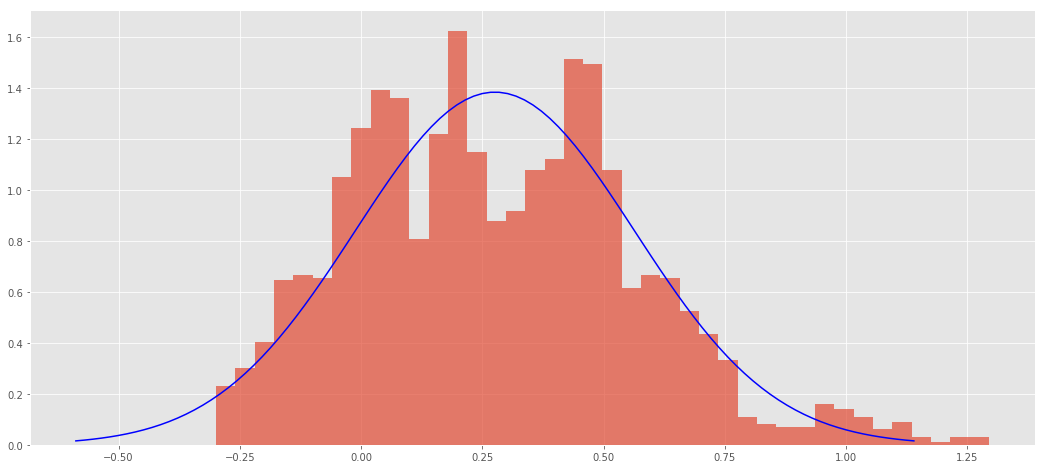

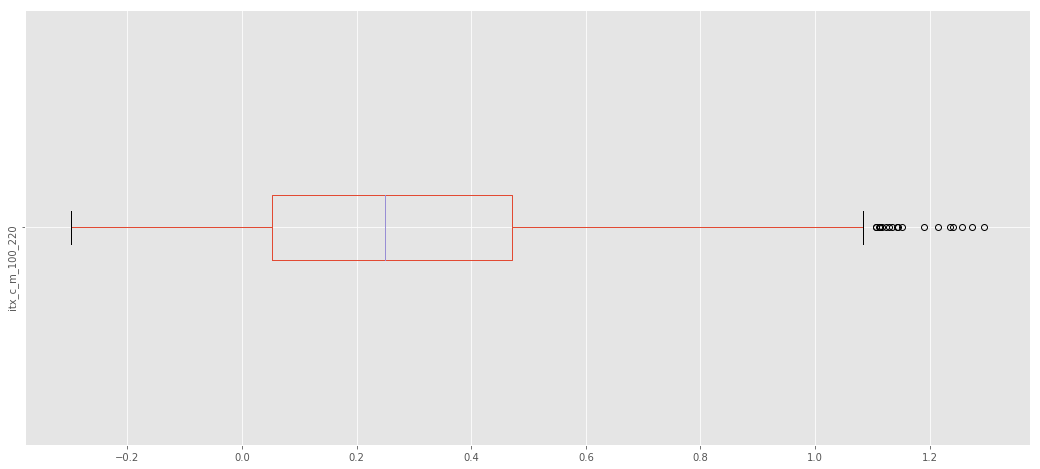

 el valor de 01p es : -0.25569 
 el valor de 05p es : -0.15932 
 el valor de 50p es : 0.24916 
 el valor de 95p es : 0.74048 
 el valor de T-test es : 49.906 
 el valor de avg es : 0.276 
 el valor de kur es : -0.033986 
 el valor de skw es : 0.4251 
 el valor de std es : 0.288 
 el valor de val es : -4.6477 
 el valor de var es : 0.082944 


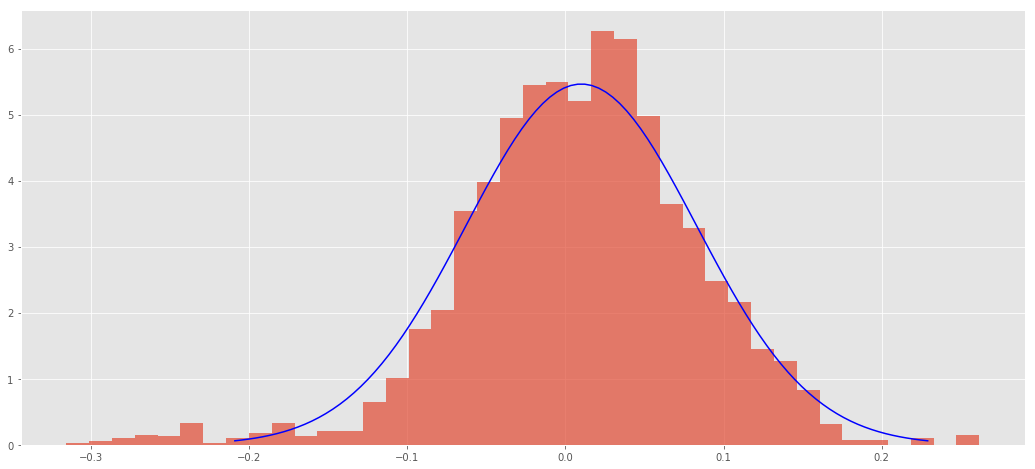

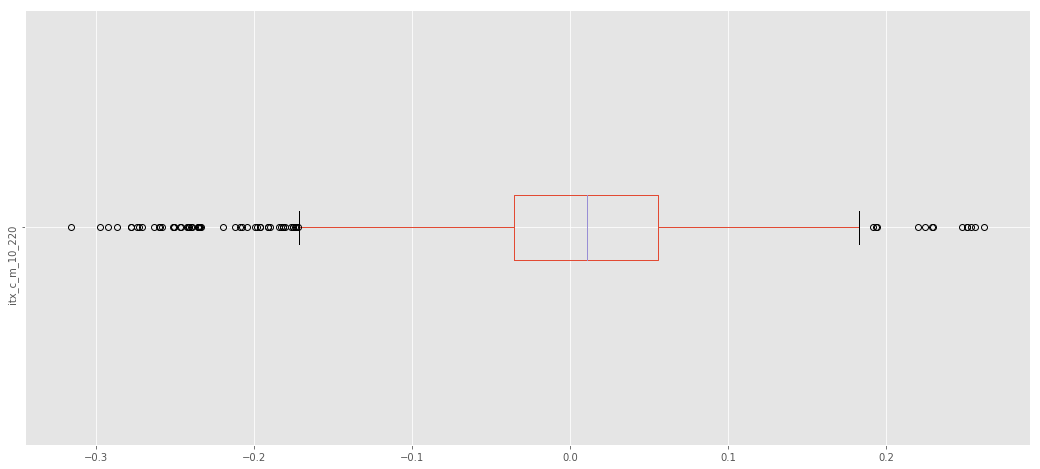

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


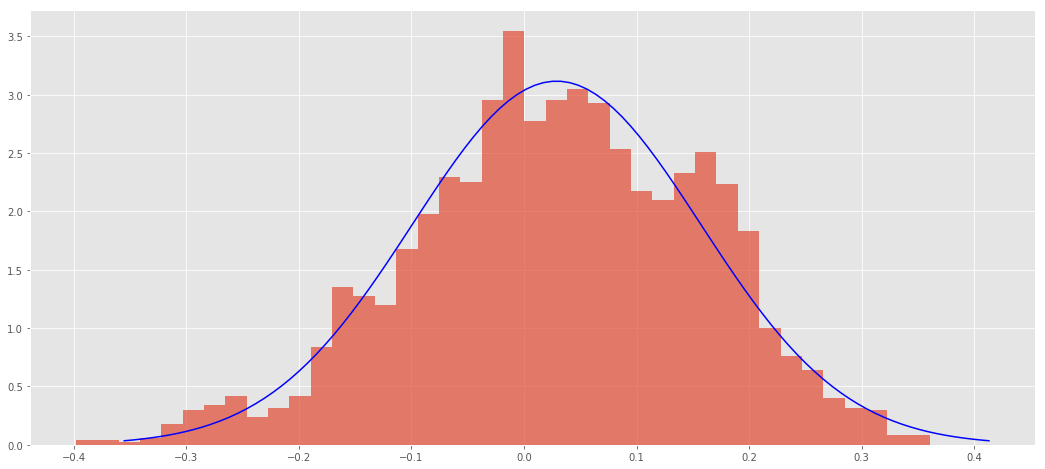

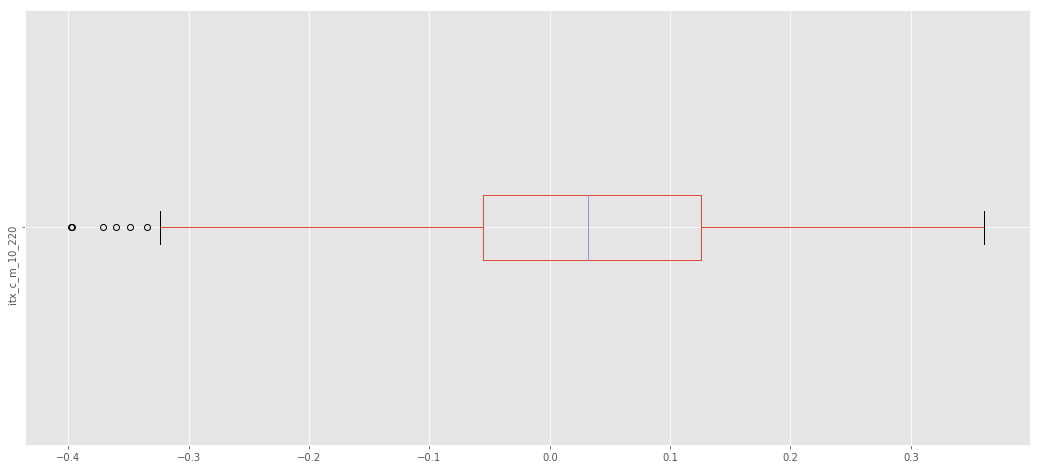

 el valor de 01p es : -0.29098 
 el valor de 05p es : -0.17834 
 el valor de 50p es : 0.031449 
 el valor de 95p es : 0.22729 
 el valor de T-test es : 11.949 
 el valor de avg es : 0.029 
 el valor de kur es : -0.18541 
 el valor de skw es : -0.22551 
 el valor de std es : 0.128 
 el valor de val es : -1.2745 
 el valor de var es : 0.016385 


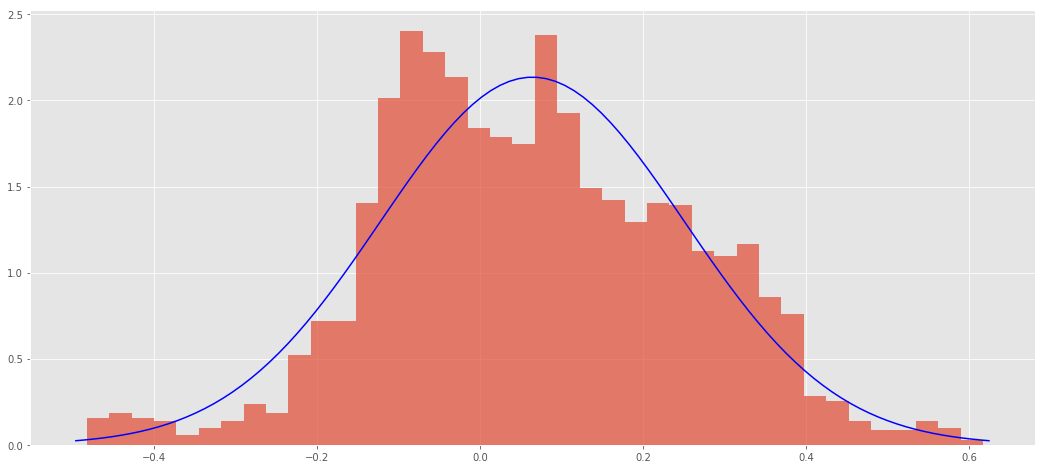

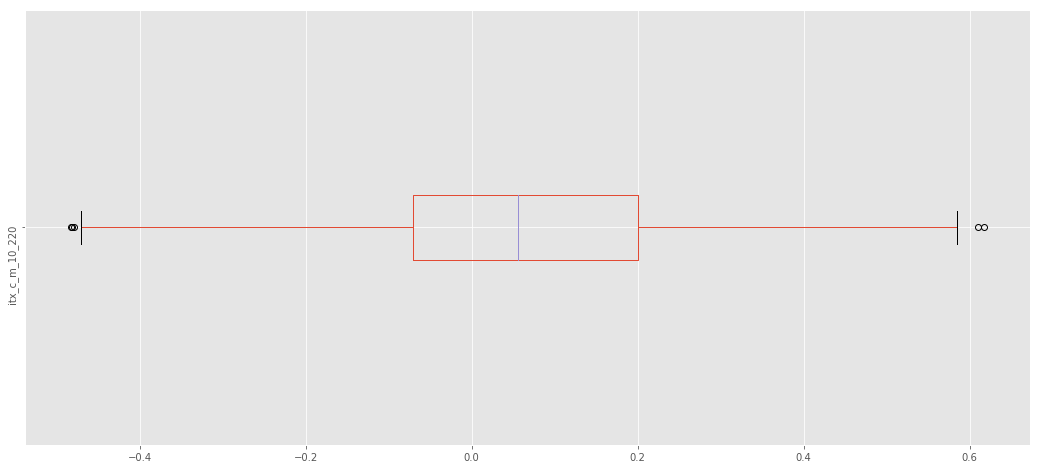

 el valor de 01p es : -0.4212 
 el valor de 05p es : -0.21085 
 el valor de 50p es : 0.056007 
 el valor de 95p es : 0.37086 
 el valor de T-test es : 17.946 
 el valor de avg es : 0.064 
 el valor de kur es : -0.075272 
 el valor de skw es : 0.049159 
 el valor de std es : 0.18681 
 el valor de val es : -1.7589 
 el valor de var es : 0.034899 


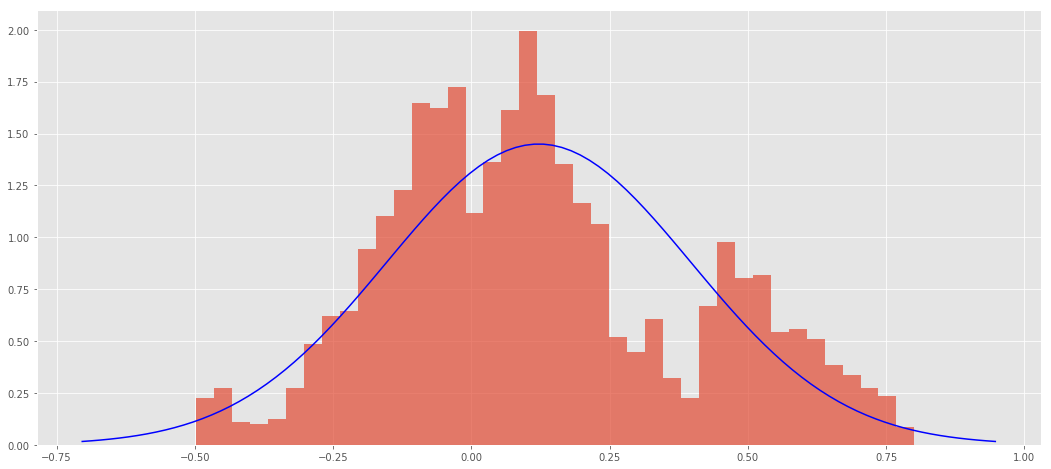

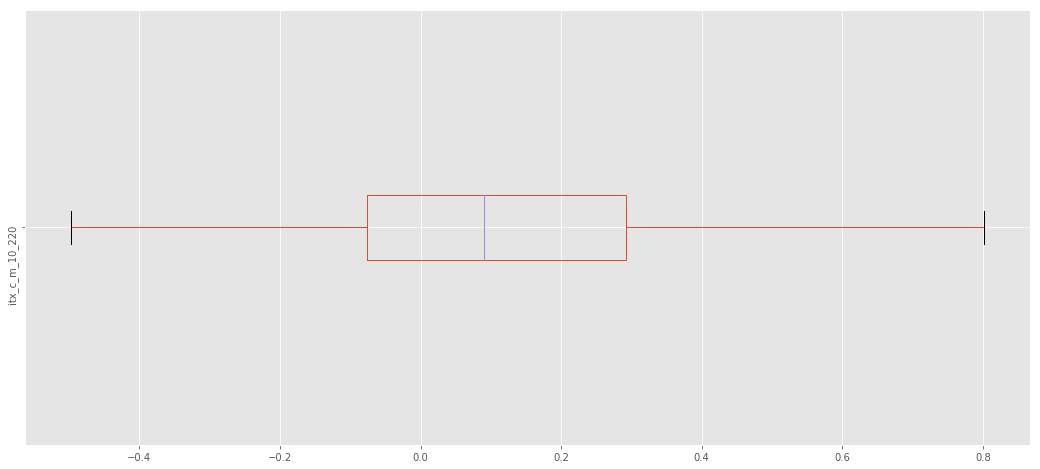

 el valor de 01p es : -0.45096 
 el valor de 05p es : -0.27179 
 el valor de 50p es : 0.090626 
 el valor de 95p es : 0.6271 
 el valor de T-test es : 22.975 
 el valor de avg es : 0.122 
 el valor de kur es : -0.47398 
 el valor de skw es : 0.37537 
 el valor de std es : 0.27522 
 el valor de val es : -2.3073 
 el valor de var es : 0.075744 


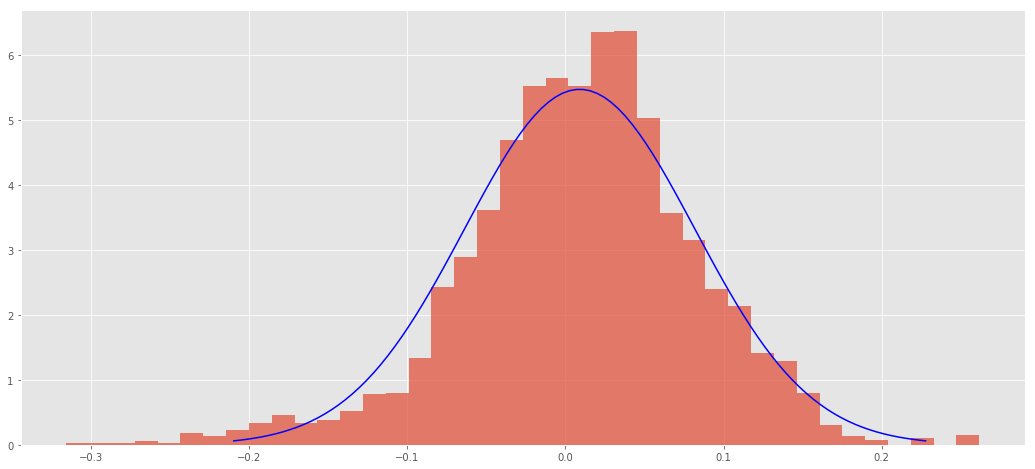

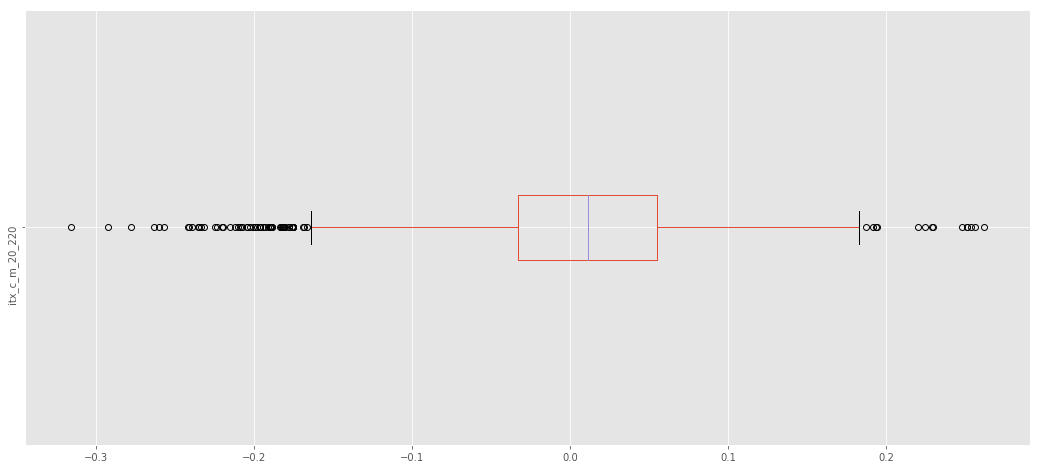

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


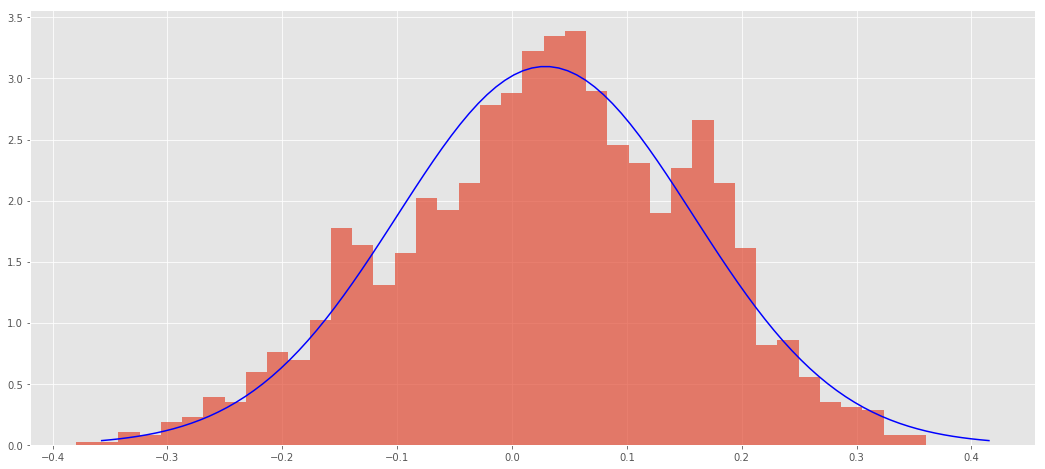

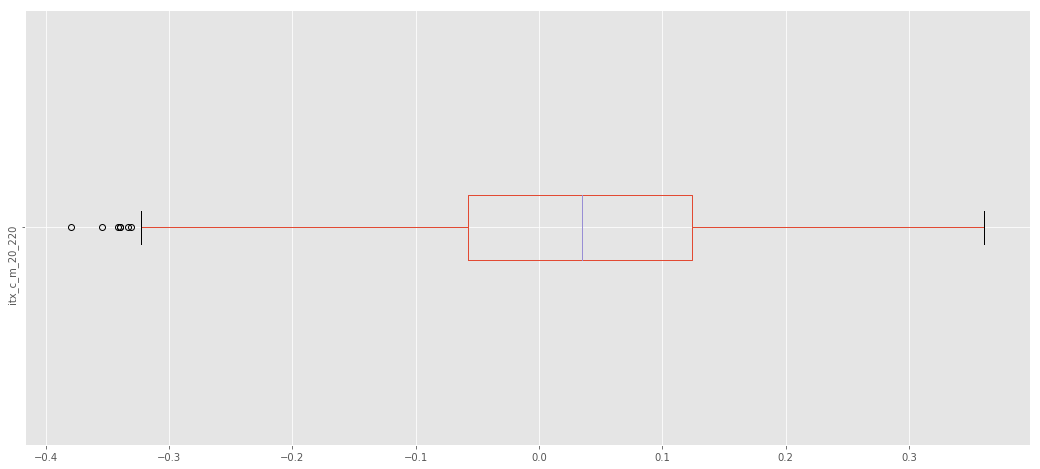

 el valor de 01p es : -0.27619 
 el valor de 05p es : -0.19466 
 el valor de 50p es : 0.034419 
 el valor de 95p es : 0.22732 
 el valor de T-test es : 11.618 
 el valor de avg es : 0.029 
 el valor de kur es : -0.3411 
 el valor de skw es : -0.21815 
 el valor de std es : 0.12875 
 el valor de val es : -1.1678 
 el valor de var es : 0.016578 


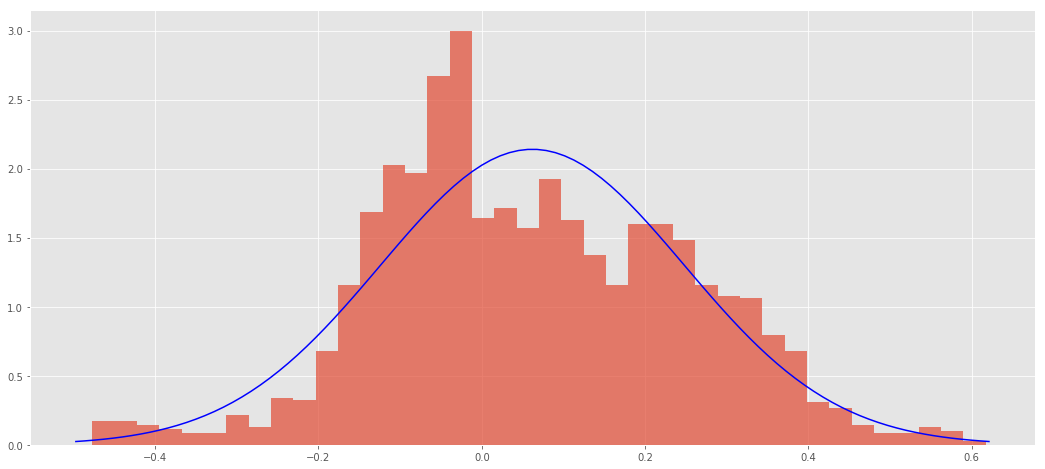

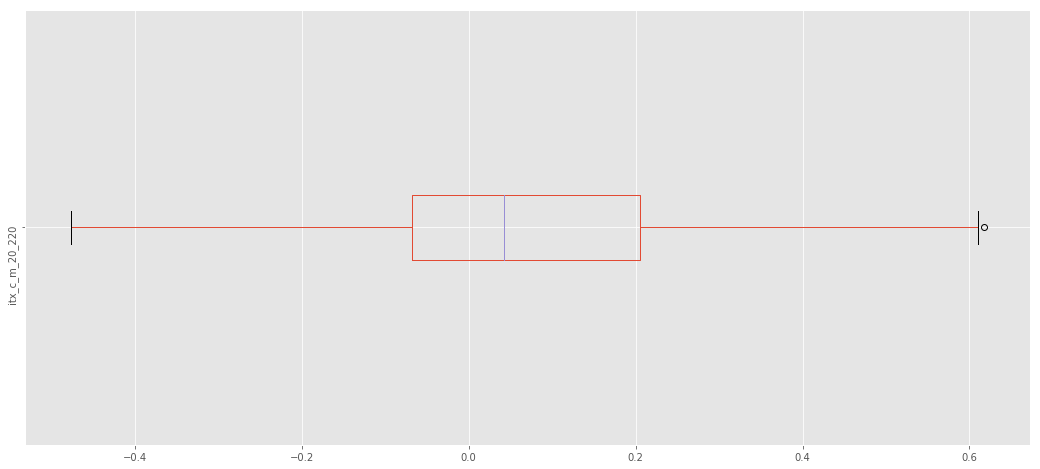

 el valor de 01p es : -0.41319 
 el valor de 05p es : -0.19907 
 el valor de 50p es : 0.0426 
 el valor de 95p es : 0.37086 
 el valor de T-test es : 17.365 
 el valor de avg es : 0.062 
 el valor de kur es : -0.14633 
 el valor de skw es : 0.10448 
 el valor de std es : 0.1864 
 el valor de val es : -1.863 
 el valor de var es : 0.034744 


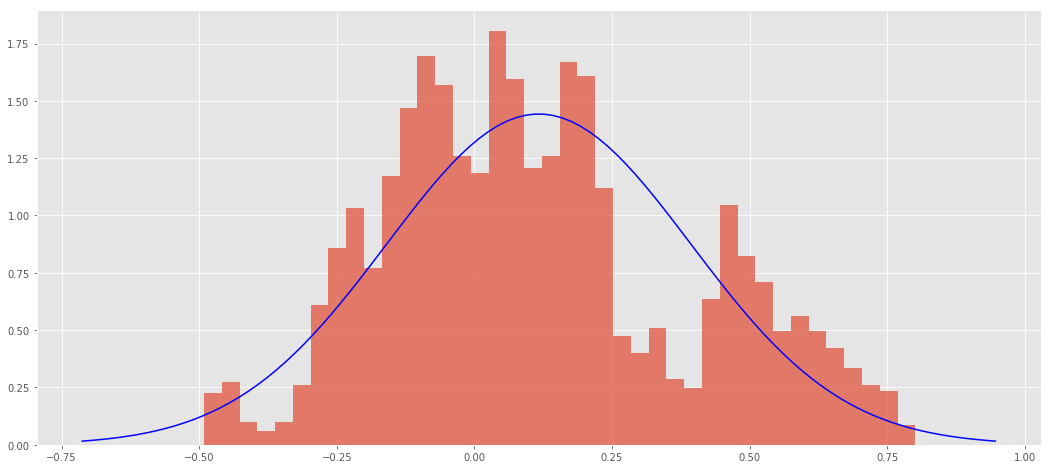

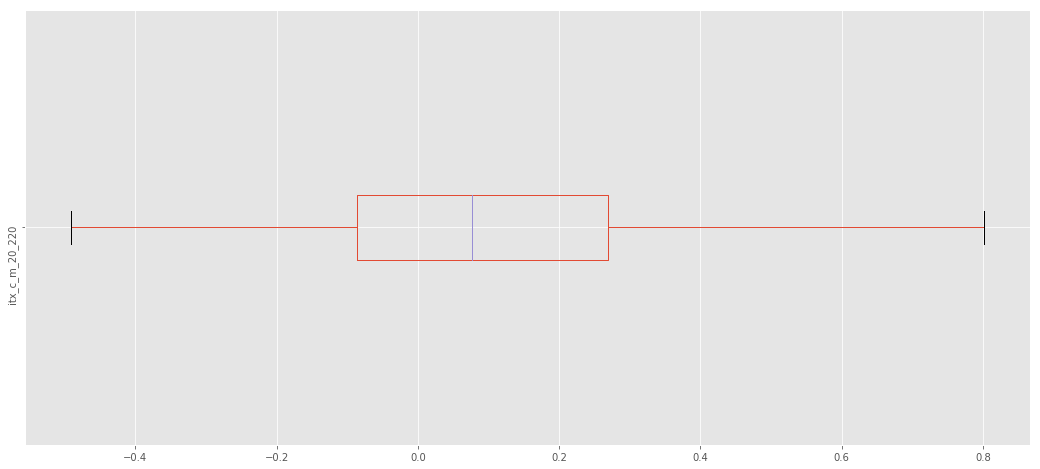

 el valor de 01p es : -0.45029 
 el valor de 05p es : -0.26671 
 el valor de 50p es : 0.07709 
 el valor de 95p es : 0.62815 
 el valor de T-test es : 22.069 
 el valor de avg es : 0.117 
 el valor de kur es : -0.51181 
 el valor de skw es : 0.39652 
 el valor de std es : 0.27654 
 el valor de val es : -2.3552 
 el valor de var es : 0.076474 


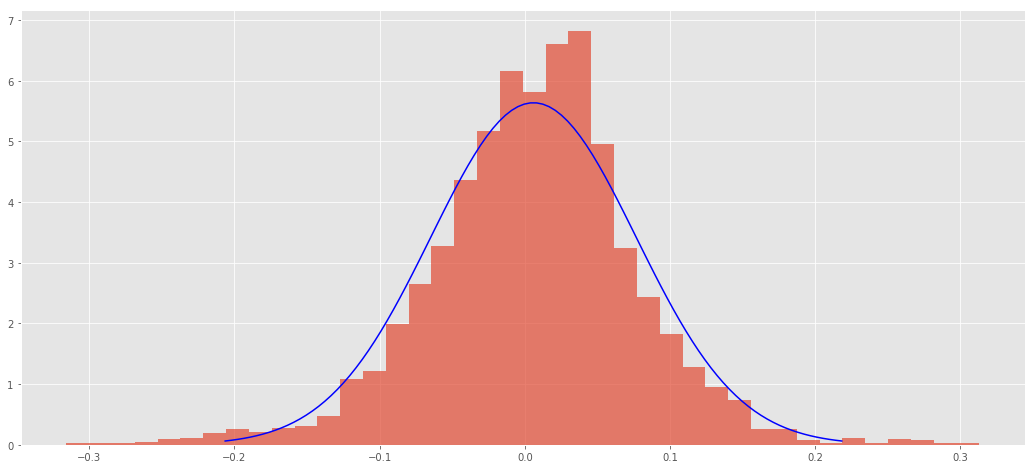

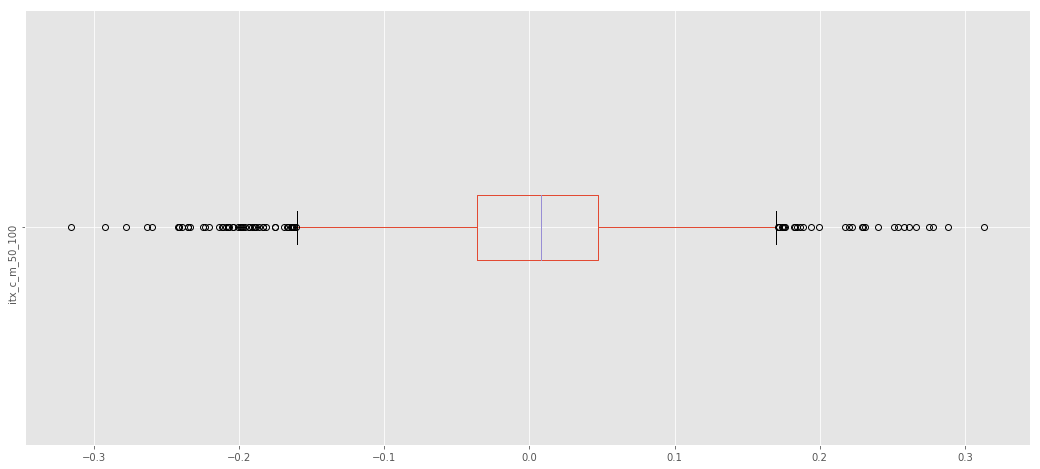

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


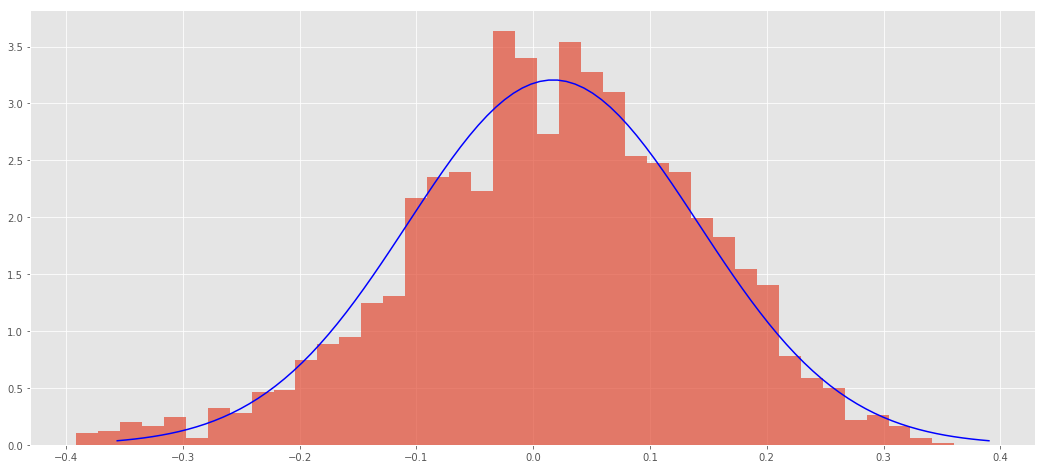

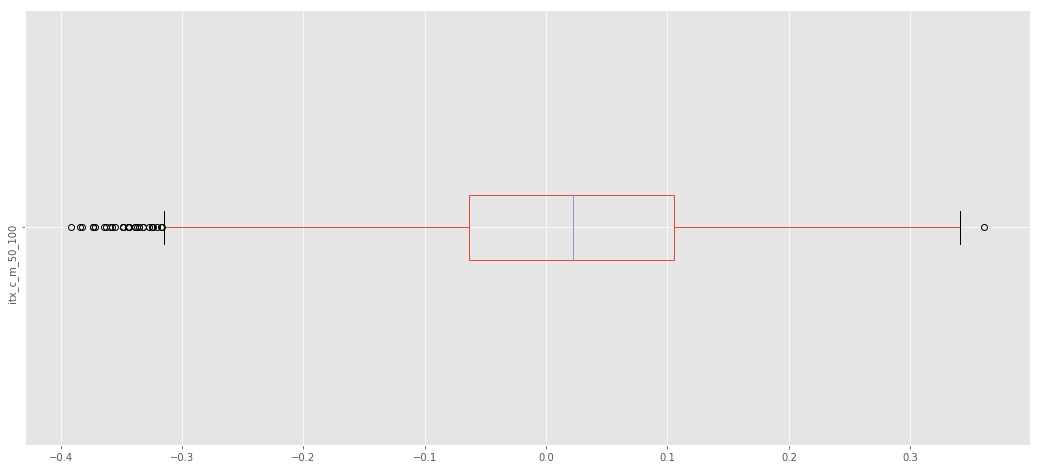

 el valor de 01p es : -0.32269 
 el valor de 05p es : -0.19652 
 el valor de 50p es : 0.022492 
 el valor de 95p es : 0.20833 
 el valor de T-test es : 7.2162 
 el valor de avg es : 0.017 
 el valor de kur es : 0.12038 
 el valor de skw es : -0.30252 
 el valor de std es : 0.12441 
 el valor de val es : -1.0601 
 el valor de var es : 0.015479 


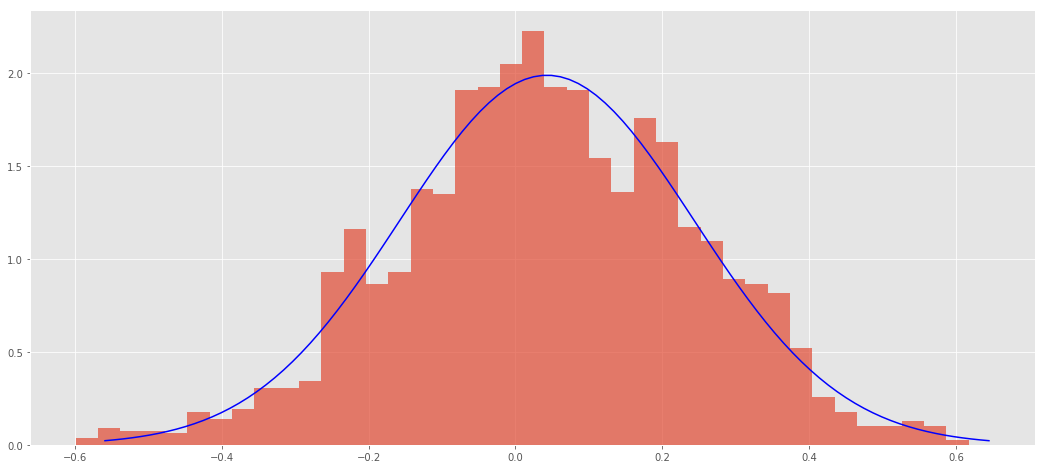

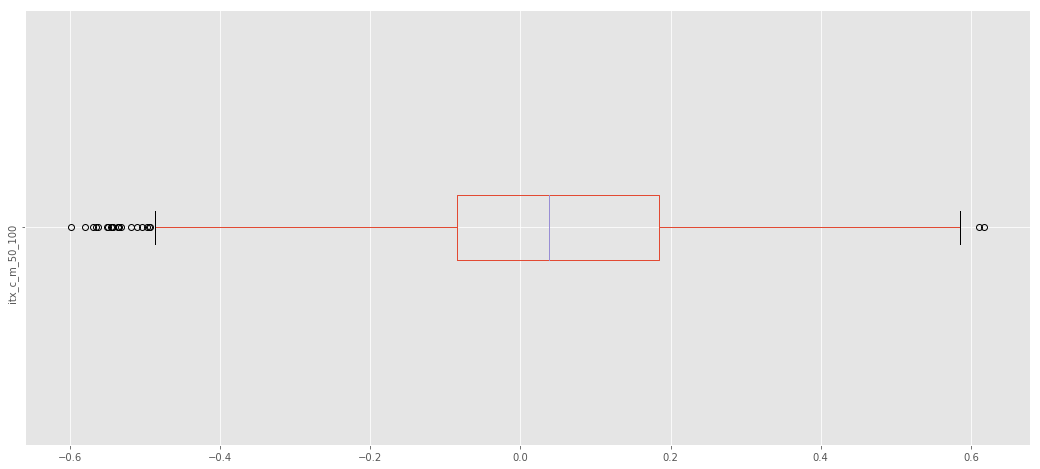

 el valor de 01p es : -0.45102 
 el valor de 05p es : -0.27301 
 el valor de 50p es : 0.038593 
 el valor de 95p es : 0.3663 
 el valor de T-test es : 11.063 
 el valor de avg es : 0.043 
 el valor de kur es : -0.041345 
 el valor de skw es : -0.10341 
 el valor de std es : 0.20068 
 el valor de val es : -1.3417 
 el valor de var es : 0.040274 


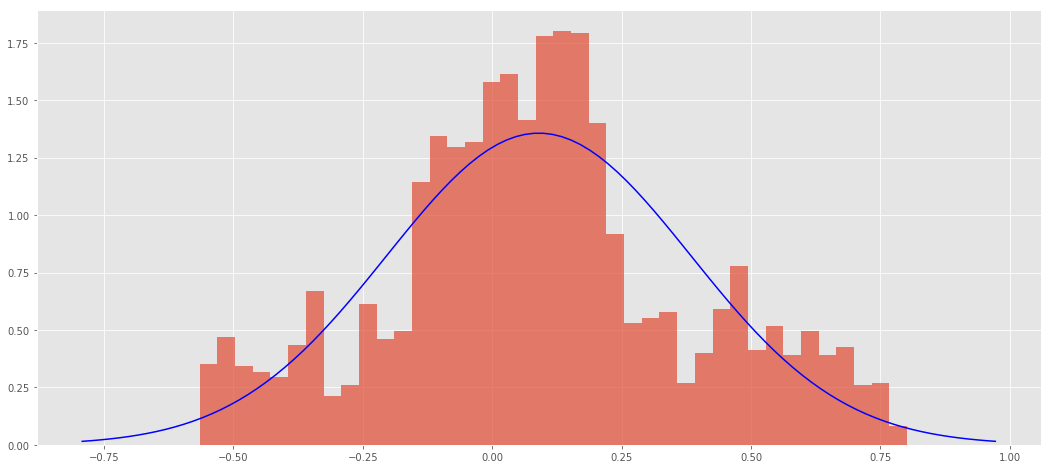

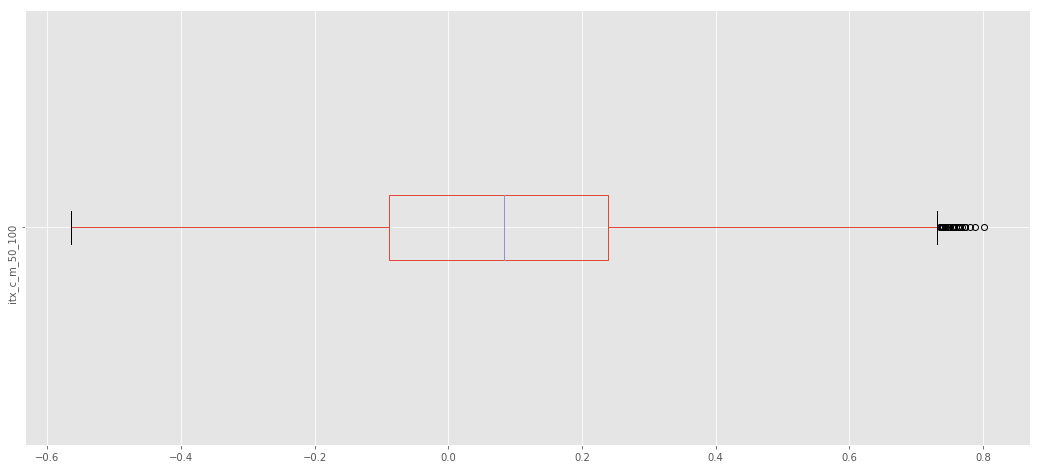

 el valor de 01p es : -0.5339 
 el valor de 05p es : -0.4296 
 el valor de 50p es : 0.083842 
 el valor de 95p es : 0.62737 
 el valor de T-test es : 15.957 
 el valor de avg es : 0.09 
 el valor de kur es : -0.21798 
 el valor de skw es : 0.11844 
 el valor de std es : 0.29398 
 el valor de val es : -1.4604 
 el valor de var es : 0.086423 


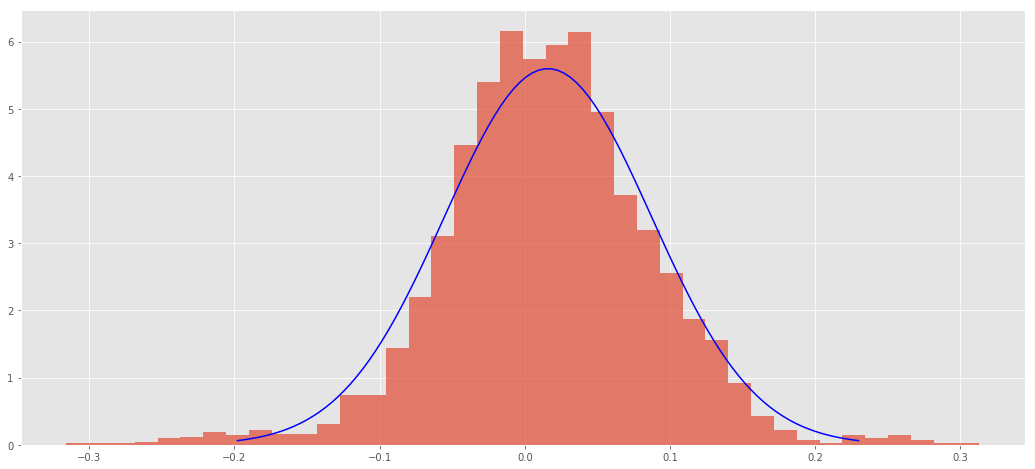

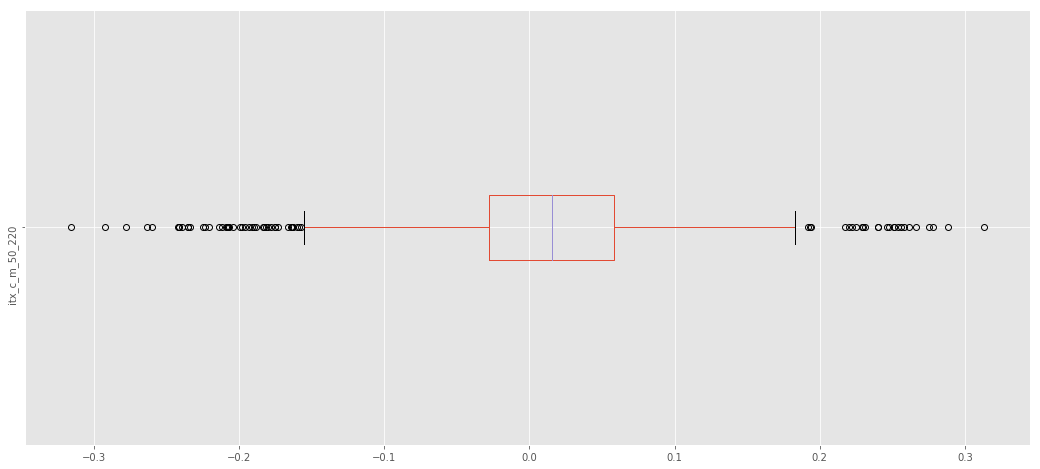

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


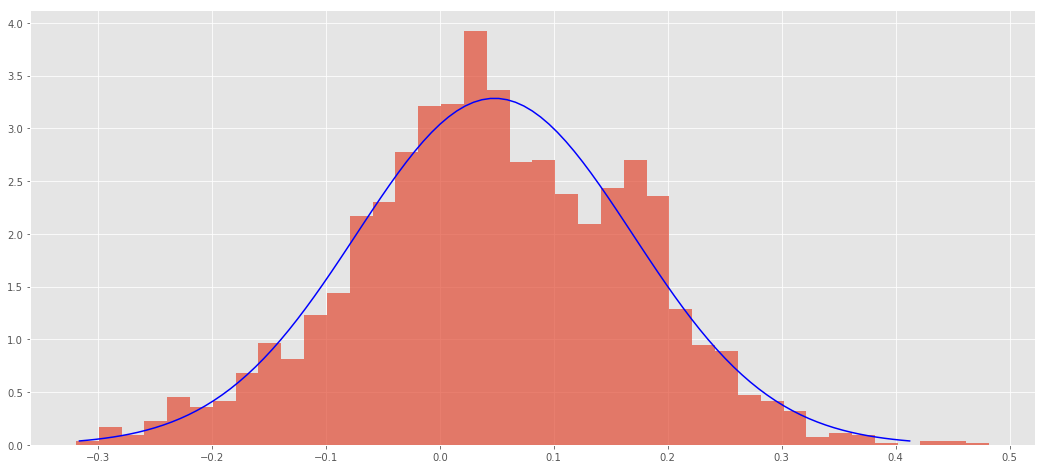

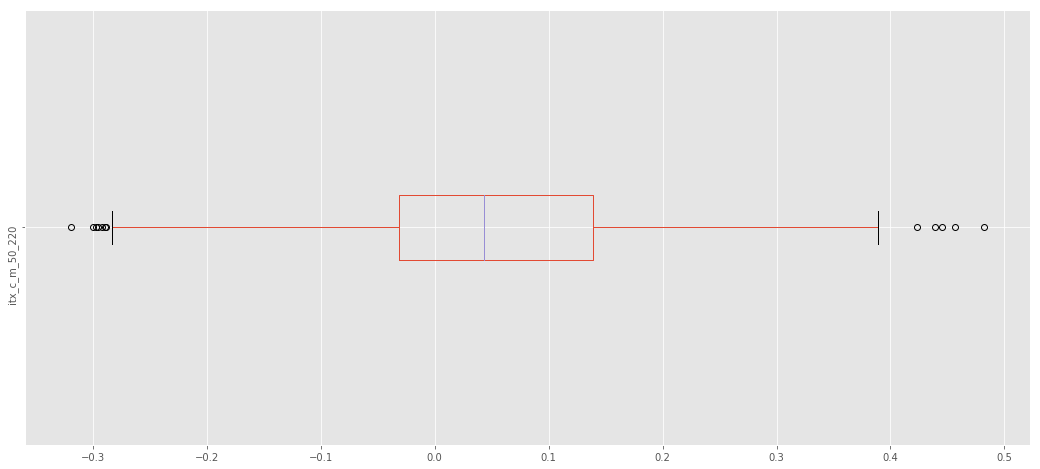

 el valor de 01p es : -0.24111 
 el valor de 05p es : -0.15792 
 el valor de 50p es : 0.043311 
 el valor de 95p es : 0.24133 
 el valor de T-test es : 20.564 
 el valor de avg es : 0.048 
 el valor de kur es : -0.048797 
 el valor de skw es : -0.064696 
 el valor de std es : 0.12144 
 el valor de val es : -1.5282 
 el valor de var es : 0.014748 


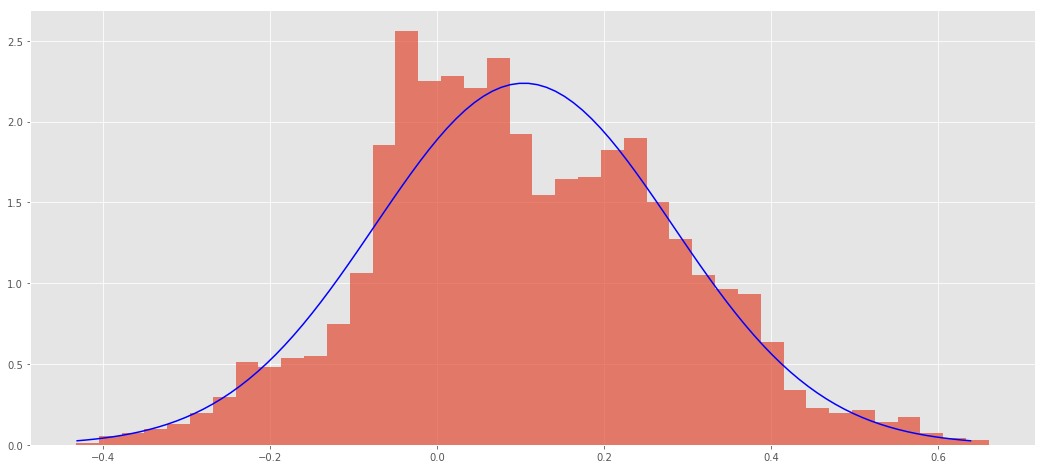

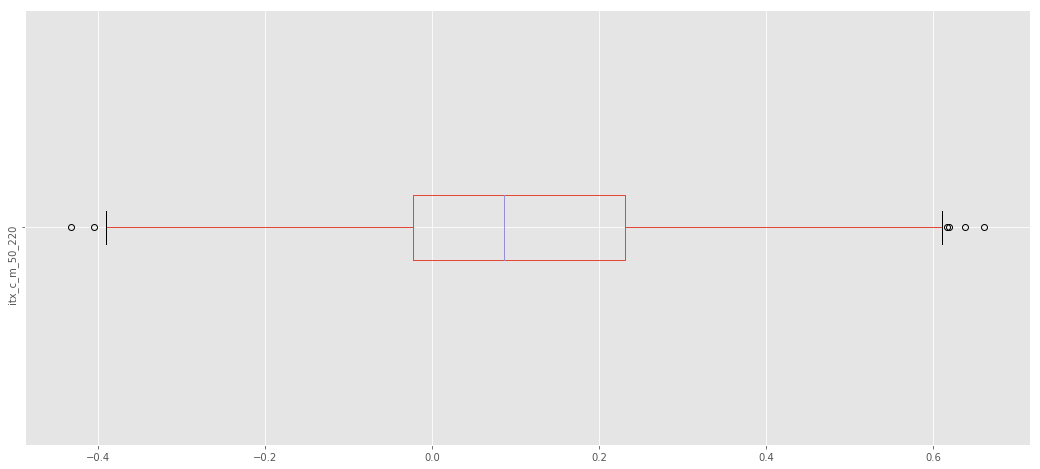

 el valor de 01p es : -0.29475 
 el valor de 05p es : -0.18715 
 el valor de 50p es : 0.086799 
 el valor de 95p es : 0.39535 
 el valor de T-test es : 30.24 
 el valor de avg es : 0.104 
 el valor de kur es : -0.15825 
 el valor de skw es : 0.13078 
 el valor de std es : 0.17826 
 el valor de val es : -2.1125 
 el valor de var es : 0.031777 


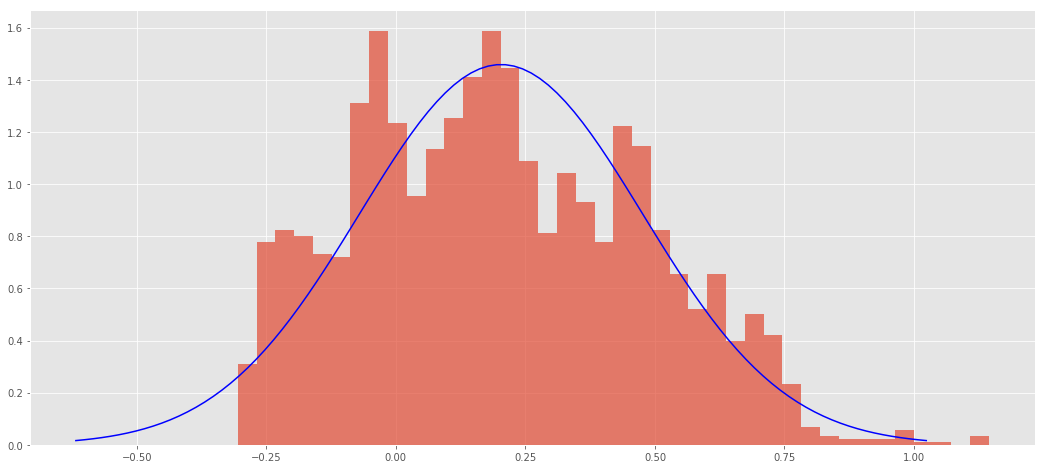

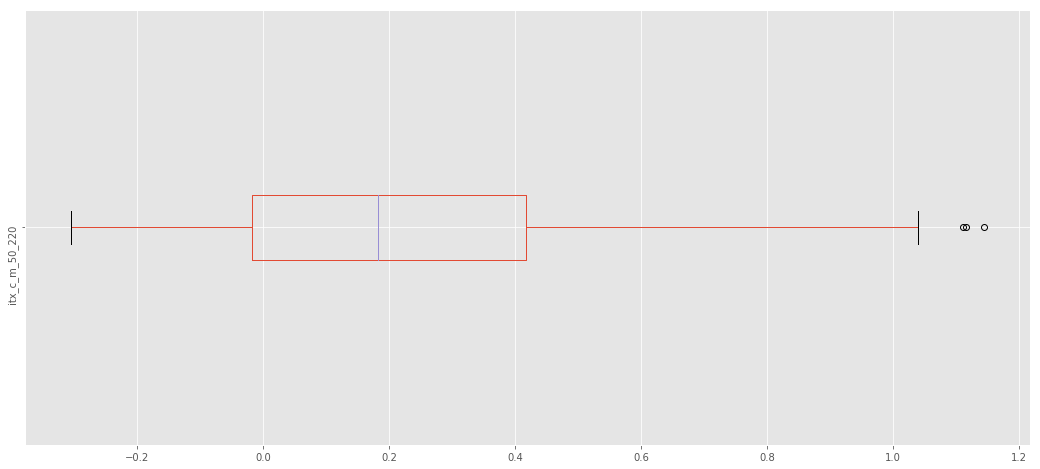

 el valor de 01p es : -0.27202 
 el valor de 05p es : -0.21995 
 el valor de 50p es : 0.18267 
 el valor de 95p es : 0.67752 
 el valor de T-test es : 38.534 
 el valor de avg es : 0.203 
 el valor de kur es : -0.59555 
 el valor de skw es : 0.28824 
 el valor de std es : 0.27354 
 el valor de val es : -3.0803 
 el valor de var es : 0.074822 


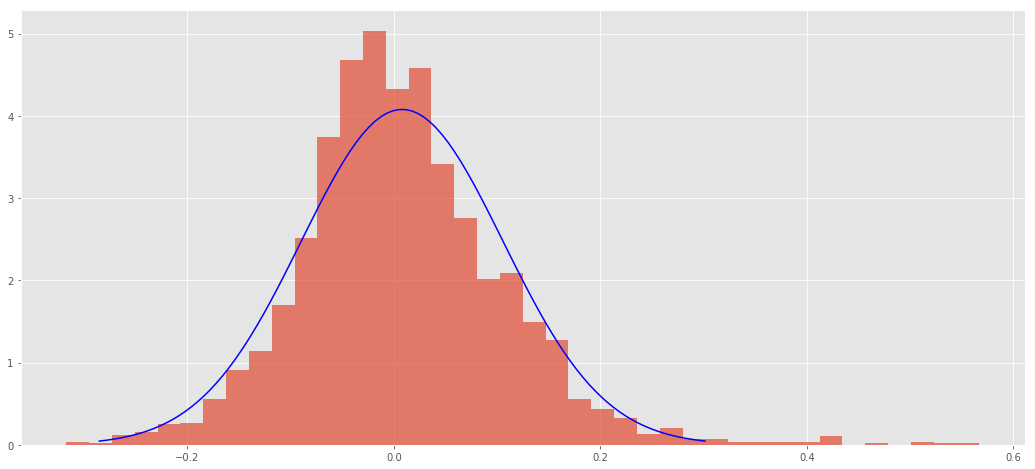

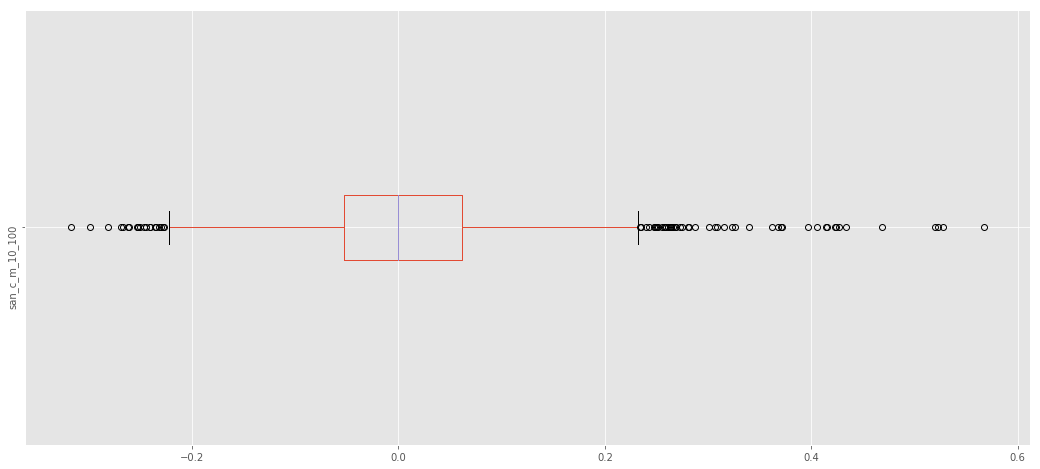

 el valor de 01p es : -0.21286 
 el valor de 05p es : -0.14101 
 el valor de 50p es : 4.4409e-16 
 el valor de 95p es : 0.16563 
 el valor de T-test es : 4.0537 
 el valor de avg es : 0.008 
 el valor de kur es : 2.2943 
 el valor de skw es : 0.6552 
 el valor de std es : 0.097793 
 el valor de val es : -1.1746 
 el valor de var es : 0.0095635 


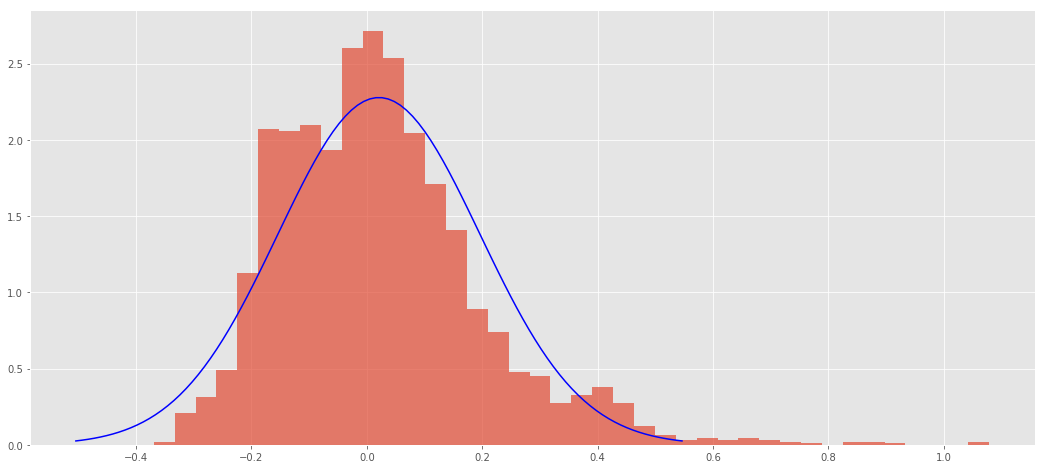

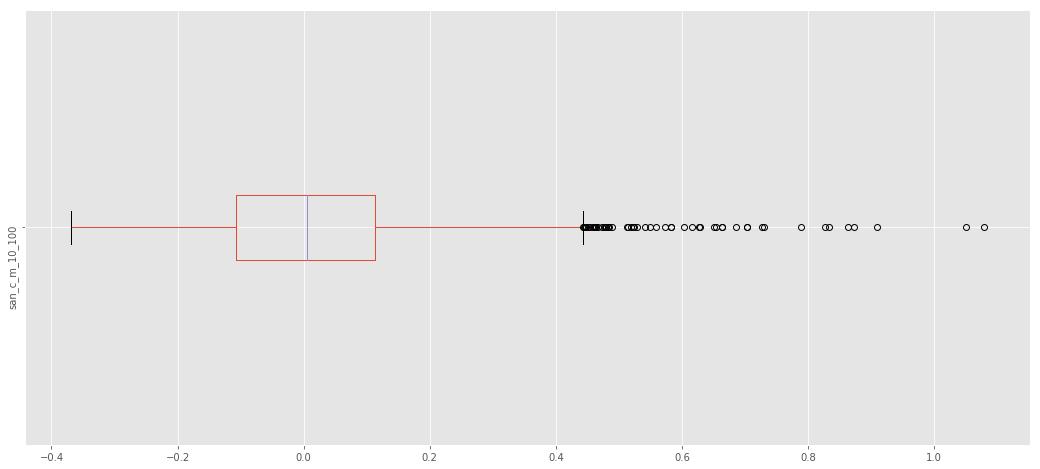

 el valor de 01p es : -0.2825 
 el valor de 05p es : -0.20996 
 el valor de 50p es : 0.004629 
 el valor de 95p es : 0.36047 
 el valor de T-test es : 6.354 
 el valor de avg es : 0.021 
 el valor de kur es : 2.4193 
 el valor de skw es : 1.0634 
 el valor de std es : 0.17515 
 el valor de val es : -1.7168 
 el valor de var es : 0.030679 


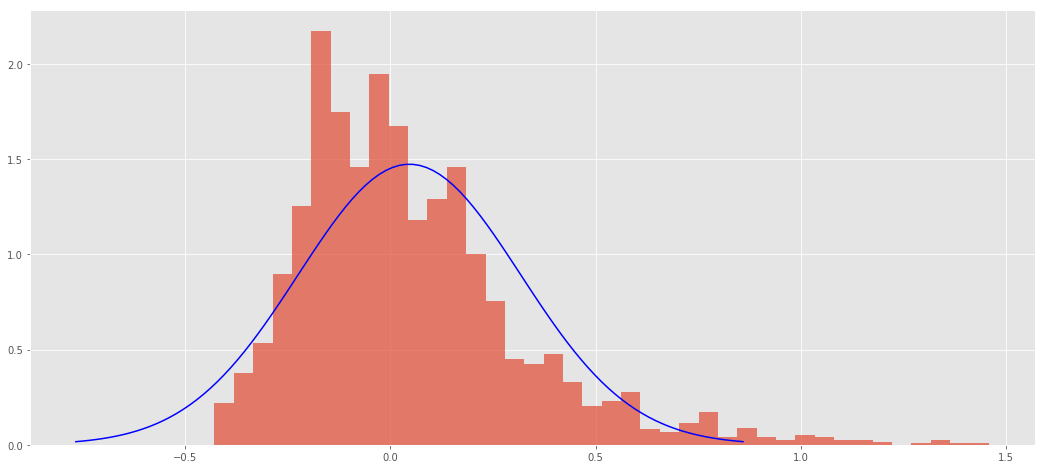

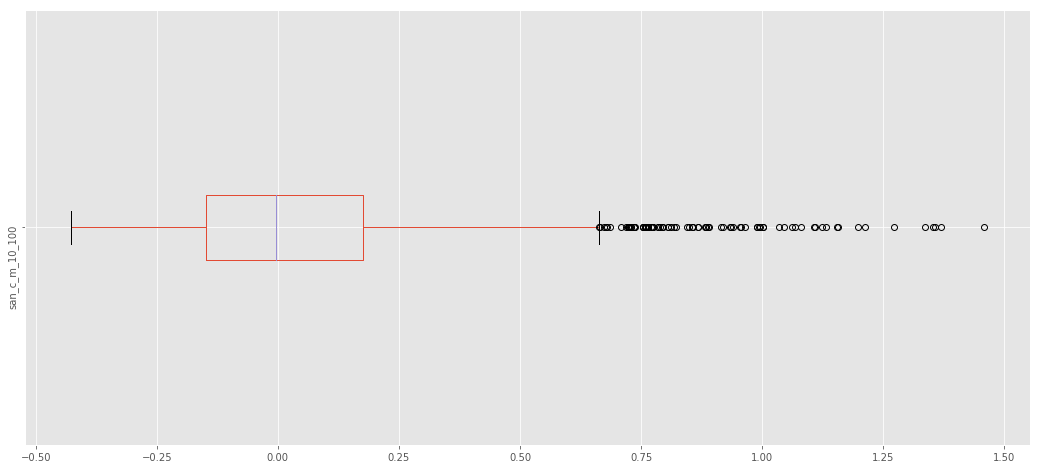

 el valor de 01p es : -0.38117 
 el valor de 05p es : -0.29104 
 el valor de 50p es : -0.0036073 
 el valor de 95p es : 0.57263 
 el valor de T-test es : 9.0889 
 el valor de avg es : 0.047 
 el valor de kur es : 2.5532 
 el valor de skw es : 1.3008 
 el valor de std es : 0.27068 
 el valor de val es : -1.9675 
 el valor de var es : 0.073266 


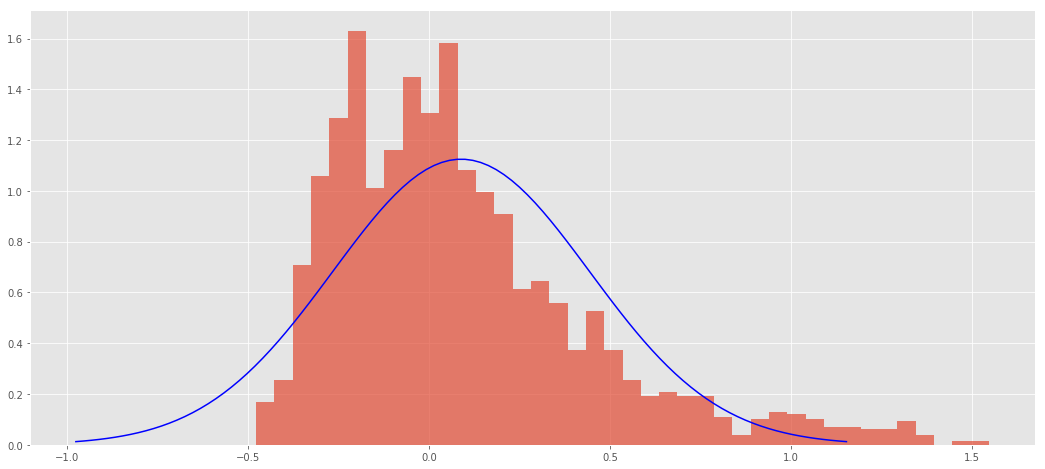

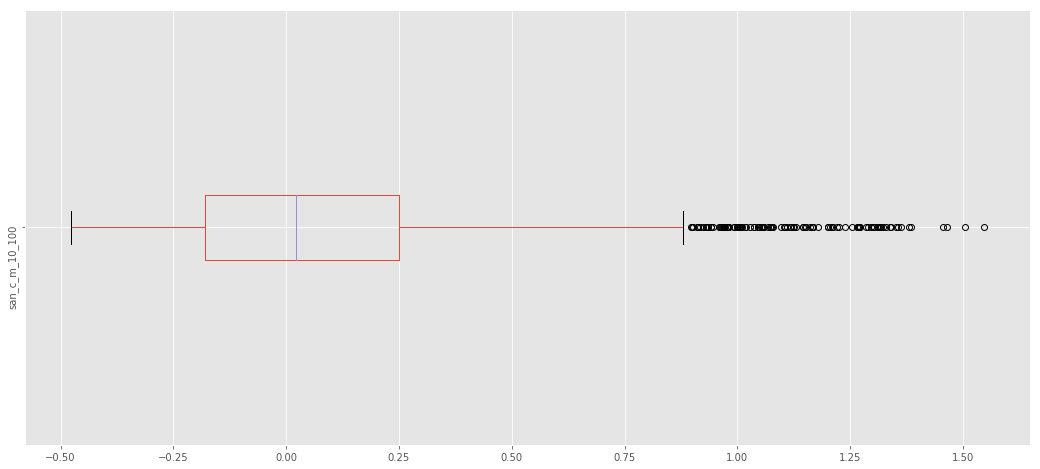

 el valor de 01p es : -0.41525 
 el valor de 05p es : -0.33432 
 el valor de 50p es : 0.022776 
 el valor de 95p es : 0.80279 
 el valor de T-test es : 13.05 
 el valor de avg es : 0.089 
 el valor de kur es : 1.6509 
 el valor de skw es : 1.2417 
 el valor de std es : 0.35463 
 el valor de val es : -2.4013 
 el valor de var es : 0.12577 


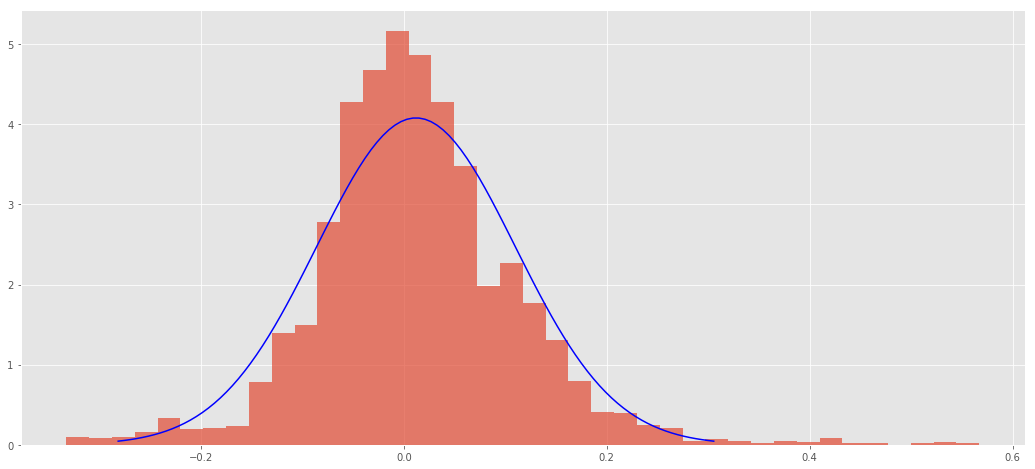

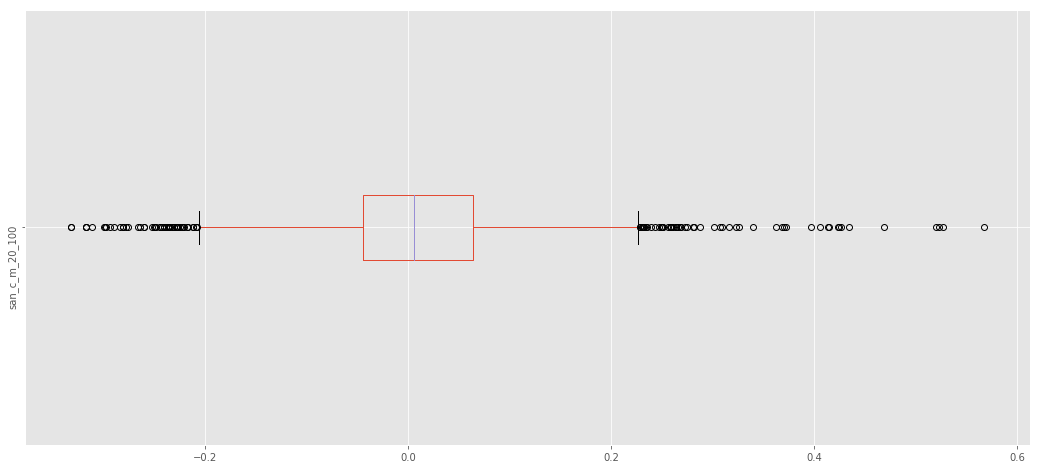

 el valor de 01p es : -0.24122 
 el valor de 05p es : -0.12929 
 el valor de 50p es : 0.0056788 
 el valor de 95p es : 0.16747 
 el valor de T-test es : 6.6088 
 el valor de avg es : 0.012 
 el valor de kur es : 2.637 
 el valor de skw es : 0.46818 
 el valor de std es : 0.097816 
 el valor de val es : -1.2953 
 el valor de var es : 0.009568 


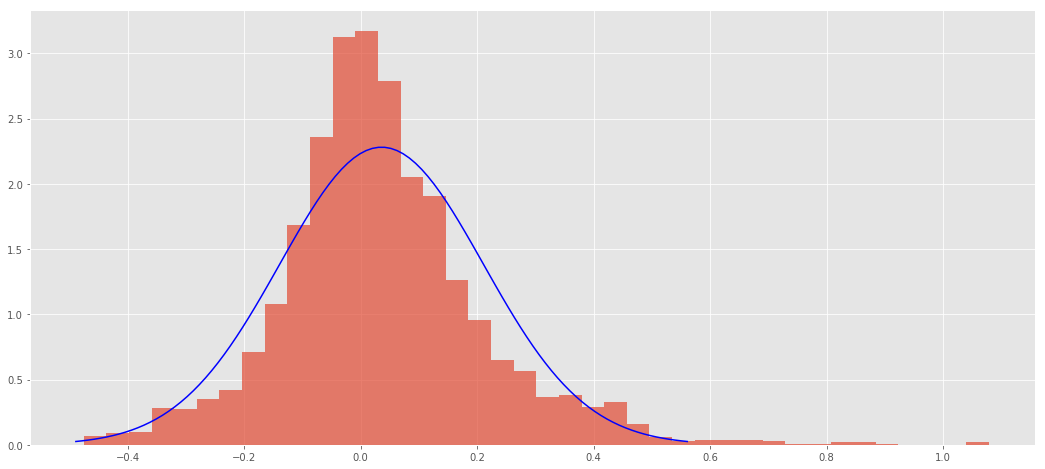

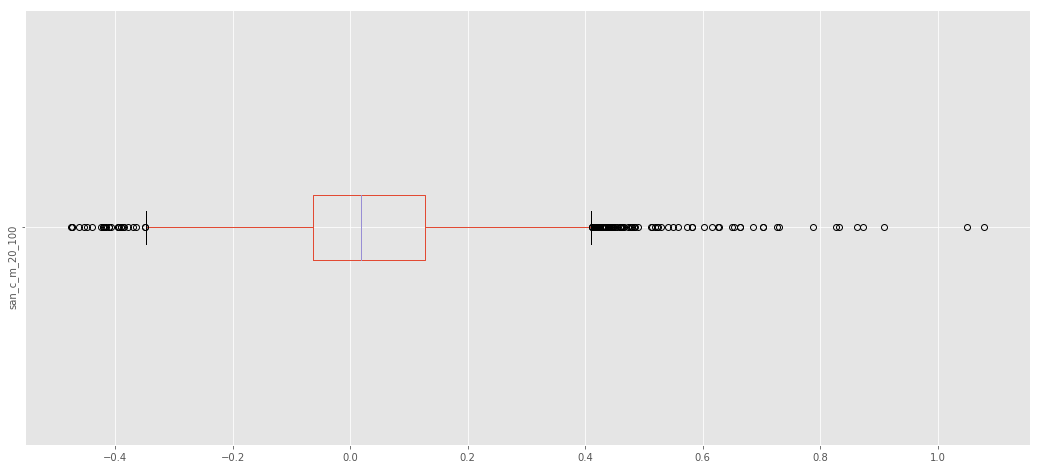

 el valor de 01p es : -0.34928 
 el valor de 05p es : -0.23005 
 el valor de 50p es : 0.018347 
 el valor de 95p es : 0.36077 
 el valor de T-test es : 10.83 
 el valor de avg es : 0.036 
 el valor de kur es : 2.581 
 el valor de skw es : 0.75801 
 el valor de std es : 0.17493 
 el valor de val es : -1.5682 
 el valor de var es : 0.030601 


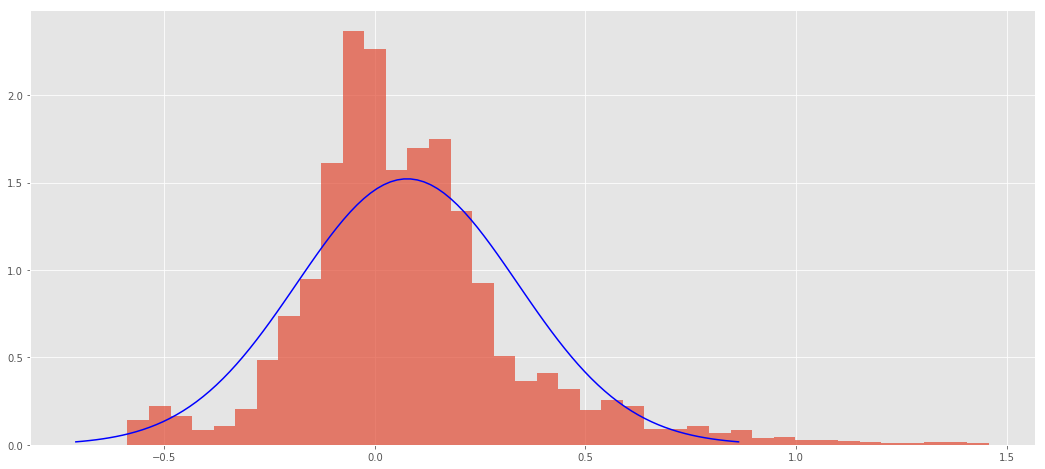

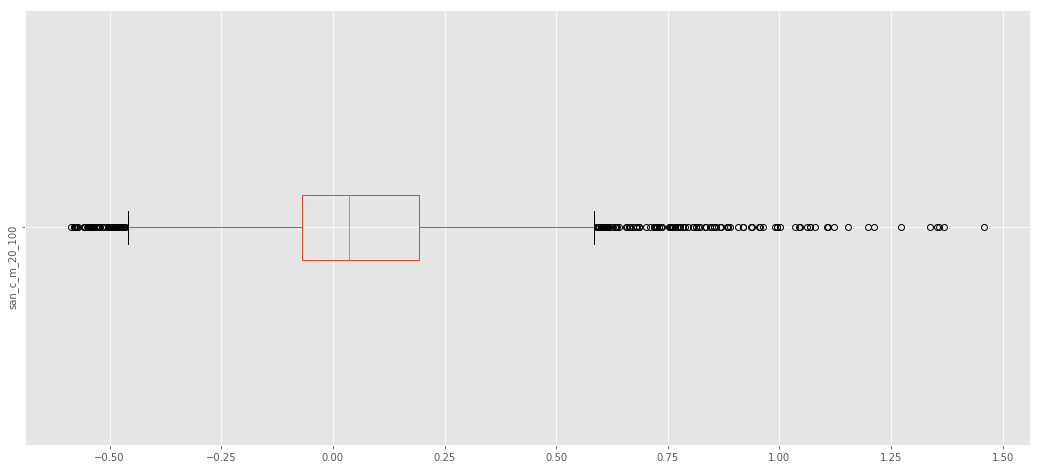

 el valor de 01p es : -0.52496 
 el valor de 05p es : -0.27191 
 el valor de 50p es : 0.03725 
 el valor de 95p es : 0.56778 
 el valor de T-test es : 15.344 
 el valor de avg es : 0.077 
 el valor de kur es : 2.8599 
 el valor de skw es : 0.98813 
 el valor de std es : 0.26216 
 el valor de val es : -2.0881 
 el valor de var es : 0.068727 


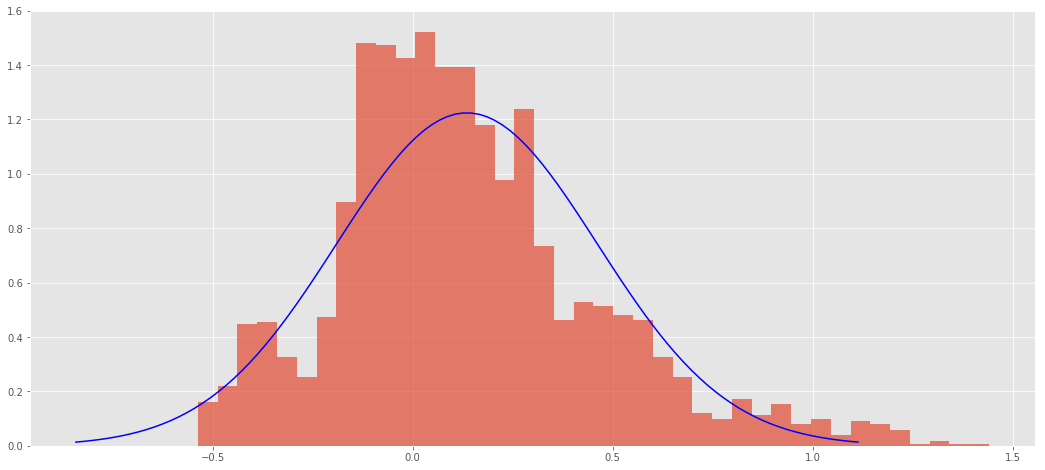

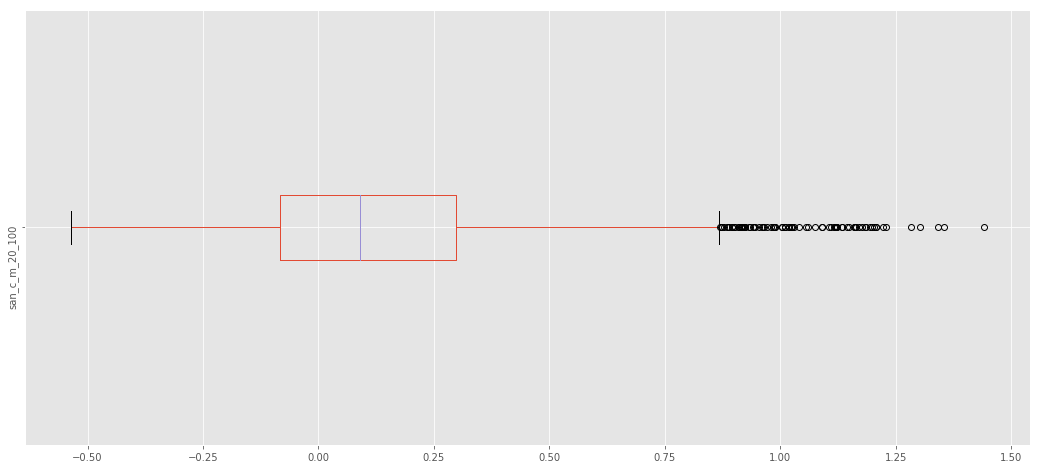

 el valor de 01p es : -0.47686 
 el valor de 05p es : -0.36901 
 el valor de 50p es : 0.090638 
 el valor de 95p es : 0.75603 
 el valor de T-test es : 21.742 
 el valor de avg es : 0.136 
 el valor de kur es : 0.88005 
 el valor de skw es : 0.76034 
 el valor de std es : 0.32588 
 el valor de val es : -2.0488 
 el valor de var es : 0.10619 


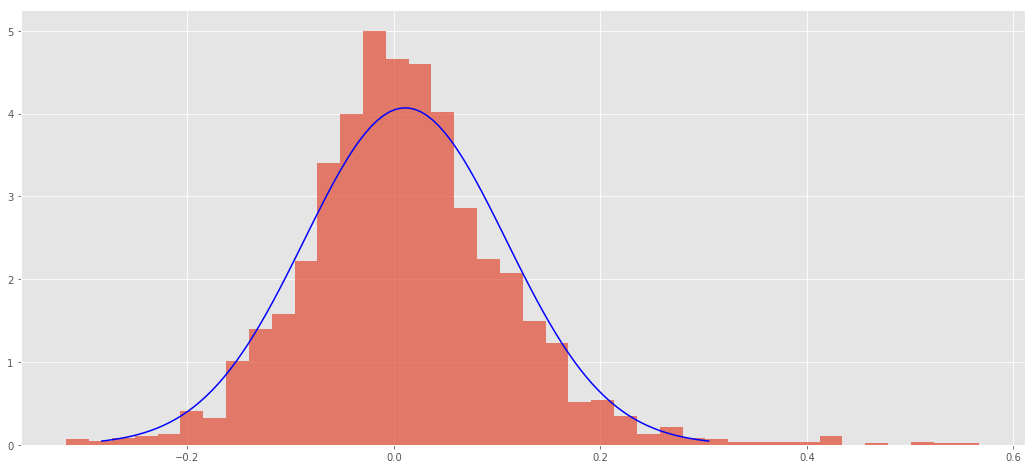

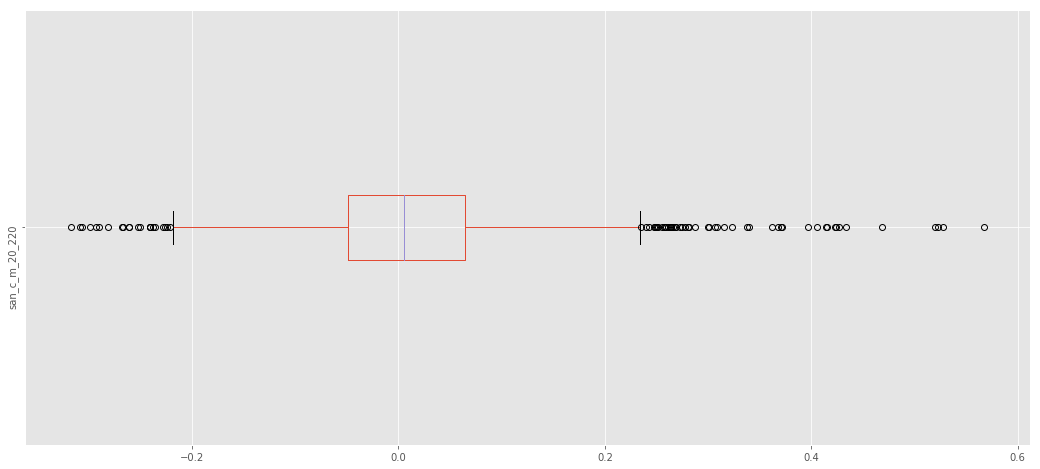

 el valor de 01p es : -0.20511 
 el valor de 05p es : -0.13853 
 el valor de 50p es : 0.0056788 
 el valor de 95p es : 0.16747 
 el valor de T-test es : 5.925 
 el valor de avg es : 0.011 
 el valor de kur es : 2.2741 
 el valor de skw es : 0.59203 
 el valor de std es : 0.097994 
 el valor de val es : -1.209 
 el valor de var es : 0.0096027 


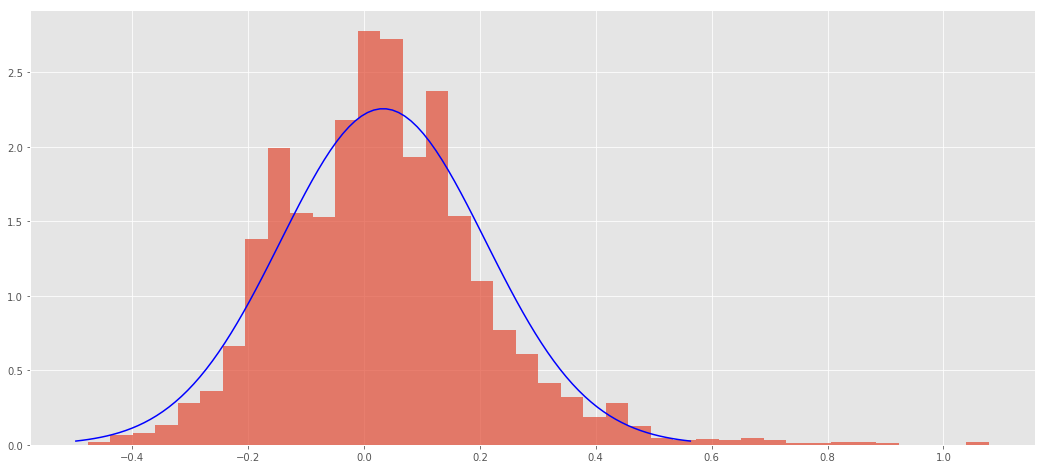

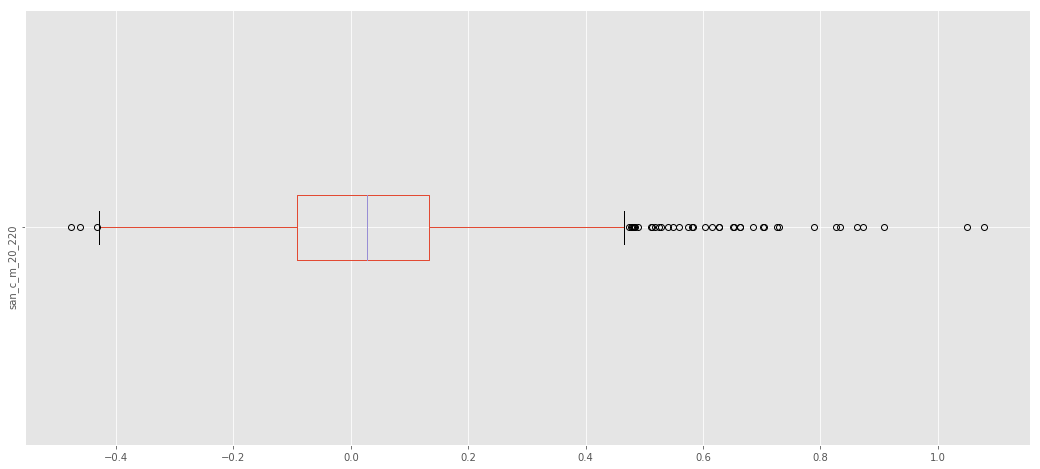

 el valor de 01p es : -0.32852 
 el valor de 05p es : -0.22211 
 el valor de 50p es : 0.027102 
 el valor de 95p es : 0.33466 
 el valor de T-test es : 9.6803 
 el valor de avg es : 0.033 
 el valor de kur es : 2.1005 
 el valor de skw es : 0.72211 
 el valor de std es : 0.17676 
 el valor de val es : -1.5067 
 el valor de var es : 0.031244 


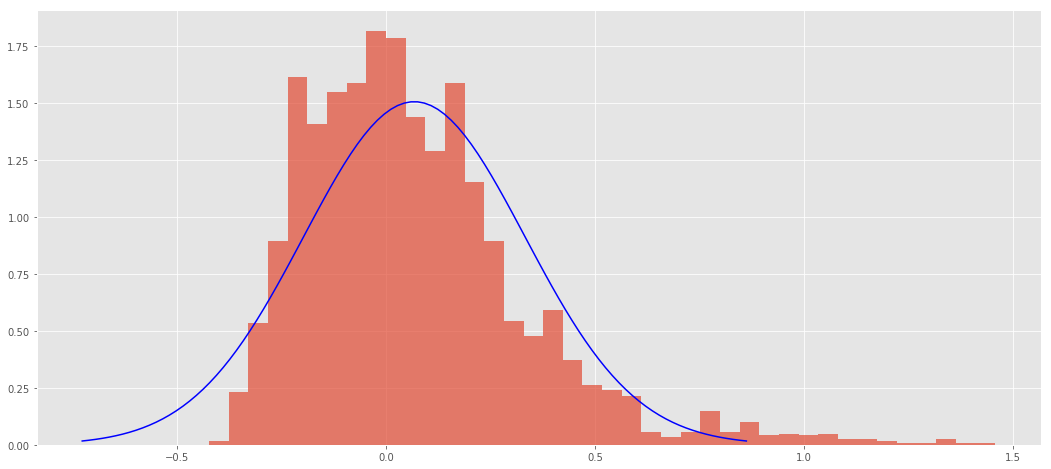

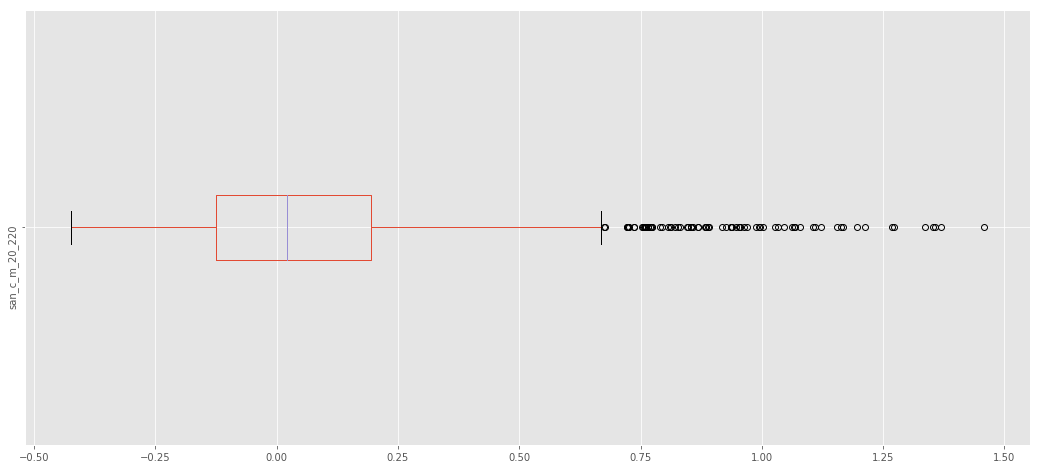

 el valor de 01p es : -0.33923 
 el valor de 05p es : -0.26293 
 el valor de 50p es : 0.021286 
 el valor de 95p es : 0.54508 
 el valor de T-test es : 13.142 
 el valor de avg es : 0.067 
 el valor de kur es : 2.7496 
 el valor de skw es : 1.2973 
 el valor de std es : 0.26495 
 el valor de val es : -2.0731 
 el valor de var es : 0.070201 


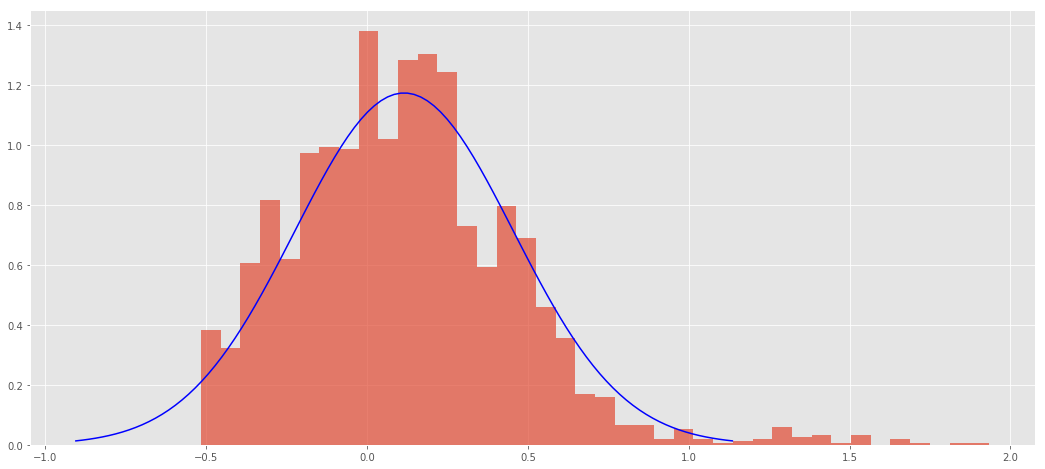

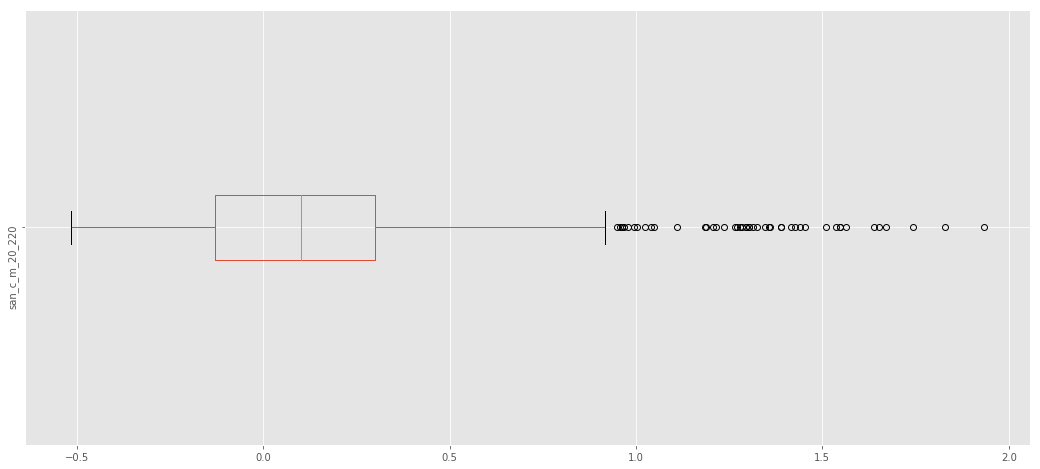

 el valor de 01p es : -0.48316 
 el valor de 05p es : -0.37527 
 el valor de 50p es : 0.10191 
 el valor de 95p es : 0.64275 
 el valor de T-test es : 17.594 
 el valor de avg es : 0.115 
 el valor de kur es : 2.08 
 el valor de skw es : 0.8757 
 el valor de std es : 0.34017 
 el valor de val es : -1.7128 
 el valor de var es : 0.11572 


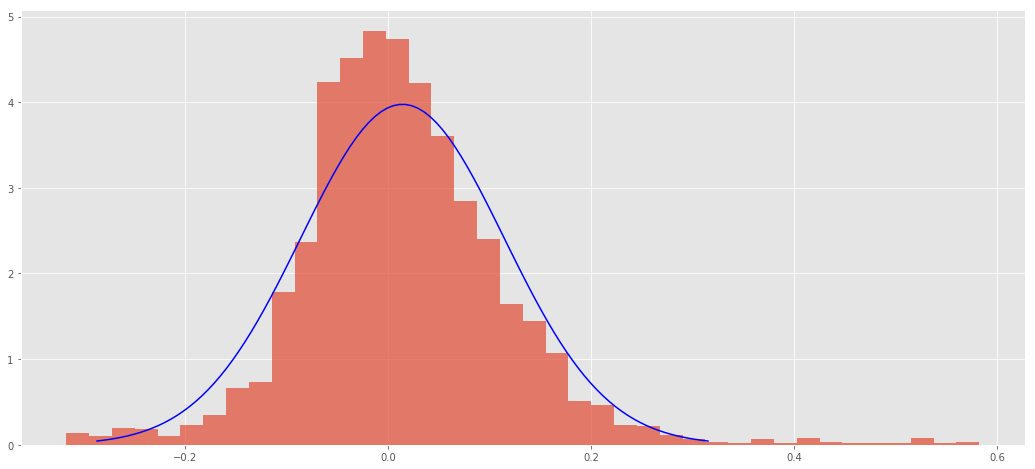

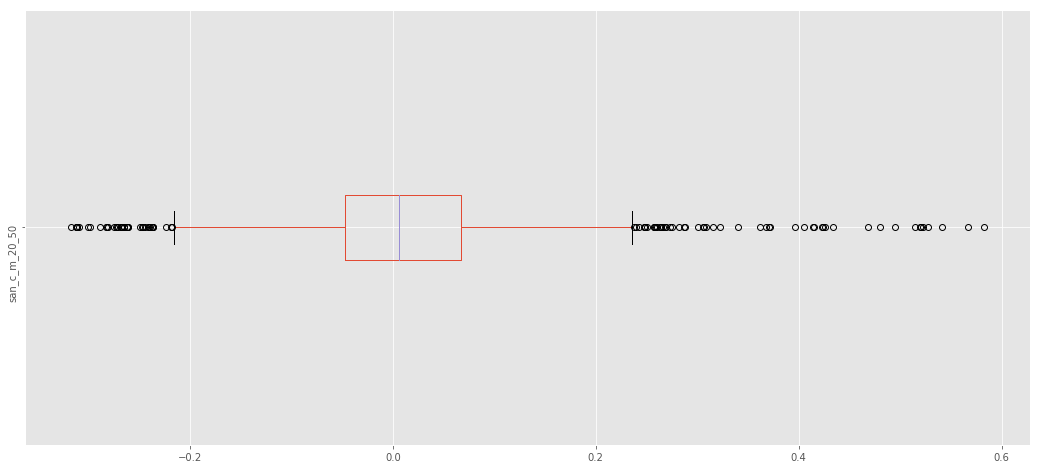

 el valor de 01p es : -0.24757 
 el valor de 05p es : -0.12792 
 el valor de 50p es : 0.0063841 
 el valor de 95p es : 0.17303 
 el valor de T-test es : 7.2336 
 el valor de avg es : 0.014 
 el valor de kur es : 3.4587 
 el valor de skw es : 0.72284 
 el valor de std es : 0.10036 
 el valor de val es : -1.3526 
 el valor de var es : 0.010072 


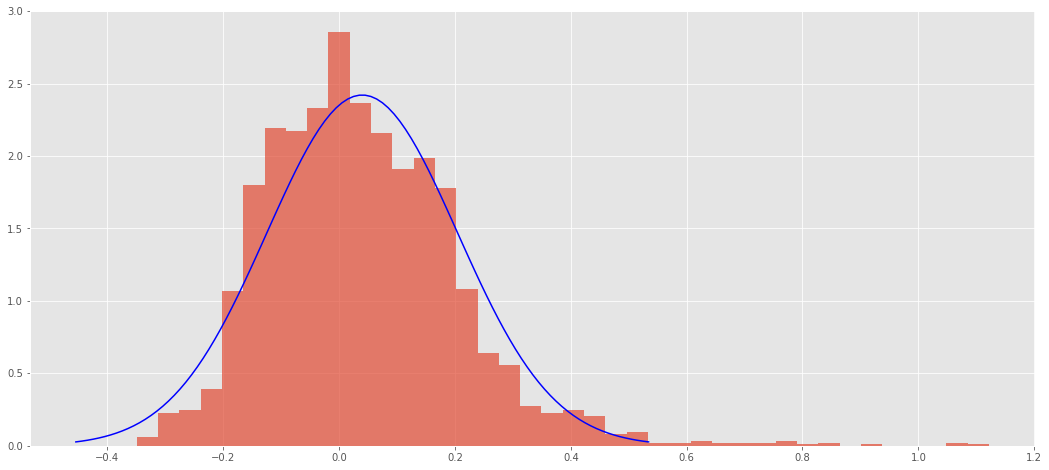

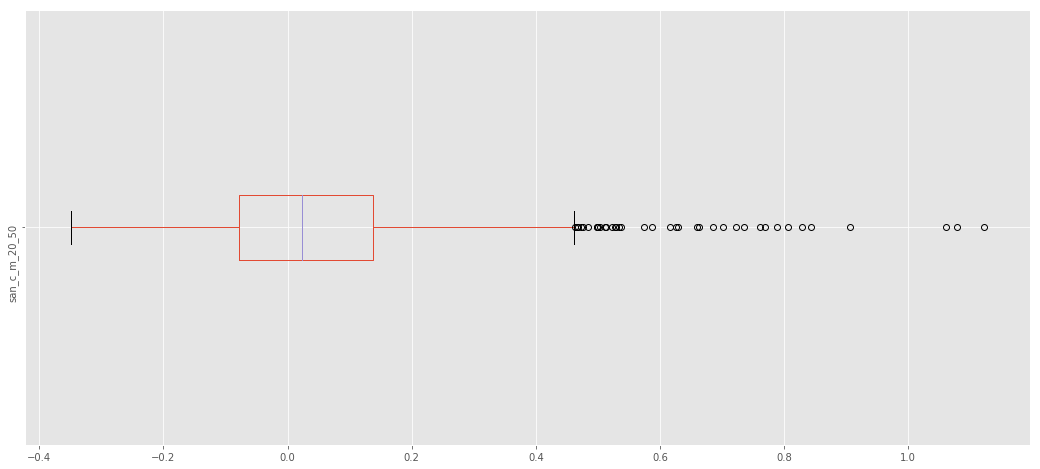

 el valor de 01p es : -0.27726 
 el valor de 05p es : -0.18307 
 el valor de 50p es : 0.023347 
 el valor de 95p es : 0.31379 
 el valor de T-test es : 12.578 
 el valor de avg es : 0.04 
 el valor de kur es : 3.163 
 el valor de skw es : 1.0352 
 el valor de std es : 0.16478 
 el valor de val es : -1.7141 
 el valor de var es : 0.027151 


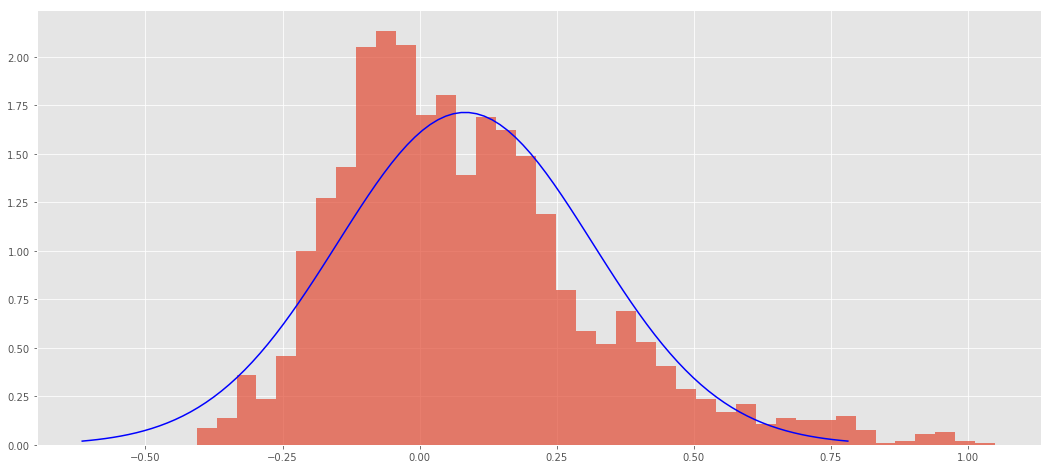

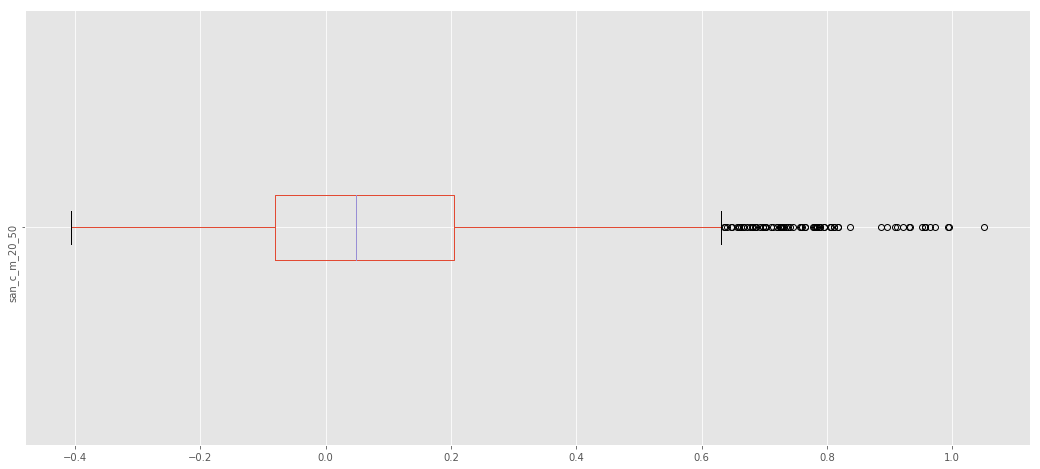

 el valor de 01p es : -0.32664 
 el valor de 05p es : -0.21995 
 el valor de 50p es : 0.04832 
 el valor de 95p es : 0.52444 
 el valor de T-test es : 18.625 
 el valor de avg es : 0.083 
 el valor de kur es : 1.1344 
 el valor de skw es : 0.92684 
 el valor de std es : 0.2328 
 el valor de val es : -2.3844 
 el valor de var es : 0.054194 


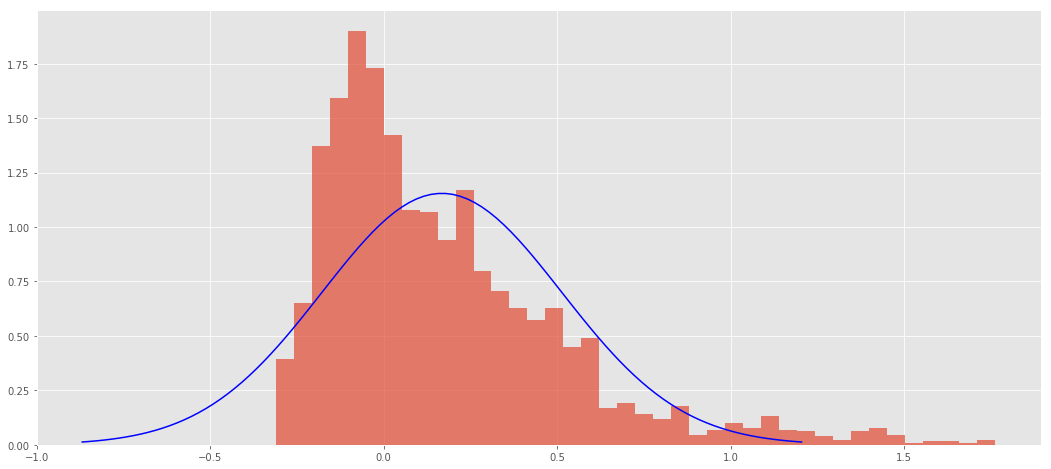

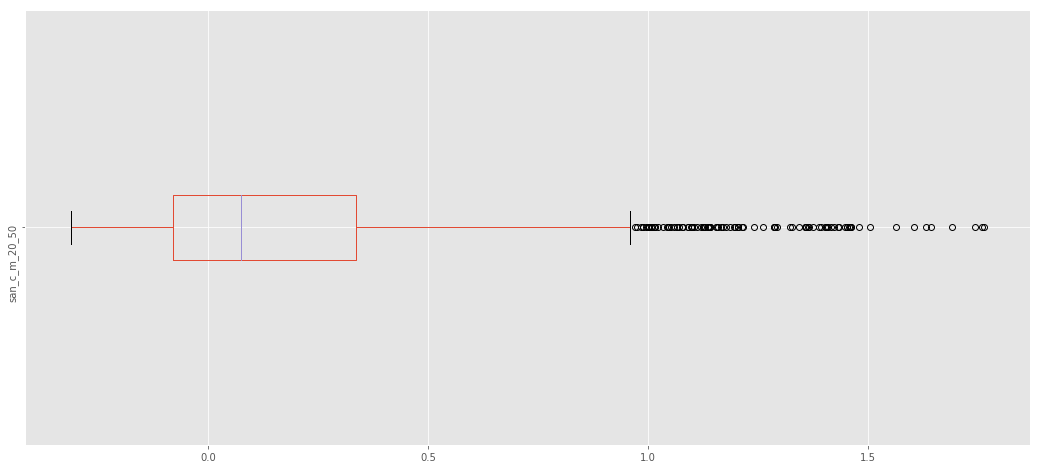

 el valor de 01p es : -0.28421 
 el valor de 05p es : -0.21091 
 el valor de 50p es : 0.07467 
 el valor de 95p es : 0.86104 
 el valor de T-test es : 25.356 
 el valor de avg es : 0.168 
 el valor de kur es : 2.4971 
 el valor de skw es : 1.4443 
 el valor de std es : 0.3455 
 el valor de val es : -4.0825 
 el valor de var es : 0.11937 


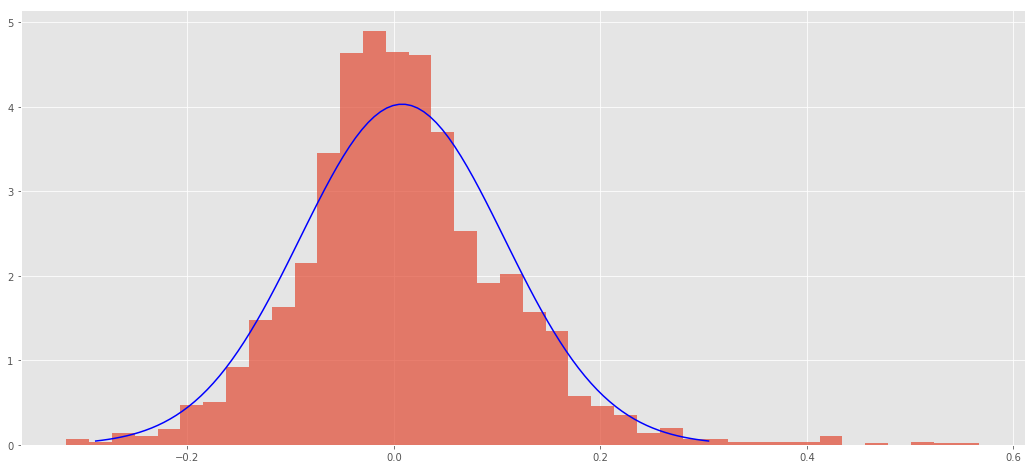

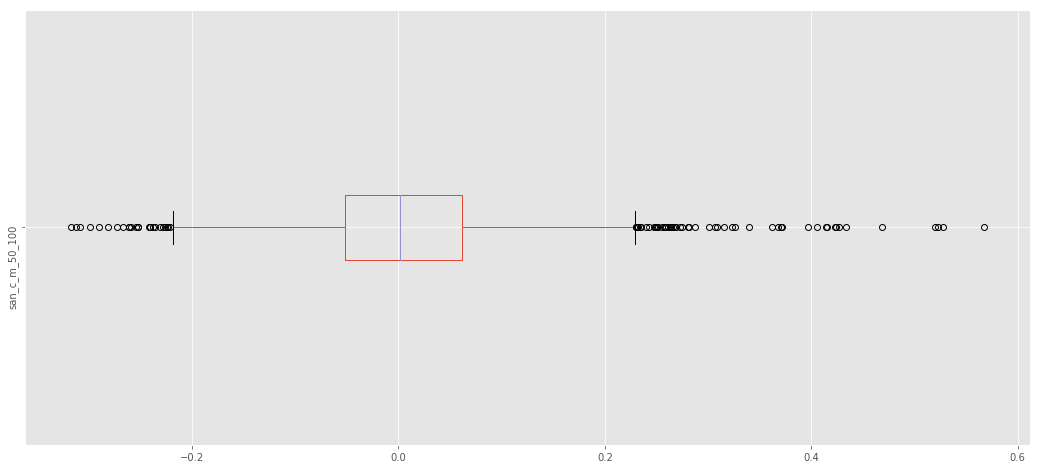

 el valor de 01p es : -0.21751 
 el valor de 05p es : -0.14158 
 el valor de 50p es : 0.0011224 
 el valor de 95p es : 0.16636 
 el valor de T-test es : 4.1343 
 el valor de avg es : 0.008 
 el valor de kur es : 2.213 
 el valor de skw es : 0.59424 
 el valor de std es : 0.098943 
 el valor de val es : -1.175 
 el valor de var es : 0.0097897 


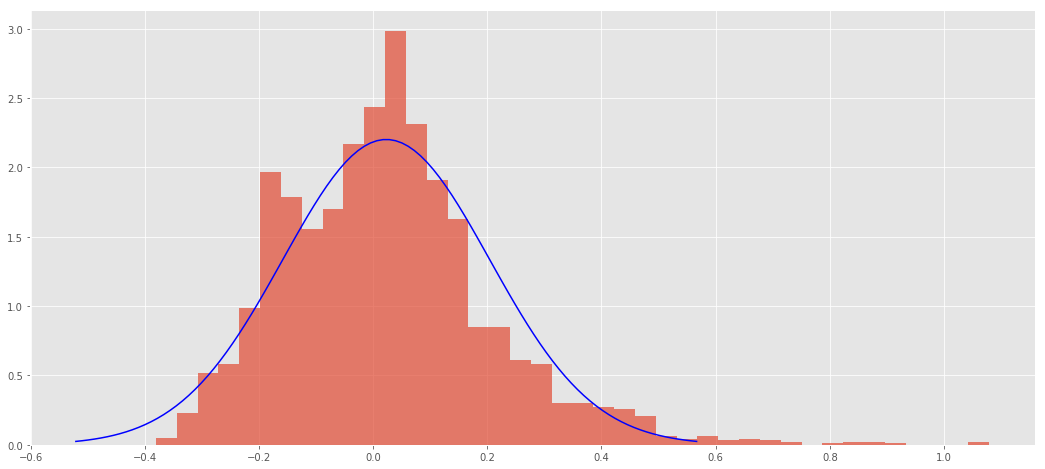

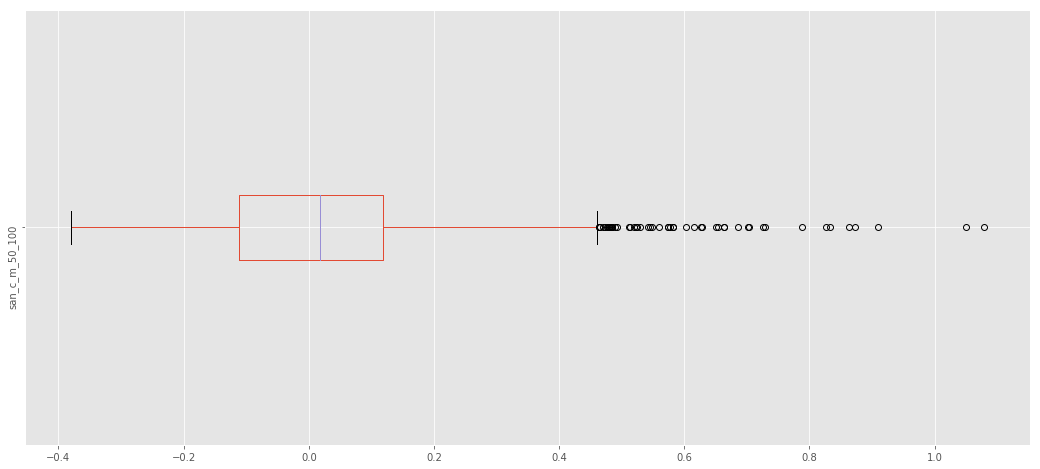

 el valor de 01p es : -0.30771 
 el valor de 05p es : -0.23426 
 el valor de 50p es : 0.018571 
 el valor de 95p es : 0.35336 
 el valor de T-test es : 6.6025 
 el valor de avg es : 0.023 
 el valor de kur es : 1.9798 
 el valor de skw es : 0.8755 
 el valor de std es : 0.18121 
 el valor de val es : -1.5084 
 el valor de var es : 0.032836 


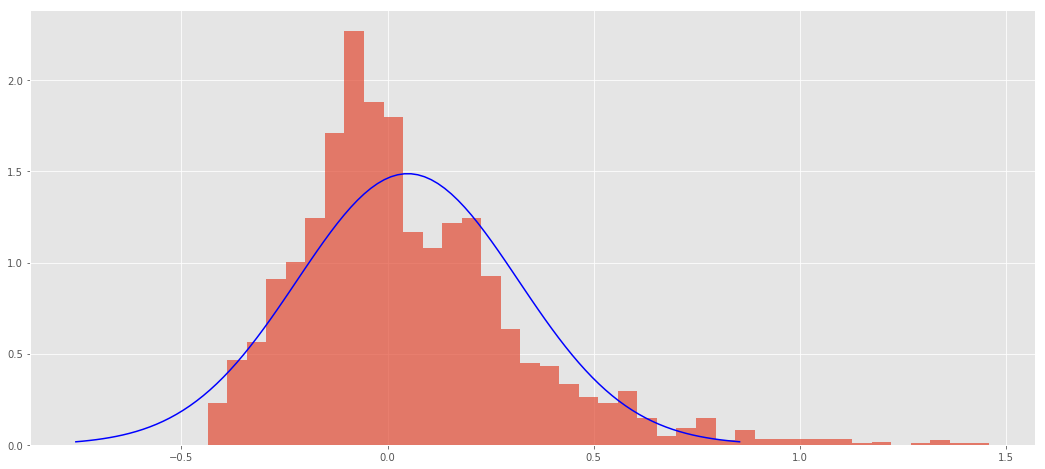

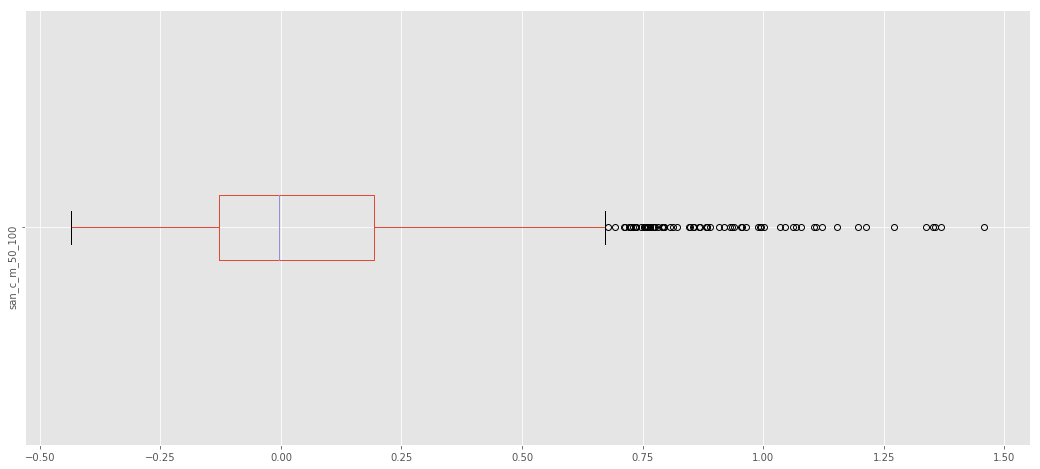

 el valor de 01p es : -0.39023 
 el valor de 05p es : -0.30779 
 el valor de 50p es : -0.004205 
 el valor de 95p es : 0.56036 
 el valor de T-test es : 9.4948 
 el valor de avg es : 0.049 
 el valor de kur es : 2.315 
 el valor de skw es : 1.1737 
 el valor de std es : 0.26813 
 el valor de val es : -1.8206 
 el valor de var es : 0.071893 


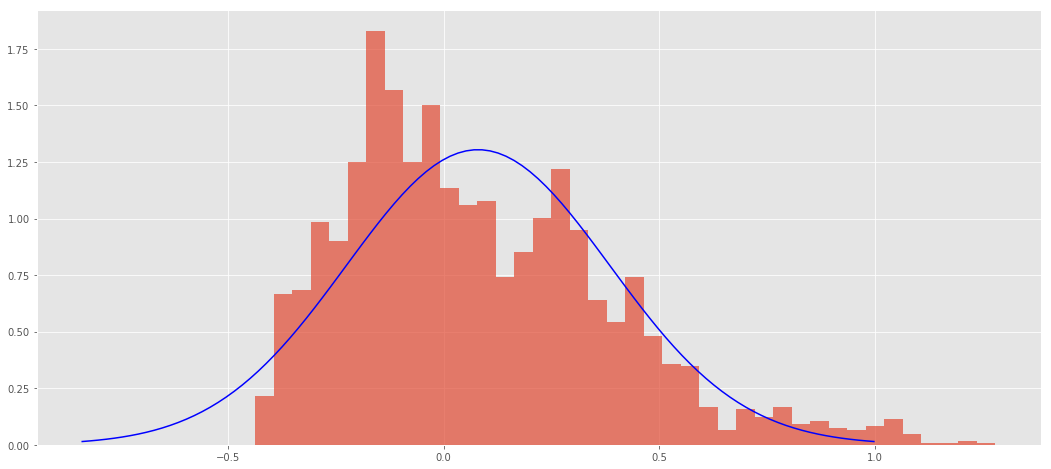

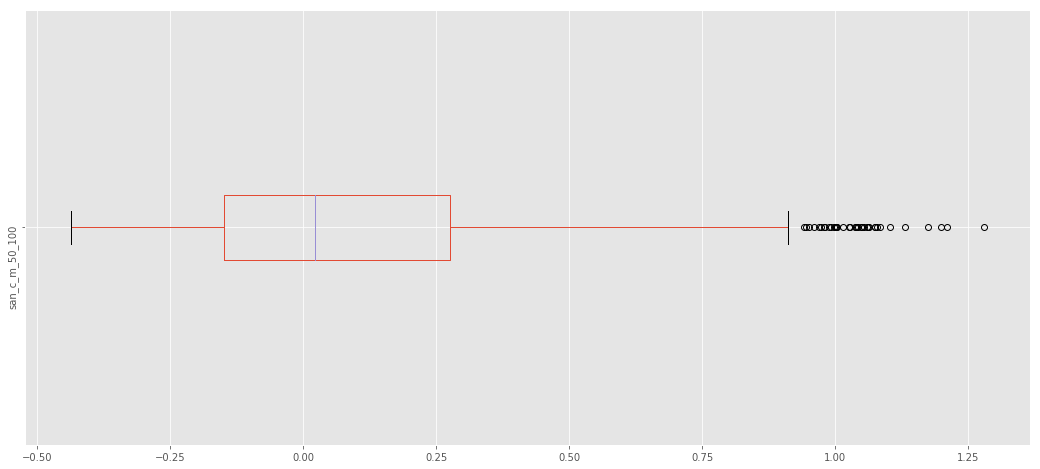

 el valor de 01p es : -0.39072 
 el valor de 05p es : -0.32804 
 el valor de 50p es : 0.02256 
 el valor de 95p es : 0.62351 
 el valor de T-test es : 13.676 
 el valor de avg es : 0.08 
 el valor de kur es : 0.49181 
 el valor de skw es : 0.81051 
 el valor de std es : 0.30585 
 el valor de val es : -1.9007 
 el valor de var es : 0.093547 


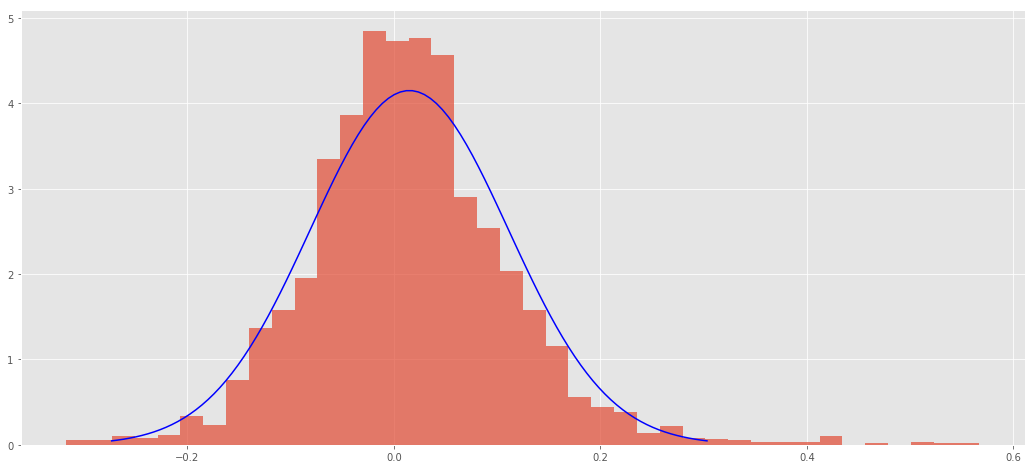

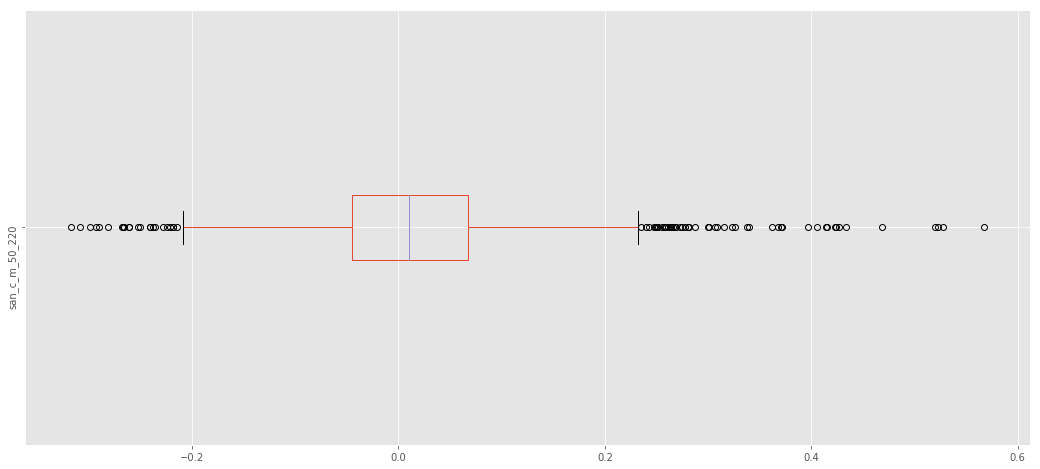

 el valor de 01p es : -0.20354 
 el valor de 05p es : -0.13056 
 el valor de 50p es : 0.010245 
 el valor de 95p es : 0.16682 
 el valor de T-test es : 7.984 
 el valor de avg es : 0.015 
 el valor de kur es : 2.4682 
 el valor de skw es : 0.60506 
 el valor de std es : 0.096119 
 el valor de val es : -1.2777 
 el valor de var es : 0.0092388 


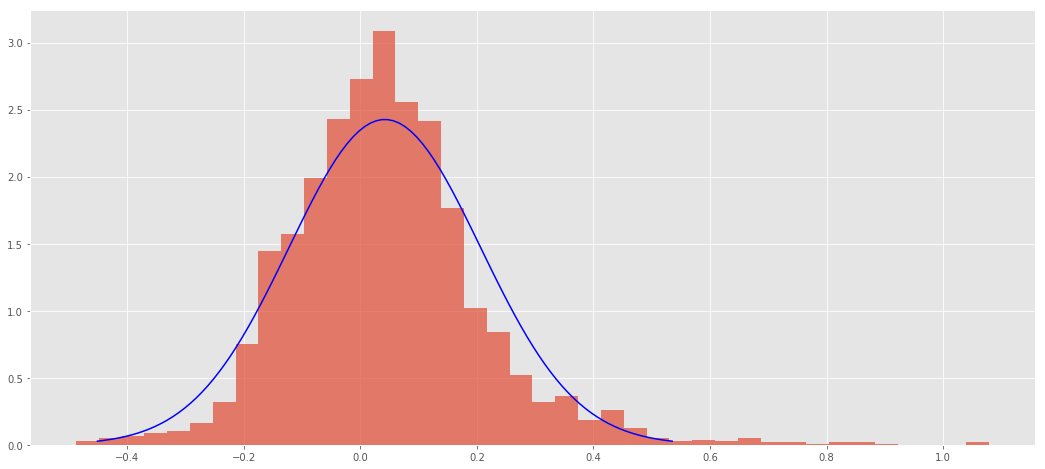

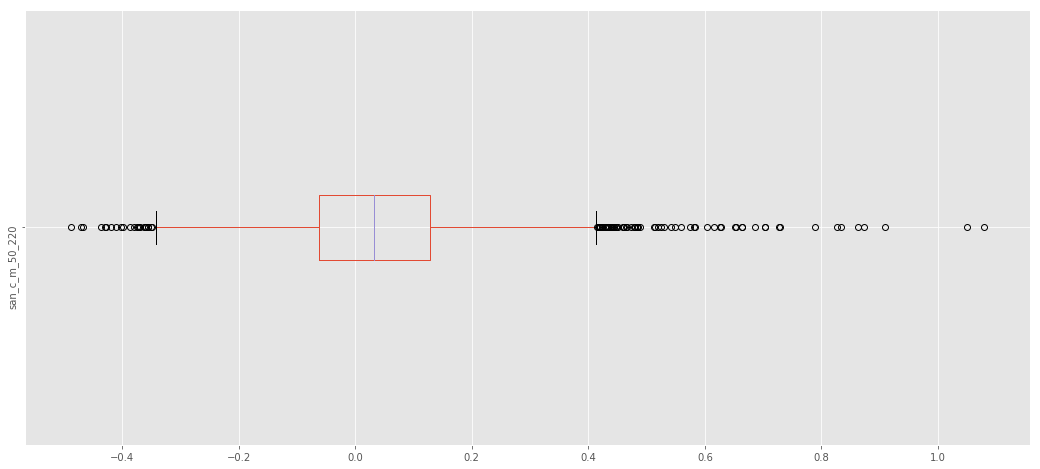

 el valor de 01p es : -0.31781 
 el valor de 05p es : -0.1851 
 el valor de 50p es : 0.03301 
 el valor de 95p es : 0.32794 
 el valor de T-test es : 13.422 
 el valor de avg es : 0.042 
 el valor de kur es : 3.1572 
 el valor de skw es : 0.86897 
 el valor de std es : 0.16437 
 el valor de val es : -1.7717 
 el valor de var es : 0.027017 


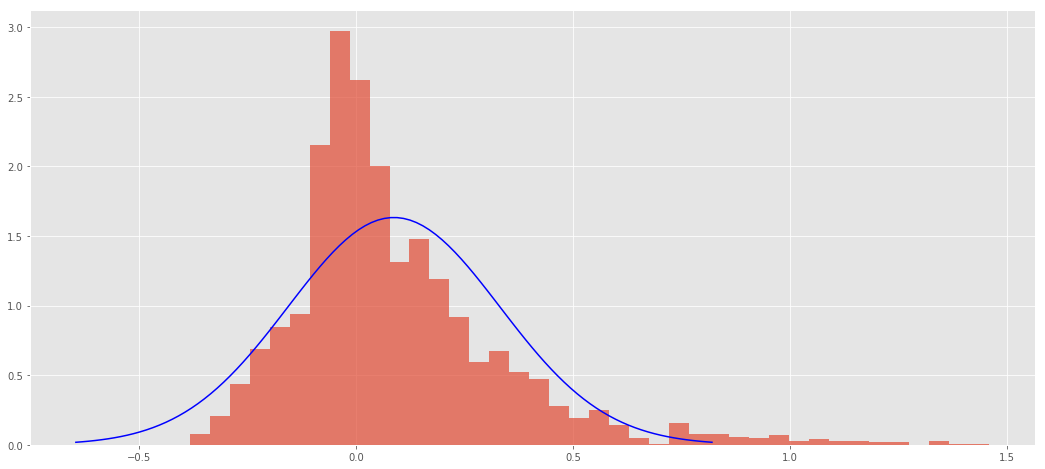

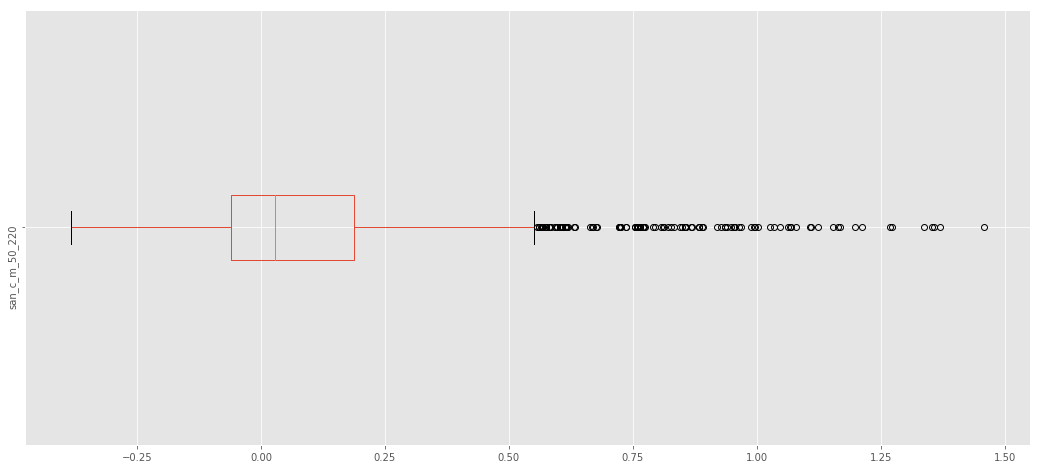

 el valor de 01p es : -0.3029 
 el valor de 05p es : -0.22265 
 el valor de 50p es : 0.027898 
 el valor de 95p es : 0.54168 
 el valor de T-test es : 18.574 
 el valor de avg es : 0.087 
 el valor de kur es : 4.0503 
 el valor de skw es : 1.591 
 el valor de std es : 0.24425 
 el valor de val es : -2.4329 
 el valor de var es : 0.059657 


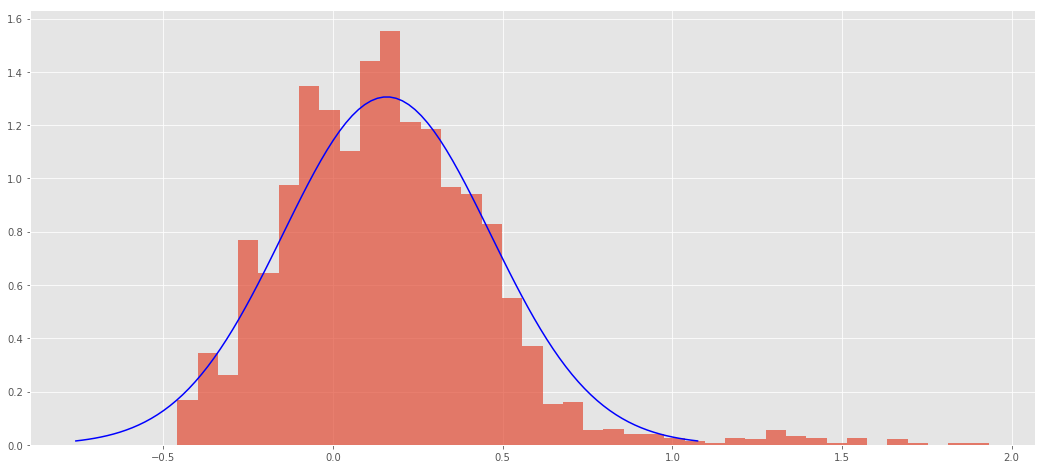

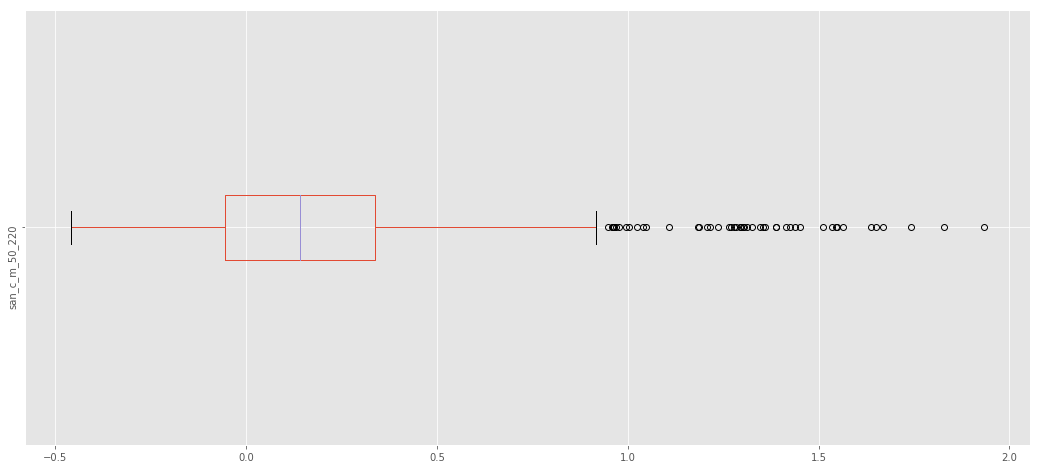

 el valor de 01p es : -0.39982 
 el valor de 05p es : -0.27302 
 el valor de 50p es : 0.14071 
 el valor de 95p es : 0.60604 
 el valor de T-test es : 26.876 
 el valor de avg es : 0.158 
 el valor de kur es : 3.3322 
 el valor de skw es : 1.0894 
 el valor de std es : 0.30545 
 el valor de val es : -2.2198 
 el valor de var es : 0.093301 


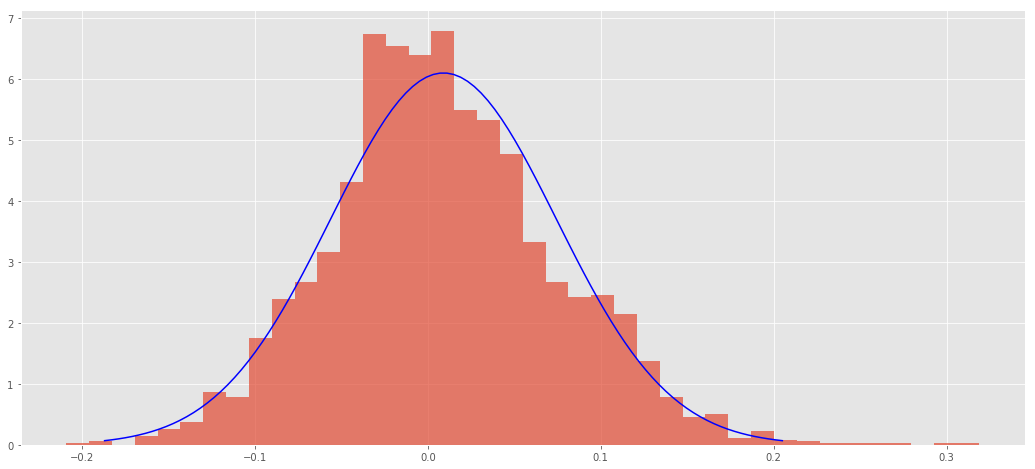

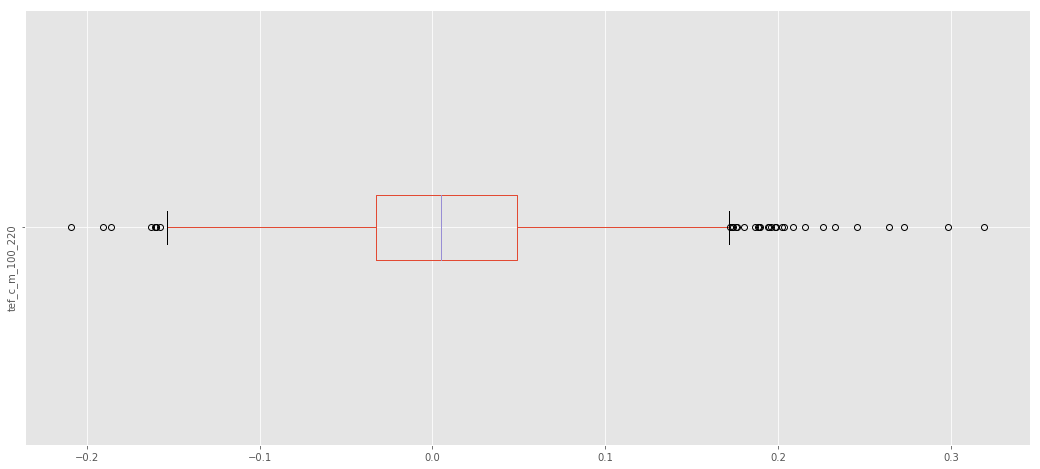

 el valor de 01p es : -0.13447 
 el valor de 05p es : -0.092981 
 el valor de 50p es : 0.004898 
 el valor de 95p es : 0.12087 
 el valor de T-test es : 7.1681 
 el valor de avg es : 0.009 
 el valor de kur es : 0.44074 
 el valor de skw es : 0.31984 
 el valor de std es : 0.065336 
 el valor de val es : -1.3 
 el valor de var es : 0.0042687 


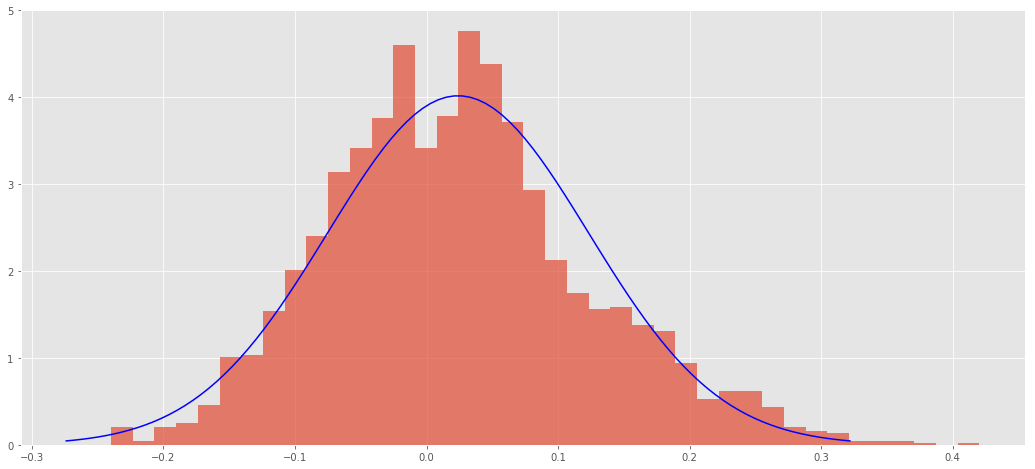

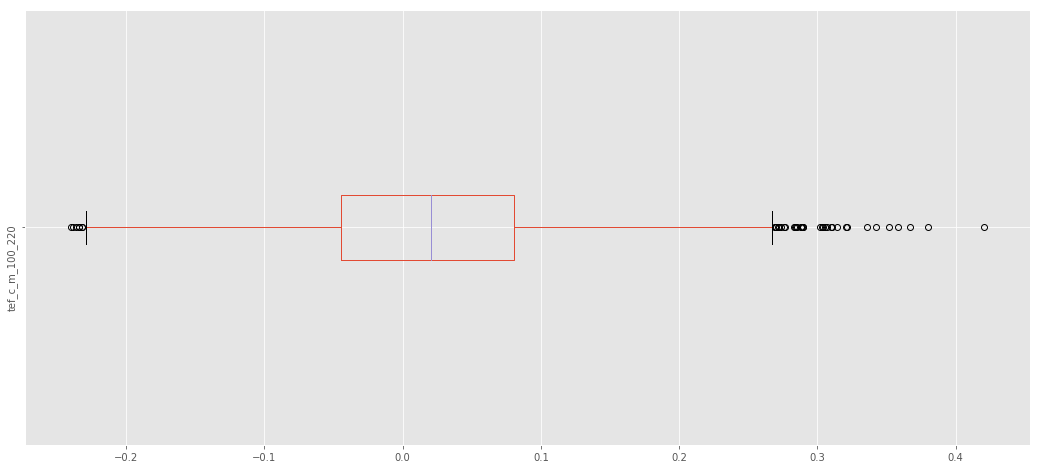

 el valor de 01p es : -0.17517 
 el valor de 05p es : -0.12748 
 el valor de 50p es : 0.020727 
 el valor de 95p es : 0.20154 
 el valor de T-test es : 12.679 
 el valor de avg es : 0.024 
 el valor de kur es : 0.18019 
 el valor de skw es : 0.39672 
 el valor de std es : 0.099318 
 el valor de val es : -1.581 
 el valor de var es : 0.0098641 


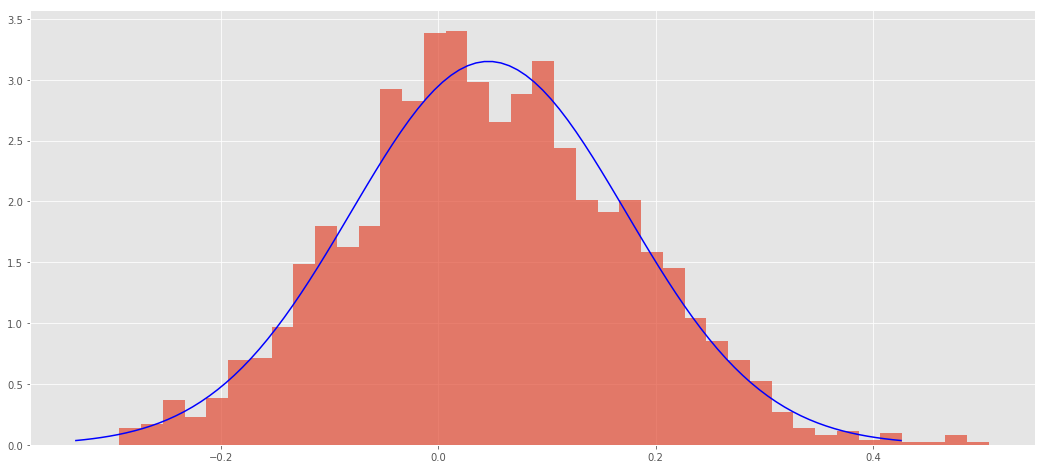

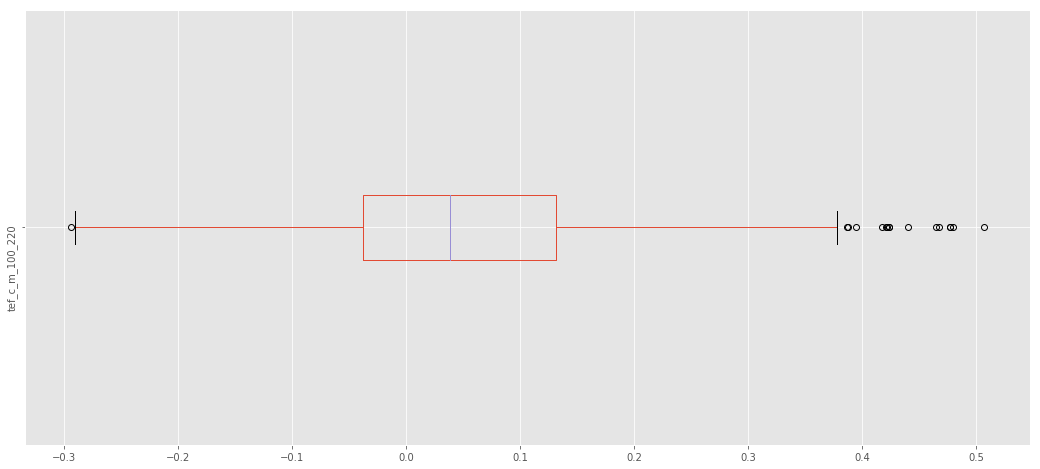

 el valor de 01p es : -0.23974 
 el valor de 05p es : -0.16041 
 el valor de 50p es : 0.039119 
 el valor de 95p es : 0.25665 
 el valor de T-test es : 18.856 
 el valor de avg es : 0.046 
 el valor de kur es : -0.037227 
 el valor de skw es : 0.12813 
 el valor de std es : 0.12659 
 el valor de val es : -1.5999 
 el valor de var es : 0.016025 


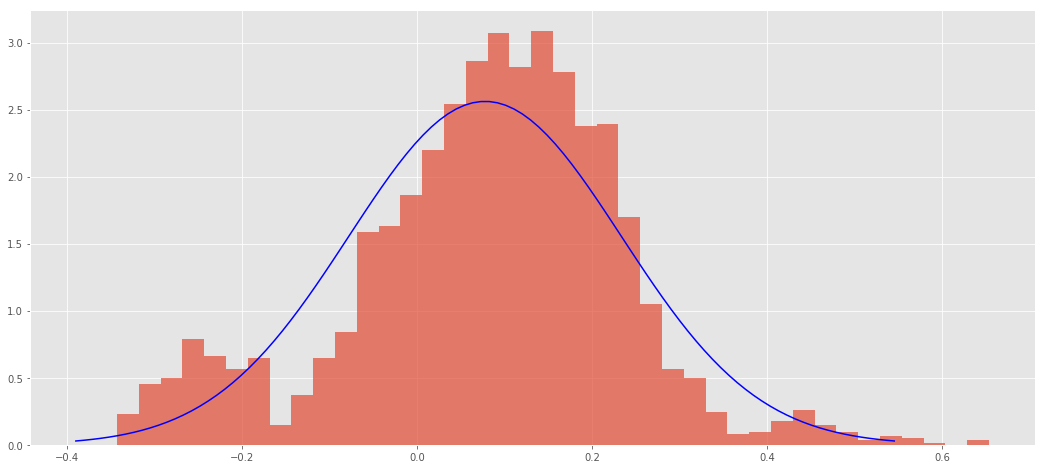

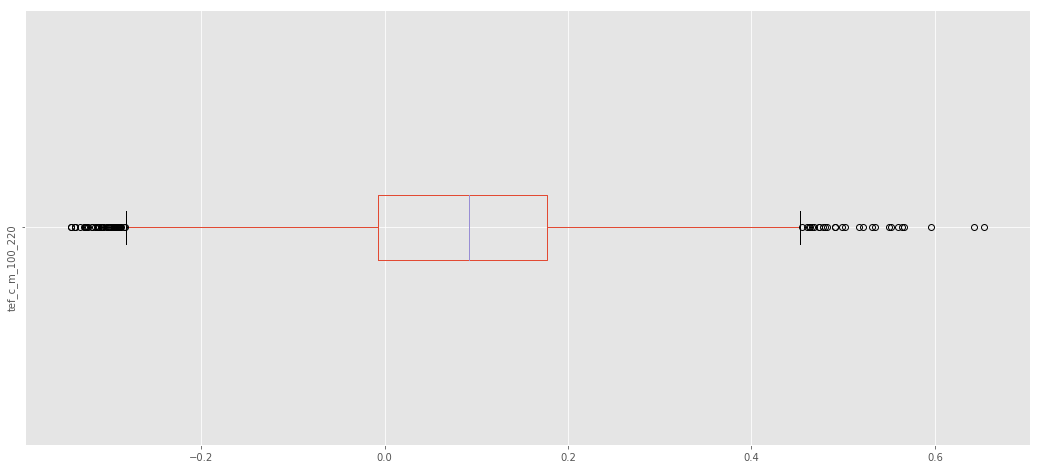

 el valor de 01p es : -0.30825 
 el valor de 05p es : -0.24121 
 el valor de 50p es : 0.09229 
 el valor de 95p es : 0.29351 
 el valor de T-test es : 25.973 
 el valor de avg es : 0.078 
 el valor de kur es : 0.54717 
 el valor de skw es : -0.32652 
 el valor de std es : 0.15578 
 el valor de val es : -1.2168 
 el valor de var es : 0.024266 


In [152]:
fofo=fofo.T
fofo['nombre']=fofo.index
seleccion=fofo['nombre'][fofo['T-test']>4]
var95histmediasmascuatro={}
gg=seleccion
rango = [20,60,120,220]
for n in seleccion:
    for j in rango:
        soso="{}_+4_{}".format(n,j)
        #soso.append(n)
        #printsoso
        var95histmediasmascuatro[soso]=calculate_aggregate(g[n].pct_change(j))
        

<h4>Tabla de series co t-student > 4 y calculo de rendimiento mensual, trimestral, semestral y anual</h4>

In [153]:
ff=pd.DataFrame(var95histmediasmascuatro)
tabla=np.round(ff.T,3)
tabla

01p    05p    50p    95p  T-test    avg    kur  \
itx_c_m_100_220_+4_120 -0.177 -0.129  0.127  0.444  40.431  0.137 -0.004   
itx_c_m_100_220_+4_20  -0.144 -0.084  0.018  0.136  15.157  0.021  2.178   
itx_c_m_100_220_+4_220 -0.256 -0.159  0.249  0.740  49.906  0.276 -0.034   
itx_c_m_100_220_+4_60  -0.174 -0.124  0.052  0.266  26.036  0.065  1.634   
itx_c_m_10_220_+4_120  -0.421 -0.211  0.056  0.371  17.946  0.064 -0.075   
itx_c_m_10_220_+4_20   -0.235 -0.102  0.011  0.125   6.792  0.010  1.540   
itx_c_m_10_220_+4_220  -0.451 -0.272  0.091  0.627  22.975  0.122 -0.474   
itx_c_m_10_220_+4_60   -0.291 -0.178  0.031  0.227  11.949  0.029 -0.185   
itx_c_m_20_220_+4_120  -0.413 -0.199  0.043  0.371  17.365  0.062 -0.146   
itx_c_m_20_220_+4_20   -0.200 -0.114  0.011  0.126   6.707  0.009  1.047   
itx_c_m_20_220_+4_220  -0.450 -0.267  0.077  0.628  22.069  0.117 -0.512   
itx_c_m_20_220_+4_60   -0.276 -0.195  0.034  0.227  11.618  0.029 -0.341   
itx_c_m_50_100_+4_120  -0.451 -0.273  0.039  0.366  11.063  0.043 -0.041   
itx_c_m_50_100_+4_20   -0.198 -0.111  0.008  0.117   4.258  0.006  1.459   
itx_c_m_50_100_+4_220  -0.534 -0.430  0.084  0.627  15.957  0.090 -0.218   
itx_c_m_50_100_+4_60   -0.323 -0.197  0.022  0.208   7.216  0.017  0.120   
itx_c_m_50_220_+4_120  -0.295 -0.187  0.087  0.395  30.240  0.104 -0.158   
itx_c_m_50_220_+4_20   -0.191 -0.091  0.016  0.130  11.414  0.016  1.466   
itx_c_m_50_220_+4_220  -0.272 -0.220  0.183  0.678  38.534  0.203 -0.596   
itx_c_m_50_220_+4_60   -0.241 -0.158  0.043  0.241  20.564  0.048 -0.049   
san_c_m_10_100_+4_120  -0.381 -0.291 -0.004  0.573   9.089  0.047  2.553   
san_c_m_10_100_+4_20   -0.213 -0.141  0.000  0.166   4.054  0.008  2.294   
san_c_m_10_100_+4_220  -0.415 -0.334  0.023  0.803  13.050  0.089  1.651   
san_c_m_10_100_+4_60   -0.283 -0.210  0.005  0.360   6.354  0.021  2.419   
san_c_m_20_100_+4_120  -0.525 -0.272  0.037  0.568  15.344  0.077  2.860   
san_c_m_20_100_+4_20   -0.241 -0.129  0.006  0.167   6.609  0.012  2.637   
san_c_m_20_100_+4_220  -0.477 -0.369  0.091  0.756  21.742  0.136  0.880   
san_c_m_20_100_+4_60   -0.349 -0.230  0.018  0.361  10.830  0.036  2.581   
san_c_m_20_220_+4_120  -0.339 -0.263  0.021  0.545  13.142  0.067  2.750   
san_c_m_20_220_+4_20   -0.205 -0.139  0.006  0.167   5.925  0.011  2.274   
san_c_m_20_220_+4_220  -0.483 -0.375  0.102  0.643  17.594  0.115  2.080   
san_c_m_20_220_+4_60   -0.329 -0.222  0.027  0.335   9.680  0.033  2.100   
san_c_m_20_50_+4_120   -0.327 -0.220  0.048  0.524  18.625  0.083  1.134   
san_c_m_20_50_+4_20    -0.248 -0.128  0.006  0.173   7.234  0.014  3.459   
san_c_m_20_50_+4_220   -0.284 -0.211  0.075  0.861  25.356  0.168  2.497   
san_c_m_20_50_+4_60    -0.277 -0.183  0.023  0.314  12.578  0.040  3.163   
san_c_m_50_100_+4_120  -0.390 -0.308 -0.004  0.560   9.495  0.049  2.315   
san_c_m_50_100_+4_20   -0.218 -0.142  0.001  0.166   4.134  0.008  2.213   
san_c_m_50_100_+4_220  -0.391 -0.328  0.023  0.624  13.676  0.080  0.492   
san_c_m_50_100_+4_60   -0.308 -0.234  0.019  0.353   6.603  0.023  1.980   
san_c_m_50_220_+4_120  -0.303 -0.223  0.028  0.542  18.574  0.087  4.050   
san_c_m_50_220_+4_20   -0.204 -0.131  0.010  0.167   7.984  0.015  2.468   
san_c_m_50_220_+4_220  -0.400 -0.273  0.141  0.606  26.876  0.158  3.332   
san_c_m_50_220_+4_60   -0.318 -0.185  0.033  0.328  13.422  0.042  3.157   
tef_c_m_100_220_+4_120 -0.240 -0.160  0.039  0.257  18.856  0.046 -0.037   
tef_c_m_100_220_+4_20  -0.134 -0.093  0.005  0.121   7.168  0.009  0.441   
tef_c_m_100_220_+4_220 -0.308 -0.241  0.092  0.294  25.973  0.078  0.547   
tef_c_m_100_220_+4_60  -0.175 -0.127  0.021  0.202  12.679  0.024  0.180   

                          skw    std    val    var  
itx_c_m_100_220_+4_120  0.455  0.176 -3.443  0.031  
itx_c_m_100_220_+4_20   0.365  0.073 -1.625  0.005  
itx_c_m_100_220_+4_220  0.425  0.288 -4.648  0.083  
itx_c_m_100_220_+4_60   0.694  0.129 -2.151  0.017  
itx_c_m_10_220_+4_120   0.049  0.187

In [154]:
ff.columns

Index([u'itx_c_m_100_220_+4_120', u'itx_c_m_100_220_+4_20',
       u'itx_c_m_100_220_+4_220', u'itx_c_m_100_220_+4_60',
       u'itx_c_m_10_220_+4_120', u'itx_c_m_10_220_+4_20',
       u'itx_c_m_10_220_+4_220', u'itx_c_m_10_220_+4_60',
       u'itx_c_m_20_220_+4_120', u'itx_c_m_20_220_+4_20',
       u'itx_c_m_20_220_+4_220', u'itx_c_m_20_220_+4_60',
       u'itx_c_m_50_100_+4_120', u'itx_c_m_50_100_+4_20',
       u'itx_c_m_50_100_+4_220', u'itx_c_m_50_100_+4_60',
       u'itx_c_m_50_220_+4_120', u'itx_c_m_50_220_+4_20',
       u'itx_c_m_50_220_+4_220', u'itx_c_m_50_220_+4_60',
       u'san_c_m_10_100_+4_120', u'san_c_m_10_100_+4_20',
       u'san_c_m_10_100_+4_220', u'san_c_m_10_100_+4_60',
       u'san_c_m_20_100_+4_120', u'san_c_m_20_100_+4_20',
       u'san_c_m_20_100_+4_220', u'san_c_m_20_100_+4_60',
       u'san_c_m_20_220_+4_120', u'san_c_m_20_220_+4_20',
       u'san_c_m_20_220_+4_220', u'san_c_m_20_220_+4_60',
       u'san_c_m_20_50_+4_120', u'san_c_m_20_50_+4_20',
       u'san

<h4>Gráfico de itx con sistema de cruce de medias 100 - 220</h4>

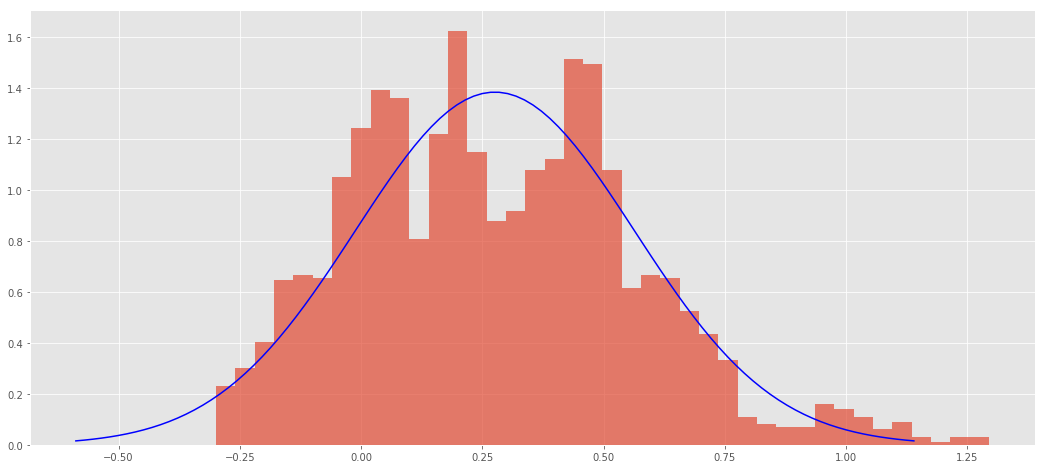

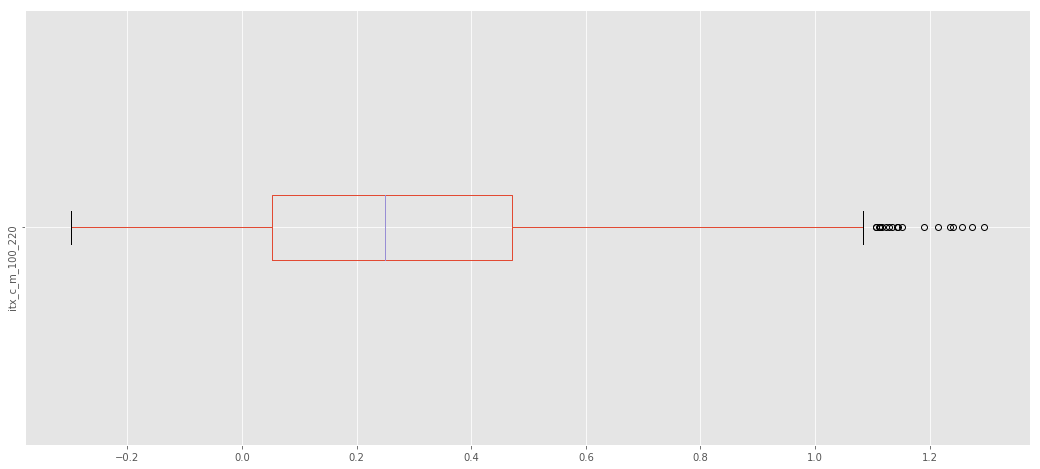

 el valor de 01p es : -0.25569 
 el valor de 05p es : -0.15932 
 el valor de 50p es : 0.24916 
 el valor de 95p es : 0.74048 
 el valor de T-test es : 49.906 
 el valor de avg es : 0.276 
 el valor de kur es : -0.033986 
 el valor de skw es : 0.4251 
 el valor de std es : 0.288 
 el valor de val es : -4.6477 
 el valor de var es : 0.082944 


{'01p': -0.2556940642703661,
 '05p': -0.15932375910750163,
 '50p': 0.24916257144692566,
 '95p': 0.7404821193157076,
 'T-test': 49.905622049447175,
 'avg': 0.27600000000000002,
 'kur': -0.033986038911924865,
 'skw': 0.42509894543123655,
 'std': 0.2880000304992842,
 'val': -4.647656592235418,
 'var': 0.08294401756758864}

In [155]:
calculate_aggregate(g['itx_c_m_100_220'].pct_change(220))

In [156]:
#g.loc[:,'itx_cruce_medias_100_200_11']=g['itx_cruce_medias_100_200'].values/0.08
#g['itx_cruce_medias_100_200'].plot()
# g['itx_cruce_medias_100_200_10%'].plot()

In [157]:
selector=g.filter(like='itx',axis=1).columns.values
h=g[selector]
h.columns

Index([u'itx_c_m_10_20', u'itx_c_m_10_50', u'itx_c_m_20_50', u'itx_c_m_10_100',
       u'itx_c_m_20_100', u'itx_c_m_50_100', u'itx_c_m_10_220',
       u'itx_c_m_20_220', u'itx_c_m_50_220', u'itx_c_m_100_220'],
      dtype='object')

In [158]:
g.columns

Index([u'san_c_m_10_20', u'san_c_m_10_50', u'san_c_m_20_50', u'san_c_m_10_100',
       u'san_c_m_20_100', u'san_c_m_50_100', u'san_c_m_10_220',
       u'san_c_m_20_220', u'san_c_m_50_220', u'san_c_m_100_220',
       u'itx_c_m_10_20', u'itx_c_m_10_50', u'itx_c_m_20_50', u'itx_c_m_10_100',
       u'itx_c_m_20_100', u'itx_c_m_50_100', u'itx_c_m_10_220',
       u'itx_c_m_20_220', u'itx_c_m_50_220', u'itx_c_m_100_220',
       u'tef_c_m_10_20', u'tef_c_m_10_50', u'tef_c_m_20_50', u'tef_c_m_10_100',
       u'tef_c_m_20_100', u'tef_c_m_50_100', u'tef_c_m_10_220',
       u'tef_c_m_20_220', u'tef_c_m_50_220', u'tef_c_m_100_220'],
      dtype='object')

---

# Sistema mayor del -15%

<p>Dado que podemos utilizar el var para determinar apartir de que % dejamos de operar un sistema, podemos hacer un pequeño análsis situando esta barrera en el -15%

In [159]:
#crear sistema menor que el 10%
def crossover_tanto(values,tanto=-.10,change=20):
    
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(change).fillna(1)
    df['senal']=np.where(df.pctvalues>tanto,1,0)
    df['senal']=df['senal']
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [160]:
h.columns

Index([u'itx_c_m_10_20', u'itx_c_m_10_50', u'itx_c_m_20_50', u'itx_c_m_10_100',
       u'itx_c_m_20_100', u'itx_c_m_50_100', u'itx_c_m_10_220',
       u'itx_c_m_20_220', u'itx_c_m_50_220', u'itx_c_m_100_220'],
      dtype='object')

<h4>Gráficos de los sistemas limitando la pérdida al -15%</h4>

In [161]:
seleccion=h.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}

tanto=-.15
for n in seleccion:
      h['{}_c_t_{}'.format(n,tanto)]=crossover_tanto(g['{}'.format(n)],tanto,change=20)


In [162]:
h.columns

Index([u'itx_c_m_10_20', u'itx_c_m_10_50', u'itx_c_m_20_50', u'itx_c_m_10_100',
       u'itx_c_m_20_100', u'itx_c_m_50_100', u'itx_c_m_10_220',
       u'itx_c_m_20_220', u'itx_c_m_50_220', u'itx_c_m_100_220',
       u'itx_c_m_10_20_c_t_-0.15', u'itx_c_m_10_50_c_t_-0.15',
       u'itx_c_m_20_50_c_t_-0.15', u'itx_c_m_10_100_c_t_-0.15',
       u'itx_c_m_20_100_c_t_-0.15', u'itx_c_m_50_100_c_t_-0.15',
       u'itx_c_m_10_220_c_t_-0.15', u'itx_c_m_20_220_c_t_-0.15',
       u'itx_c_m_50_220_c_t_-0.15', u'itx_c_m_100_220_c_t_-0.15'],
      dtype='object')

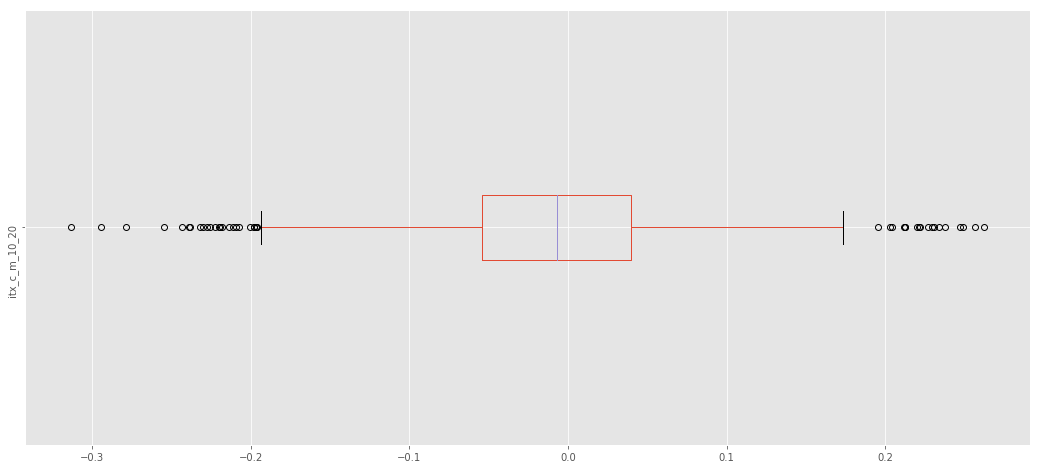

 el valor de 01p es : -0.19052 
 el valor de 05p es : -0.12303 
 el valor de 50p es : -0.0067361 
 el valor de 95p es : 0.11424 
 el valor de T-test es : -4.5365 
 el valor de avg es : -0.006 
 el valor de kur es : 0.59543 
 el valor de skw es : -0.015249 
 el valor de std es : 0.073572 
 el valor de val es : -0.92854 
 el valor de var es : 0.0054128 


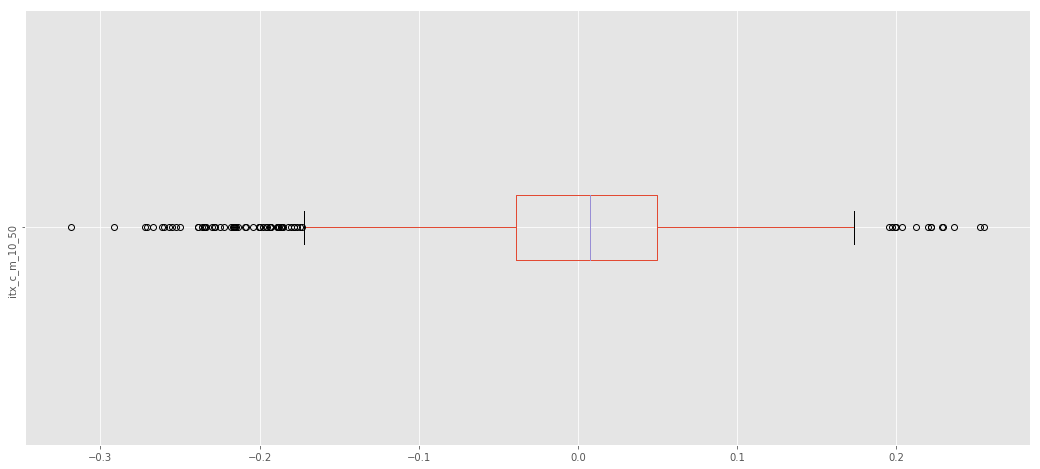

 el valor de 01p es : -0.21549 
 el valor de 05p es : -0.11873 
 el valor de 50p es : 0.0075141 
 el valor de 95p es : 0.11541 
 el valor de T-test es : 2.4815 
 el valor de avg es : 0.003 
 el valor de kur es : 1.0395 
 el valor de skw es : -0.44716 
 el valor de std es : 0.073119 
 el valor de val es : -0.97198 
 el valor de var es : 0.0053465 


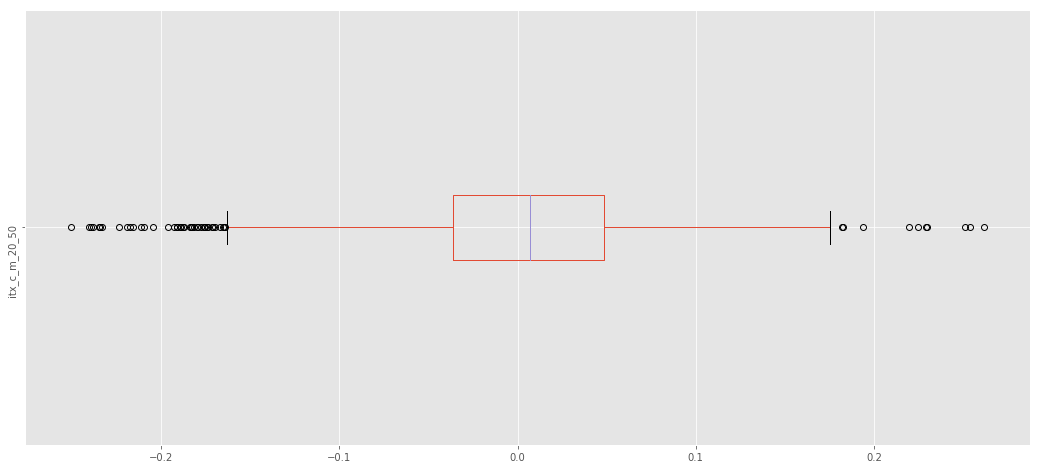

 el valor de 01p es : -0.1794 
 el valor de 05p es : -0.10802 
 el valor de 50p es : 0.0071159 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 3.7057 
 el valor de avg es : 0.005 
 el valor de kur es : 0.61312 
 el valor de skw es : -0.24011 
 el valor de std es : 0.068181 
 el valor de val es : -1.0558 
 el valor de var es : 0.0046486 


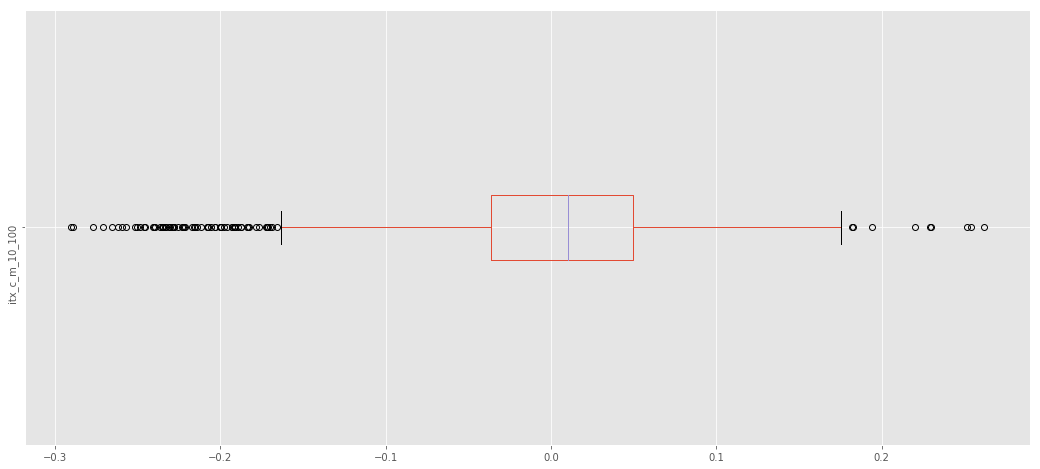

 el valor de 01p es : -0.228 
 el valor de 05p es : -0.1191 
 el valor de 50p es : 0.010159 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 3.3833 
 el valor de avg es : 0.005 
 el valor de kur es : 1.2534 
 el valor de skw es : -0.58662 
 el valor de std es : 0.073291 
 el valor de val es : -0.97934 
 el valor de var es : 0.0053716 


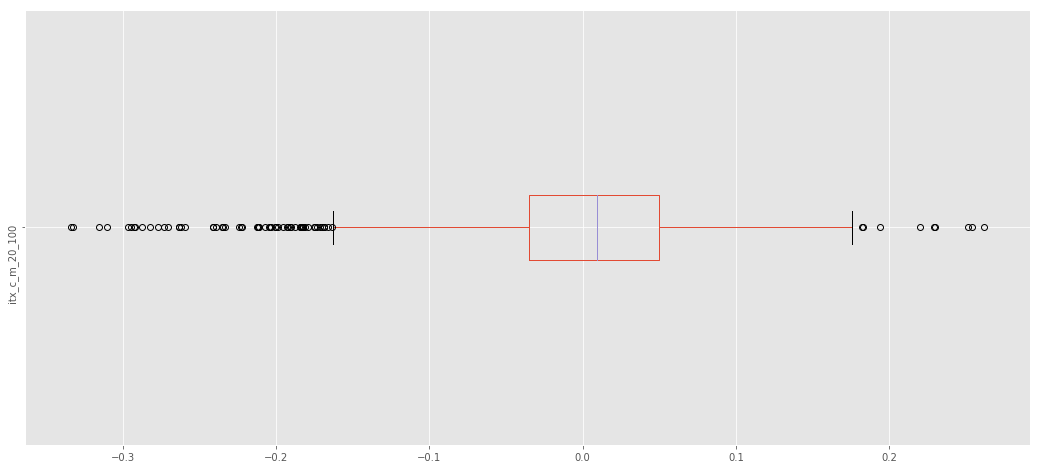

 el valor de 01p es : -0.2119 
 el valor de 05p es : -0.11657 
 el valor de 50p es : 0.009584 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.8461 
 el valor de avg es : 0.005 
 el valor de kur es : 1.6859 
 el valor de skw es : -0.63731 
 el valor de std es : 0.072765 
 el valor de val es : -1.0019 
 el valor de var es : 0.0052947 


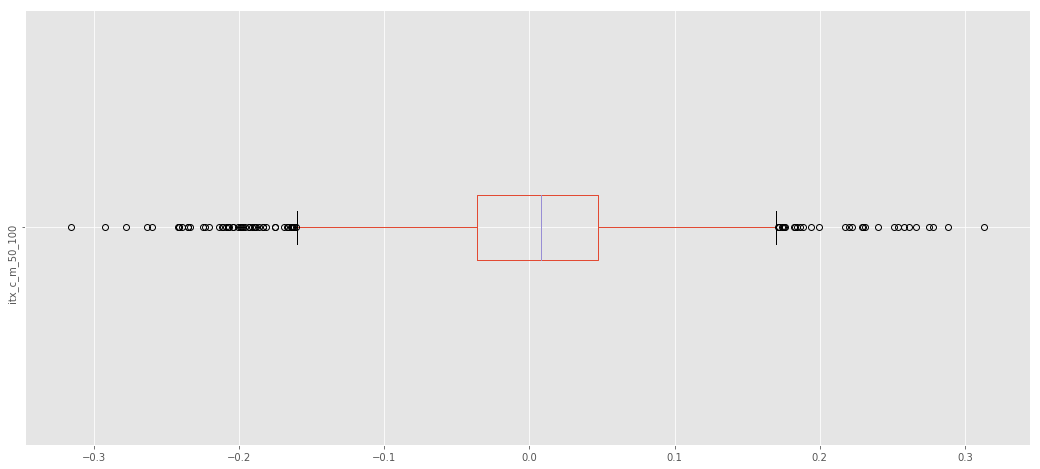

 el valor de 01p es : -0.19819 
 el valor de 05p es : -0.11056 
 el valor de 50p es : 0.0081278 
 el valor de 95p es : 0.11741 
 el valor de T-test es : 4.258 
 el valor de avg es : 0.006 
 el valor de kur es : 1.4595 
 el valor de skw es : -0.19723 
 el valor de std es : 0.070759 
 el valor de val es : -1.062 
 el valor de var es : 0.0050068 


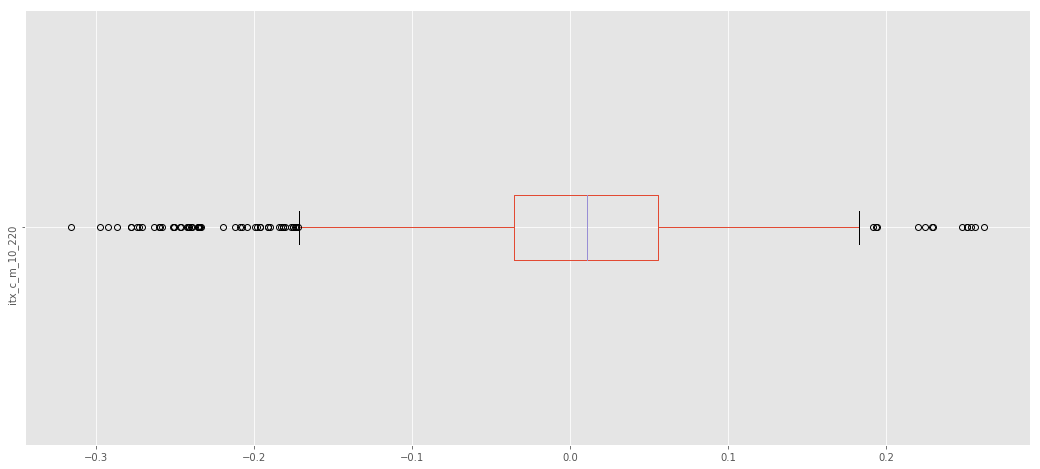

 el valor de 01p es : -0.23491 
 el valor de 05p es : -0.10246 
 el valor de 50p es : 0.010986 
 el valor de 95p es : 0.12484 
 el valor de T-test es : 6.7923 
 el valor de avg es : 0.01 
 el valor de kur es : 1.5401 
 el valor de skw es : -0.46052 
 el valor de std es : 0.073029 
 el valor de val es : -1.2185 
 el valor de var es : 0.0053332 


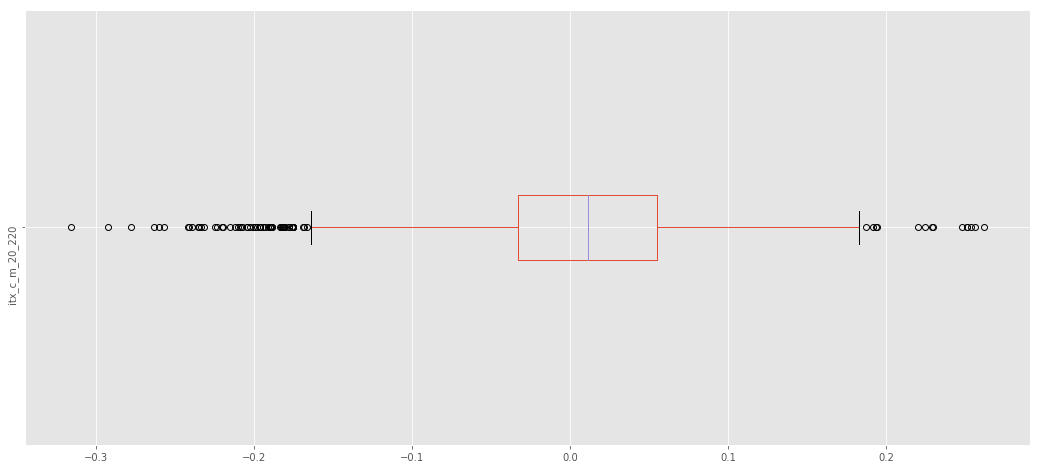

 el valor de 01p es : -0.19954 
 el valor de 05p es : -0.11418 
 el valor de 50p es : 0.011389 
 el valor de 95p es : 0.12555 
 el valor de T-test es : 6.707 
 el valor de avg es : 0.009 
 el valor de kur es : 1.0469 
 el valor de skw es : -0.3765 
 el valor de std es : 0.072918 
 el valor de val es : -1.0996 
 el valor de var es : 0.0053171 


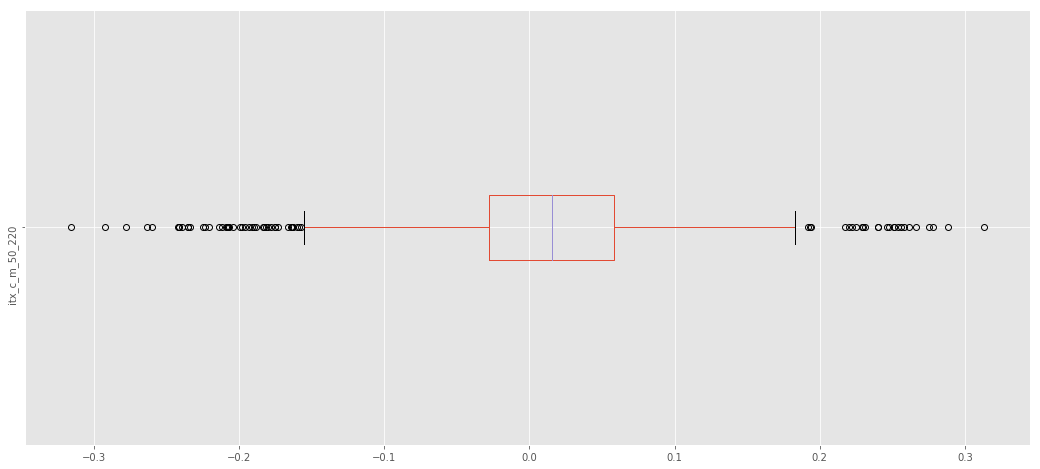

 el valor de 01p es : -0.19142 
 el valor de 05p es : -0.091313 
 el valor de 50p es : 0.015692 
 el valor de 95p es : 0.13037 
 el valor de T-test es : 11.414 
 el valor de avg es : 0.016 
 el valor de kur es : 1.4664 
 el valor de skw es : -0.14343 
 el valor de std es : 0.071276 
 el valor de val es : -1.4278 
 el valor de var es : 0.0050802 


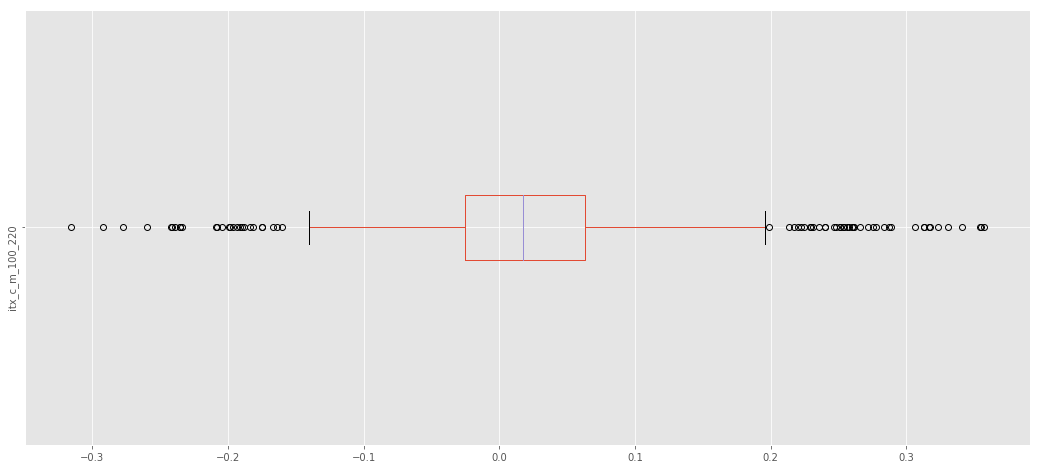

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.083927 
 el valor de 50p es : 0.017856 
 el valor de 95p es : 0.13642 
 el valor de T-test es : 15.157 
 el valor de avg es : 0.021 
 el valor de kur es : 2.1776 
 el valor de skw es : 0.36453 
 el valor de std es : 0.072563 
 el valor de val es : -1.6255 
 el valor de var es : 0.0052653 


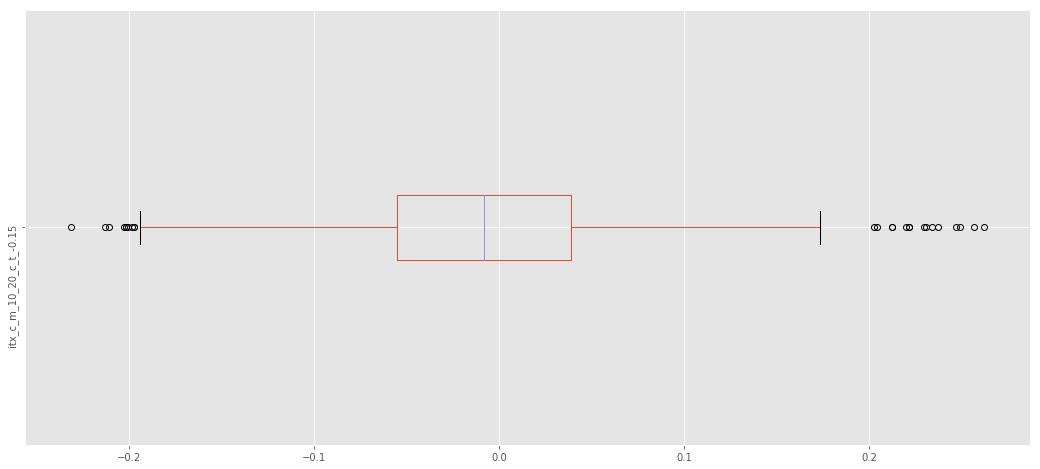

 el valor de 01p es : -0.17363 
 el valor de 05p es : -0.11842 
 el valor de 50p es : -0.0082743 
 el valor de 95p es : 0.10997 
 el valor de T-test es : -5.0101 
 el valor de avg es : -0.007 
 el valor de kur es : 0.26927 
 el valor de skw es : 0.13826 
 el valor de std es : 0.070376 
 el valor de val es : -0.92864 
 el valor de var es : 0.0049528 


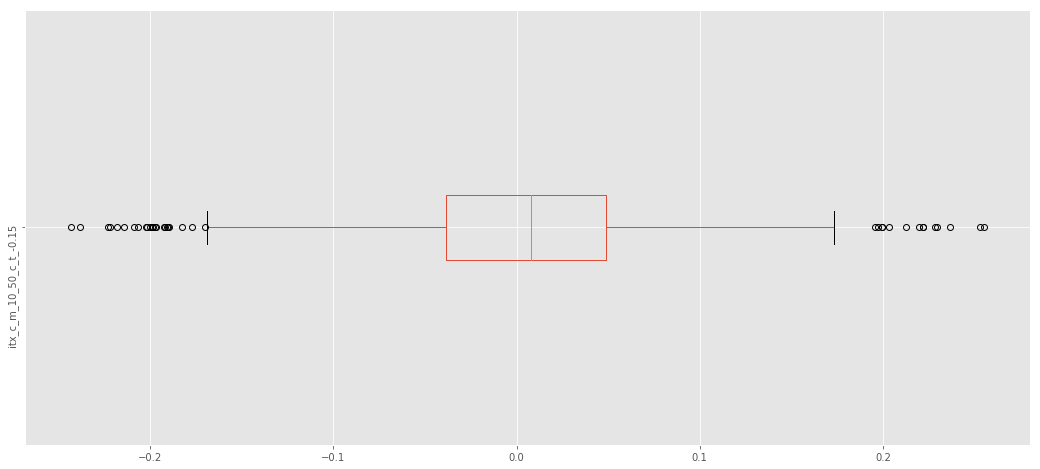

 el valor de 01p es : -0.16167 
 el valor de 05p es : -0.11036 
 el valor de 50p es : 0.00802 
 el valor de 95p es : 0.1126 
 el valor de T-test es : 3.8113 
 el valor de avg es : 0.005 
 el valor de kur es : 0.3581 
 el valor de skw es : -0.14589 
 el valor de std es : 0.068607 
 el valor de val es : -1.0203 
 el valor de var es : 0.0047069 


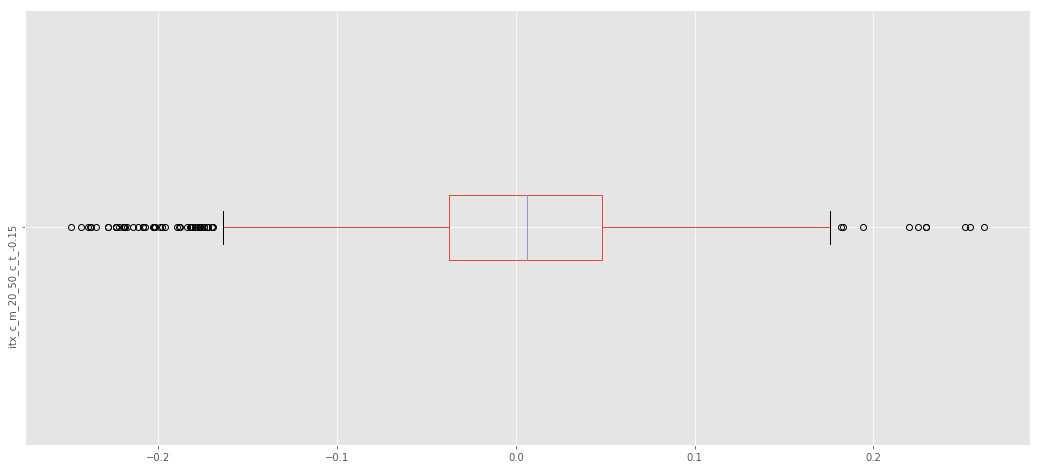

 el valor de 01p es : -0.19657 
 el valor de 05p es : -0.11104 
 el valor de 50p es : 0.0064049 
 el valor de 95p es : 0.11405 
 el valor de T-test es : 2.9419 
 el valor de avg es : 0.004 
 el valor de kur es : 0.72235 
 el valor de skw es : -0.30239 
 el valor de std es : 0.069319 
 el valor de val es : -1.0271 
 el valor de var es : 0.0048051 


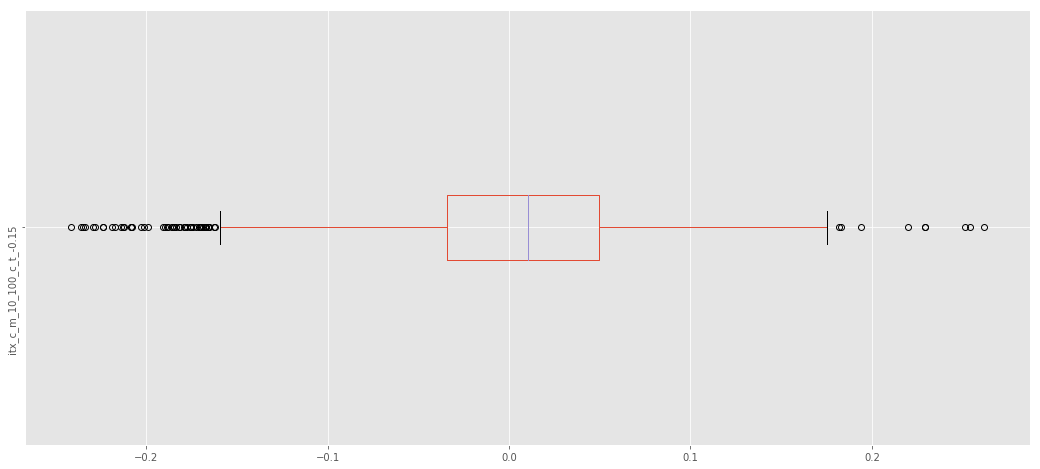

 el valor de 01p es : -0.18397 
 el valor de 05p es : -0.11534 
 el valor de 50p es : 0.010343 
 el valor de 95p es : 0.11566 
 el valor de T-test es : 4.9026 
 el valor de avg es : 0.007 
 el valor de kur es : 0.64985 
 el valor de skw es : -0.35195 
 el valor de std es : 0.069521 
 el valor de val es : -1.0028 
 el valor de var es : 0.0048332 


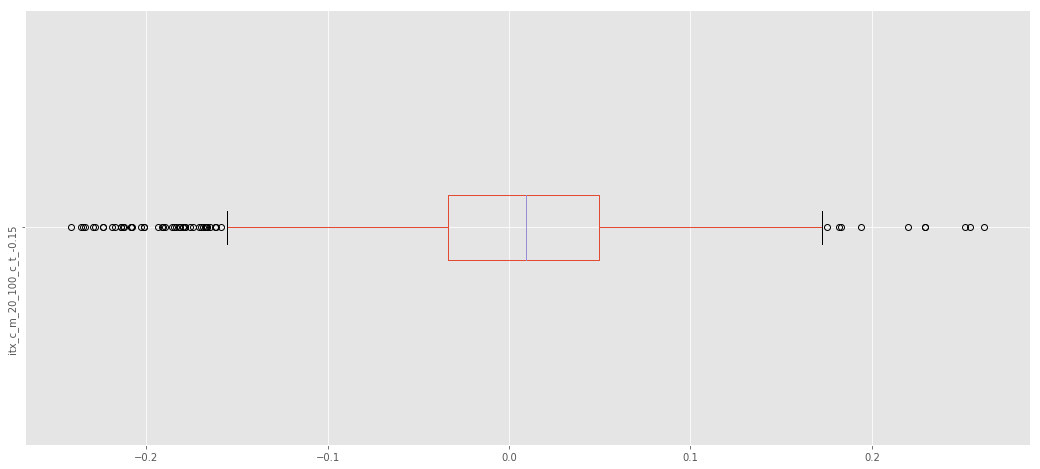

 el valor de 01p es : -0.18218 
 el valor de 05p es : -0.10912 
 el valor de 50p es : 0.0092648 
 el valor de 95p es : 0.11664 
 el valor de T-test es : 5.3252 
 el valor de avg es : 0.007 
 el valor de kur es : 0.6734 
 el valor de skw es : -0.29113 
 el valor de std es : 0.068218 
 el valor de val es : -1.0689 
 el valor de var es : 0.0046537 


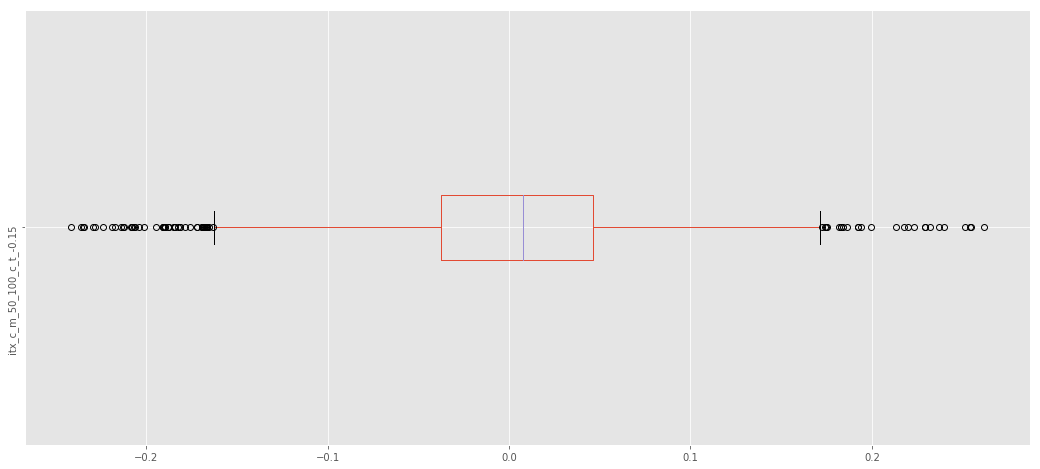

 el valor de 01p es : -0.18767 
 el valor de 05p es : -0.11697 
 el valor de 50p es : 0.0078668 
 el valor de 95p es : 0.11679 
 el valor de T-test es : 3.0797 
 el valor de avg es : 0.004 
 el valor de kur es : 0.80341 
 el valor de skw es : -0.19667 
 el valor de std es : 0.070175 
 el valor de val es : -0.99848 
 el valor de var es : 0.0049246 


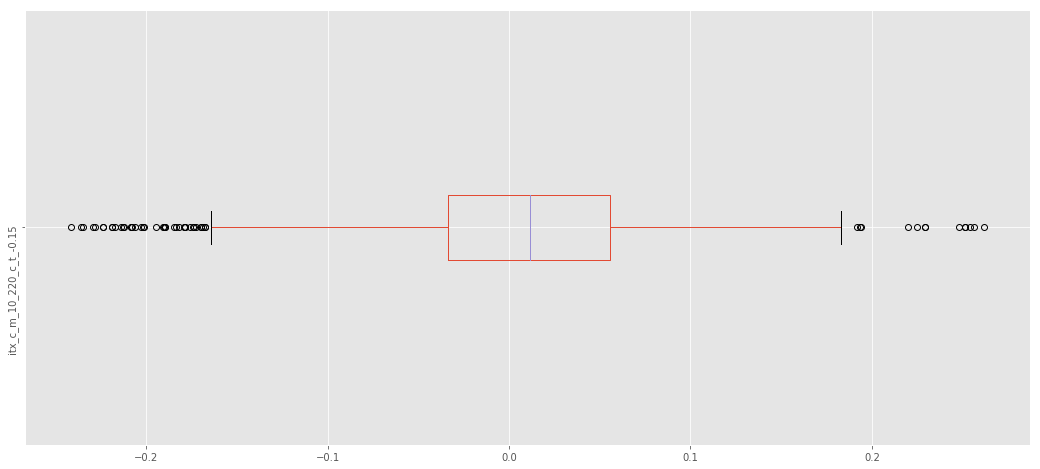

 el valor de 01p es : -0.18218 
 el valor de 05p es : -0.098536 
 el valor de 50p es : 0.0115 
 el valor de 95p es : 0.12427 
 el valor de T-test es : 8.2532 
 el valor de avg es : 0.011 
 el valor de kur es : 0.65873 
 el valor de skw es : -0.17248 
 el valor de std es : 0.069523 
 el valor de val es : -1.2612 
 el valor de var es : 0.0048334 


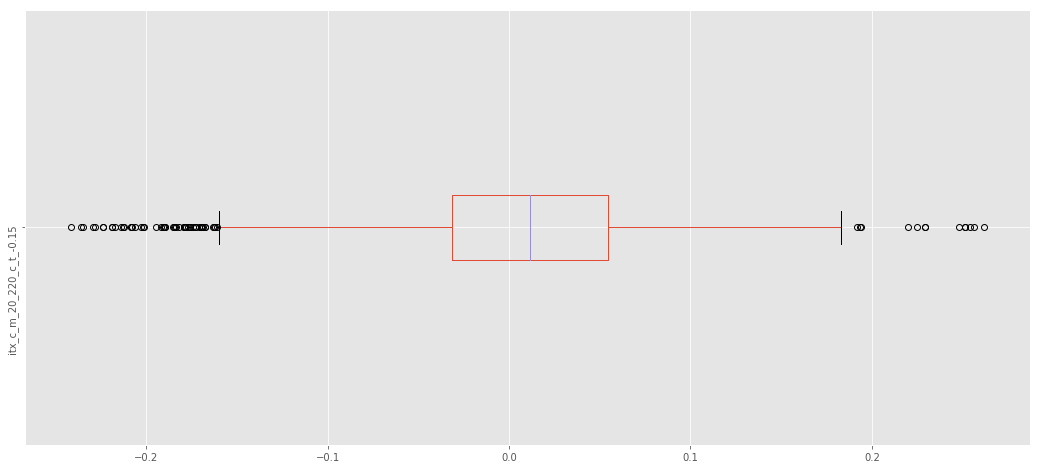

 el valor de 01p es : -0.185 
 el valor de 05p es : -0.10365 
 el valor de 50p es : 0.011678 
 el valor de 95p es : 0.12303 
 el valor de T-test es : 7.6953 
 el valor de avg es : 0.01 
 el valor de kur es : 0.75959 
 el valor de skw es : -0.25262 
 el valor de std es : 0.070229 
 el valor de val es : -1.187 
 el valor de var es : 0.0049322 


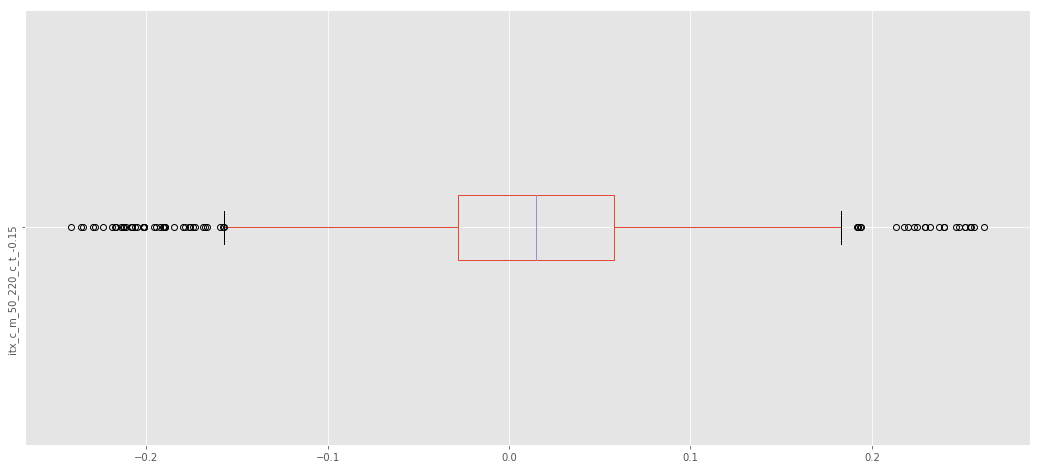

 el valor de 01p es : -0.18993 
 el valor de 05p es : -0.095151 
 el valor de 50p es : 0.014633 
 el valor de 95p es : 0.12979 
 el valor de T-test es : 11.039 
 el valor de avg es : 0.015 
 el valor de kur es : 0.90376 
 el valor de skw es : -0.11332 
 el valor de std es : 0.070191 
 el valor de val es : -1.364 
 el valor de var es : 0.0049268 


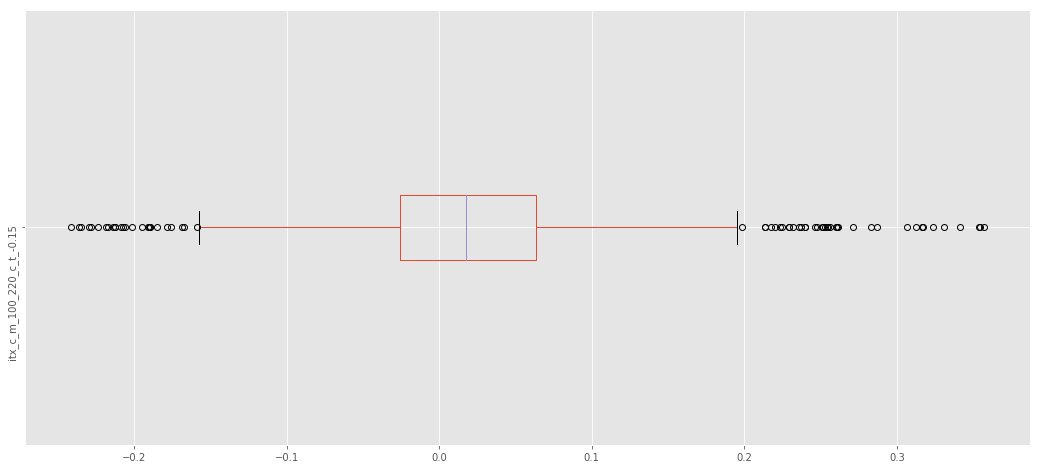

 el valor de 01p es : -0.15567 
 el valor de 05p es : -0.084992 
 el valor de 50p es : 0.01776 
 el valor de 95p es : 0.1363 
 el valor de T-test es : 14.97 
 el valor de avg es : 0.021 
 el valor de kur es : 1.8189 
 el valor de skw es : 0.3656 
 el valor de std es : 0.071887 
 el valor de val es : -1.6037 
 el valor de var es : 0.0051678 


In [163]:
selector=h.filter(like='c_m',axis=1).columns.values
var95histmedias10={}
for n in selector:
    sel="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmedias10[sel]=calculate_aggregate(h[sel].pct_change(20),False)

<h4>Tabla comparando los sistemas con límite y sin límite al -15%</h4>

In [164]:
fofo=pd.DataFrame(var95histmedias10)
np.round(fofo.T,3)

01p    05p    50p    95p  T-test    avg    kur  \
itx_c_m_100_220           -0.144 -0.084  0.018  0.136  15.157  0.021  2.178   
itx_c_m_100_220_c_t_-0.15 -0.156 -0.085  0.018  0.136  14.970  0.021  1.819   
itx_c_m_10_100            -0.228 -0.119  0.010  0.117   3.383  0.005  1.253   
itx_c_m_10_100_c_t_-0.15  -0.184 -0.115  0.010  0.116   4.903  0.007  0.650   
itx_c_m_10_20             -0.191 -0.123 -0.007  0.114  -4.536 -0.006  0.595   
itx_c_m_10_20_c_t_-0.15   -0.174 -0.118 -0.008  0.110  -5.010 -0.007  0.269   
itx_c_m_10_220            -0.235 -0.102  0.011  0.125   6.792  0.010  1.540   
itx_c_m_10_220_c_t_-0.15  -0.182 -0.099  0.011  0.124   8.253  0.011  0.659   
itx_c_m_10_50             -0.215 -0.119  0.008  0.115   2.481  0.003  1.039   
itx_c_m_10_50_c_t_-0.15   -0.162 -0.110  0.008  0.113   3.811  0.005  0.358   
itx_c_m_20_100            -0.212 -0.117  0.010  0.117   3.846  0.005  1.686   
itx_c_m_20_100_c_t_-0.15  -0.182 -0.109  0.009  0.117   5.325  0.007  0.673   
itx_c_m_20_220            -0.200 -0.114  0.011  0.126   6.707  0.009  1.047   
itx_c_m_20_220_c_t_-0.15  -0.185 -0.104  0.012  0.123   7.695  0.010  0.760   
itx_c_m_20_50             -0.179 -0.108  0.007  0.114   3.706  0.005  0.613   
itx_c_m_20_50_c_t_-0.15   -0.197 -0.111  0.006  0.114   2.942  0.004  0.722   
itx_c_m_50_100            -0.198 -0.111  0.008  0.117   4.258  0.006  1.459   
itx_c_m_50_100_c_t_-0.15  -0.188 -0.117  0.008  0.117   3.080  0.004  0.803   
itx_c_m_50_220            -0.191 -0.091  0.016  0.130  11.414  0.016  1.466   
itx_c_m_50_220_c_t_-0.15  -0.190 -0.095  0.015  0.130  11.039  0.015  0.904   

                             skw    std    val    var  
itx_c_m_100_220            0.365  0.073 -1.625  0.005  
itx_c_m_100_220_c_t_-0.15  0.366  0.072 -1.604  0.005  
itx_c_m_10_100            -0.587  0.073 -0.979  0.005  
itx_c_m_10_100_c_t_-0.15  -0.352  0.070 -1.003  0.005  
itx_c_m_10_20             -0.015  0.074 -0.929  0.005  
itx_c_m_10_20_c_t_-0.15    0.138  0.070 -0.929  0.005  
itx_c_m_10_220            -0.461  0.073 -1.218  0.005  
itx_c_m_10_220_c_t_-0.15  -0.172  0.070 -1.261  0.005  
itx_c_m_10_50             -0.447  0.073 -0.972  0.005  
itx_c_m_10_50_c_t_-0.15   -0.146  0.069 -1.020  0.005  
itx_c_m_20_100            -0.637  0.073 -1.002  0.005  
itx_c_m_20_100_c_t_-0.15  -0.291  0.068 -1.069  0.005  
itx_c_m_20_220            -0.377  0.073 -1.100  0.005  
itx_c_m_20_220_c_t_-0.15  -0.253  0.070 -1.187  0.005  
itx_c_m_20_50             -0.240  0.068 -1.056  0.005  
itx_c_m_20_50_c_t_-0.15   -0.302  0.069 -1.027  0.005  
itx_c_m_50_100            -0.197  0.071 -1.062  0.005  
itx_c_m_50_100_c_t_-0.15  -0.197  0.070 -0.998  0.005  
itx_c_m_50_220            -0.143  0.071 -1.428  0.005  
itx_c_m_50_220_c_t_-0.15  -0.113  0.070 -1.364  0.005

<H5>Gráfico de la serie original y la limitada al -15%, con var95 alto</h5>

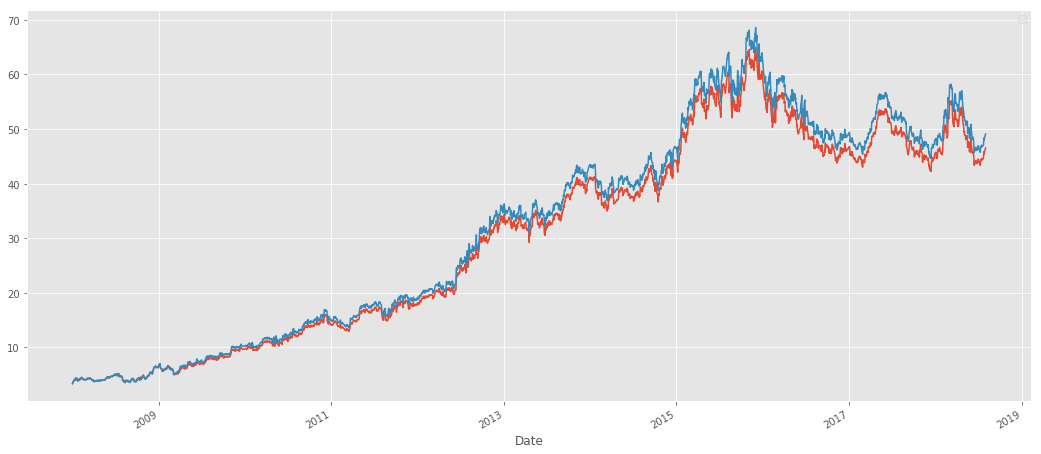

In [165]:
teto=crossover_tanto(f['itx_c_m_100_220'],tanto=-.15,change=20)
teto.plot()
f['itx_c_m_100_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

<H5>Gráfico de la serie original y la limitada al -15%, con var95 bajo</h5>

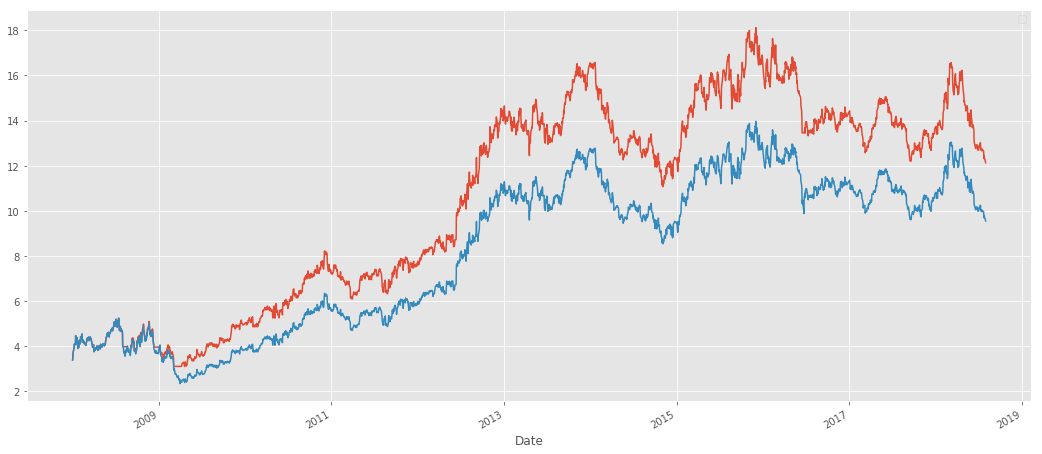

In [166]:
teto=crossover_tanto(f['itx_c_m_10_220'],tanto=-.15,change=20)
teto.plot()
f['itx_c_m_10_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

<p>Claramente perjudica al que tiene menor pérdida y está por debajo del limite, que en este caso es del 15%, pero tan escasamente que podemos establecer este -15% como un seguro y un seguro muy barato.

<h5>Cálculo de la serie para un Rdto anual >0</h5> 

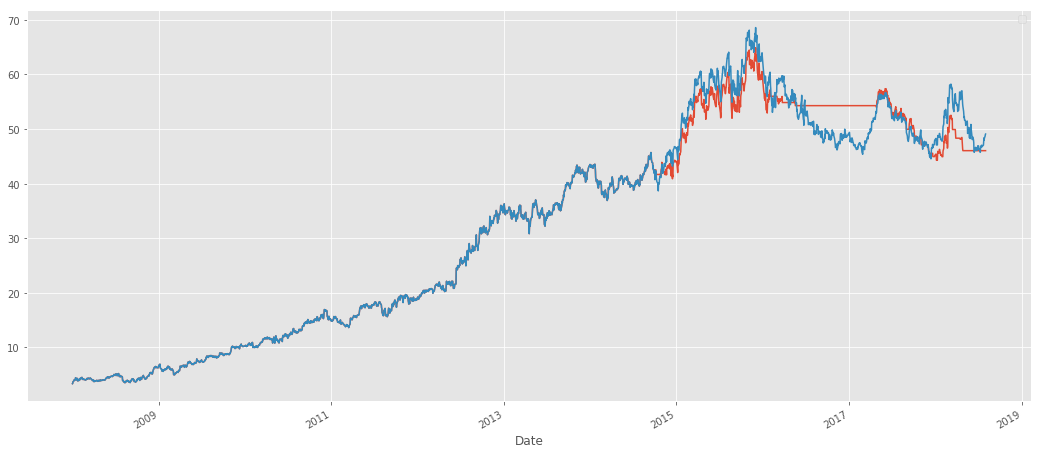

In [167]:
teto=crossover_tanto(f['itx_c_m_100_220'],tanto=.0,change=220)
teto.plot()
f['itx_c_m_100_220'].plot()
plt.legend(['Con lImite al 15%'],['Original'])

plt.show()

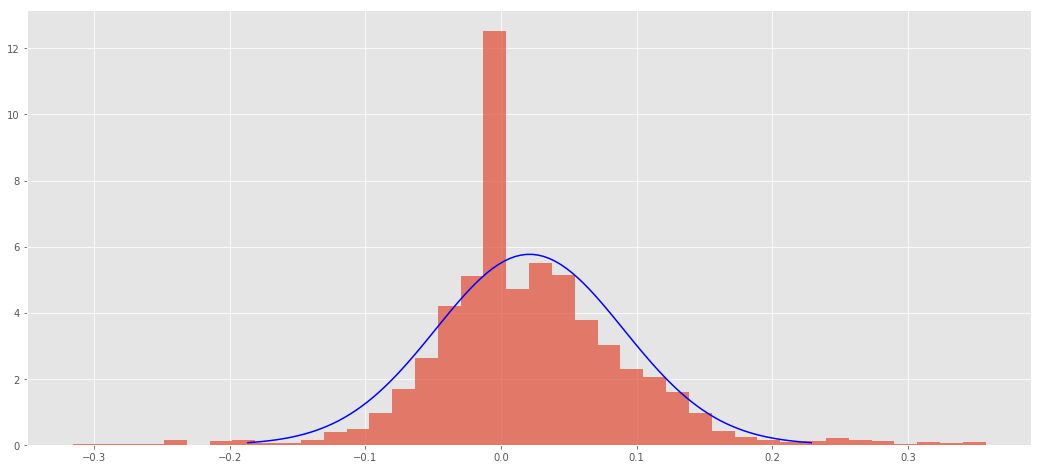

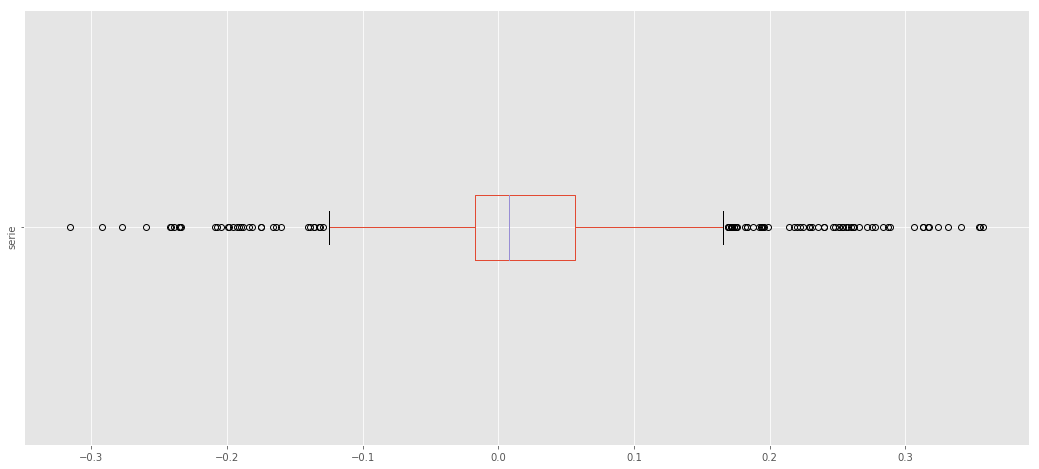

 el valor de 01p es : -0.14351 
 el valor de 05p es : -0.074541 
 el valor de 50p es : 0.0077041 
 el valor de 95p es : 0.13564 
 el valor de T-test es : 15.567 
 el valor de avg es : 0.021 
 el valor de kur es : 3.0499 
 el valor de skw es : 0.50895 
 el valor de std es : 0.069186 
 el valor de val es : -1.8197 
 el valor de var es : 0.0047867 


{'01p': -0.14351277853126218,
 '05p': -0.07454069021685598,
 '50p': 0.0077041234451467044,
 '95p': 0.13563956528807097,
 'T-test': 15.566582908274953,
 'avg': 0.021000000000000001,
 'kur': 3.0499312816695152,
 'skw': 0.50895457243276299,
 'std': 0.06918565294830537,
 'val': -1.8196714424492761,
 'var': 0.004786654573883355}

In [168]:
calculate_aggregate(teto.pct_change(20))

<h1>Conclusion</h1>

<p>Limitando el riesgo mensual podemos obtener mejores resultados o al menos tener un coste pequeño y nos podemos evitar el riesgo de cola que en toda distribución podemos tener

# reversión a la media

<p>Todo proceso de media constante y varianza constante, tiene la propiedad de revertir a la media, pues si nó, no cumpliría las características que le pedimos a nuestra serie.
<p>Por tanto si no cumple esta caracteristica abandonaremos la serie, pues dificilmente podremos hacer una predicción.
<p>Cuanto mejor podemos predecir una serie mayor revertirá a la media.
<p>Vamos a calcular una reversión de cada uno de nuestros sistemas que mejor se comportan. Y estudiaremos sus resultados.

In [169]:
#sistema reversion

In [170]:
#crear sistema menor que el 10%
def reversion_media(values,tanto=-.10,tanto2=0):
    
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(20)
    df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,np.nan)
    df['senal']=np.where((df.pctvalues>tanto2)&(df.pctvalues.shift()<tanto2),0,df['senal'])
    df['senal'].ffill(inplace=True)
    df['senal']=df['senal'].fillna(0)
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [171]:

f1=pd.DataFrame(index=f.index)
ccoco=f.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}

tanto=-.06
for n in ccoco:
      f1['{}_reversion'.format(n,tanto)]=reversion_media(f['{}'.format(n)],tanto)


In [172]:
f1.columns

Index([u'san_c_m_10_20_reversion', u'san_c_m_10_50_reversion',
       u'san_c_m_20_50_reversion', u'san_c_m_10_100_reversion',
       u'san_c_m_20_100_reversion', u'san_c_m_50_100_reversion',
       u'san_c_m_10_220_reversion', u'san_c_m_20_220_reversion',
       u'san_c_m_50_220_reversion', u'san_c_m_100_220_reversion',
       u'itx_c_m_10_20_reversion', u'itx_c_m_10_50_reversion',
       u'itx_c_m_20_50_reversion', u'itx_c_m_10_100_reversion',
       u'itx_c_m_20_100_reversion', u'itx_c_m_50_100_reversion',
       u'itx_c_m_10_220_reversion', u'itx_c_m_20_220_reversion',
       u'itx_c_m_50_220_reversion', u'itx_c_m_100_220_reversion',
       u'tef_c_m_10_20_reversion', u'tef_c_m_10_50_reversion',
       u'tef_c_m_20_50_reversion', u'tef_c_m_10_100_reversion',
       u'tef_c_m_20_100_reversion', u'tef_c_m_50_100_reversion',
       u'tef_c_m_10_220_reversion', u'tef_c_m_20_220_reversion',
       u'tef_c_m_50_220_reversion', u'tef_c_m_100_220_reversion'],
      dtype='object')

<h4>Grafico del sistema y del sistema en reversión a la media</h4>

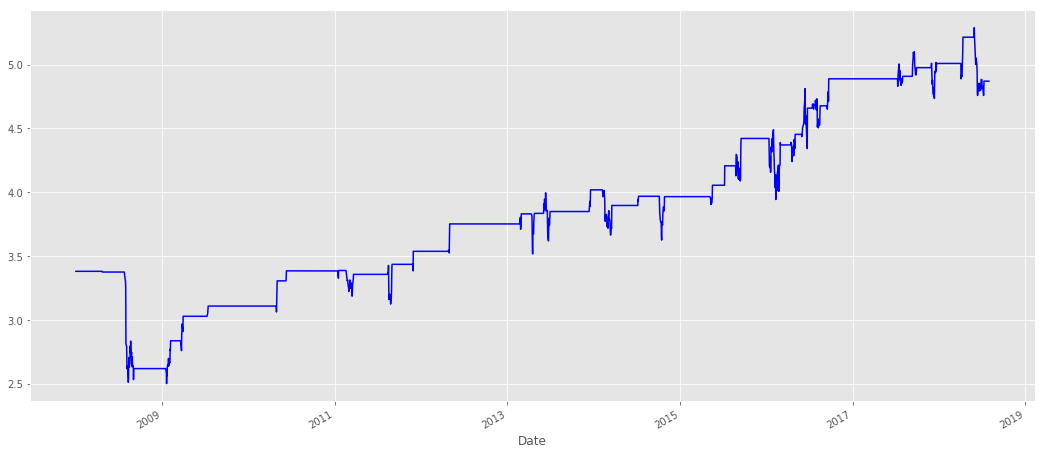

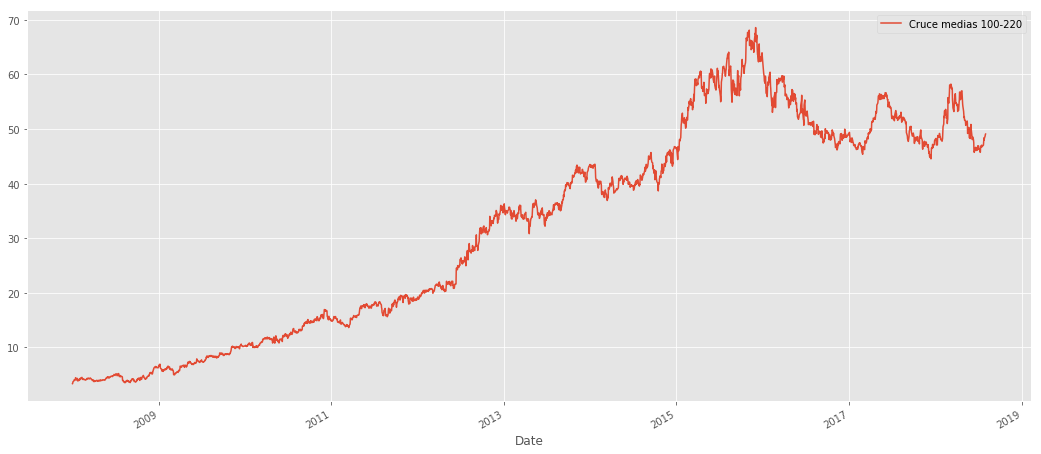

In [173]:
f1.itx_c_m_100_220_reversion.plot(c='b')
plt.show()
f.itx_c_m_100_220.plot()
plt.legend(['Cruce medias 100-220','Cruce medias 100-220 con reversion'])
plt.show()

<p>El rendimiento es mucho menor, pero parece que es más constante en rendimiento.

<h4>Gráficos de cada sistema en reversión a la media</h4>

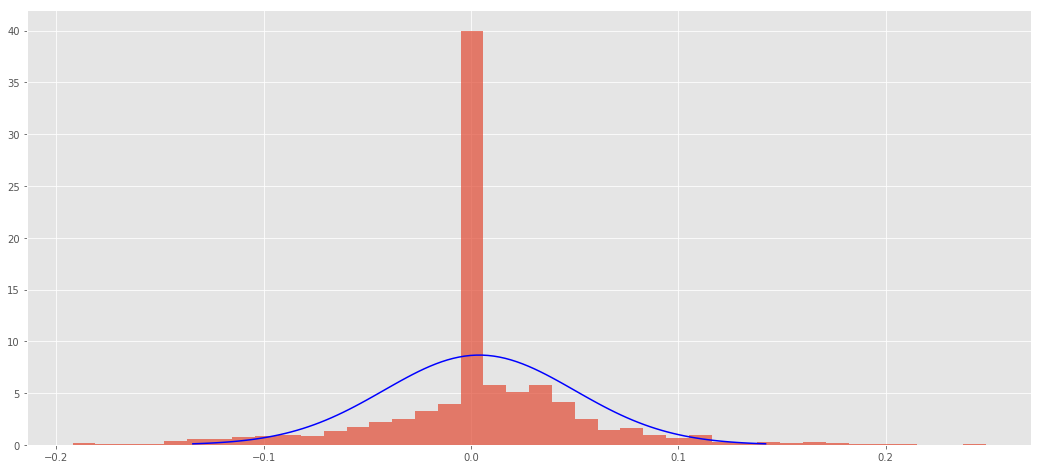

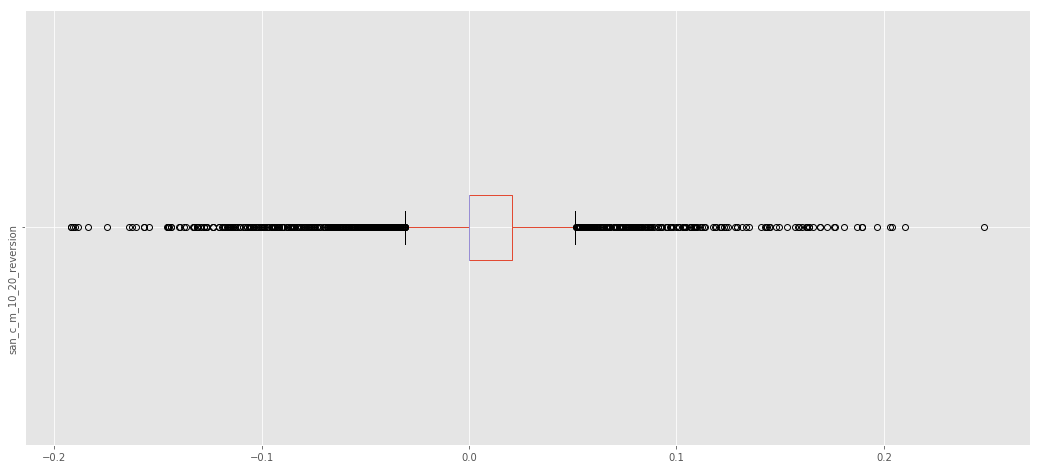

 el valor de 01p es : -0.13159 
 el valor de 05p es : -0.07947 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.081218 
 el valor de T-test es : 5.0526 
 el valor de avg es : 0.004 
 el valor de kur es : 3.6318 
 el valor de skw es : -0.014427 
 el valor de std es : 0.046029 
 el valor de val es : -1.022 
 el valor de var es : 0.0021186 


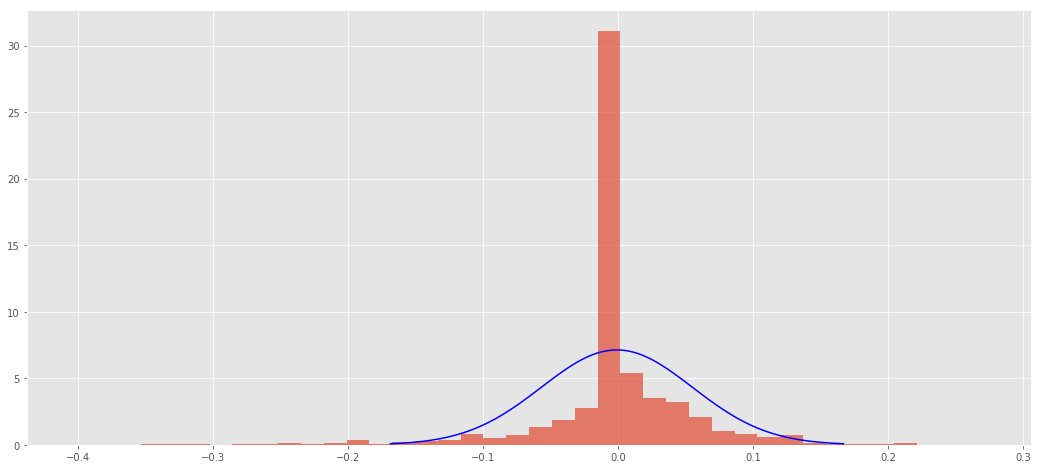

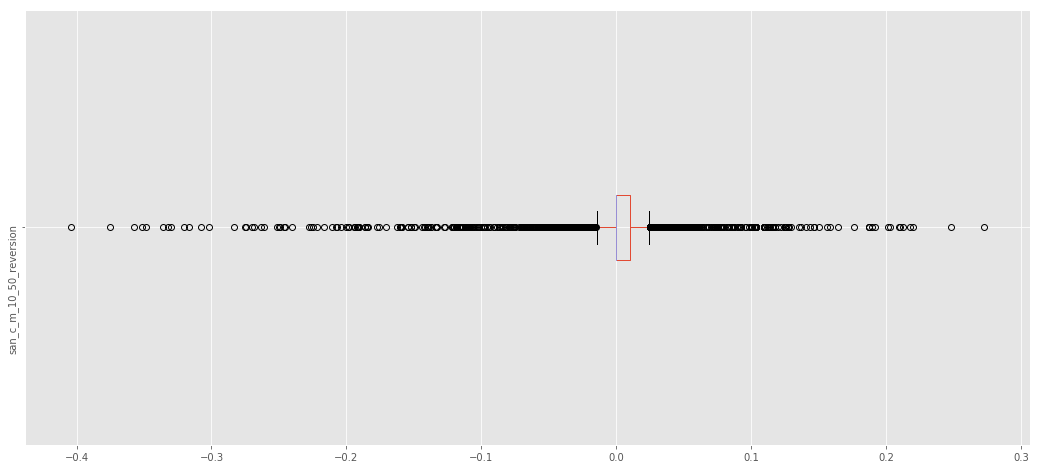

 el valor de 01p es : -0.22489 
 el valor de 05p es : -0.096923 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.077193 
 el valor de T-test es : -0.49093 
 el valor de avg es : -0.001 
 el valor de kur es : 10.232 
 el valor de skw es : -1.6391 
 el valor de std es : 0.055949 
 el valor de val es : -0.79644 
 el valor de var es : 0.0031303 


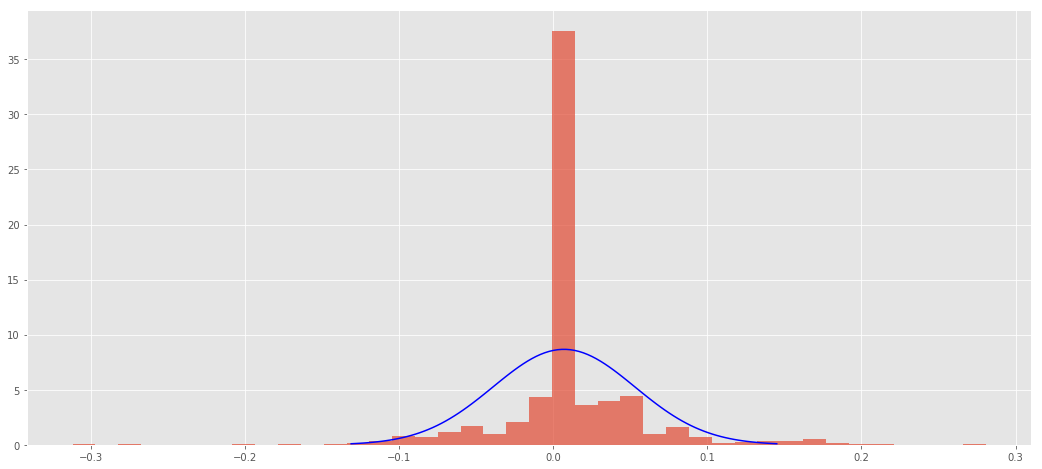

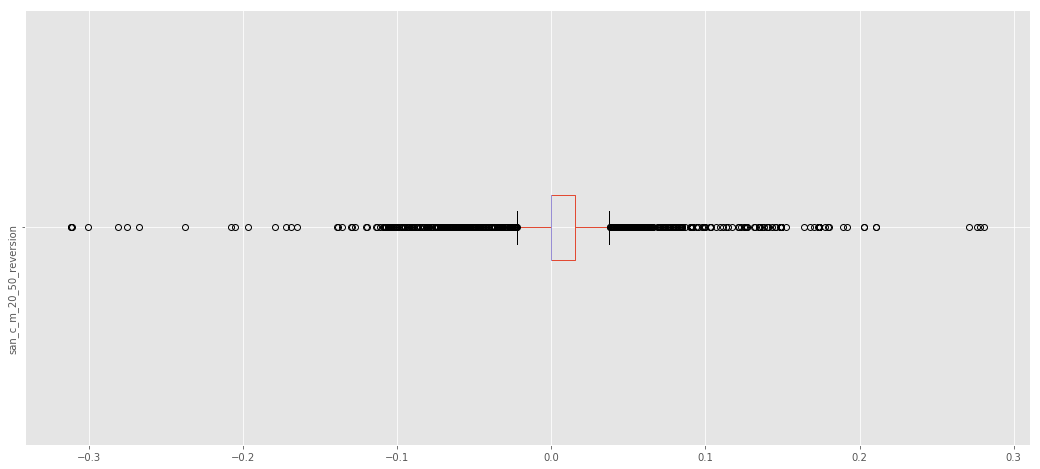

 el valor de 01p es : -0.10894 
 el valor de 05p es : -0.062606 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.080149 
 el valor de T-test es : 7.9821 
 el valor de avg es : 0.007 
 el valor de kur es : 9.5065 
 el valor de skw es : -0.010613 
 el valor de std es : 0.046023 
 el valor de val es : -1.2802 
 el valor de var es : 0.0021181 


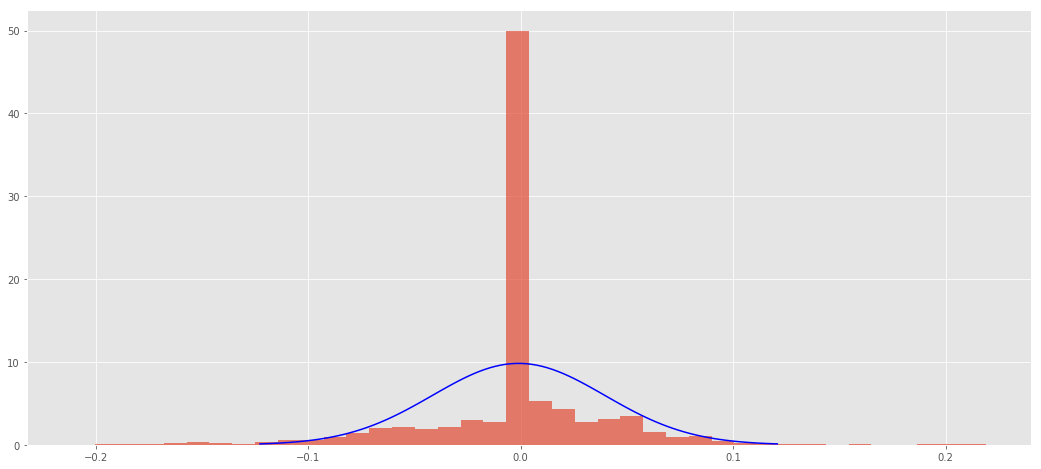

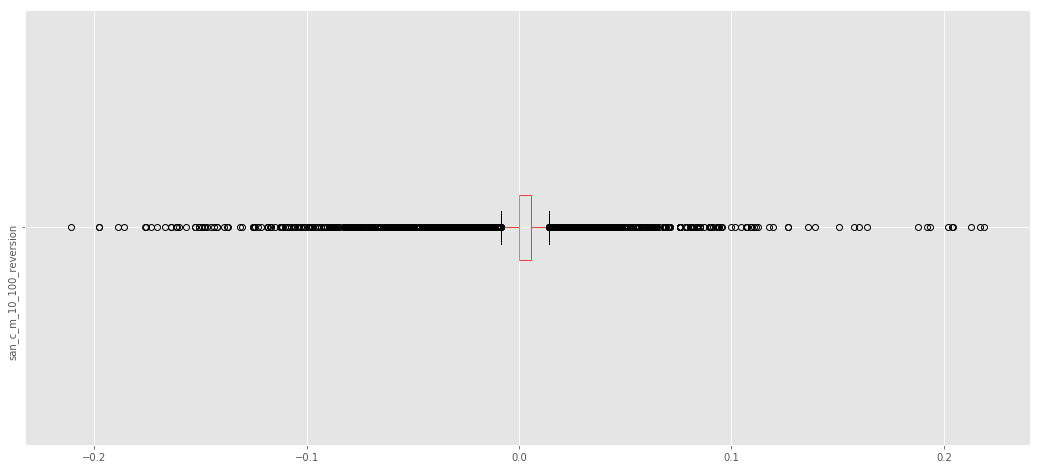

 el valor de 01p es : -0.14222 
 el valor de 05p es : -0.075467 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.060664 
 el valor de T-test es : -1.3524 
 el valor de avg es : -0.001 
 el valor de kur es : 5.3919 
 el valor de skw es : -0.37165 
 el valor de std es : 0.040598 
 el valor de val es : -0.80385 
 el valor de var es : 0.0016482 


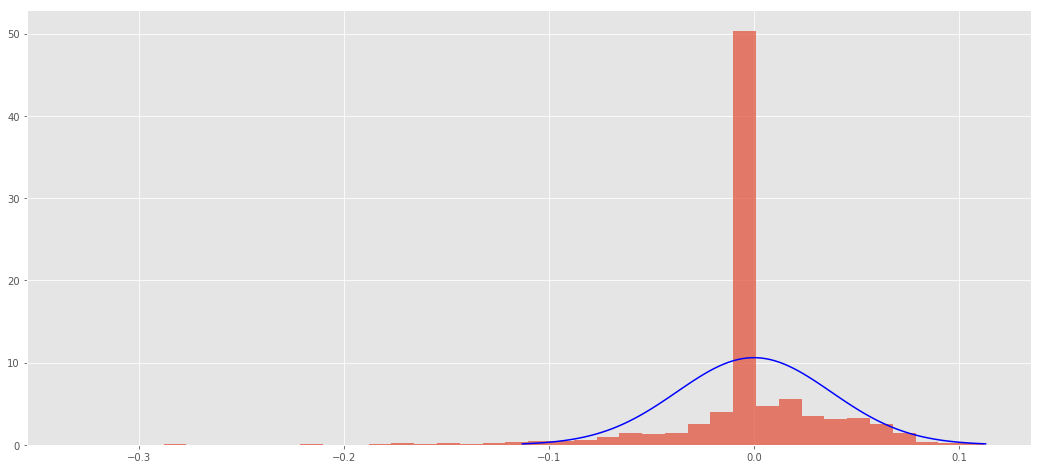

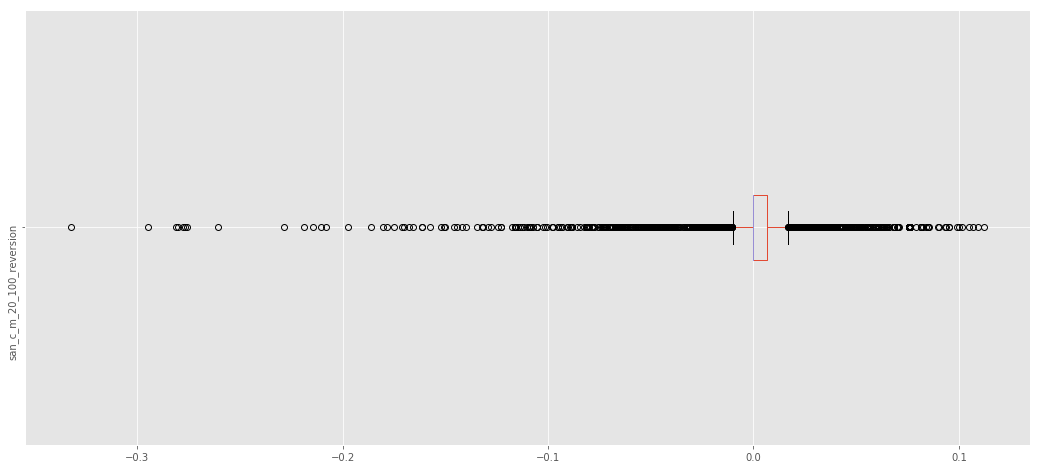

 el valor de 01p es : -0.15025 
 el valor de 05p es : -0.063056 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.058134 
 el valor de T-test es : 0.18617 
 el valor de avg es : 0.0 
 el valor de kur es : 14.374 
 el valor de skw es : -2.3987 
 el valor de std es : 0.03764 
 el valor de val es : -0.92194 
 el valor de var es : 0.0014168 


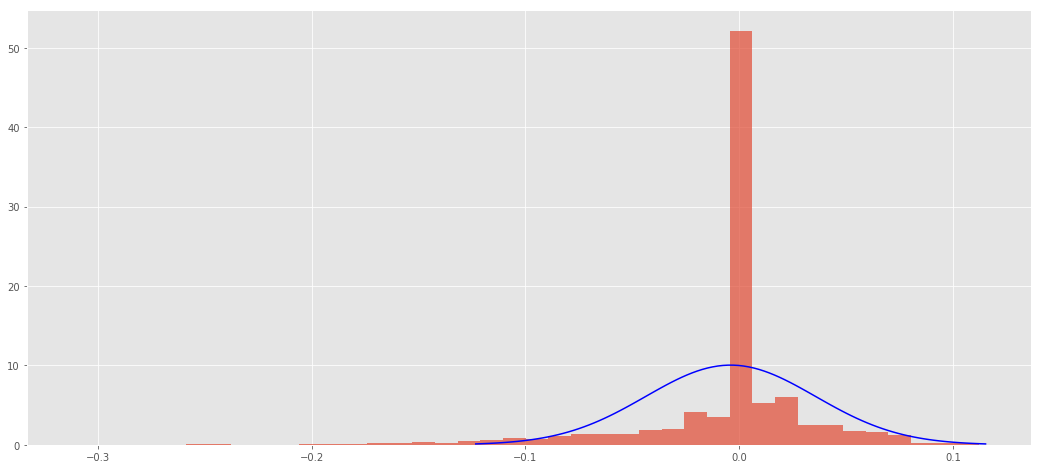

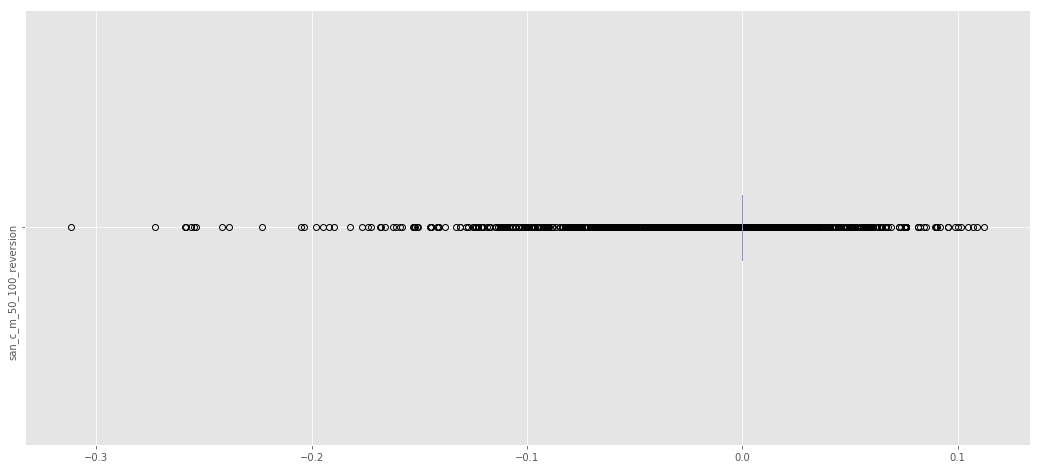

 el valor de 01p es : -0.15403 
 el valor de 05p es : -0.081346 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.051476 
 el valor de T-test es : -5.7071 
 el valor de avg es : -0.004 
 el valor de kur es : 9.3446 
 el valor de skw es : -2.102 
 el valor de std es : 0.03975 
 el valor de val es : -0.63281 
 el valor de var es : 0.0015801 


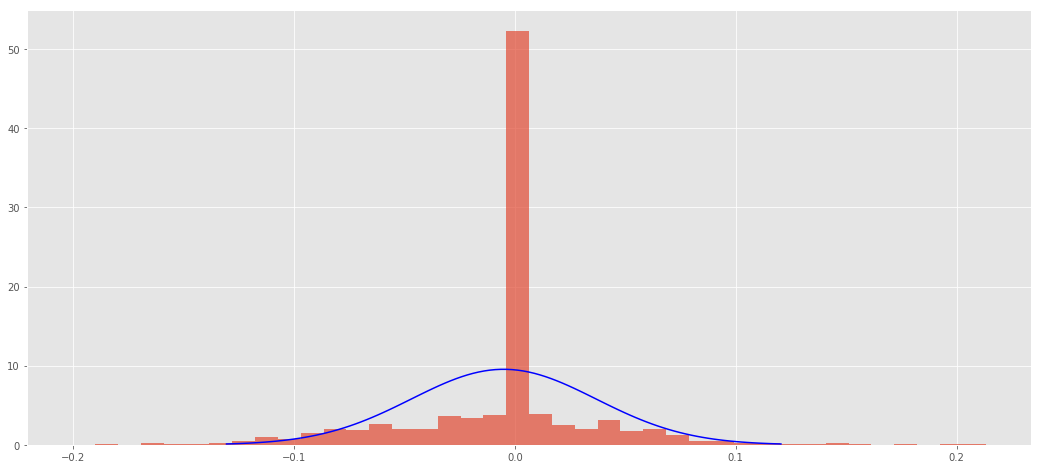

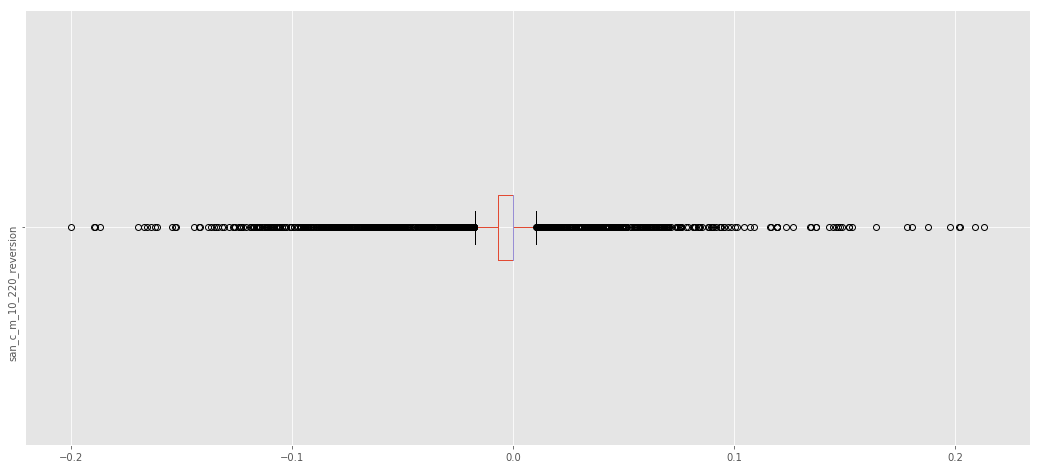

 el valor de 01p es : -0.12445 
 el valor de 05p es : -0.084845 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.060717 
 el valor de T-test es : -6.2204 
 el valor de avg es : -0.005 
 el valor de kur es : 3.9808 
 el valor de skw es : -0.17627 
 el valor de std es : 0.04181 
 el valor de val es : -0.71562 
 el valor de var es : 0.0017481 


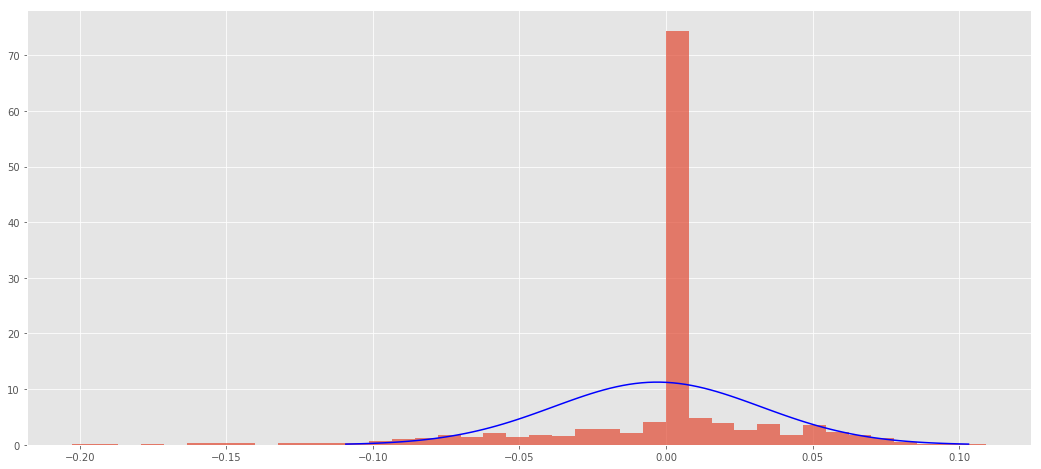

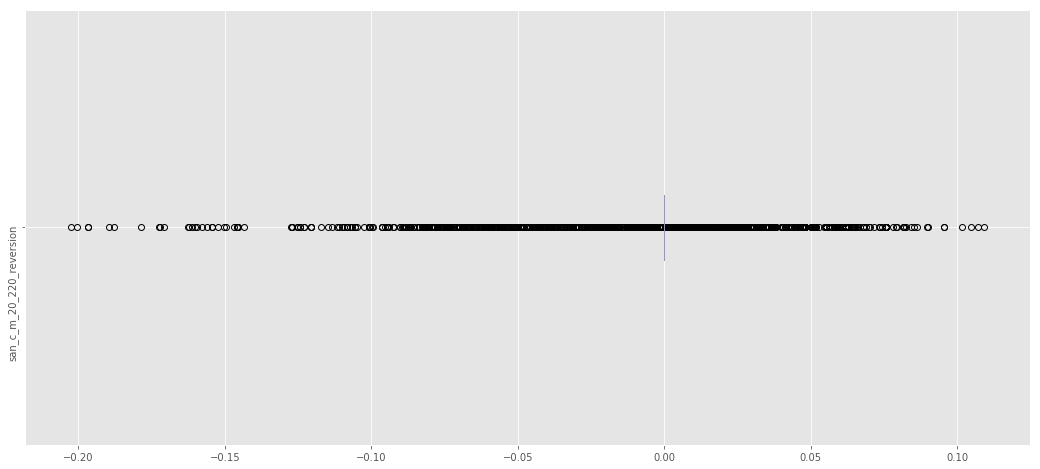

 el valor de 01p es : -0.14386 
 el valor de 05p es : -0.073146 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.051324 
 el valor de T-test es : -3.9526 
 el valor de avg es : -0.003 
 el valor de kur es : 5.4787 
 el valor de skw es : -1.4286 
 el valor de std es : 0.035419 
 el valor de val es : -0.70167 
 el valor de var es : 0.0012545 


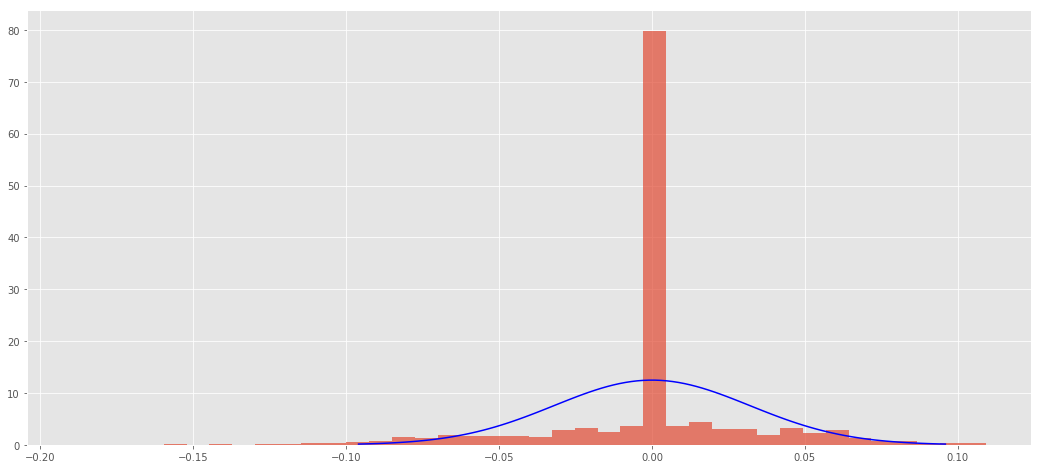

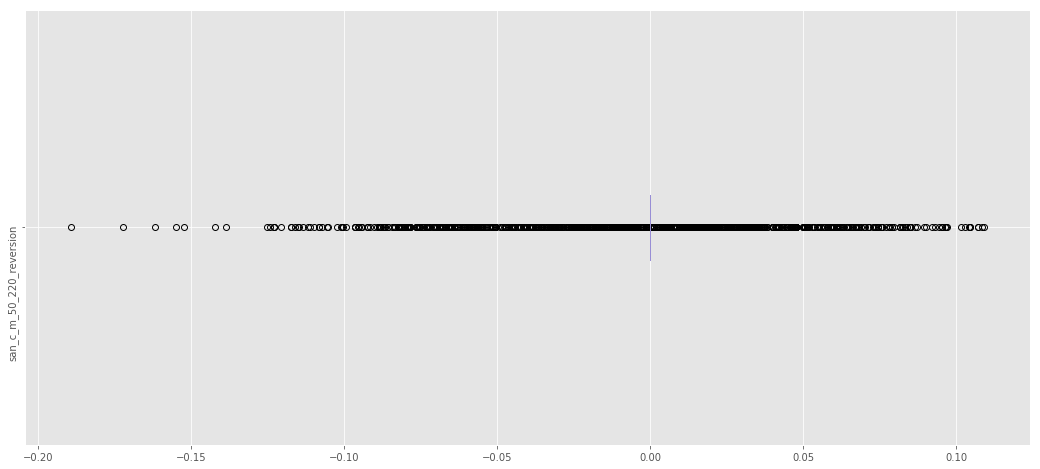

 el valor de 01p es : -0.10305 
 el valor de 05p es : -0.065185 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.057052 
 el valor de T-test es : -0.73085 
 el valor de avg es : -0.0 
 el valor de kur es : 3.8759 
 el valor de skw es : -0.67867 
 el valor de std es : 0.031976 
 el valor de val es : -0.87523 
 el valor de var es : 0.0010225 


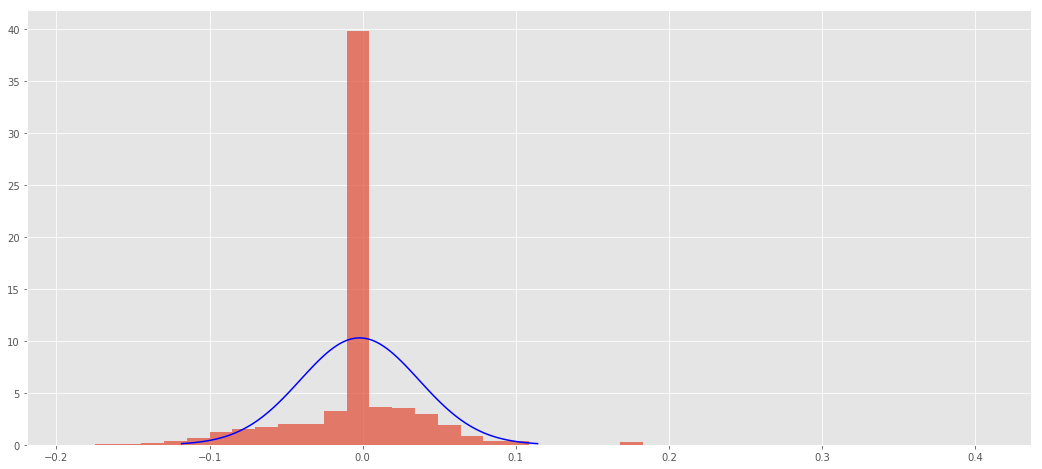

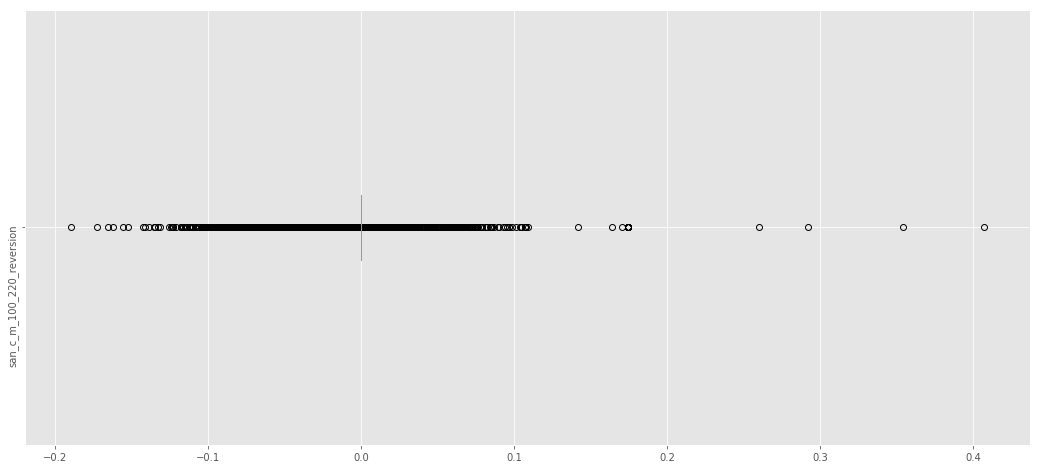

 el valor de 01p es : -0.11485 
 el valor de 05p es : -0.078976 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.055064 
 el valor de T-test es : -3.0978 
 el valor de avg es : -0.002 
 el valor de kur es : 12.408 
 el valor de skw es : 0.68462 
 el valor de std es : 0.038742 
 el valor de val es : -0.69722 
 el valor de var es : 0.0015009 


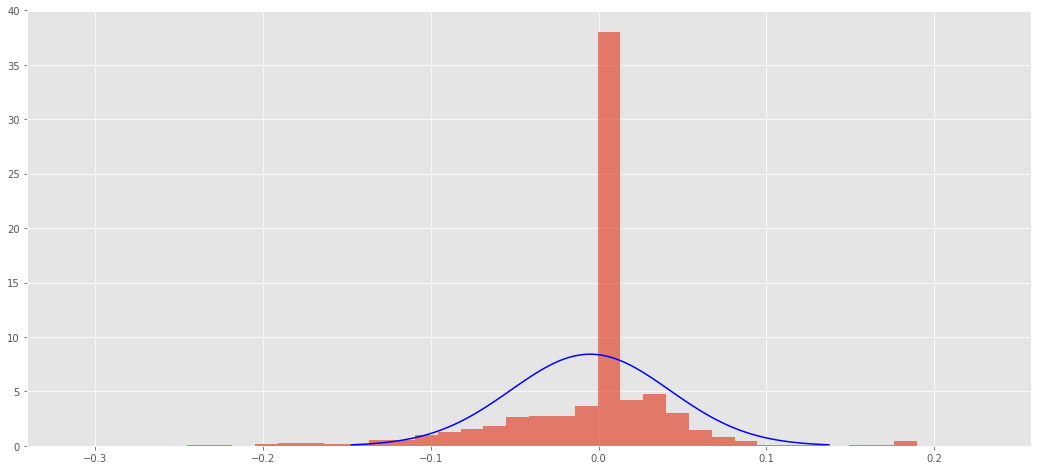

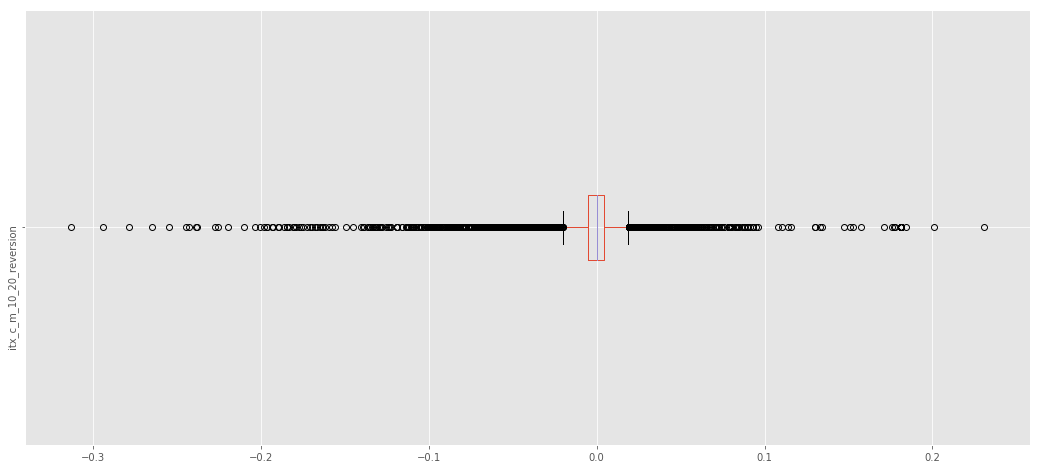

 el valor de 01p es : -0.18058 
 el valor de 05p es : -0.091858 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.053669 
 el valor de T-test es : -5.585 
 el valor de avg es : -0.005 
 el valor de kur es : 6.9001 
 el valor de skw es : -1.0158 
 el valor de std es : 0.0474 
 el valor de val es : -0.58426 
 el valor de var es : 0.0022468 


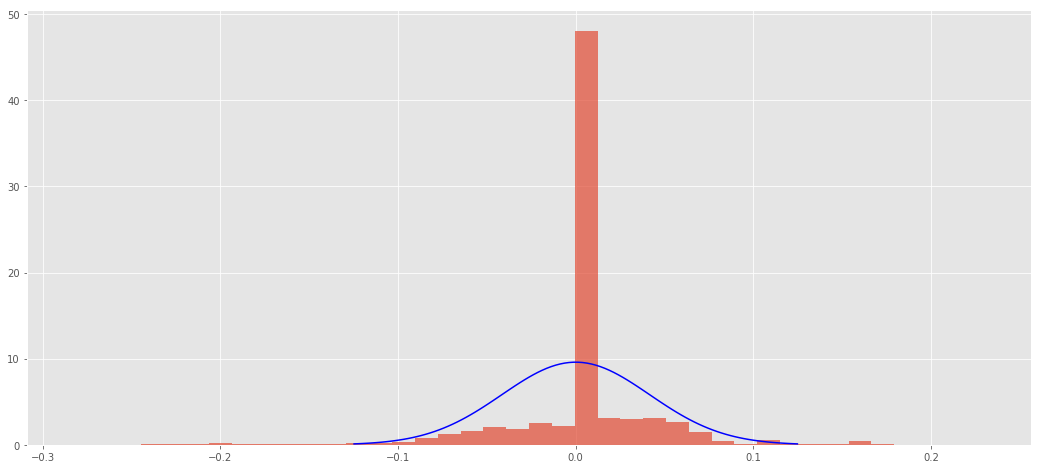

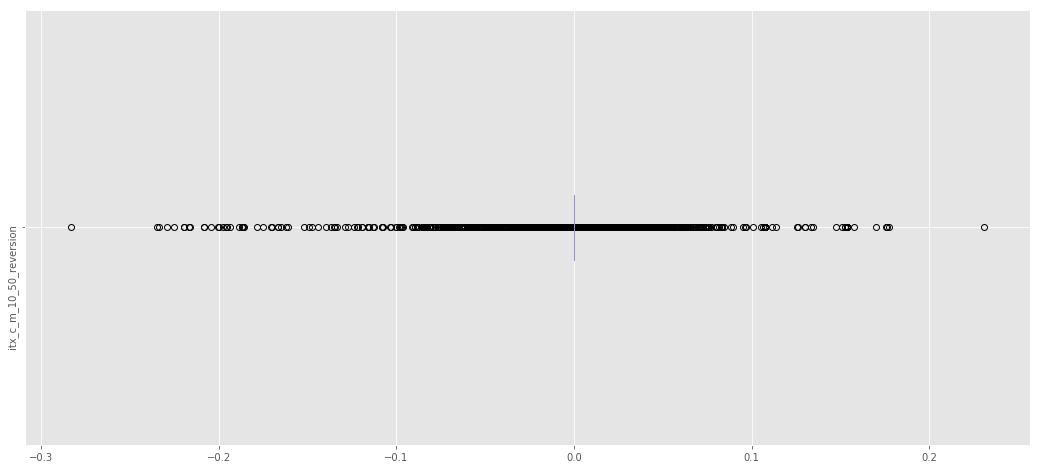

 el valor de 01p es : -0.16713 
 el valor de 05p es : -0.066774 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.063567 
 el valor de T-test es : 0.55436 
 el valor de avg es : 0.0 
 el valor de kur es : 8.5148 
 el valor de skw es : -0.90894 
 el valor de std es : 0.041578 
 el valor de val es : -0.95198 
 el valor de var es : 0.0017287 


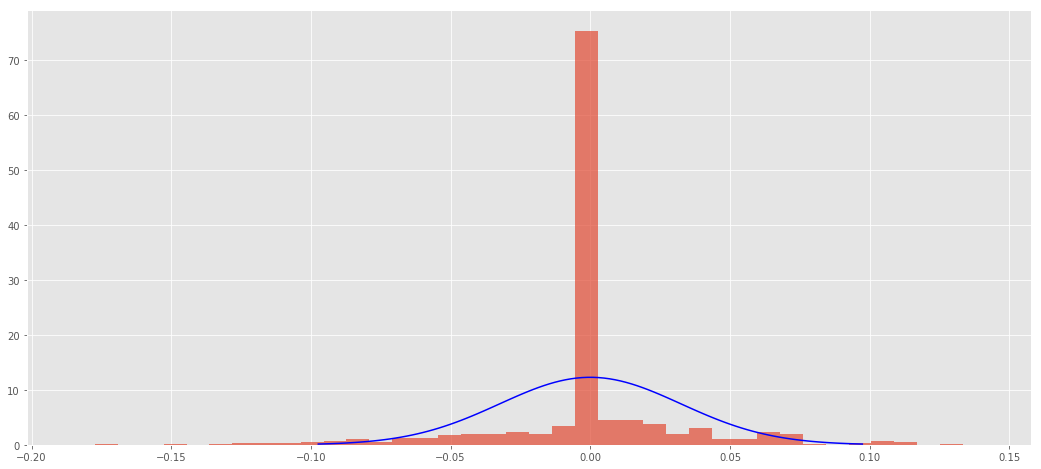

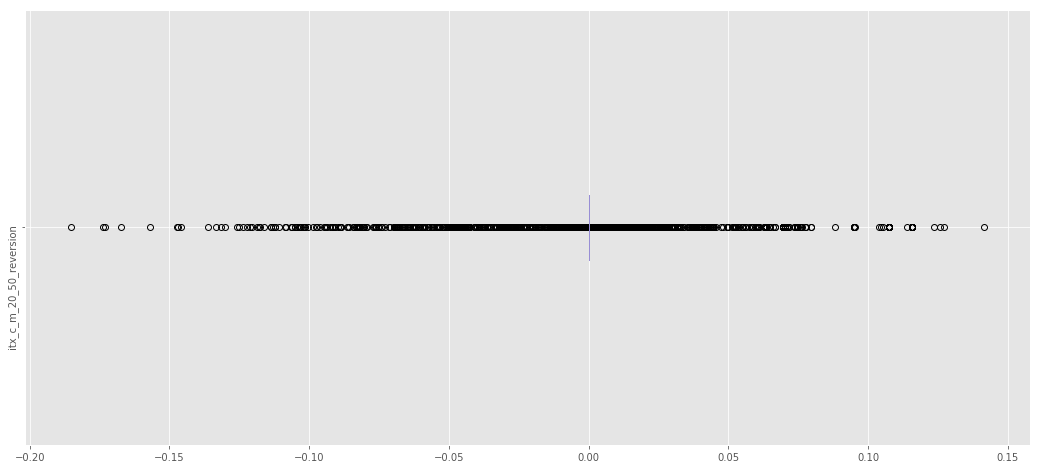

 el valor de 01p es : -0.11096 
 el valor de 05p es : -0.059618 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.060715 
 el valor de T-test es : 0.14115 
 el valor de avg es : 0.0 
 el valor de kur es : 5.2841 
 el valor de skw es : -0.55511 
 el valor de std es : 0.032454 
 el valor de val es : -1.0184 
 el valor de var es : 0.0010533 


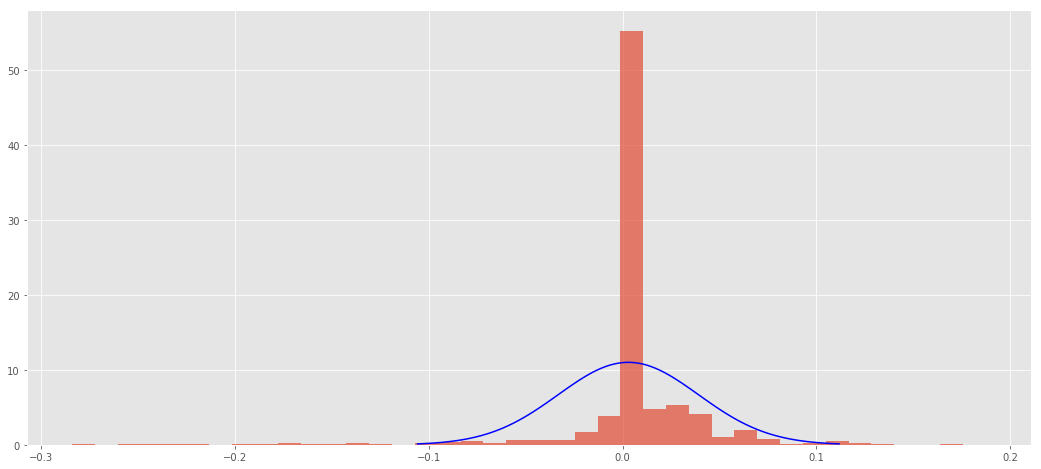

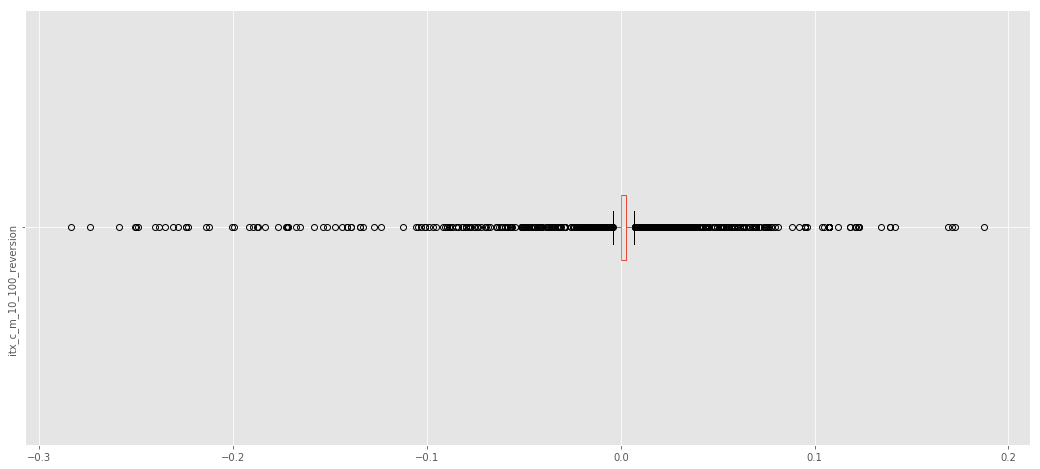

 el valor de 01p es : -0.17173 
 el valor de 05p es : -0.036154 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.055479 
 el valor de T-test es : 4.4243 
 el valor de avg es : 0.003 
 el valor de kur es : 17.444 
 el valor de skw es : -2.3595 
 el valor de std es : 0.036251 
 el valor de val es : -1.5345 
 el valor de var es : 0.0013141 


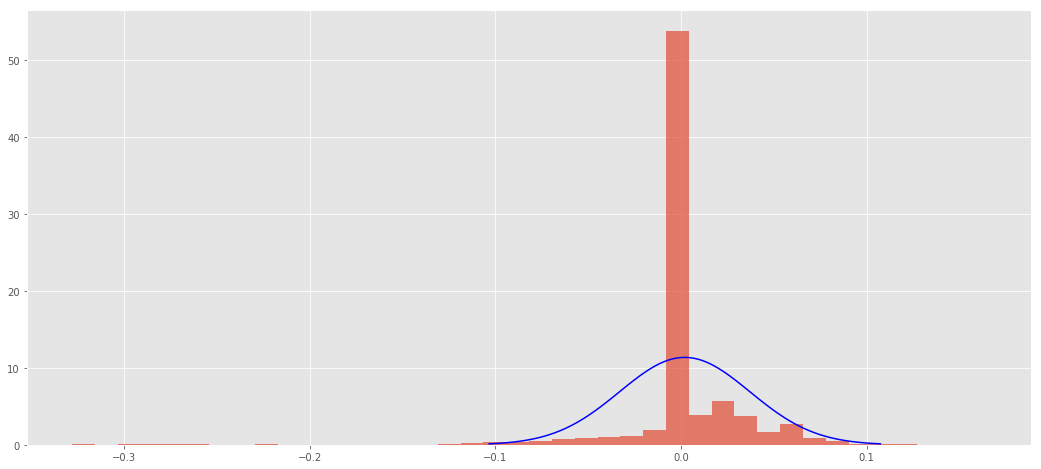

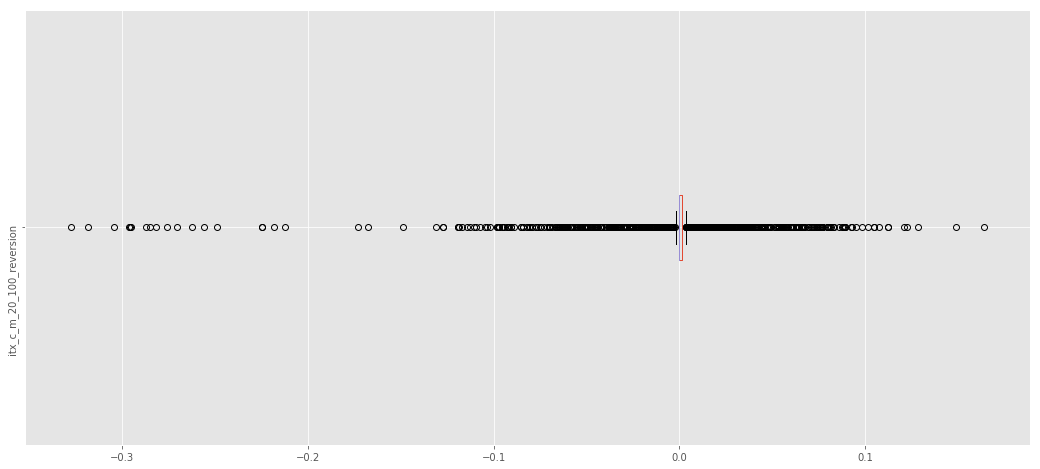

 el valor de 01p es : -0.11727 
 el valor de 05p es : -0.041973 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.054872 
 el valor de T-test es : 3.5676 
 el valor de avg es : 0.002 
 el valor de kur es : 27.466 
 el valor de skw es : -3.4023 
 el valor de std es : 0.035118 
 el valor de val es : -1.3073 
 el valor de var es : 0.0012333 


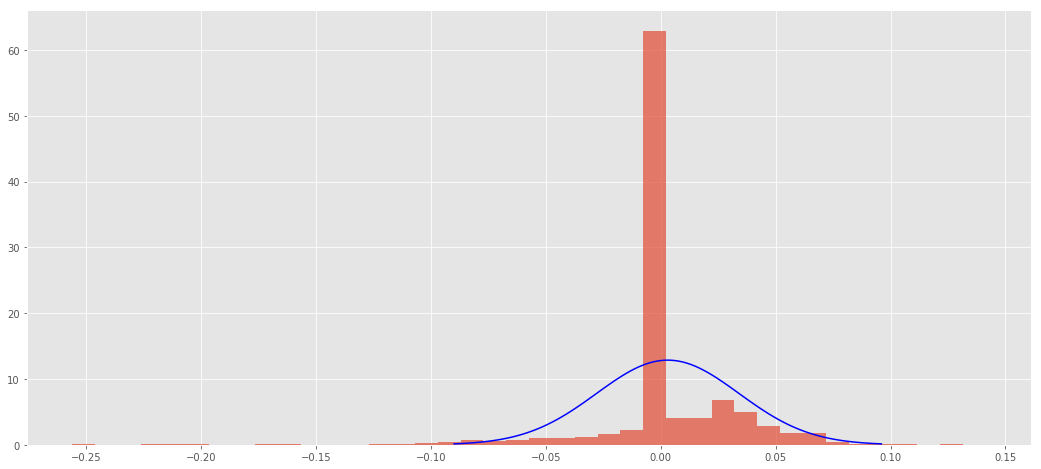

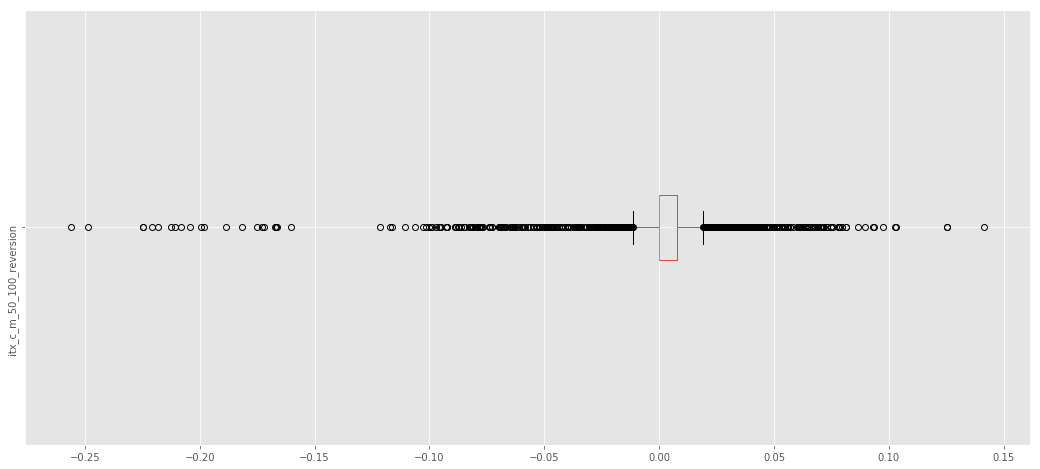

 el valor de 01p es : -0.10173 
 el valor de 05p es : -0.044446 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.04767 
 el valor de T-test es : 5.099 
 el valor de avg es : 0.003 
 el valor de kur es : 16.018 
 el valor de skw es : -2.35 
 el valor de std es : 0.030994 
 el valor de val es : -1.0725 
 el valor de var es : 0.00096064 


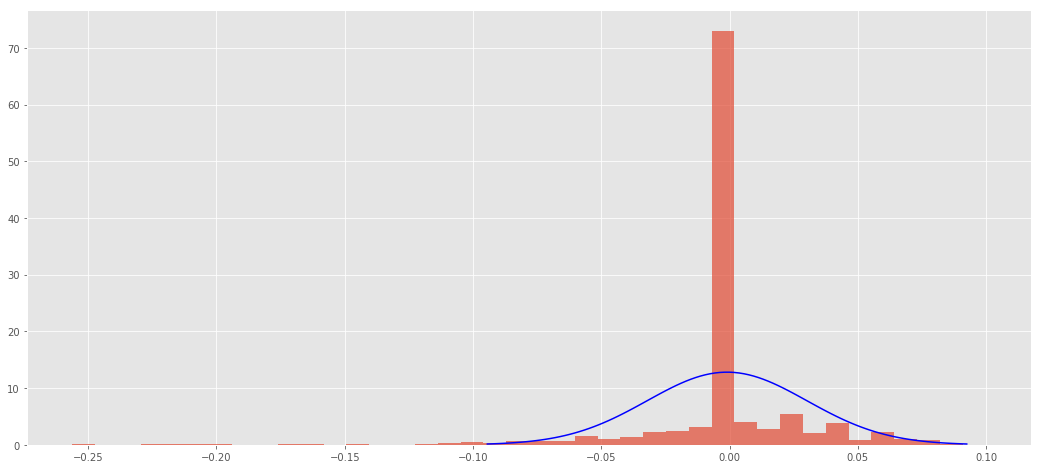

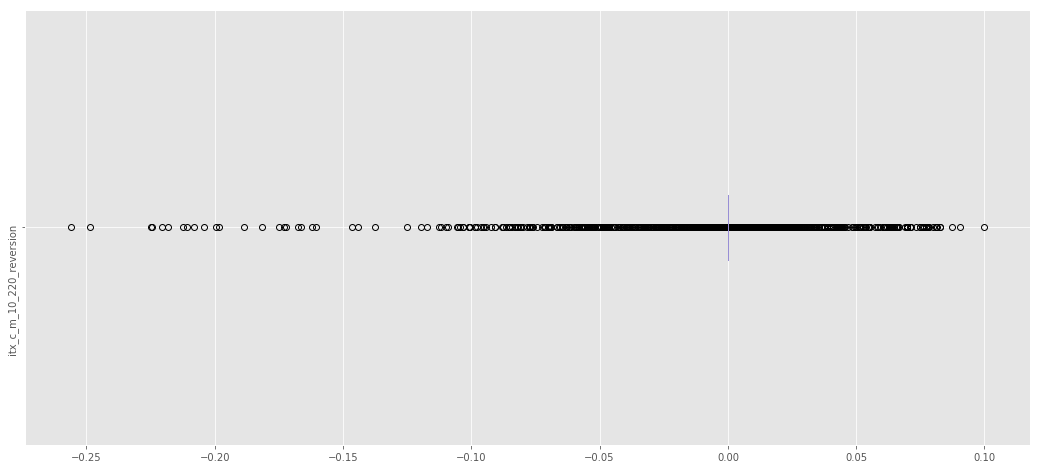

 el valor de 01p es : -0.11332 
 el valor de 05p es : -0.052234 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.044164 
 el valor de T-test es : -0.88289 
 el valor de avg es : -0.001 
 el valor de kur es : 15.085 
 el valor de skw es : -2.4213 
 el valor de std es : 0.031142 
 el valor de val es : -0.8455 
 el valor de var es : 0.00096982 


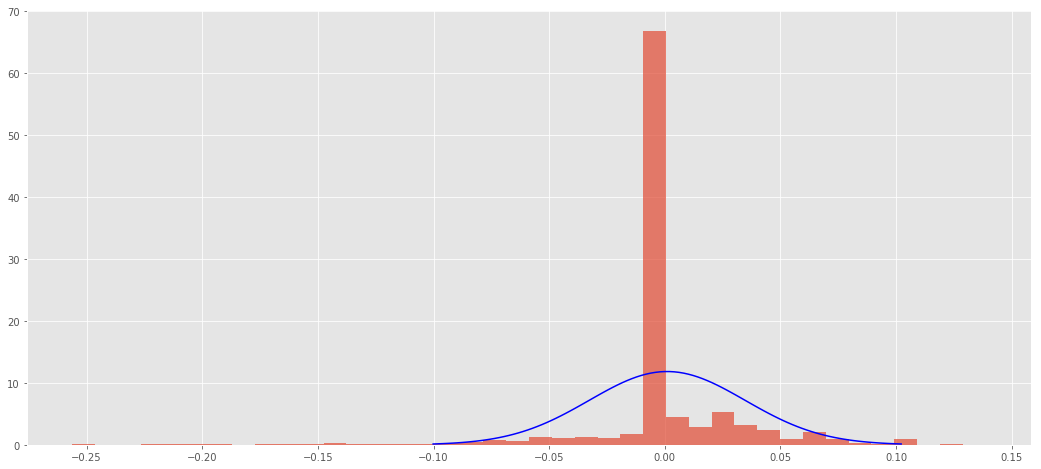

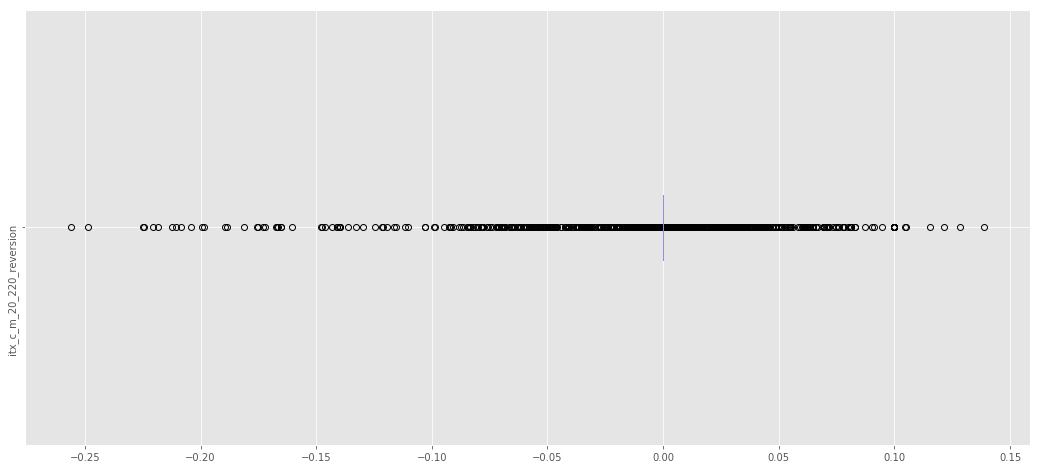

 el valor de 01p es : -0.14647 
 el valor de 05p es : -0.051606 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.052524 
 el valor de T-test es : 1.7049 
 el valor de avg es : 0.001 
 el valor de kur es : 13.351 
 el valor de skw es : -2.0795 
 el valor de std es : 0.033726 
 el valor de val es : -1.0178 
 el valor de var es : 0.0011374 


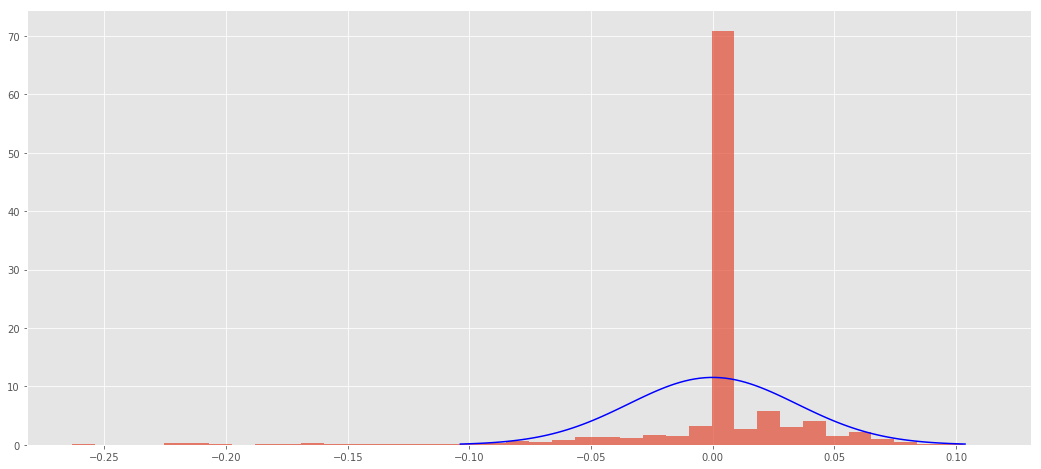

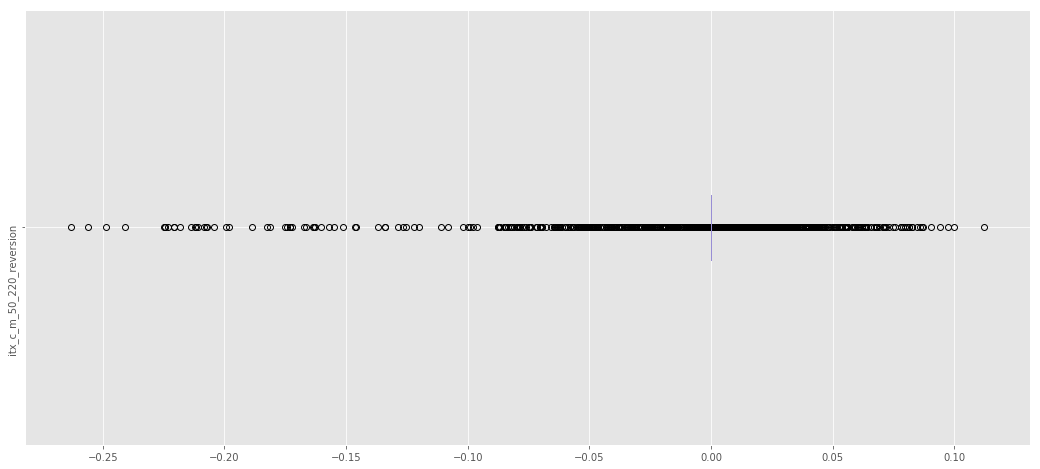

 el valor de 01p es : -0.17297 
 el valor de 05p es : -0.050012 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.047701 
 el valor de T-test es : 0.28374 
 el valor de avg es : 0.0 
 el valor de kur es : 16.732 
 el valor de skw es : -2.9444 
 el valor de std es : 0.034574 
 el valor de val es : -0.9538 
 el valor de var es : 0.0011954 


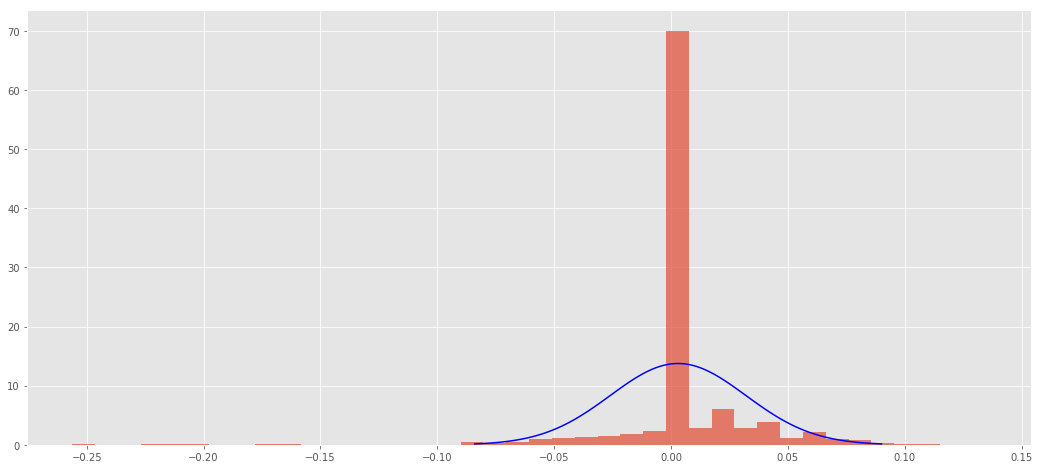

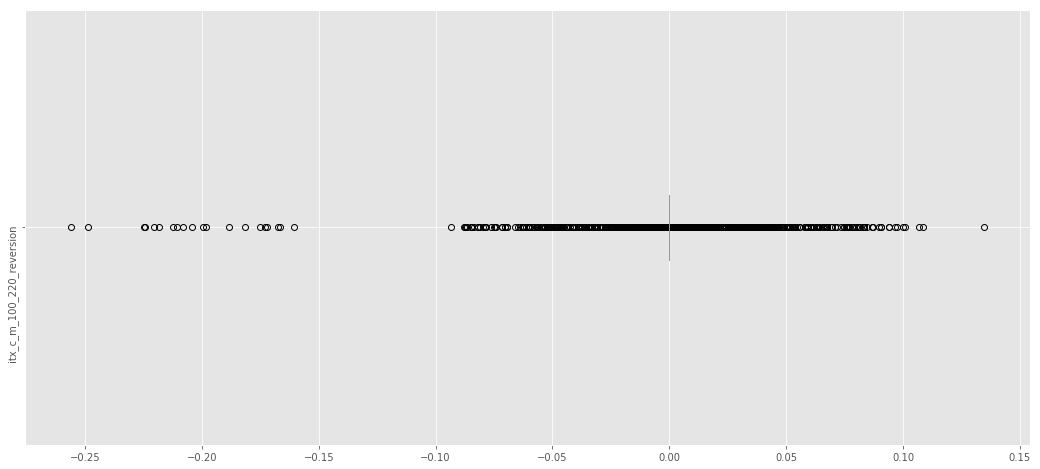

 el valor de 01p es : -0.084583 
 el valor de 05p es : -0.033713 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.05088 
 el valor de T-test es : 5.637 
 el valor de avg es : 0.003 
 el valor de kur es : 20.067 
 el valor de skw es : -2.3452 
 el valor de std es : 0.029015 
 el valor de val es : -1.5092 
 el valor de var es : 0.00084185 


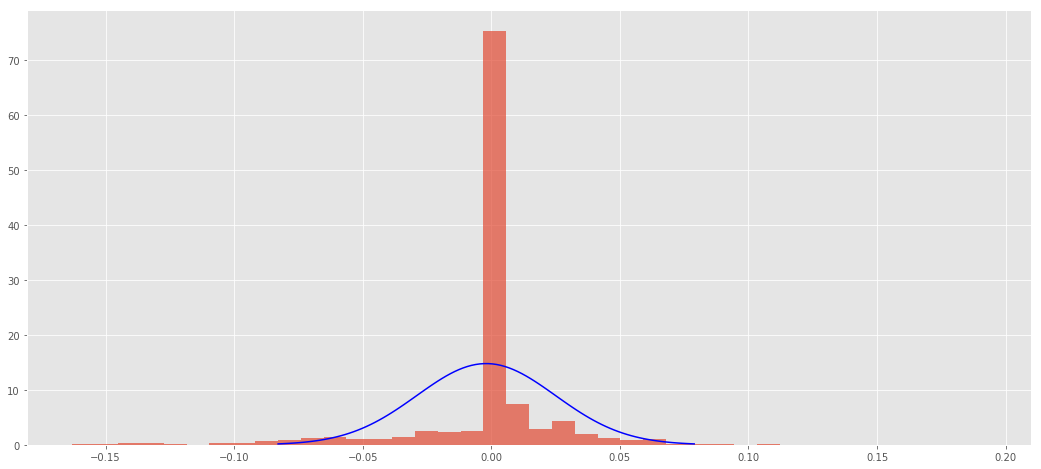

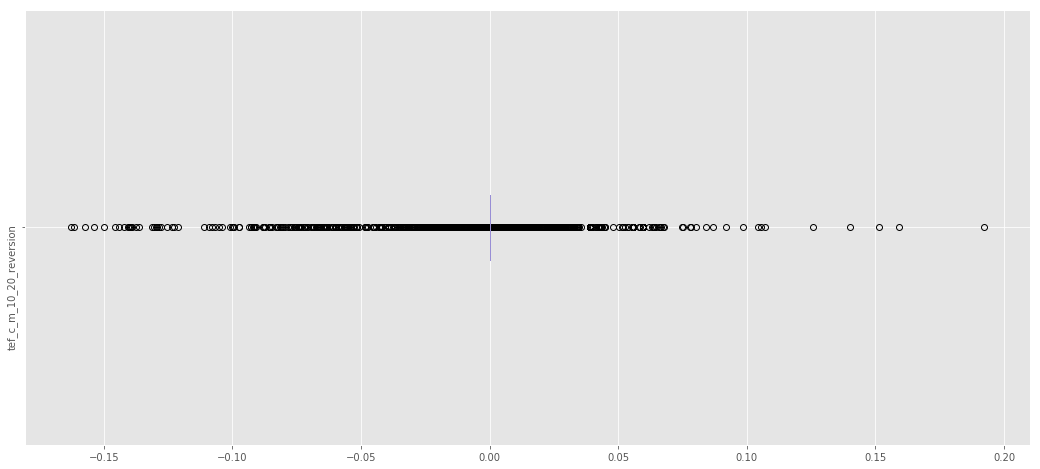

 el valor de 01p es : -0.10824 
 el valor de 05p es : -0.056365 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.032739 
 el valor de T-test es : -3.1882 
 el valor de avg es : -0.002 
 el valor de kur es : 10.138 
 el valor de skw es : -1.3849 
 el valor de std es : 0.026967 
 el valor de val es : -0.58084 
 el valor de var es : 0.00072723 


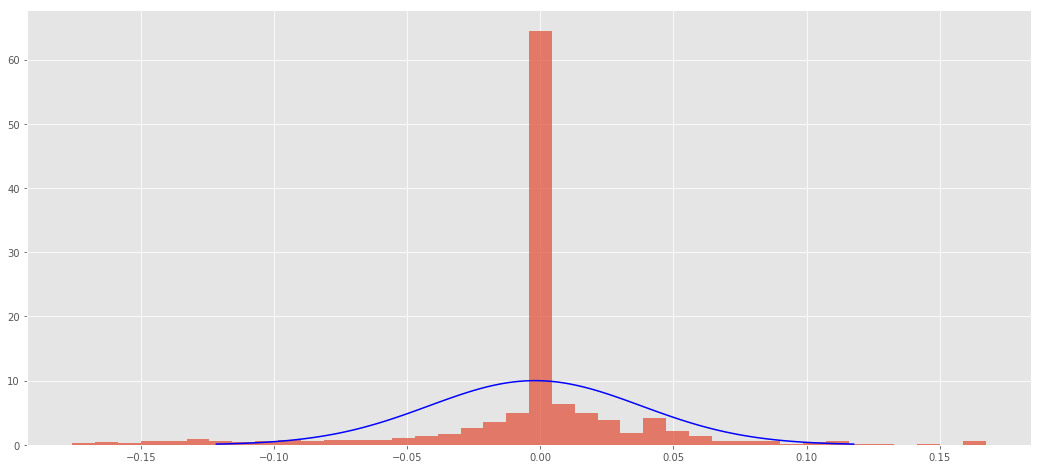

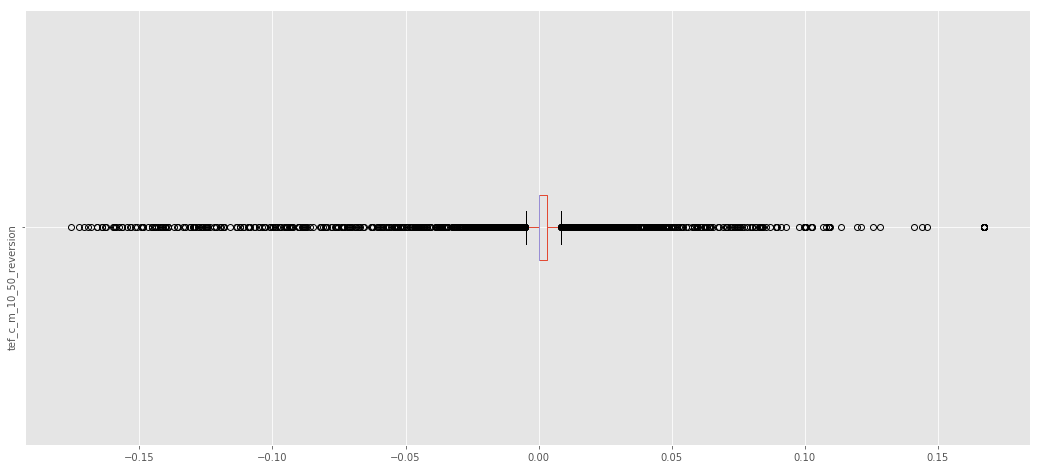

 el valor de 01p es : -0.14693 
 el valor de 05p es : -0.087321 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.049671 
 el valor de T-test es : -2.0987 
 el valor de avg es : -0.002 
 el valor de kur es : 5.6476 
 el valor de skw es : -0.91877 
 el valor de std es : 0.039893 
 el valor de val es : -0.56883 
 el valor de var es : 0.0015914 


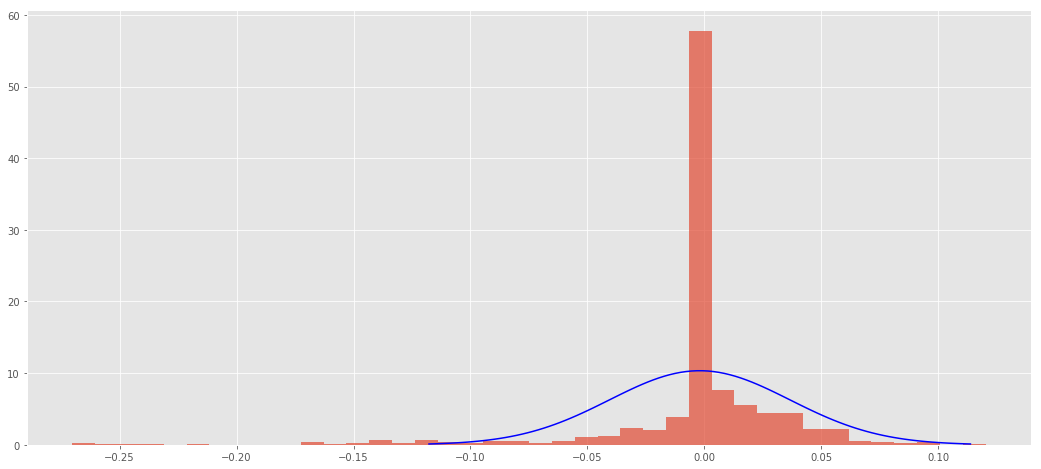

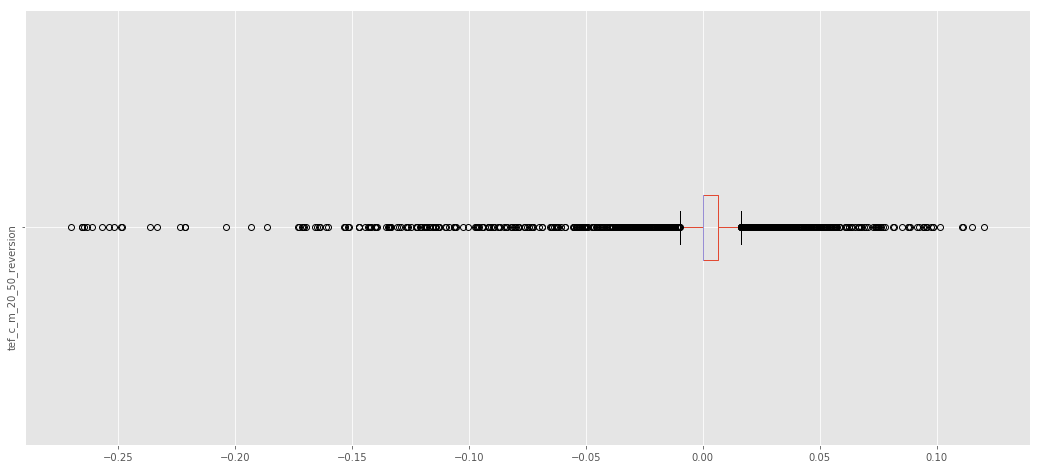

 el valor de 01p es : -0.16407 
 el valor de 05p es : -0.069879 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.048258 
 el valor de T-test es : -2.5367 
 el valor de avg es : -0.002 
 el valor de kur es : 13.495 
 el valor de skw es : -2.7673 
 el valor de std es : 0.038578 
 el valor de val es : -0.6906 
 el valor de var es : 0.0014882 


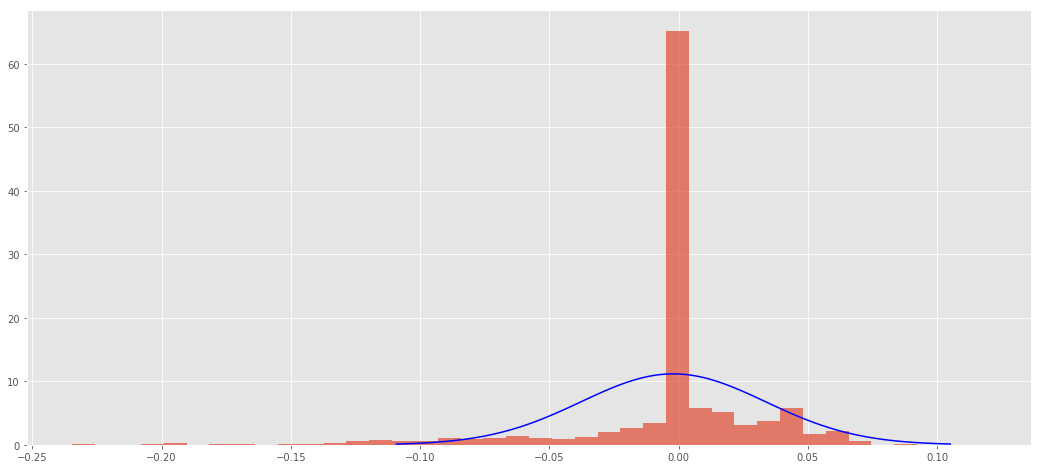

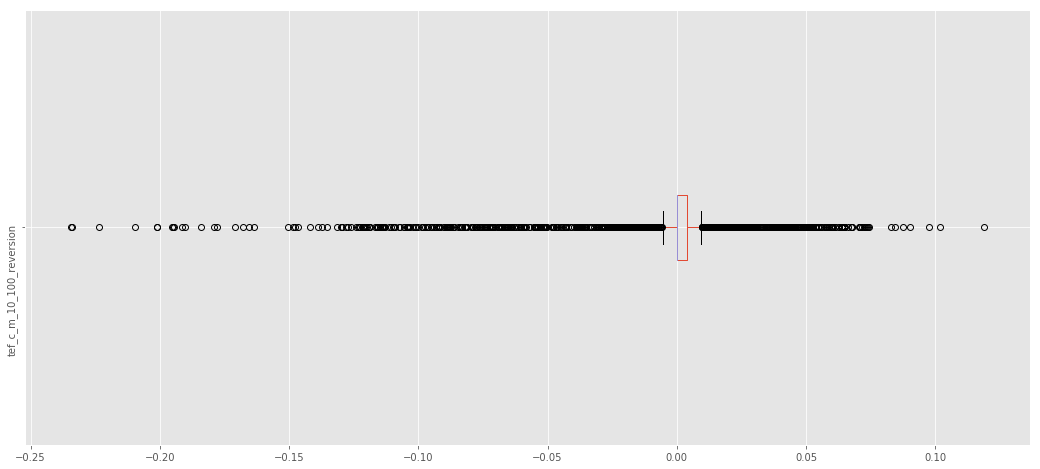

 el valor de 01p es : -0.13014 
 el valor de 05p es : -0.077607 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.045576 
 el valor de T-test es : -2.8181 
 el valor de avg es : -0.002 
 el valor de kur es : 7.6589 
 el valor de skw es : -2.0001 
 el valor de std es : 0.035714 
 el valor de val es : -0.58726 
 el valor de var es : 0.0012755 


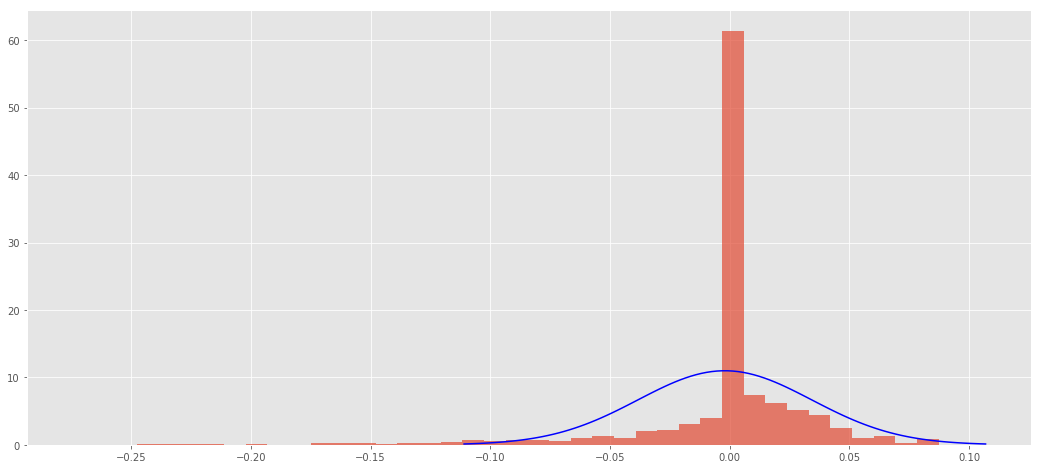

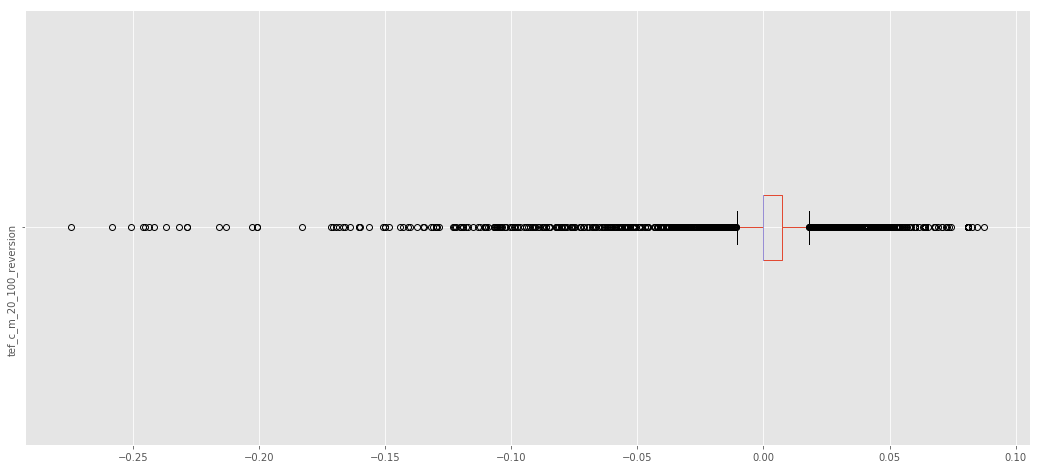

 el valor de 01p es : -0.15691 
 el valor de 05p es : -0.068936 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042428 
 el valor de T-test es : -2.8428 
 el valor de avg es : -0.002 
 el valor de kur es : 12.769 
 el valor de skw es : -2.6754 
 el valor de std es : 0.036316 
 el valor de val es : -0.61546 
 el valor de var es : 0.0013188 


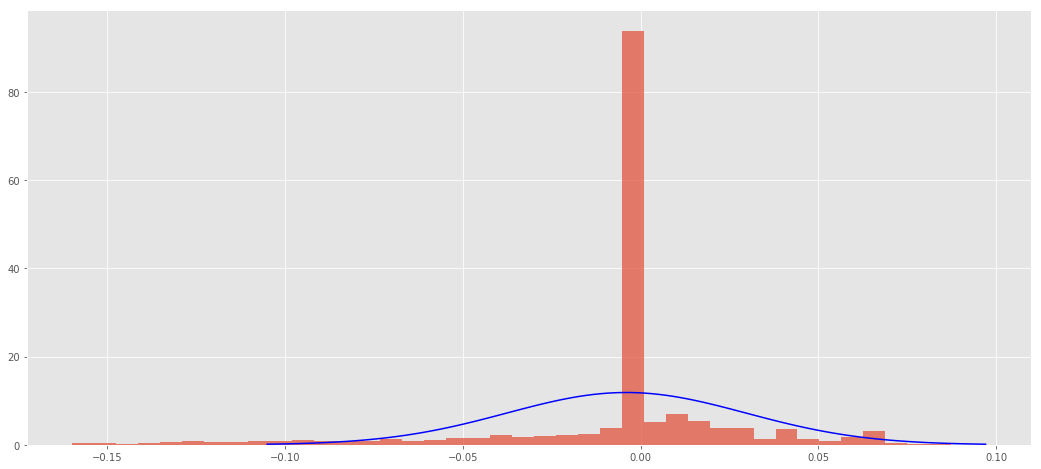

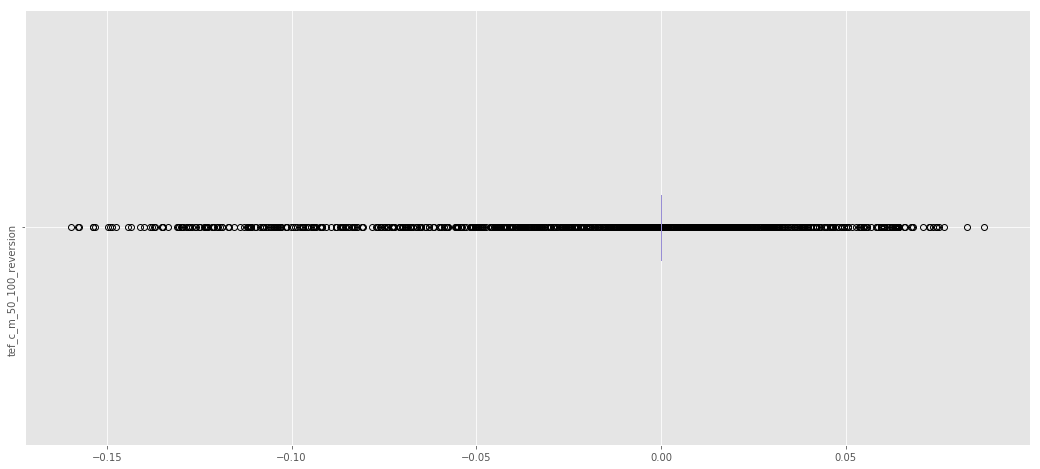

 el valor de 01p es : -0.12966 
 el valor de 05p es : -0.083637 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042026 
 el valor de T-test es : -6.4376 
 el valor de avg es : -0.004 
 el valor de kur es : 4.8951 
 el valor de skw es : -1.6842 
 el valor de std es : 0.033665 
 el valor de val es : -0.50248 
 el valor de var es : 0.0011334 


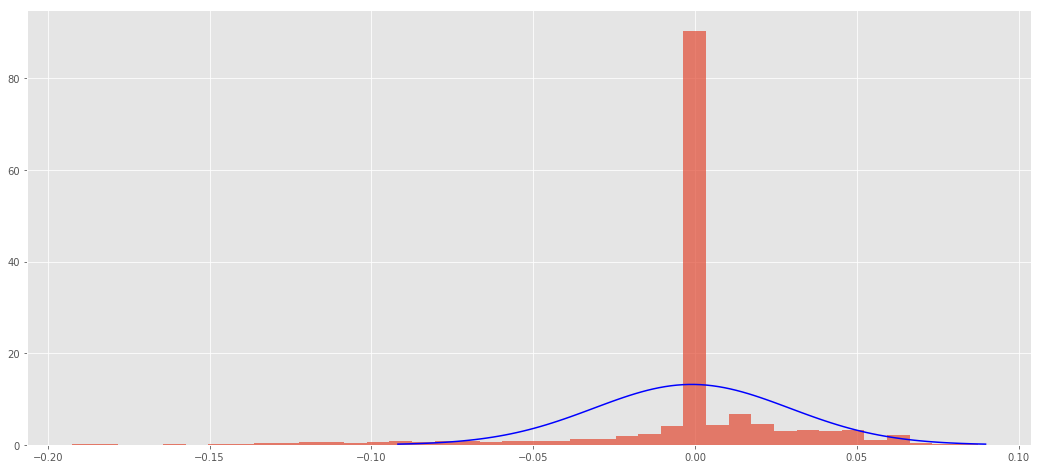

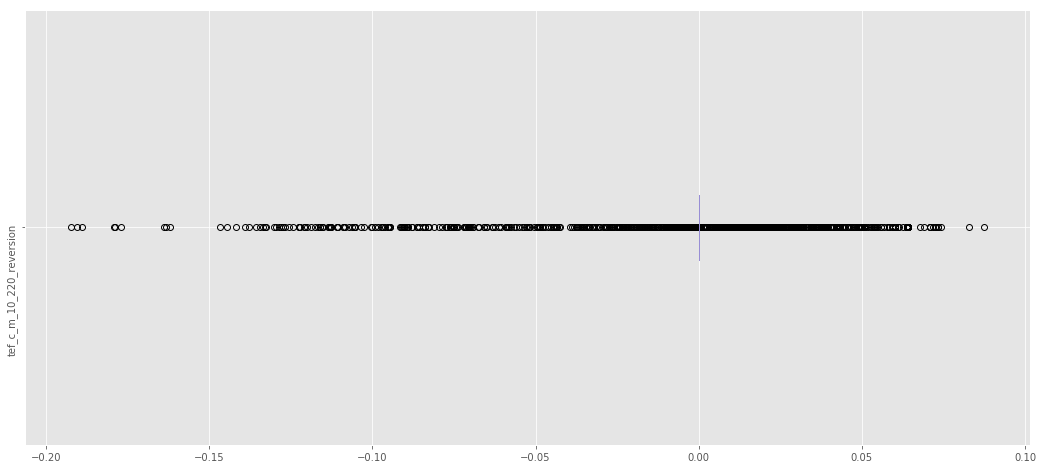

 el valor de 01p es : -0.12457 
 el valor de 05p es : -0.063348 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.044487 
 el valor de T-test es : -1.3647 
 el valor de avg es : -0.001 
 el valor de kur es : 8.5081 
 el valor de skw es : -2.0575 
 el valor de std es : 0.030272 
 el valor de val es : -0.70227 
 el valor de var es : 0.00091641 


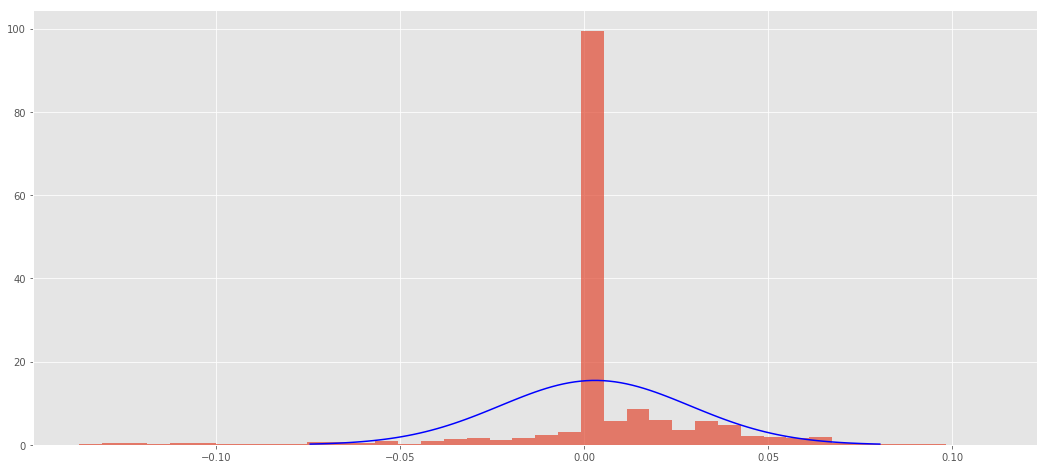

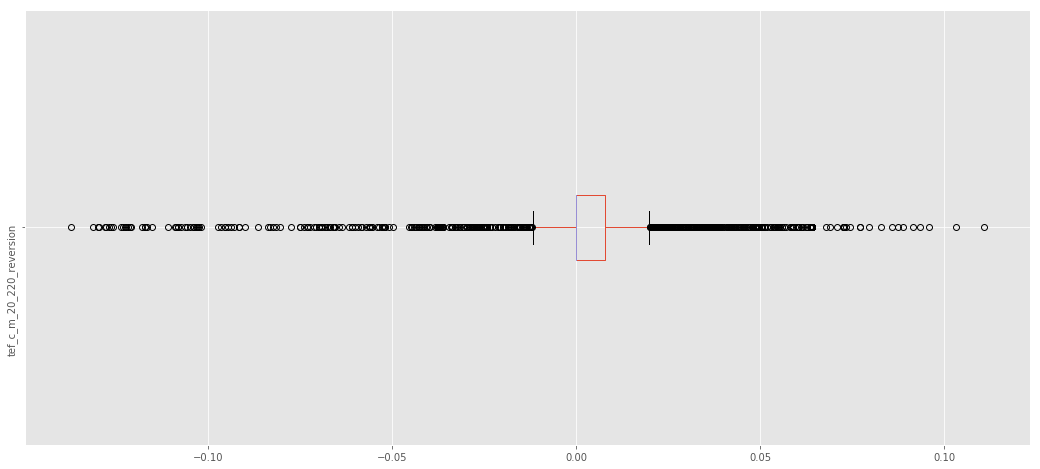

 el valor de 01p es : -0.10645 
 el valor de 05p es : -0.036052 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.043115 
 el valor de T-test es : 6.5974 
 el valor de avg es : 0.003 
 el valor de kur es : 7.4281 
 el valor de skw es : -1.3025 
 el valor de std es : 0.025789 
 el valor de val es : -1.1959 
 el valor de var es : 0.00066506 


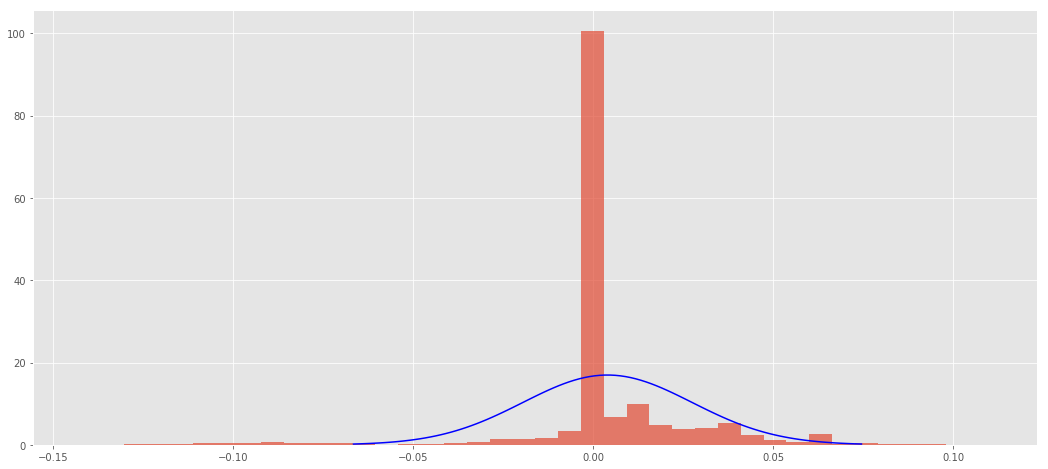

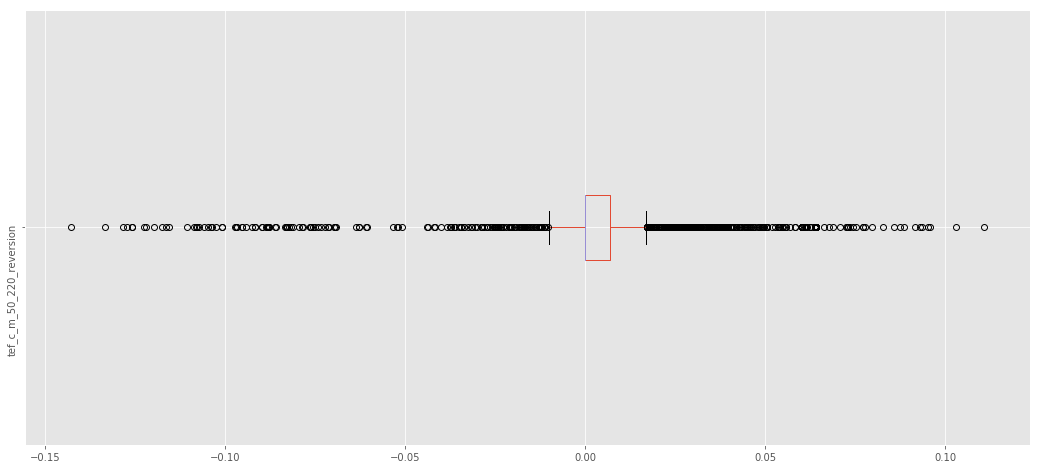

 el valor de 01p es : -0.095535 
 el valor de 05p es : -0.018372 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042026 
 el valor de T-test es : 8.5489 
 el valor de avg es : 0.004 
 el valor de kur es : 9.1783 
 el valor de skw es : -1.1909 
 el valor de std es : 0.023522 
 el valor de val es : -2.2875 
 el valor de var es : 0.0005533 


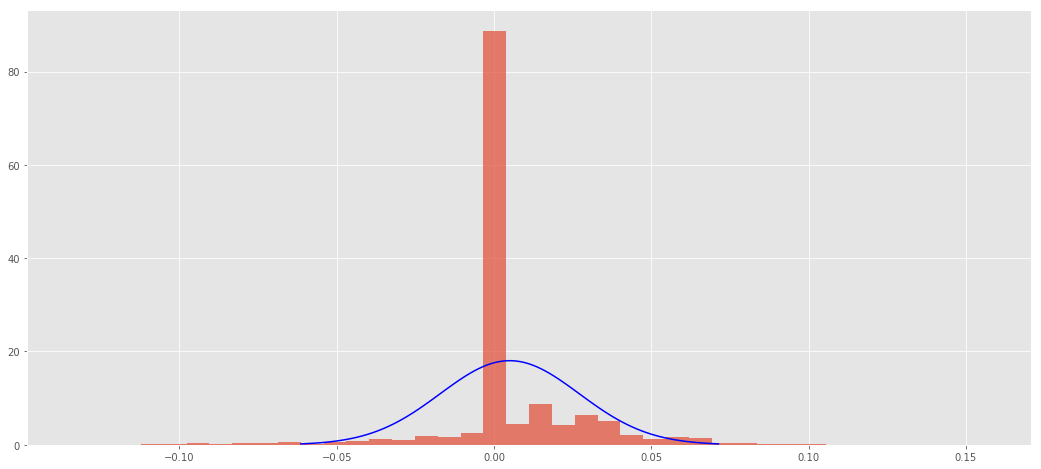

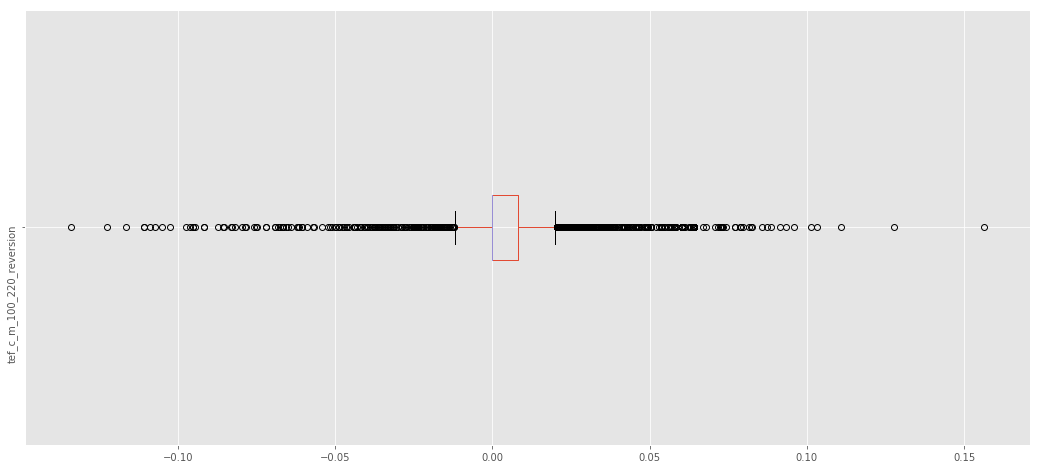

 el valor de 01p es : -0.074935 
 el valor de 05p es : -0.021113 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042971 
 el valor de T-test es : 11.854 
 el valor de avg es : 0.005 
 el valor de kur es : 7.4888 
 el valor de skw es : -0.14351 
 el valor de std es : 0.02212 
 el valor de val es : -2.0352 
 el valor de var es : 0.00048929 


In [174]:
seleccion=f1.filter(like='_reversion',axis=1).columns.values
var95histmediasreversion={}
for n in seleccion:
    sel="{}".format(n)
    #soso.append(n)
    #printsoso
    var95histmediasreversion[sel]=calculate_aggregate(f1[sel].pct_change(20))

<h4>Tabla de resultados de los sistemas con reversión a la media</h4>

In [175]:
fofo=pd.DataFrame(var95histmediasreversion)
np.round(fofo.T,3)

01p    05p  50p    95p  T-test    avg     kur  \
itx_c_m_100_220_reversion -0.085 -0.034  0.0  0.051   5.637  0.003  20.067   
itx_c_m_10_100_reversion  -0.172 -0.036  0.0  0.055   4.424  0.003  17.444   
itx_c_m_10_20_reversion   -0.181 -0.092  0.0  0.054  -5.585 -0.005   6.900   
itx_c_m_10_220_reversion  -0.113 -0.052  0.0  0.044  -0.883 -0.001  15.085   
itx_c_m_10_50_reversion   -0.167 -0.067  0.0  0.064   0.554  0.000   8.515   
itx_c_m_20_100_reversion  -0.117 -0.042  0.0  0.055   3.568  0.002  27.466   
itx_c_m_20_220_reversion  -0.146 -0.052  0.0  0.053   1.705  0.001  13.351   
itx_c_m_20_50_reversion   -0.111 -0.060  0.0  0.061   0.141  0.000   5.284   
itx_c_m_50_100_reversion  -0.102 -0.044  0.0  0.048   5.099  0.003  16.018   
itx_c_m_50_220_reversion  -0.173 -0.050  0.0  0.048   0.284  0.000  16.732   
san_c_m_100_220_reversion -0.115 -0.079  0.0  0.055  -3.098 -0.002  12.408   
san_c_m_10_100_reversion  -0.142 -0.075  0.0  0.061  -1.352 -0.001   5.392   
san_c_m_10_20_reversion   -0.132 -0.079  0.0  0.081   5.053  0.004   3.632   
san_c_m_10_220_reversion  -0.124 -0.085  0.0  0.061  -6.220 -0.005   3.981   
san_c_m_10_50_reversion   -0.225 -0.097  0.0  0.077  -0.491 -0.001  10.232   
san_c_m_20_100_reversion  -0.150 -0.063  0.0  0.058   0.186  0.000  14.374   
san_c_m_20_220_reversion  -0.144 -0.073  0.0  0.051  -3.953 -0.003   5.479   
san_c_m_20_50_reversion   -0.109 -0.063  0.0  0.080   7.982  0.007   9.507   
san_c_m_50_100_reversion  -0.154 -0.081  0.0  0.051  -5.707 -0.004   9.345   
san_c_m_50_220_reversion  -0.103 -0.065  0.0  0.057  -0.731 -0.000   3.876   
tef_c_m_100_220_reversion -0.075 -0.021  0.0  0.043  11.854  0.005   7.489   
tef_c_m_10_100_reversion  -0.130 -0.078  0.0  0.046  -2.818 -0.002   7.659   
tef_c_m_10_20_reversion   -0.108 -0.056  0.0  0.033  -3.188 -0.002  10.138   
tef_c_m_10_220_reversion  -0.125 -0.063  0.0  0.044  -1.365 -0.001   8.508   
tef_c_m_10_50_reversion   -0.147 -0.087  0.0  0.050  -2.099 -0.002   5.648   
tef_c_m_20_100_reversion  -0.157 -0.069  0.0  0.042  -2.843 -0.002  12.769   
tef_c_m_20_220_reversion  -0.106 -0.036  0.0  0.043   6.597  0.003   7.428   
tef_c_m_20_50_reversion   -0.164 -0.070  0.0  0.048  -2.537 -0.002  13.495   
tef_c_m_50_100_reversion  -0.130 -0.084  0.0  0.042  -6.438 -0.004   4.895   
tef_c_m_50_220_reversion  -0.096 -0.018  0.0  0.042   8.549  0.004   9.178   

                             skw    std    val    var  
itx_c_m_100_220_reversion -2.345  0.029 -1.509  0.001  
itx_c_m_10_100_reversion  -2.359  0.036 -1.535  0.001  
itx_c_m_10_20_reversion   -1.016  0.047 -0.584  0.002  
itx_c_m_10_220_reversion  -2.421  0.031 -0.846  0.001  
itx_c_m_10_50_reversion   -0.909  0.042 -0.952  0.002  
itx_c_m_20_100_reversion  -3.402  0.035 -1.307  0.001  
itx_c_m_20_220_reversion  -2.079  0.034 -1.018  0.001  
itx_c_m_20_50_reversion   -0.555  0.032 -1.018  0.001  
itx_c_m_50_100_reversion  -2.350  0.031 -1.073  0.001  
itx_c_m_50_220_reversion  -2.944  0.035 -0.954  0.001  
san_c_m_100_220_reversion  0.685  0.039 -0.697  0.002  
san_c_m_10_100_reversion  -0.372  0.041 -0.804  0.002  
san_c_m_10_20_reversion   -0.014  0.046 -1.022  0.002  
san_c_m_10_220_reversion  -0.176  0.042 -0.716  0.002  
san_c_m_10_50_reversion   -1.639  0.056 -0.796  0.003  
san_c_m_20_100_reversion  -2.399  0.038 -0.922  0.001  
san_c_m_20_220_reversion  -1.429  0.035 -0.702  0.001  
san_c_m_20_50_reversion   -0.011  0.046 -1.280  0.002  
san_c_m_50_100_reversion  -2.102  0.040 -0.633  0.002  
san_c_m_50_220_reversion  -0.679  0.032 -0.875  0.001  
tef_c_m_100_220_reversion -0.144  0.022 -2.035  0.000  
tef_c_m_10_100_reversion  -2.000  0.036 -0.587  0.001  
tef_c_m_10_20_reversion   -1.385  0.027 -0.581  0.001  
tef_c_m_10_220_reversion  -2.058  0.030 -0.702  0.001  
tef_c_m_10_50_reversion   -0.919  0.040 -0.569  0.002  
tef_c_m_20_100_reversion  -2.675  0.036 -0.615  0.001  
tef_c_m_20_220_reversion  -1.302  0.026 -1.196  0.001  
tef_c_m_20_50_reversion   -2.767  0.039 -0

In [176]:
#f.tef_c_m_20_50[0]

<h4>Gráfico del mejor sistema en reversón a la media</h4>

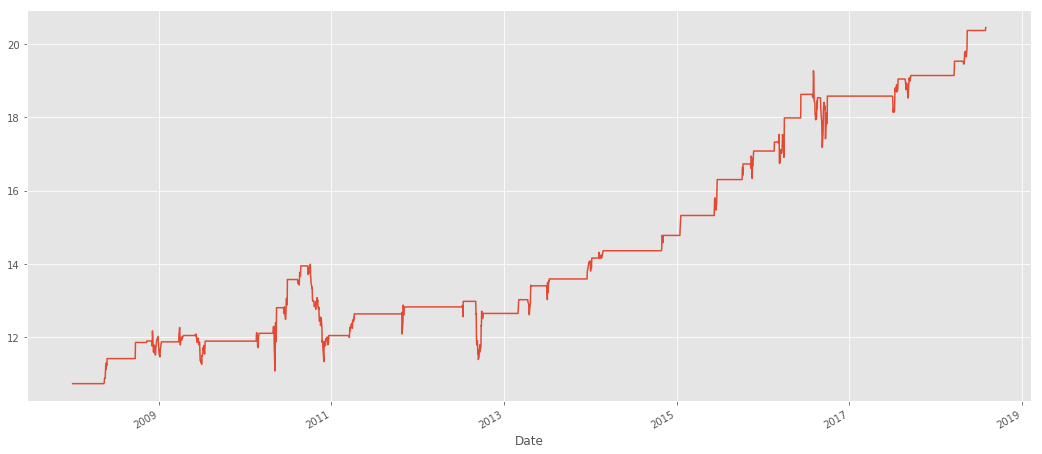

In [177]:
f1.tef_c_m_100_220_reversion.plot()

<h4>Gráfico del sistema que soporta el de reversion</h4>

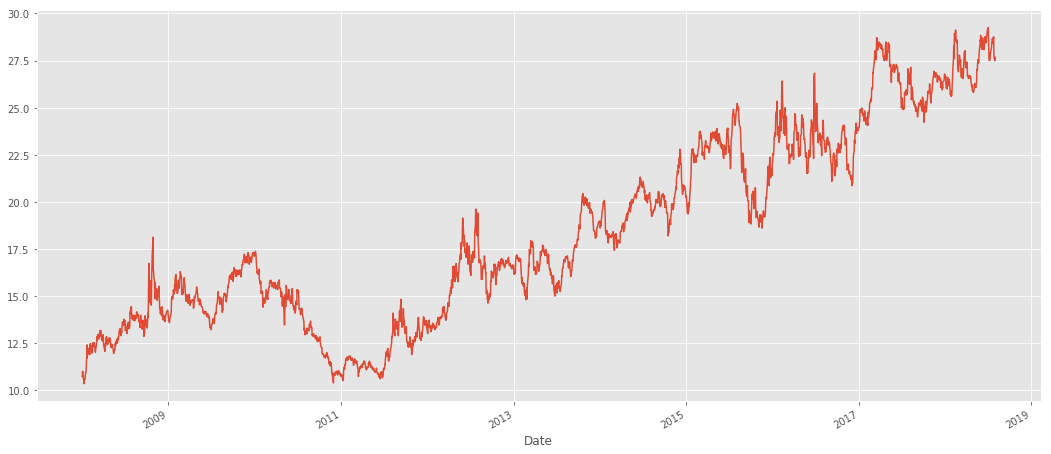

In [178]:
f.tef_c_m_100_220.plot()

In [179]:
#f.tef[0]

In [180]:
#f1.tef_c_m_20_50_reversion[0]

<h4>Tabla de rendimiento del sistema de reversión a la media semestralmente</h4>

In [181]:
f1.tef_c_m_20_50_reversion.resample('2Q').last()

Date
2008-03-31    10.720781
2008-09-30    11.089130
2009-03-31    11.342125
2009-09-30    11.342125
2010-03-31    11.374724
2010-09-30    12.111403
2011-03-31    12.106198
2011-09-30    12.602791
2012-03-31    11.506790
2012-09-30    10.117387
2013-03-31    10.694287
2013-09-30    11.273277
2014-03-31     9.472308
2014-09-30    10.376857
2015-03-31     9.445473
2015-09-30    10.084767
2016-03-31     9.813659
2016-09-30     7.658926
2017-03-31     7.628006
2017-09-30     7.105450
2018-03-31     7.215349
2018-09-30     7.467554
Name: tef_c_m_20_50_reversion, dtype: float64

<h4>tabla del sistema en datos semestrales</h4>

In [182]:
f.tef_c_m_20_50.resample('2Q').last()

Date
2008-03-31    12.947406
2008-09-30    12.458544
2009-03-31     8.470221
2009-09-30    11.003338
2010-03-31    11.382421
2010-09-30    12.170992
2011-03-31     9.517081
2011-09-30    10.445814
2012-03-31     9.384615
2012-09-30     8.802977
2013-03-31     6.975327
2013-09-30     6.905018
2014-03-31     5.848343
2014-09-30     6.509903
2015-03-31     4.338891
2015-09-30     4.097711
2016-03-31     3.368009
2016-09-30     2.428288
2017-03-31     2.706907
2017-09-30     2.433439
2018-03-31     2.281541
2018-09-30     2.111109
Name: tef_c_m_20_50, dtype: float64

<p>Está claro que el comportamiento del sistema no tiene nada que ver con el comportamiento del sistema en reversión.
    <p>Es decir se adapta a la mejor serie para cada sistema

# reversion a la media

In [183]:
#sistema reversion

In [184]:
#crear sistema menor que el 10%
def reversion_media2(values,tanto=-.05,tanto2=0,tanto3=-.1):
    import talib as ta
    df=pd.DataFrame()
    #print type(values)
    df['base']=values.copy()
    #print df.base.tail()
    df['logvalues']=np.log(df.base / df.base.shift(1))
    df['pctvalues']=df['base'].pct_change(20)
    df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,np.nan)
#     df['senal']=np.where((df.pctvalues>tanto)&(df.pctvalues.shift()<tanto),1,df['senal'])

    df['senal']=np.where((df.pctvalues>tanto2)&(df.pctvalues.shift()<tanto2),0,df['senal'])
    df['senal']=np.where((df.pctvalues.shift()<tanto3),0,df['senal'])
    
    df['senal'].ffill(inplace=True)
    df['senal']=df['senal'].fillna(0)
    #.senal.plot(secondary_y=True)
    #print df.logvalues
    df['rendimiento']=df.senal.shift()*df.logvalues
    df['rendimiento']=df['rendimiento'].fillna(0)
    df['rendimiento'][0]=np.log(df['base'][0])
    df['serie']=np.exp(df.rendimiento.cumsum())
    
    return df.serie

In [185]:
seleccion=f.filter(like='_c_m',axis=1).columns.values
var95histmedias10={}
y=pd.DataFrame(index=f.index)
tanto=-.06
for n in seleccion:
      y['{}_reversion2'.format(n,tanto)]=reversion_media2(f['{}'.format(n)],tanto,tanto3=-.15)


In [186]:
y.tail()

san_c_m_10_20_reversion2  san_c_m_10_50_reversion2  \
Date                                                             
2018-07-26                  6.846533                  4.807639   
2018-07-27                  6.846533                  4.807639   
2018-07-30                  6.846533                  4.807639   
2018-07-31                  6.846533                  4.807639   
2018-08-01                  6.846533                  4.807639   

            san_c_m_20_50_reversion2  san_c_m_10_100_reversion2  \
Date                                                              
2018-07-26                 12.761309                   3.980669   
2018-07-27                 12.761309                   3.980669   
2018-07-30                 12.761309                   3.980669   
2018-07-31                 12.761309                   3.980669   
2018-08-01                 12.761309                   3.980669   

            san_c_m_20_100_reversion2  san_c_m_50_100_reversion2  \
Date                                                               
2018-07-26                   5.402629                   3.259273   
2018-07-27                   5.402629                   3.259273   
2018-07-30                   5.402629                   3.259273   
2018-07-31                   5.402629                   3.259273   
2018-08-01                   5.402629                   3.259273   

            san_c_m_10_220_reversion2  san_c_m_20_220_reversion2  \
Date                                                               
2018-07-26                   2.414347                   4.009929   
2018-07-27                   2.414347                   4.009929   
2018-07-30                   2.414347                   4.009929   
2018-07-31                   2.414347                   4.009929   
2018-08-01                   2.414347                   4.009929   

            san_c_m_50_220_reversion2  san_c_m_100_220_reversion2  \
Date                                                                
2018-07-26                   4.613642                    2.995669   
2018-07-27                   4.613642                    2.995669   
2018-07-30                   4.613642                    2.995669   
2018-07-31                   4.613642                    2.995669   
2018-08-01                   4.613642                    2.995669   

                       ...              tef_c_m_10_20_reversion2  \
Date                   ...                                         
2018-07-26             ...                              8.715593   
2018-07-27             ...                              8.715593   
2018-07-30             ...                              8.715593   
2018-07-31             ...                              8.715593   
2018-08-01             ...                              8.715593   

            tef_c_m_10_50_reversion2  tef_c_m_20_50_reversion2  \
Date                                                             
2018-07-26                  7.349709                   6.78273   
2018-07-27                  7.349709                   6.78273   
2018-07-30                  7.349709                   6.78273   
2018-07-31                  7.349709                   6.78273   
2018-08-01                  7.349709                   6.78273   

            tef_c_m_10_100_reversion2  tef_c_m_20_100_reversion2  \
Date                                                               
2018-07-26                   8.220294                   8.922326   
2018-07-27                   8.220294                   8.922326   
2018-07-30                   8.220294                   8.922326   
2018-07-31                   8.220294                   8.922326   
2018-08-01                   8.252484                   8.957266   

            tef_c_m_50_100_reversion2  tef_c_m_10_220_reversion2  \
Date                                                               
2018-07-26                   5.397983                   8.885418   
2018-07-27          

In [187]:
ccoco=f.filter(like='_c_',axis=1).columns.values
var95histmediasreversion2={}
for n in y:
    soso="{}".format(n)
    #soso.append(n)
    print ('\n\n-> {} : \n'.format(soso))
    var95histmediasreversion2[soso]=calculate_aggregate(y[soso].pct_change(20),False,False)



-> san_c_m_10_20_reversion2 : 

 el valor de 01p es : -0.13123 
 el valor de 05p es : -0.07544 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.066824 
 el valor de T-test es : 2.1494 
 el valor de avg es : 0.002 
 el valor de kur es : 3.5514 
 el valor de skw es : -0.60986 
 el valor de std es : 0.041042 
 el valor de val es : -0.88579 
 el valor de var es : 0.0016844 


-> san_c_m_10_50_reversion2 : 

 el valor de 01p es : -0.1555 
 el valor de 05p es : -0.090232 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.067234 
 el valor de T-test es : -0.75858 
 el valor de avg es : -0.001 
 el valor de kur es : 5.009 
 el valor de skw es : -0.84964 
 el valor de std es : 0.044274 
 el valor de val es : -0.74512 
 el valor de var es : 0.0019602 


-> san_c_m_20_50_reversion2 : 

 el valor de 01p es : -0.10541 
 el valor de 05p es : -0.058105 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.075659 
 el valor de T-test es : 8.7285 
 el valor de avg es : 0.006 
 el valor de kur es : 

 el valor de 01p es : -0.12078 
 el valor de 05p es : -0.062242 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042971 
 el valor de T-test es : -1.6449 
 el valor de avg es : -0.001 
 el valor de kur es : 7.8222 
 el valor de skw es : -1.9834 
 el valor de std es : 0.029644 
 el valor de val es : -0.69038 
 el valor de var es : 0.00087876 


-> tef_c_m_20_220_reversion2 : 

 el valor de 01p es : -0.10911 
 el valor de 05p es : -0.032722 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.045277 
 el valor de T-test es : 7.2379 
 el valor de avg es : 0.004 
 el valor de kur es : 7.7802 
 el valor de skw es : -1.338 
 el valor de std es : 0.025756 
 el valor de val es : -1.3837 
 el valor de var es : 0.00066339 


-> tef_c_m_50_220_reversion2 : 

 el valor de 01p es : -0.095535 
 el valor de 05p es : -0.018372 
 el valor de 50p es : 0.0 
 el valor de 95p es : 0.042026 
 el valor de T-test es : 8.5489 
 el valor de avg es : 0.004 
 el valor de kur es : 9.1783 
 el valor de skw es : -

In [188]:
fofo=pd.DataFrame(var95histmediasreversion2)
np.round(fofo.T,3)

01p    05p  50p    95p  T-test    avg     kur  \
itx_c_m_100_220_reversion2 -0.085 -0.032  0.0  0.051   6.703  0.003  13.111   
itx_c_m_10_100_reversion2  -0.114 -0.030  0.0  0.052   6.522  0.004  11.217   
itx_c_m_10_20_reversion2   -0.153 -0.084  0.0  0.049  -5.697 -0.005   5.888   
itx_c_m_10_220_reversion2  -0.125 -0.052  0.0  0.044  -1.091 -0.001   9.654   
itx_c_m_10_50_reversion2   -0.105 -0.061  0.0  0.061   1.940  0.001   5.459   
itx_c_m_20_100_reversion2  -0.125 -0.044  0.0  0.055   4.284  0.003  10.444   
itx_c_m_20_220_reversion2  -0.115 -0.049  0.0  0.051   2.770  0.002   9.679   
itx_c_m_20_50_reversion2   -0.111 -0.056  0.0  0.061  -0.487 -0.000   7.151   
itx_c_m_50_100_reversion2  -0.123 -0.049  0.0  0.048   3.570  0.002  10.061   
itx_c_m_50_220_reversion2  -0.173 -0.049  0.0  0.046   0.128  0.000  14.532   
san_c_m_100_220_reversion2 -0.118 -0.079  0.0  0.048  -6.792 -0.005   3.480   
san_c_m_10_100_reversion2  -0.109 -0.073  0.0  0.053  -3.626 -0.002   2.645   
san_c_m_10_20_reversion2   -0.131 -0.075  0.0  0.067   2.149  0.002   3.551   
san_c_m_10_220_reversion2  -0.126 -0.081  0.0  0.055  -7.830 -0.006   3.680   
san_c_m_10_50_reversion2   -0.155 -0.090  0.0  0.067  -0.759 -0.001   5.009   
san_c_m_20_100_reversion2  -0.141 -0.064  0.0  0.055  -0.299 -0.000   6.591   
san_c_m_20_220_reversion2  -0.106 -0.072  0.0  0.050  -3.871 -0.002   4.289   
san_c_m_20_50_reversion2   -0.105 -0.058  0.0  0.076   8.729  0.006   5.247   
san_c_m_50_100_reversion2  -0.153 -0.079  0.0  0.048  -5.593 -0.004   5.857   
san_c_m_50_220_reversion2  -0.095 -0.064  0.0  0.053  -2.448 -0.001   4.240   
tef_c_m_100_220_reversion2 -0.075 -0.021  0.0  0.043  11.854  0.005   7.489   
tef_c_m_10_100_reversion2  -0.126 -0.072  0.0  0.045  -2.124 -0.001   6.715   
tef_c_m_10_20_reversion2   -0.097 -0.053  0.0  0.033  -2.406 -0.001  10.121   
tef_c_m_10_220_reversion2  -0.121 -0.062  0.0  0.043  -1.645 -0.001   7.822   
tef_c_m_10_50_reversion2   -0.145 -0.091  0.0  0.049  -2.564 -0.002   5.763   
tef_c_m_20_100_reversion2  -0.131 -0.061  0.0  0.040  -1.517 -0.001   6.327   
tef_c_m_20_220_reversion2  -0.109 -0.033  0.0  0.045   7.238  0.004   7.780   
tef_c_m_20_50_reversion2   -0.153 -0.077  0.0  0.042  -3.887 -0.003   8.953   
tef_c_m_50_100_reversion2  -0.135 -0.084  0.0  0.044  -6.365 -0.004   7.247   
tef_c_m_50_220_reversion2  -0.096 -0.018  0.0  0.042   8.549  0.004   9.178   

                              skw    std    val    var  
itx_c_m_100_220_reversion2 -1.468  0.027 -1.613  0.001  
itx_c_m_10_100_reversion2  -1.394  0.030 -1.723  0.001  
itx_c_m_10_20_reversion2   -0.660  0.041 -0.580  0.002  
itx_c_m_10_220_reversion2  -1.868  0.030 -0.854  0.001  
itx_c_m_10_50_reversion2    0.096  0.035 -0.993  0.001  
itx_c_m_20_100_reversion2  -1.501  0.031 -1.243  0.001  
itx_c_m_20_220_reversion2  -1.485  0.030 -1.045  0.001  
itx_c_m_20_50_reversion2   -0.906  0.033 -1.090  0.001  
itx_c_m_50_100_reversion2  -1.834  0.031 -0.976  0.001  
itx_c_m_50_220_reversion2  -2.694  0.033 -0.945  0.001  
san_c_m_100_220_reversion2 -0.995  0.035 -0.601  0.001  
san_c_m_10_100_reversion2  -0.777  0.035 -0.733  0.001  
san_c_m_10_20_reversion2   -0.610  0.041 -0.886  0.002  
san_c_m_10_220_reversion2  -0.488  0.040 -0.678  0.002  
san_c_m_10_50_reversion2   -0.850  0.044 -0.745  0.002  
san_c_m_20_100_reversion2  -1.478  0.034 -0.868  0.001  
san_c_m_20_220_reversion2  -1.149  0.033 -0.703  0.001  
san_c_m_20_50_reversion2    0.399  0.038 -1.302  0.001  
san_c_m_50_100_reversion2  -1.633  0.036 -0.605  0.001  
san_c_m_50_220_reversion2  -0.823  0.031 -0.826  0.001  
tef_c_m_100_220_reversion2 -0.144  0.022 -2.035  0.000  
tef_c_m_10_100_reversion2  -1.813  0.034 -0.628  0.001  
tef_c_m_10_20_reversion2   -1.102  0.026 -0.615  0.001  
tef_c_m_10_220_reversion2  -1.983  0.030 -0.690  0.001  
tef_c_m_10_50_reversion2   -1.071  0.040 -0.542  0.002  
tef_c_m_20_100_reversion2  -1.674  0.030 -0.656  0.001  
tef_c_m_20_220_reversion2  -1.338  0.026 

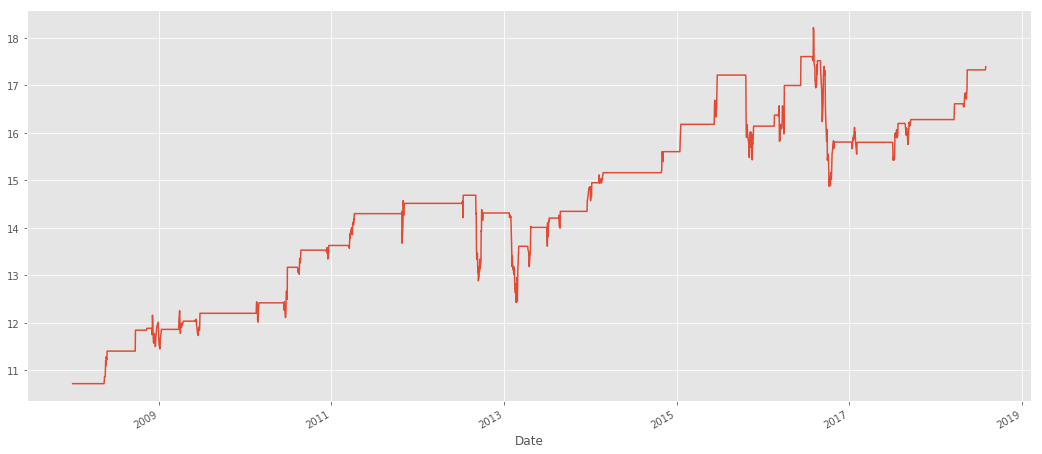

In [189]:
y.tef_c_m_50_220_reversion2.plot()

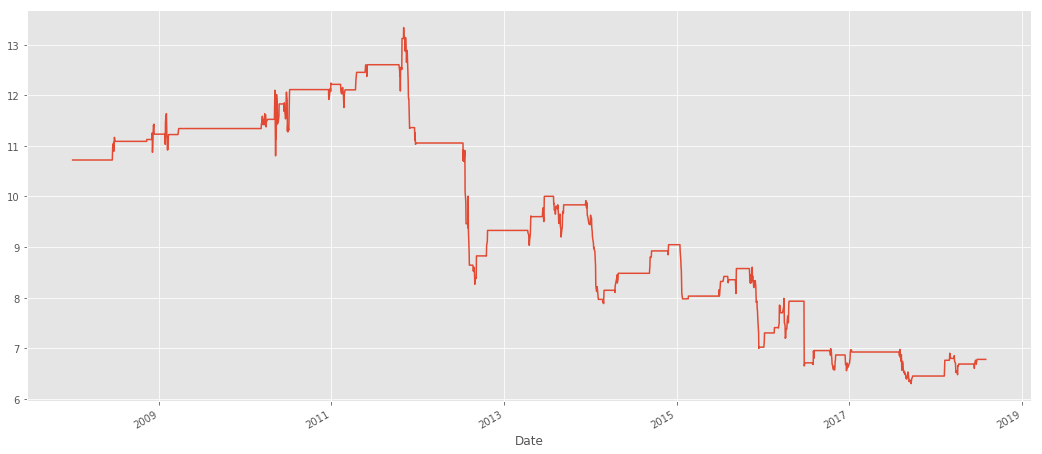

In [190]:
y.tef_c_m_20_50_reversion2.plot()